In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    300,
    False,
    False,
    False,
    300,
    False,
    300,
    300,
    300,
    300,
]
aew_subset = "12hr_before"
model_save_name = "best_model_3001.keras"
tuner_project_name = "tuner_run_3001"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-09 01:29:18.167338: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 01:29:18.341299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752046158.397325  108061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752046158.413281  108061 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752046158.545713  108061 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.


Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading q_300 from Zarr store.
Loading r_300 from Zarr store.


Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.


Loading v_300 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 18)


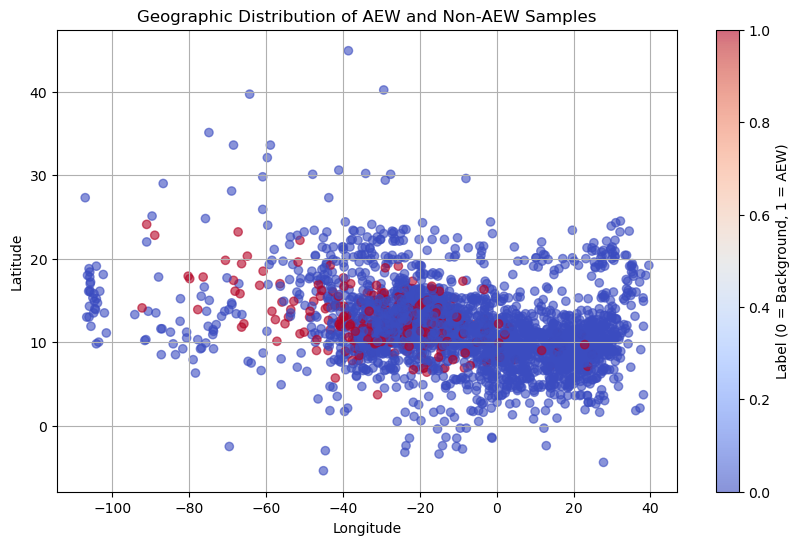

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






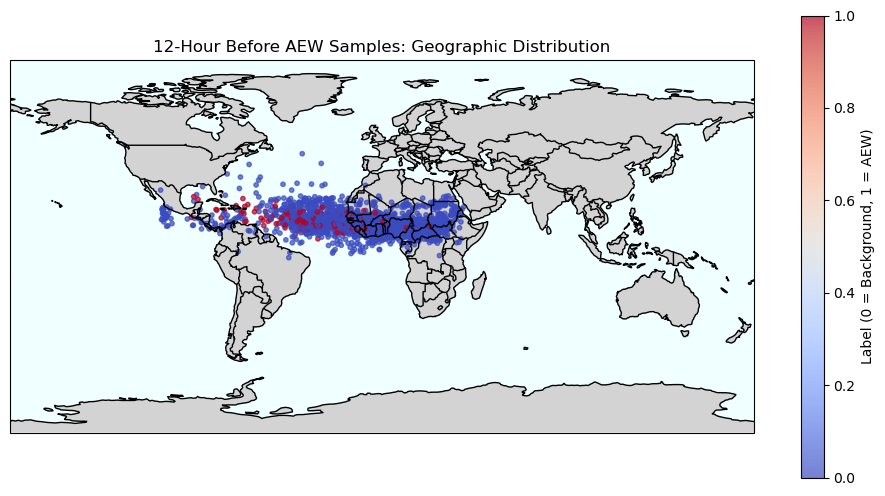

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 18) (550, 32, 32, 18) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 18) (2200, 1) (550, 32, 32, 18) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-09 01:31:28.787928: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 19s]
val_f1_score: 0.5454545021057129

Best val_f1_score So Far: 0.7199999690055847
Total elapsed time: 03h 15m 33s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 52)          │           8,476 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 52)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 52)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │          15,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 105)           │          30,345 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 105)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 105)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 105)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 55)                  │           5,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,715 (233.26 KB)

 Trainable params: 59,715 (233.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - auc: 0.8539 - binary_accuracy: 0.9325 - cross entropy: 0.2904 - f1_score: 0.3704 - fn: 10.0000 - fp: 7.0000 - loss: 0.0112 - mean_squared_error: 0.0800 - prc: 0.3437 - precision: 0.4167 - recall: 0.3333 - root_mean_squared_error: 0.2828 - tn: 230.0000 - tp: 5.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7310 - binary_accuracy: 0.9213 - cross entropy: 0.3432 - f1_score: 0.3280 - fn: 14.1667 - fp: 12.6667 - loss: 0.0567 - mean_squared_error: 0.0862 - prc: 0.2498 - precision: 0.3642 - recall: 0.3105 - root_mean_squared_error: 0.2932 - tn: 298.6667 - tp: 6.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7126 - binary_accuracy: 0.8969 - cross entropy: 0.3743 - f1_score: 0.3179 - fn: 18.1667 - fp: 29.4167 - loss: 0.0504 - mean_squared_error: 0.0985 - prc: 0.2174 - precision: 0.3099 - recall: 0.3539 - root_mean_squared_error: 0.3128 - tn: 369.6667 - tp: 10.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7117 - binary_accuracy: 0.8749 - cross entropy: 0.3932 - f1_score: 0.3035 - fn: 23.5000 - fp: 48.7222 - loss: 0.0448 - mean_squared_error: 0.1075 - prc: 0.2078 - precision: 0.2763 - recall: 0.3697 - root_mean_squared_error: 0.3266 - tn: 437.0000 - tp: 14.7778

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7085 - binary_accuracy: 0.8547 - cross entropy: 0.4120 - f1_score: 0.2931 - fn: 30.5600 - fp: 72.6000 - loss: 0.0408 - mean_squared_error: 0.1167 - prc: 0.2019 - precision: 0.2546 - recall: 0.3798 - root_mean_squared_error: 0.3400 - tn: 512.8800 - tp: 19.9600

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7047 - binary_accuracy: 0.8380 - cross entropy: 0.4283 - f1_score: 0.2871 - fn: 37.1875 - fp: 98.9688 - loss: 0.0384 - mean_squared_error: 0.1247 - prc: 0.2008 - precision: 0.2409 - recall: 0.3909 - root_mean_squared_error: 0.3512 - tn: 586.2188 - tp: 25.6250

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7046 - binary_accuracy: 0.8310 - cross entropy: 0.4337 - f1_score: 0.2858 - fn: 42.3684 - fp: 116.4211 - loss: 0.0368 - mean_squared_error: 0.1279 - prc: 0.2015 - precision: 0.2352 - recall: 0.3980 - root_mean_squared_error: 0.3560 - tn: 655.0789 - tp: 30.1316

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7065 - binary_accuracy: 0.8263 - cross entropy: 0.4376 - f1_score: 0.2879 - fn: 47.4091 - fp: 132.7045 - loss: 0.0353 - mean_squared_error: 0.1303 - prc: 0.2034 - precision: 0.2336 - recall: 0.4066 - root_mean_squared_error: 0.3594 - tn: 724.5909 - tp: 35.2955

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7086 - binary_accuracy: 0.8236 - cross entropy: 0.4404 - f1_score: 0.2916 - fn: 51.9200 - fp: 147.5800 - loss: 0.0339 - mean_squared_error: 0.1321 - prc: 0.2051 - precision: 0.2342 - recall: 0.4161 - root_mean_squared_error: 0.3620 - tn: 795.8200 - tp: 40.6800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7097 - binary_accuracy: 0.8222 - cross entropy: 0.4422 - f1_score: 0.2943 - fn: 56.5000 - fp: 160.8750 - loss: 0.0327 - mean_squared_error: 0.1333 - prc: 0.2059 - precision: 0.2345 - recall: 0.4221 - root_mean_squared_error: 0.3637 - tn: 869.2321 - tp: 45.3929

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7102 - binary_accuracy: 0.8213 - cross entropy: 0.4439 - f1_score: 0.2965 - fn: 61.0161 - fp: 173.6452 - loss: 0.0316 - mean_squared_error: 0.1343 - prc: 0.2063 - precision: 0.2349 - recall: 0.4268 - root_mean_squared_error: 0.3653 - tn: 943.3871 - tp: 49.8871

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - auc: 0.7103 - binary_accuracy: 0.8212 - cross entropy: 0.4441 - f1_score: 0.2968 - fn: 61.7937 - fp: 175.5397 - loss: 0.0314 - mean_squared_error: 0.1345 - prc: 0.2064 - precision: 0.2351 - recall: 0.4274 - root_mean_squared_error: 0.3655 - tn: 955.4445 - tp: 50.5873 - val_auc: 0.7882 - val_binary_accuracy: 0.4318 - val_cross entropy: 0.6825 - val_f1_score: 0.1722 - val_fn: 0.0000e+00 - val_fp: 125.0000 - val_loss: 0.1487 - val_mean_squared_error: 0.2469 - val_prc: 0.1423 - val_precision: 0.0942 - val_recall: 1.0000 - val_root_mean_squared_error: 0.4969 - val_tn: 82.0000 - val_tp: 13.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.6167 - binary_accuracy: 0.3438 - cross entropy: 0.8071 - f1_score: 0.1600 - fn: 0.0000e+00 - fp: 21.0000 - loss: 0.0203 - mean_squared_error: 0.3035 - prc: 0.0754 - precision: 0.0870 - recall: 1.0000 - root_mean_squared_error: 0.5509 - tn: 9.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7190 - binary_accuracy: 0.5648 - cross entropy: 0.6479 - f1_score: 0.1931 - fn: 3.0000 - fp: 43.0000 - loss: 0.0152 - mean_squared_error: 0.2300 - prc: 0.1266 - precision: 0.1135 - recall: 0.7647 - root_mean_squared_error: 0.4765 - tn: 76.2857 - tp: 5.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7106 - binary_accuracy: 0.6599 - cross entropy: 0.5644 - f1_score: 0.2009 - fn: 9.6154 - fp: 51.0769 - loss: 0.0143 - mean_squared_error: 0.1930 - prc: 0.1407 - precision: 0.1288 - recall: 0.5850 - root_mean_squared_error: 0.4351 - tn: 155.3077 - tp: 8.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7102 - binary_accuracy: 0.6788 - cross entropy: 0.5471 - f1_score: 0.2077 - fn: 13.8889 - fp: 68.4444 - loss: 0.0143 - mean_squared_error: 0.1853 - prc: 0.1511 - precision: 0.1349 - recall: 0.5473 - root_mean_squared_error: 0.4272 - tn: 210.2778 - tp: 11.3889

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7053 - binary_accuracy: 0.6942 - cross entropy: 0.5332 - f1_score: 0.2122 - fn: 19.3478 - fp: 81.6957 - loss: 0.0145 - mean_squared_error: 0.1792 - prc: 0.1585 - precision: 0.1407 - recall: 0.5129 - root_mean_squared_error: 0.4205 - tn: 268.5652 - tp: 14.3913

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7072 - binary_accuracy: 0.7013 - cross entropy: 0.5270 - f1_score: 0.2256 - fn: 24.1724 - fp: 103.5862 - loss: 0.0147 - mean_squared_error: 0.1764 - prc: 0.1739 - precision: 0.1510 - recall: 0.5119 - root_mean_squared_error: 0.4177 - tn: 331.6897 - tp: 20.5517

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7113 - binary_accuracy: 0.7113 - cross entropy: 0.5175 - f1_score: 0.2350 - fn: 29.3143 - fp: 119.2286 - loss: 0.0146 - mean_squared_error: 0.1723 - prc: 0.1840 - precision: 0.1593 - recall: 0.5052 - root_mean_squared_error: 0.4130 - tn: 402.1143 - tp: 25.3429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7173 - binary_accuracy: 0.7206 - cross entropy: 0.5092 - f1_score: 0.2459 - fn: 33.7073 - fp: 133.7317 - loss: 0.0144 - mean_squared_error: 0.1686 - prc: 0.1933 - precision: 0.1685 - recall: 0.5062 - root_mean_squared_error: 0.4088 - tn: 473.7805 - tp: 30.7805 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7245 - binary_accuracy: 0.7290 - cross entropy: 0.5024 - f1_score: 0.2587 - fn: 37.7234 - fp: 147.1489 - loss: 0.0142 - mean_squared_error: 0.1656 - prc: 0.2031 - precision: 0.1791 - recall: 0.5121 - root_mean_squared_error: 0.4051 - tn: 546.0000 - tp: 37.1277

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7307 - binary_accuracy: 0.7367 - cross entropy: 0.4961 - f1_score: 0.2689 - fn: 41.4717 - fp: 159.5849 - loss: 0.0140 - mean_squared_error: 0.1628 - prc: 0.2107 - precision: 0.1877 - recall: 0.5168 - root_mean_squared_error: 0.4017 - tn: 620.0755 - tp: 42.8679

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7358 - binary_accuracy: 0.7437 - cross entropy: 0.4910 - f1_score: 0.2774 - fn: 45.1186 - fp: 171.3220 - loss: 0.0138 - mean_squared_error: 0.1604 - prc: 0.2164 - precision: 0.1949 - recall: 0.5205 - root_mean_squared_error: 0.3989 - tn: 695.3220 - tp: 48.2373

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7385 - binary_accuracy: 0.7479 - cross entropy: 0.4881 - f1_score: 0.2820 - fn: 47.8730 - fp: 178.3492 - loss: 0.0136 - mean_squared_error: 0.1591 - prc: 0.2195 - precision: 0.1991 - recall: 0.5211 - root_mean_squared_error: 0.3972 - tn: 745.6349 - tp: 51.5079 - val_auc: 0.8606 - val_binary_accuracy: 0.7409 - val_cross entropy: 0.5785 - val_f1_score: 0.2597 - val_fn: 3.0000 - val_fp: 54.0000 - val_loss: 0.1022 - val_mean_squared_error: 0.1979 - val_prc: 0.2396 - val_precision: 0.1562 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4449 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.6167 - binary_accuracy: 0.6250 - cross entropy: 0.6254 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.0123 - mean_squared_error: 0.2187 - prc: 0.0768 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.4677 - tn: 18.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7059 - binary_accuracy: 0.6933 - cross entropy: 0.5867 - f1_score: 0.2581 - fn: 2.1667 - fp: 28.6667 - loss: 0.0116 - mean_squared_error: 0.2009 - prc: 0.1085 - precision: 0.1566 - recall: 0.8144 - root_mean_squared_error: 0.4477 - tn: 75.6667 - tp: 5.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7078 - binary_accuracy: 0.7535 - cross entropy: 0.5320 - f1_score: 0.2451 - fn: 7.7273 - fp: 31.7273 - loss: 0.0111 - mean_squared_error: 0.1764 - prc: 0.1184 - precision: 0.1638 - recall: 0.6062 - root_mean_squared_error: 0.4184 - tn: 146.1818 - tp: 6.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7184 - binary_accuracy: 0.7674 - cross entropy: 0.5167 - f1_score: 0.2567 - fn: 12.2500 - fp: 43.4375 - loss: 0.0112 - mean_squared_error: 0.1696 - prc: 0.1451 - precision: 0.1782 - recall: 0.5549 - root_mean_squared_error: 0.4105 - tn: 206.3750 - tp: 9.9375

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7254 - binary_accuracy: 0.7772 - cross entropy: 0.5045 - f1_score: 0.2707 - fn: 17.2273 - fp: 56.7273 - loss: 0.0113 - mean_squared_error: 0.1642 - prc: 0.1667 - precision: 0.1919 - recall: 0.5329 - root_mean_squared_error: 0.4042 - tn: 279.3636 - tp: 14.6818

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7292 - binary_accuracy: 0.7791 - cross entropy: 0.5000 - f1_score: 0.2841 - fn: 22.0714 - fp: 73.5357 - loss: 0.0116 - mean_squared_error: 0.1623 - prc: 0.1871 - precision: 0.2033 - recall: 0.5304 - root_mean_squared_error: 0.4019 - tn: 347.5000 - tp: 20.8929

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7329 - binary_accuracy: 0.7807 - cross entropy: 0.4969 - f1_score: 0.2918 - fn: 26.6765 - fp: 89.7059 - loss: 0.0117 - mean_squared_error: 0.1609 - prc: 0.2001 - precision: 0.2097 - recall: 0.5285 - root_mean_squared_error: 0.4004 - tn: 417.2353 - tp: 26.3824 

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7376 - binary_accuracy: 0.7844 - cross entropy: 0.4915 - f1_score: 0.2984 - fn: 31.4750 - fp: 102.5000 - loss: 0.0117 - mean_squared_error: 0.1586 - prc: 0.2096 - precision: 0.2161 - recall: 0.5245 - root_mean_squared_error: 0.3975 - tn: 490.7250 - tp: 31.3000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7442 - binary_accuracy: 0.7876 - cross entropy: 0.4873 - f1_score: 0.3078 - fn: 35.7391 - fp: 115.4130 - loss: 0.0117 - mean_squared_error: 0.1568 - prc: 0.2236 - precision: 0.2244 - recall: 0.5278 - root_mean_squared_error: 0.3953 - tn: 563.4130 - tp: 37.4348

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7506 - binary_accuracy: 0.7913 - cross entropy: 0.4824 - f1_score: 0.3157 - fn: 39.7500 - fp: 126.9231 - loss: 0.0116 - mean_squared_error: 0.1547 - prc: 0.2353 - precision: 0.2315 - recall: 0.5303 - root_mean_squared_error: 0.3927 - tn: 638.2885 - tp: 43.0385

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7559 - binary_accuracy: 0.7948 - cross entropy: 0.4779 - f1_score: 0.3221 - fn: 43.5690 - fp: 137.8793 - loss: 0.0115 - mean_squared_error: 0.1527 - prc: 0.2443 - precision: 0.2373 - recall: 0.5324 - root_mean_squared_error: 0.3902 - tn: 714.2241 - tp: 48.3276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7595 - binary_accuracy: 0.7976 - cross entropy: 0.4749 - f1_score: 0.3265 - fn: 46.9365 - fp: 146.3651 - loss: 0.0114 - mean_squared_error: 0.1514 - prc: 0.2502 - precision: 0.2415 - recall: 0.5329 - root_mean_squared_error: 0.3885 - tn: 777.6190 - tp: 52.4444 - val_auc: 0.8976 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.5158 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 23.0000 - val_loss: 0.0753 - val_mean_squared_error: 0.1671 - val_prc: 0.2770 - val_precision: 0.2812 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4087 - val_tn: 184.0000 - val_tp: 9.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8333 - binary_accuracy: 0.7500 - cross entropy: 0.5682 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0101 - mean_squared_error: 0.1905 - prc: 0.1562 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4364 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8466 - binary_accuracy: 0.8096 - cross entropy: 0.5241 - f1_score: 0.3034 - fn: 3.0000 - fp: 16.0000 - loss: 0.0090 - mean_squared_error: 0.1699 - prc: 0.2004 - precision: 0.2075 - recall: 0.6041 - root_mean_squared_error: 0.4118 - tn: 88.3333 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8246 - binary_accuracy: 0.8421 - cross entropy: 0.4881 - f1_score: 0.3329 - fn: 7.0000 - fp: 18.9091 - loss: 0.0089 - mean_squared_error: 0.1539 - prc: 0.2174 - precision: 0.2524 - recall: 0.5429 - root_mean_squared_error: 0.3915 - tn: 159.0000 - tp: 7.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8118 - binary_accuracy: 0.8462 - cross entropy: 0.4798 - f1_score: 0.3498 - fn: 11.7647 - fp: 29.1765 - loss: 0.0093 - mean_squared_error: 0.1505 - prc: 0.2401 - precision: 0.2725 - recall: 0.5285 - root_mean_squared_error: 0.3873 - tn: 235.0588 - tp: 12.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8046 - binary_accuracy: 0.8463 - cross entropy: 0.4754 - f1_score: 0.3589 - fn: 16.6522 - fp: 39.9130 - loss: 0.0096 - mean_squared_error: 0.1487 - prc: 0.2575 - precision: 0.2821 - recall: 0.5238 - root_mean_squared_error: 0.3851 - tn: 310.3478 - tp: 17.0870

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8003 - binary_accuracy: 0.8425 - cross entropy: 0.4748 - f1_score: 0.3633 - fn: 21.9310 - fp: 53.1724 - loss: 0.0098 - mean_squared_error: 0.1486 - prc: 0.2727 - precision: 0.2864 - recall: 0.5215 - root_mean_squared_error: 0.3851 - tn: 382.1035 - tp: 22.7931

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7980 - binary_accuracy: 0.8404 - cross entropy: 0.4743 - f1_score: 0.3665 - fn: 26.4286 - fp: 66.0286 - loss: 0.0099 - mean_squared_error: 0.1486 - prc: 0.2824 - precision: 0.2885 - recall: 0.5232 - root_mean_squared_error: 0.3851 - tn: 455.3143 - tp: 28.2286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7977 - binary_accuracy: 0.8404 - cross entropy: 0.4715 - f1_score: 0.3699 - fn: 31.1707 - fp: 76.5610 - loss: 0.0100 - mean_squared_error: 0.1475 - prc: 0.2890 - precision: 0.2921 - recall: 0.5223 - root_mean_squared_error: 0.3837 - tn: 530.9512 - tp: 33.3171 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8008 - binary_accuracy: 0.8407 - cross entropy: 0.4684 - f1_score: 0.3774 - fn: 35.9375 - fp: 89.1875 - loss: 0.0100 - mean_squared_error: 0.1462 - prc: 0.3056 - precision: 0.2985 - recall: 0.5284 - root_mean_squared_error: 0.3821 - tn: 618.3542 - tp: 40.5208

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8036 - binary_accuracy: 0.8414 - cross entropy: 0.4648 - f1_score: 0.3822 - fn: 39.6667 - fp: 99.6111 - loss: 0.0100 - mean_squared_error: 0.1448 - prc: 0.3168 - precision: 0.3024 - recall: 0.5328 - root_mean_squared_error: 0.3802 - tn: 694.5370 - tp: 46.1852

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8063 - binary_accuracy: 0.8422 - cross entropy: 0.4612 - f1_score: 0.3859 - fn: 43.2667 - fp: 109.8000 - loss: 0.0099 - mean_squared_error: 0.1433 - prc: 0.3251 - precision: 0.3054 - recall: 0.5365 - root_mean_squared_error: 0.3783 - tn: 771.3500 - tp: 51.5833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8072 - binary_accuracy: 0.8425 - cross entropy: 0.4597 - f1_score: 0.3874 - fn: 45.2063 - fp: 114.6508 - loss: 0.0099 - mean_squared_error: 0.1427 - prc: 0.3283 - precision: 0.3067 - recall: 0.5375 - root_mean_squared_error: 0.3775 - tn: 809.3333 - tp: 54.1746 - val_auc: 0.8898 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.5356 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 37.0000 - val_loss: 0.0893 - val_mean_squared_error: 0.1775 - val_prc: 0.3879 - val_precision: 0.2128 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4213 - val_tn: 170.0000 - val_tp: 10.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8000 - binary_accuracy: 0.7500 - cross entropy: 0.6125 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0118 - mean_squared_error: 0.2116 - prc: 0.1320 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4600 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8227 - binary_accuracy: 0.7944 - cross entropy: 0.5581 - f1_score: 0.3633 - fn: 1.5714 - fp: 21.8571 - loss: 0.0103 - mean_squared_error: 0.1862 - prc: 0.2005 - precision: 0.2344 - recall: 0.8696 - root_mean_squared_error: 0.4309 - tn: 97.4286 - tp: 7.1429   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8038 - binary_accuracy: 0.8274 - cross entropy: 0.5186 - f1_score: 0.3754 - fn: 6.3333 - fp: 24.1667 - loss: 0.0101 - mean_squared_error: 0.1685 - prc: 0.2071 - precision: 0.2703 - recall: 0.7241 - root_mean_squared_error: 0.4093 - tn: 167.9167 - tp: 9.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7963 - binary_accuracy: 0.8404 - cross entropy: 0.5027 - f1_score: 0.3829 - fn: 11.5000 - fp: 30.9444 - loss: 0.0101 - mean_squared_error: 0.1613 - prc: 0.2218 - precision: 0.2906 - recall: 0.6493 - root_mean_squared_error: 0.4006 - tn: 247.7778 - tp: 13.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7950 - binary_accuracy: 0.8461 - cross entropy: 0.4936 - f1_score: 0.3913 - fn: 16.9167 - fp: 38.4583 - loss: 0.0101 - mean_squared_error: 0.1573 - prc: 0.2406 - precision: 0.3065 - recall: 0.6133 - root_mean_squared_error: 0.3958 - tn: 325.9167 - tp: 18.7083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7956 - binary_accuracy: 0.8471 - cross entropy: 0.4885 - f1_score: 0.3964 - fn: 22.1333 - fp: 48.4000 - loss: 0.0102 - mean_squared_error: 0.1551 - prc: 0.2626 - precision: 0.3149 - recall: 0.5948 - root_mean_squared_error: 0.3931 - tn: 401.1333 - tp: 24.3333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7974 - binary_accuracy: 0.8473 - cross entropy: 0.4844 - f1_score: 0.3975 - fn: 26.8333 - fp: 59.1111 - loss: 0.0101 - mean_squared_error: 0.1534 - prc: 0.2787 - precision: 0.3171 - recall: 0.5828 - root_mean_squared_error: 0.3910 - tn: 476.6111 - tp: 29.4444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7997 - binary_accuracy: 0.8479 - cross entropy: 0.4794 - f1_score: 0.3976 - fn: 32.0714 - fp: 68.4048 - loss: 0.0101 - mean_squared_error: 0.1513 - prc: 0.2901 - precision: 0.3195 - recall: 0.5702 - root_mean_squared_error: 0.3883 - tn: 553.4048 - tp: 34.1190

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8037 - binary_accuracy: 0.8488 - cross entropy: 0.4750 - f1_score: 0.4014 - fn: 36.7292 - fp: 77.5625 - loss: 0.0101 - mean_squared_error: 0.1494 - prc: 0.3043 - precision: 0.3243 - recall: 0.5654 - root_mean_squared_error: 0.3860 - tn: 629.9792 - tp: 39.7292

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8072 - binary_accuracy: 0.8497 - cross entropy: 0.4706 - f1_score: 0.4038 - fn: 40.9444 - fp: 86.8148 - loss: 0.0100 - mean_squared_error: 0.1476 - prc: 0.3134 - precision: 0.3271 - recall: 0.5622 - root_mean_squared_error: 0.3837 - tn: 707.3333 - tp: 44.9074

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8102 - binary_accuracy: 0.8507 - cross entropy: 0.4663 - f1_score: 0.4059 - fn: 44.9333 - fp: 95.8167 - loss: 0.0099 - mean_squared_error: 0.1458 - prc: 0.3203 - precision: 0.3293 - recall: 0.5600 - root_mean_squared_error: 0.3813 - tn: 785.3333 - tp: 49.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8115 - binary_accuracy: 0.8513 - cross entropy: 0.4643 - f1_score: 0.4070 - fn: 46.9841 - fp: 99.9683 - loss: 0.0099 - mean_squared_error: 0.1450 - prc: 0.3233 - precision: 0.3307 - recall: 0.5589 - root_mean_squared_error: 0.3802 - tn: 824.0159 - tp: 52.3968 - val_auc: 0.8703 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.5012 - val_f1_score: 0.3200 - val_fn: 5.0000 - val_fp: 29.0000 - val_loss: 0.0840 - val_mean_squared_error: 0.1629 - val_prc: 0.2944 - val_precision: 0.2162 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4036 - val_tn: 178.0000 - val_tp: 8.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7667 - binary_accuracy: 0.7500 - cross entropy: 0.5516 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0106 - mean_squared_error: 0.1836 - prc: 0.1204 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4285 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8411 - binary_accuracy: 0.7968 - cross entropy: 0.5210 - f1_score: 0.3130 - fn: 2.1667 - fp: 18.8333 - loss: 0.0093 - mean_squared_error: 0.1695 - prc: 0.2524 - precision: 0.2052 - recall: 0.6847 - root_mean_squared_error: 0.4115 - tn: 85.5000 - tp: 5.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8256 - binary_accuracy: 0.8268 - cross entropy: 0.4909 - f1_score: 0.3449 - fn: 6.5833 - fp: 25.5833 - loss: 0.0091 - mean_squared_error: 0.1561 - prc: 0.2733 - precision: 0.2460 - recall: 0.6249 - root_mean_squared_error: 0.3946 - tn: 166.5000 - tp: 9.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8166 - binary_accuracy: 0.8392 - cross entropy: 0.4792 - f1_score: 0.3650 - fn: 11.3333 - fp: 32.5000 - loss: 0.0092 - mean_squared_error: 0.1508 - prc: 0.2981 - precision: 0.2743 - recall: 0.5908 - root_mean_squared_error: 0.3880 - tn: 246.2222 - tp: 13.9444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8142 - binary_accuracy: 0.8448 - cross entropy: 0.4741 - f1_score: 0.3810 - fn: 16.2083 - fp: 40.5417 - loss: 0.0094 - mean_squared_error: 0.1485 - prc: 0.3245 - precision: 0.2948 - recall: 0.5777 - root_mean_squared_error: 0.3850 - tn: 323.8333 - tp: 19.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8146 - binary_accuracy: 0.8474 - cross entropy: 0.4715 - f1_score: 0.3941 - fn: 20.8333 - fp: 49.5667 - loss: 0.0095 - mean_squared_error: 0.1474 - prc: 0.3437 - precision: 0.3101 - recall: 0.5745 - root_mean_squared_error: 0.3836 - tn: 399.9667 - tp: 25.6333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8165 - binary_accuracy: 0.8497 - cross entropy: 0.4695 - f1_score: 0.4031 - fn: 24.8889 - fp: 58.5278 - loss: 0.0095 - mean_squared_error: 0.1465 - prc: 0.3555 - precision: 0.3198 - recall: 0.5740 - root_mean_squared_error: 0.3825 - tn: 477.1945 - tp: 31.3889

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8185 - binary_accuracy: 0.8516 - cross entropy: 0.4667 - f1_score: 0.4078 - fn: 28.7561 - fp: 65.0976 - loss: 0.0094 - mean_squared_error: 0.1453 - prc: 0.3621 - precision: 0.3263 - recall: 0.5701 - root_mean_squared_error: 0.3809 - tn: 542.4146 - tp: 35.7317

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8215 - binary_accuracy: 0.8533 - cross entropy: 0.4638 - f1_score: 0.4141 - fn: 32.5217 - fp: 71.3696 - loss: 0.0094 - mean_squared_error: 0.1441 - prc: 0.3703 - precision: 0.3340 - recall: 0.5691 - root_mean_squared_error: 0.3793 - tn: 607.4565 - tp: 40.6522

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8247 - binary_accuracy: 0.8550 - cross entropy: 0.4605 - f1_score: 0.4196 - fn: 36.4615 - fp: 79.5962 - loss: 0.0094 - mean_squared_error: 0.1427 - prc: 0.3757 - precision: 0.3401 - recall: 0.5697 - root_mean_squared_error: 0.3775 - tn: 685.6154 - tp: 46.3269

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8272 - binary_accuracy: 0.8564 - cross entropy: 0.4569 - f1_score: 0.4235 - fn: 40.1897 - fp: 87.9828 - loss: 0.0093 - mean_squared_error: 0.1413 - prc: 0.3777 - precision: 0.3442 - recall: 0.5703 - root_mean_squared_error: 0.3756 - tn: 764.1207 - tp: 51.7069 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8285 - binary_accuracy: 0.8575 - cross entropy: 0.4541 - f1_score: 0.4260 - fn: 43.4603 - fp: 94.5079 - loss: 0.0093 - mean_squared_error: 0.1402 - prc: 0.3785 - precision: 0.3471 - recall: 0.5697 - root_mean_squared_error: 0.3741 - tn: 829.4762 - tp: 55.9206 - val_auc: 0.8658 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.5326 - val_f1_score: 0.3000 - val_fn: 4.0000 - val_fp: 38.0000 - val_loss: 0.0942 - val_mean_squared_error: 0.1787 - val_prc: 0.2813 - val_precision: 0.1915 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4227 - val_tn: 169.0000 - val_tp: 9.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 36s 591ms/step - auc: 0.7833 - binary_accuracy: 0.7500 - cross entropy: 0.5938 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0114 - mean_squared_error: 0.2038 - prc: 0.1248 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4514 - tn: 23.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8550 - binary_accuracy: 0.7757 - cross entropy: 0.5428 - f1_score: 0.2915 - fn: 2.5714 - fp: 23.8571 - loss: 0.0097 - mean_squared_error: 0.1800 - prc: 0.2898 - precision: 0.1874 - recall: 0.6821 - root_mean_squared_error: 0.4238 - tn: 95.4286 - tp: 6.1429 

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8370 - binary_accuracy: 0.8149 - cross entropy: 0.5022 - f1_score: 0.3460 - fn: 6.6923 - fp: 29.0000 - loss: 0.0094 - mean_squared_error: 0.1619 - prc: 0.3074 - precision: 0.2466 - recall: 0.6416 - root_mean_squared_error: 0.4014 - tn: 177.3846 - tp: 10.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8318 - binary_accuracy: 0.8302 - cross entropy: 0.4874 - f1_score: 0.3767 - fn: 10.3684 - fp: 36.7895 - loss: 0.0093 - mean_squared_error: 0.1554 - prc: 0.3268 - precision: 0.2786 - recall: 0.6317 - root_mean_squared_error: 0.3934 - tn: 256.2632 - tp: 16.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8293 - binary_accuracy: 0.8374 - cross entropy: 0.4778 - f1_score: 0.3939 - fn: 15.0800 - fp: 44.9200 - loss: 0.0094 - mean_squared_error: 0.1513 - prc: 0.3395 - precision: 0.2997 - recall: 0.6189 - root_mean_squared_error: 0.3882 - tn: 333.5600 - tp: 22.4400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8296 - binary_accuracy: 0.8403 - cross entropy: 0.4724 - f1_score: 0.4042 - fn: 19.5161 - fp: 54.9677 - loss: 0.0094 - mean_squared_error: 0.1491 - prc: 0.3507 - precision: 0.3114 - recall: 0.6131 - root_mean_squared_error: 0.3855 - tn: 408.8710 - tp: 28.6452

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8304 - binary_accuracy: 0.8432 - cross entropy: 0.4680 - f1_score: 0.4102 - fn: 23.8919 - fp: 63.8649 - loss: 0.0094 - mean_squared_error: 0.1472 - prc: 0.3565 - precision: 0.3192 - recall: 0.6062 - root_mean_squared_error: 0.3831 - tn: 486.2433 - tp: 34.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8317 - binary_accuracy: 0.8457 - cross entropy: 0.4638 - f1_score: 0.4149 - fn: 28.6279 - fp: 71.9767 - loss: 0.0094 - mean_squared_error: 0.1454 - prc: 0.3623 - precision: 0.3264 - recall: 0.5989 - root_mean_squared_error: 0.3807 - tn: 564.0930 - tp: 39.3023

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8339 - binary_accuracy: 0.8477 - cross entropy: 0.4606 - f1_score: 0.4198 - fn: 33.0408 - fp: 80.3878 - loss: 0.0093 - mean_squared_error: 0.1440 - prc: 0.3690 - precision: 0.3328 - recall: 0.5953 - root_mean_squared_error: 0.3789 - tn: 641.5919 - tp: 44.9796

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8356 - binary_accuracy: 0.8496 - cross entropy: 0.4571 - f1_score: 0.4230 - fn: 37.2000 - fp: 88.6000 - loss: 0.0093 - mean_squared_error: 0.1425 - prc: 0.3723 - precision: 0.3372 - recall: 0.5920 - root_mean_squared_error: 0.3769 - tn: 720.0364 - tp: 50.1636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8370 - binary_accuracy: 0.8513 - cross entropy: 0.4536 - f1_score: 0.4257 - fn: 41.1639 - fp: 96.6557 - loss: 0.0093 - mean_squared_error: 0.1410 - prc: 0.3739 - precision: 0.3407 - recall: 0.5896 - root_mean_squared_error: 0.3750 - tn: 798.9672 - tp: 55.2131

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8373 - binary_accuracy: 0.8519 - cross entropy: 0.4526 - f1_score: 0.4266 - fn: 42.4921 - fp: 99.1429 - loss: 0.0093 - mean_squared_error: 0.1406 - prc: 0.3744 - precision: 0.3420 - recall: 0.5888 - root_mean_squared_error: 0.3744 - tn: 824.8412 - tp: 56.8889 - val_auc: 0.8365 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4994 - val_f1_score: 0.2642 - val_fn: 6.0000 - val_fp: 33.0000 - val_loss: 0.0835 - val_mean_squared_error: 0.1627 - val_prc: 0.2739 - val_precision: 0.1750 - val_recall: 0.5385 - val_root_mean_squared_error: 0.4033 - val_tn: 174.0000 - val_tp: 7.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8500 - binary_accuracy: 0.7188 - cross entropy: 0.5400 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0098 - mean_squared_error: 0.1796 - prc: 0.1683 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4238 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8468 - binary_accuracy: 0.7571 - cross entropy: 0.5258 - f1_score: 0.2858 - fn: 2.5000 - fp: 23.0000 - loss: 0.0093 - mean_squared_error: 0.1723 - prc: 0.2144 - precision: 0.1795 - recall: 0.7549 - root_mean_squared_error: 0.4151 - tn: 81.3333 - tp: 5.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8300 - binary_accuracy: 0.7934 - cross entropy: 0.5023 - f1_score: 0.2943 - fn: 6.6364 - fp: 28.4545 - loss: 0.0091 - mean_squared_error: 0.1614 - prc: 0.2373 - precision: 0.2002 - recall: 0.6329 - root_mean_squared_error: 0.4014 - tn: 149.4545 - tp: 7.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8216 - binary_accuracy: 0.8125 - cross entropy: 0.4905 - f1_score: 0.3133 - fn: 11.4375 - fp: 32.9375 - loss: 0.0092 - mean_squared_error: 0.1559 - prc: 0.2614 - precision: 0.2297 - recall: 0.5749 - root_mean_squared_error: 0.3945 - tn: 216.8750 - tp: 10.7500

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8233 - binary_accuracy: 0.8271 - cross entropy: 0.4818 - f1_score: 0.3423 - fn: 15.8182 - fp: 39.2727 - loss: 0.0092 - mean_squared_error: 0.1519 - prc: 0.2967 - precision: 0.2625 - recall: 0.5610 - root_mean_squared_error: 0.3894 - tn: 296.8182 - tp: 16.0909

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8280 - binary_accuracy: 0.8350 - cross entropy: 0.4755 - f1_score: 0.3657 - fn: 20.5000 - fp: 46.6429 - loss: 0.0092 - mean_squared_error: 0.1491 - prc: 0.3229 - precision: 0.2885 - recall: 0.5582 - root_mean_squared_error: 0.3858 - tn: 374.3929 - tp: 22.4643

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8329 - binary_accuracy: 0.8401 - cross entropy: 0.4706 - f1_score: 0.3815 - fn: 24.4412 - fp: 55.0294 - loss: 0.0091 - mean_squared_error: 0.1470 - prc: 0.3386 - precision: 0.3043 - recall: 0.5607 - root_mean_squared_error: 0.3831 - tn: 451.9118 - tp: 28.6176

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8373 - binary_accuracy: 0.8445 - cross entropy: 0.4647 - f1_score: 0.3932 - fn: 28.5000 - fp: 62.5000 - loss: 0.0091 - mean_squared_error: 0.1446 - prc: 0.3492 - precision: 0.3168 - recall: 0.5611 - root_mean_squared_error: 0.3799 - tn: 530.7250 - tp: 34.2750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8423 - binary_accuracy: 0.8487 - cross entropy: 0.4588 - f1_score: 0.4071 - fn: 33.0213 - fp: 71.1277 - loss: 0.0090 - mean_squared_error: 0.1422 - prc: 0.3625 - precision: 0.3313 - recall: 0.5655 - root_mean_squared_error: 0.3767 - tn: 622.0213 - tp: 41.8298

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8458 - binary_accuracy: 0.8516 - cross entropy: 0.4543 - f1_score: 0.4157 - fn: 36.4717 - fp: 78.8868 - loss: 0.0089 - mean_squared_error: 0.1404 - prc: 0.3713 - precision: 0.3396 - recall: 0.5694 - root_mean_squared_error: 0.3743 - tn: 700.7736 - tp: 47.8679 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8487 - binary_accuracy: 0.8541 - cross entropy: 0.4496 - f1_score: 0.4224 - fn: 39.8305 - fp: 86.5254 - loss: 0.0089 - mean_squared_error: 0.1385 - prc: 0.3774 - precision: 0.3460 - recall: 0.5723 - root_mean_squared_error: 0.3718 - tn: 780.1187 - tp: 53.5254

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8499 - binary_accuracy: 0.8556 - cross entropy: 0.4467 - f1_score: 0.4259 - fn: 42.2698 - fp: 91.3333 - loss: 0.0088 - mean_squared_error: 0.1374 - prc: 0.3806 - precision: 0.3497 - recall: 0.5731 - root_mean_squared_error: 0.3702 - tn: 832.6508 - tp: 57.1111 - val_auc: 0.8764 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.4827 - val_f1_score: 0.3846 - val_fn: 3.0000 - val_fp: 29.0000 - val_loss: 0.0834 - val_mean_squared_error: 0.1565 - val_prc: 0.2551 - val_precision: 0.2564 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3956 - val_tn: 178.0000 - val_tp: 10.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8500 - binary_accuracy: 0.7812 - cross entropy: 0.5561 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0103 - mean_squared_error: 0.1868 - prc: 0.1679 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4322 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8730 - binary_accuracy: 0.7768 - cross entropy: 0.5295 - f1_score: 0.3446 - fn: 1.1667 - fp: 22.8333 - loss: 0.0095 - mean_squared_error: 0.1747 - prc: 0.2996 - precision: 0.2157 - recall: 0.8923 - root_mean_squared_error: 0.4178 - tn: 81.5000 - tp: 6.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8469 - binary_accuracy: 0.8113 - cross entropy: 0.4953 - f1_score: 0.3586 - fn: 5.6667 - fp: 29.5833 - loss: 0.0092 - mean_squared_error: 0.1588 - prc: 0.3109 - precision: 0.2453 - recall: 0.7448 - root_mean_squared_error: 0.3979 - tn: 162.5000 - tp: 10.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8393 - binary_accuracy: 0.8263 - cross entropy: 0.4836 - f1_score: 0.3798 - fn: 9.7222 - fp: 37.4444 - loss: 0.0092 - mean_squared_error: 0.1533 - prc: 0.3307 - precision: 0.2730 - recall: 0.6938 - root_mean_squared_error: 0.3911 - tn: 241.2778 - tp: 15.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8365 - binary_accuracy: 0.8342 - cross entropy: 0.4765 - f1_score: 0.3948 - fn: 14.3750 - fp: 45.4583 - loss: 0.0092 - mean_squared_error: 0.1501 - prc: 0.3465 - precision: 0.2935 - recall: 0.6647 - root_mean_squared_error: 0.3869 - tn: 318.9167 - tp: 21.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8360 - binary_accuracy: 0.8387 - cross entropy: 0.4721 - f1_score: 0.4056 - fn: 19.1667 - fp: 54.0000 - loss: 0.0093 - mean_squared_error: 0.1481 - prc: 0.3553 - precision: 0.3086 - recall: 0.6463 - root_mean_squared_error: 0.3844 - tn: 395.5333 - tp: 27.3000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8369 - binary_accuracy: 0.8421 - cross entropy: 0.4691 - f1_score: 0.4121 - fn: 23.4444 - fp: 62.6944 - loss: 0.0093 - mean_squared_error: 0.1467 - prc: 0.3584 - precision: 0.3177 - recall: 0.6343 - root_mean_squared_error: 0.3827 - tn: 473.0278 - tp: 32.8333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8382 - binary_accuracy: 0.8448 - cross entropy: 0.4657 - f1_score: 0.4162 - fn: 27.3659 - fp: 68.8781 - loss: 0.0093 - mean_squared_error: 0.1453 - prc: 0.3606 - precision: 0.3246 - recall: 0.6241 - root_mean_squared_error: 0.3808 - tn: 538.6342 - tp: 37.1220

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8405 - binary_accuracy: 0.8473 - cross entropy: 0.4622 - f1_score: 0.4212 - fn: 32.1702 - fp: 76.4468 - loss: 0.0092 - mean_squared_error: 0.1437 - prc: 0.3660 - precision: 0.3326 - recall: 0.6151 - root_mean_squared_error: 0.3788 - tn: 616.7021 - tp: 42.6809

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8420 - binary_accuracy: 0.8488 - cross entropy: 0.4595 - f1_score: 0.4234 - fn: 35.7692 - fp: 83.5385 - loss: 0.0092 - mean_squared_error: 0.1426 - prc: 0.3692 - precision: 0.3361 - recall: 0.6096 - root_mean_squared_error: 0.3772 - tn: 681.6731 - tp: 47.0192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8435 - binary_accuracy: 0.8500 - cross entropy: 0.4567 - f1_score: 0.4249 - fn: 39.1930 - fp: 90.7895 - loss: 0.0092 - mean_squared_error: 0.1414 - prc: 0.3716 - precision: 0.3384 - recall: 0.6052 - root_mean_squared_error: 0.3757 - tn: 746.8070 - tp: 51.2105

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8444 - binary_accuracy: 0.8513 - cross entropy: 0.4539 - f1_score: 0.4257 - fn: 42.7903 - fp: 97.5645 - loss: 0.0091 - mean_squared_error: 0.1402 - prc: 0.3731 - precision: 0.3404 - recall: 0.6002 - root_mean_squared_error: 0.3741 - tn: 812.4677 - tp: 55.1129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8445 - binary_accuracy: 0.8515 - cross entropy: 0.4534 - f1_score: 0.4260 - fn: 43.4921 - fp: 98.8254 - loss: 0.0091 - mean_squared_error: 0.1400 - prc: 0.3734 - precision: 0.3409 - recall: 0.5993 - root_mean_squared_error: 0.3738 - tn: 825.1588 - tp: 55.8889 - val_auc: 0.8636 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.5223 - val_f1_score: 0.2642 - val_fn: 6.0000 - val_fp: 33.0000 - val_loss: 0.0886 - val_mean_squared_error: 0.1714 - val_prc: 0.2540 - val_precision: 0.1750 - val_recall: 0.5385 - val_root_mean_squared_error: 0.4140 - val_tn: 174.0000 - val_tp: 7.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8667 - binary_accuracy: 0.7812 - cross entropy: 0.5702 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0102 - mean_squared_error: 0.1922 - prc: 0.1795 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4384 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8845 - binary_accuracy: 0.7815 - cross entropy: 0.5445 - f1_score: 0.3455 - fn: 1.3333 - fp: 22.1667 - loss: 0.0094 - mean_squared_error: 0.1801 - prc: 0.3510 - precision: 0.2173 - recall: 0.8804 - root_mean_squared_error: 0.4242 - tn: 82.1667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8540 - binary_accuracy: 0.8083 - cross entropy: 0.5125 - f1_score: 0.3523 - fn: 4.7273 - fp: 28.7273 - loss: 0.0092 - mean_squared_error: 0.1656 - prc: 0.3735 - precision: 0.2364 - recall: 0.7550 - root_mean_squared_error: 0.4064 - tn: 149.1818 - tp: 9.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8429 - binary_accuracy: 0.8252 - cross entropy: 0.4965 - f1_score: 0.3790 - fn: 8.2500 - fp: 33.9375 - loss: 0.0092 - mean_squared_error: 0.1584 - prc: 0.3855 - precision: 0.2705 - recall: 0.7061 - root_mean_squared_error: 0.3973 - tn: 215.8750 - tp: 13.9375

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8414 - binary_accuracy: 0.8385 - cross entropy: 0.4848 - f1_score: 0.4049 - fn: 12.0909 - fp: 40.0909 - loss: 0.0091 - mean_squared_error: 0.1531 - prc: 0.4118 - precision: 0.3019 - recall: 0.6813 - root_mean_squared_error: 0.3906 - tn: 296.0000 - tp: 19.8182

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8405 - binary_accuracy: 0.8434 - cross entropy: 0.4789 - f1_score: 0.4184 - fn: 15.8889 - fp: 46.6296 - loss: 0.0091 - mean_squared_error: 0.1505 - prc: 0.4226 - precision: 0.3194 - recall: 0.6666 - root_mean_squared_error: 0.3873 - tn: 360.1852 - tp: 25.2963

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8405 - binary_accuracy: 0.8461 - cross entropy: 0.4756 - f1_score: 0.4269 - fn: 19.0938 - fp: 54.5625 - loss: 0.0092 - mean_squared_error: 0.1490 - prc: 0.4243 - precision: 0.3291 - recall: 0.6597 - root_mean_squared_error: 0.3855 - tn: 423.6250 - tp: 30.7188

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8412 - binary_accuracy: 0.8488 - cross entropy: 0.4714 - f1_score: 0.4320 - fn: 22.5405 - fp: 61.4324 - loss: 0.0091 - mean_squared_error: 0.1473 - prc: 0.4250 - precision: 0.3361 - recall: 0.6507 - root_mean_squared_error: 0.3833 - tn: 488.6757 - tp: 35.3514

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8431 - binary_accuracy: 0.8513 - cross entropy: 0.4665 - f1_score: 0.4375 - fn: 26.7674 - fp: 69.5581 - loss: 0.0091 - mean_squared_error: 0.1452 - prc: 0.4275 - precision: 0.3438 - recall: 0.6427 - root_mean_squared_error: 0.3806 - tn: 566.5117 - tp: 41.1628

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8454 - binary_accuracy: 0.8530 - cross entropy: 0.4628 - f1_score: 0.4425 - fn: 29.9792 - fp: 76.6250 - loss: 0.0090 - mean_squared_error: 0.1437 - prc: 0.4327 - precision: 0.3498 - recall: 0.6398 - root_mean_squared_error: 0.3786 - tn: 630.9167 - tp: 46.4792

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8471 - binary_accuracy: 0.8547 - cross entropy: 0.4588 - f1_score: 0.4463 - fn: 33.0189 - fp: 83.3396 - loss: 0.0090 - mean_squared_error: 0.1421 - prc: 0.4356 - precision: 0.3544 - recall: 0.6371 - root_mean_squared_error: 0.3765 - tn: 696.3207 - tp: 51.3208

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8488 - binary_accuracy: 0.8566 - cross entropy: 0.4542 - f1_score: 0.4496 - fn: 36.5254 - fp: 91.3559 - loss: 0.0090 - mean_squared_error: 0.1403 - prc: 0.4375 - precision: 0.3584 - recall: 0.6344 - root_mean_squared_error: 0.3740 - tn: 775.2881 - tp: 56.8305

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8494 - binary_accuracy: 0.8577 - cross entropy: 0.4516 - f1_score: 0.4513 - fn: 39.0317 - fp: 96.3651 - loss: 0.0089 - mean_squared_error: 0.1392 - prc: 0.4382 - precision: 0.3609 - recall: 0.6319 - root_mean_squared_error: 0.3726 - tn: 827.6190 - tp: 60.3492 - val_auc: 0.8722 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4879 - val_f1_score: 0.3200 - val_fn: 5.0000 - val_fp: 29.0000 - val_loss: 0.0710 - val_mean_squared_error: 0.1556 - val_prc: 0.3096 - val_precision: 0.2162 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3944 - val_tn: 178.0000 - val_tp: 8.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8833 - binary_accuracy: 0.7500 - cross entropy: 0.5480 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0096 - mean_squared_error: 0.1817 - prc: 0.2038 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4262 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8646 - binary_accuracy: 0.8099 - cross entropy: 0.5228 - f1_score: 0.3282 - fn: 2.6667 - fp: 16.5000 - loss: 0.0089 - mean_squared_error: 0.1694 - prc: 0.2424 - precision: 0.2198 - recall: 0.6993 - root_mean_squared_error: 0.4115 - tn: 87.8333 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8473 - binary_accuracy: 0.8439 - cross entropy: 0.4978 - f1_score: 0.3489 - fn: 6.9091 - fp: 18.6364 - loss: 0.0087 - mean_squared_error: 0.1579 - prc: 0.2660 - precision: 0.2634 - recall: 0.5960 - root_mean_squared_error: 0.3970 - tn: 159.2727 - tp: 7.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8398 - binary_accuracy: 0.8561 - cross entropy: 0.4875 - f1_score: 0.3657 - fn: 11.6875 - fp: 22.2500 - loss: 0.0088 - mean_squared_error: 0.1534 - prc: 0.2833 - precision: 0.2972 - recall: 0.5478 - root_mean_squared_error: 0.3913 - tn: 227.5625 - tp: 10.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8378 - binary_accuracy: 0.8632 - cross entropy: 0.4806 - f1_score: 0.3853 - fn: 15.4286 - fp: 27.0000 - loss: 0.0089 - mean_squared_error: 0.1505 - prc: 0.3109 - precision: 0.3219 - recall: 0.5382 - root_mean_squared_error: 0.3876 - tn: 294.8571 - tp: 14.7143

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8353 - binary_accuracy: 0.8664 - cross entropy: 0.4741 - f1_score: 0.4012 - fn: 20.7407 - fp: 33.6296 - loss: 0.0090 - mean_squared_error: 0.1479 - prc: 0.3280 - precision: 0.3430 - recall: 0.5312 - root_mean_squared_error: 0.3843 - tn: 373.1852 - tp: 20.4444

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8340 - binary_accuracy: 0.8655 - cross entropy: 0.4717 - f1_score: 0.4073 - fn: 24.3750 - fp: 42.3750 - loss: 0.0091 - mean_squared_error: 0.1471 - prc: 0.3341 - precision: 0.3472 - recall: 0.5331 - root_mean_squared_error: 0.3832 - tn: 435.8125 - tp: 25.4375

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8339 - binary_accuracy: 0.8650 - cross entropy: 0.4685 - f1_score: 0.4121 - fn: 28.4737 - fp: 52.3947 - loss: 0.0092 - mean_squared_error: 0.1459 - prc: 0.3388 - precision: 0.3500 - recall: 0.5354 - root_mean_squared_error: 0.3817 - tn: 512.1053 - tp: 31.0263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8350 - binary_accuracy: 0.8655 - cross entropy: 0.4659 - f1_score: 0.4182 - fn: 31.8372 - fp: 59.5581 - loss: 0.0092 - mean_squared_error: 0.1449 - prc: 0.3442 - precision: 0.3552 - recall: 0.5387 - root_mean_squared_error: 0.3803 - tn: 576.5117 - tp: 36.0930

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8374 - binary_accuracy: 0.8660 - cross entropy: 0.4631 - f1_score: 0.4261 - fn: 35.2653 - fp: 68.7347 - loss: 0.0091 - mean_squared_error: 0.1438 - prc: 0.3522 - precision: 0.3610 - recall: 0.5465 - root_mean_squared_error: 0.3789 - tn: 653.2449 - tp: 42.7551

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8389 - binary_accuracy: 0.8669 - cross entropy: 0.4591 - f1_score: 0.4315 - fn: 38.8000 - fp: 76.9455 - loss: 0.0091 - mean_squared_error: 0.1423 - prc: 0.3575 - precision: 0.3652 - recall: 0.5509 - root_mean_squared_error: 0.3769 - tn: 731.6909 - tp: 48.5636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8400 - binary_accuracy: 0.8674 - cross entropy: 0.4560 - f1_score: 0.4345 - fn: 41.7333 - fp: 83.9167 - loss: 0.0091 - mean_squared_error: 0.1411 - prc: 0.3608 - precision: 0.3674 - recall: 0.5535 - root_mean_squared_error: 0.3753 - tn: 797.2333 - tp: 53.1167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8404 - binary_accuracy: 0.8677 - cross entropy: 0.4543 - f1_score: 0.4361 - fn: 43.5556 - fp: 88.0159 - loss: 0.0091 - mean_squared_error: 0.1404 - prc: 0.3625 - precision: 0.3686 - recall: 0.5547 - root_mean_squared_error: 0.3745 - tn: 835.9683 - tp: 55.8254 - val_auc: 0.7945 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.5261 - val_f1_score: 0.2353 - val_fn: 5.0000 - val_fp: 47.0000 - val_loss: 0.1030 - val_mean_squared_error: 0.1781 - val_prc: 0.2162 - val_precision: 0.1455 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4220 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 0.5346 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0099 - mean_squared_error: 0.1779 - prc: 0.2412 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4218 - tn: 23.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8340 - binary_accuracy: 0.8030 - cross entropy: 0.4875 - f1_score: 0.2222 - fn: 5.1429 - fp: 17.5714 - loss: 0.0089 - mean_squared_error: 0.1566 - prc: 0.2226 - precision: 0.1560 - recall: 0.4095 - root_mean_squared_error: 0.3954 - tn: 101.7143 - tp: 3.5714

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8177 - binary_accuracy: 0.8327 - cross entropy: 0.4623 - f1_score: 0.2581 - fn: 10.0000 - fp: 19.9167 - loss: 0.0090 - mean_squared_error: 0.1451 - prc: 0.2382 - precision: 0.2071 - recall: 0.3853 - root_mean_squared_error: 0.3803 - tn: 172.1667 - tp: 5.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8169 - binary_accuracy: 0.8457 - cross entropy: 0.4570 - f1_score: 0.3003 - fn: 13.7059 - fp: 24.7647 - loss: 0.0091 - mean_squared_error: 0.1425 - prc: 0.2620 - precision: 0.2502 - recall: 0.4091 - root_mean_squared_error: 0.3770 - tn: 239.4706 - tp: 10.0588

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8188 - binary_accuracy: 0.8537 - cross entropy: 0.4536 - f1_score: 0.3343 - fn: 17.0455 - fp: 30.0455 - loss: 0.0091 - mean_squared_error: 0.1408 - prc: 0.2849 - precision: 0.2828 - recall: 0.4352 - root_mean_squared_error: 0.3749 - tn: 306.0454 - tp: 14.8636

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8206 - binary_accuracy: 0.8580 - cross entropy: 0.4506 - f1_score: 0.3593 - fn: 21.0000 - fp: 35.5926 - loss: 0.0092 - mean_squared_error: 0.1395 - prc: 0.3059 - precision: 0.3084 - recall: 0.4529 - root_mean_squared_error: 0.3732 - tn: 371.2222 - tp: 20.1852

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8224 - binary_accuracy: 0.8598 - cross entropy: 0.4499 - f1_score: 0.3763 - fn: 24.1562 - fp: 43.1875 - loss: 0.0093 - mean_squared_error: 0.1392 - prc: 0.3201 - precision: 0.3222 - recall: 0.4716 - root_mean_squared_error: 0.3728 - tn: 435.0000 - tp: 25.6562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8248 - binary_accuracy: 0.8614 - cross entropy: 0.4486 - f1_score: 0.3885 - fn: 27.2432 - fp: 50.3784 - loss: 0.0092 - mean_squared_error: 0.1387 - prc: 0.3303 - precision: 0.3318 - recall: 0.4851 - root_mean_squared_error: 0.3721 - tn: 499.7297 - tp: 30.6486

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8278 - binary_accuracy: 0.8631 - cross entropy: 0.4462 - f1_score: 0.3995 - fn: 31.5116 - fp: 58.1395 - loss: 0.0092 - mean_squared_error: 0.1376 - prc: 0.3406 - precision: 0.3419 - recall: 0.4947 - root_mean_squared_error: 0.3707 - tn: 577.9302 - tp: 36.4186

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8307 - binary_accuracy: 0.8638 - cross entropy: 0.4445 - f1_score: 0.4068 - fn: 34.9583 - fp: 65.4167 - loss: 0.0092 - mean_squared_error: 0.1369 - prc: 0.3492 - precision: 0.3479 - recall: 0.5024 - root_mean_squared_error: 0.3698 - tn: 642.1250 - tp: 41.5000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8332 - binary_accuracy: 0.8644 - cross entropy: 0.4424 - f1_score: 0.4122 - fn: 38.1321 - fp: 72.6604 - loss: 0.0092 - mean_squared_error: 0.1360 - prc: 0.3555 - precision: 0.3520 - recall: 0.5089 - root_mean_squared_error: 0.3686 - tn: 707.0000 - tp: 46.2075

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8356 - binary_accuracy: 0.8652 - cross entropy: 0.4398 - f1_score: 0.4166 - fn: 41.2069 - fp: 79.6552 - loss: 0.0091 - mean_squared_error: 0.1350 - prc: 0.3609 - precision: 0.3553 - recall: 0.5143 - root_mean_squared_error: 0.3672 - tn: 772.4483 - tp: 50.6897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8375 - binary_accuracy: 0.8660 - cross entropy: 0.4372 - f1_score: 0.4203 - fn: 44.4127 - fp: 86.0476 - loss: 0.0091 - mean_squared_error: 0.1340 - prc: 0.3655 - precision: 0.3584 - recall: 0.5180 - root_mean_squared_error: 0.3658 - tn: 837.9365 - tp: 54.9683 - val_auc: 0.8369 - val_binary_accuracy: 0.7636 - val_cross entropy: 0.5174 - val_f1_score: 0.2778 - val_fn: 3.0000 - val_fp: 49.0000 - val_loss: 0.1043 - val_mean_squared_error: 0.1741 - val_prc: 0.2921 - val_precision: 0.1695 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4172 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9083 - binary_accuracy: 0.8125 - cross entropy: 0.5426 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0100 - mean_squared_error: 0.1813 - prc: 0.2772 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4258 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8969 - binary_accuracy: 0.7768 - cross entropy: 0.5260 - f1_score: 0.3638 - fn: 0.5000 - fp: 23.8333 - loss: 0.0095 - mean_squared_error: 0.1743 - prc: 0.3175 - precision: 0.2263 - recall: 0.9610 - root_mean_squared_error: 0.4174 - tn: 80.5000 - tp: 7.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8660 - binary_accuracy: 0.8087 - cross entropy: 0.4960 - f1_score: 0.3698 - fn: 4.1818 - fp: 29.0000 - loss: 0.0093 - mean_squared_error: 0.1605 - prc: 0.3304 - precision: 0.2472 - recall: 0.8123 - root_mean_squared_error: 0.4001 - tn: 148.9091 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8511 - binary_accuracy: 0.8263 - cross entropy: 0.4813 - f1_score: 0.3857 - fn: 8.5000 - fp: 33.1250 - loss: 0.0094 - mean_squared_error: 0.1537 - prc: 0.3388 - precision: 0.2767 - recall: 0.7297 - root_mean_squared_error: 0.3914 - tn: 216.6875 - tp: 13.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8505 - binary_accuracy: 0.8399 - cross entropy: 0.4719 - f1_score: 0.4088 - fn: 11.8571 - fp: 36.7143 - loss: 0.0092 - mean_squared_error: 0.1492 - prc: 0.3623 - precision: 0.3076 - recall: 0.6974 - root_mean_squared_error: 0.3857 - tn: 285.1429 - tp: 18.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8509 - binary_accuracy: 0.8478 - cross entropy: 0.4647 - f1_score: 0.4256 - fn: 15.9231 - fp: 40.9231 - loss: 0.0092 - mean_squared_error: 0.1459 - prc: 0.3804 - precision: 0.3320 - recall: 0.6744 - root_mean_squared_error: 0.3814 - tn: 351.6923 - tp: 23.4615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8515 - binary_accuracy: 0.8517 - cross entropy: 0.4605 - f1_score: 0.4358 - fn: 19.3548 - fp: 47.4194 - loss: 0.0092 - mean_squared_error: 0.1440 - prc: 0.3874 - precision: 0.3448 - recall: 0.6629 - root_mean_squared_error: 0.3789 - tn: 416.4193 - tp: 28.8065

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8527 - binary_accuracy: 0.8558 - cross entropy: 0.4554 - f1_score: 0.4442 - fn: 23.2432 - fp: 54.7568 - loss: 0.0091 - mean_squared_error: 0.1417 - prc: 0.3910 - precision: 0.3556 - recall: 0.6526 - root_mean_squared_error: 0.3760 - tn: 495.3513 - tp: 34.6486

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8539 - binary_accuracy: 0.8585 - cross entropy: 0.4514 - f1_score: 0.4498 - fn: 26.7381 - fp: 60.4762 - loss: 0.0091 - mean_squared_error: 0.1400 - prc: 0.3940 - precision: 0.3634 - recall: 0.6449 - root_mean_squared_error: 0.3736 - tn: 561.3333 - tp: 39.4524

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8557 - binary_accuracy: 0.8606 - cross entropy: 0.4482 - f1_score: 0.4557 - fn: 30.0638 - fp: 66.5532 - loss: 0.0091 - mean_squared_error: 0.1386 - prc: 0.3988 - precision: 0.3708 - recall: 0.6409 - root_mean_squared_error: 0.3718 - tn: 626.5958 - tp: 44.7872

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8574 - binary_accuracy: 0.8624 - cross entropy: 0.4444 - f1_score: 0.4597 - fn: 33.7358 - fp: 74.4906 - loss: 0.0090 - mean_squared_error: 0.1370 - prc: 0.4023 - precision: 0.3756 - recall: 0.6369 - root_mean_squared_error: 0.3697 - tn: 705.1698 - tp: 50.6038

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8588 - binary_accuracy: 0.8638 - cross entropy: 0.4412 - f1_score: 0.4624 - fn: 36.6207 - fp: 81.0000 - loss: 0.0089 - mean_squared_error: 0.1357 - prc: 0.4043 - precision: 0.3787 - recall: 0.6346 - root_mean_squared_error: 0.3679 - tn: 771.1035 - tp: 55.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8596 - binary_accuracy: 0.8653 - cross entropy: 0.4382 - f1_score: 0.4650 - fn: 39.6032 - fp: 86.8095 - loss: 0.0089 - mean_squared_error: 0.1345 - prc: 0.4056 - precision: 0.3820 - recall: 0.6319 - root_mean_squared_error: 0.3662 - tn: 837.1746 - tp: 59.7778 - val_auc: 0.8766 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4670 - val_f1_score: 0.3137 - val_fn: 5.0000 - val_fp: 30.0000 - val_loss: 0.0786 - val_mean_squared_error: 0.1501 - val_prc: 0.2592 - val_precision: 0.2105 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3874 - val_tn: 177.0000 - val_tp: 8.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8917 - binary_accuracy: 0.8125 - cross entropy: 0.4879 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0084 - mean_squared_error: 0.1568 - prc: 0.2184 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3959 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8739 - binary_accuracy: 0.8210 - cross entropy: 0.4847 - f1_score: 0.3219 - fn: 3.0000 - fp: 16.1667 - loss: 0.0083 - mean_squared_error: 0.1549 - prc: 0.2633 - precision: 0.2166 - recall: 0.6576 - root_mean_squared_error: 0.3936 - tn: 88.1667 - tp: 4.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8542 - binary_accuracy: 0.8440 - cross entropy: 0.4682 - f1_score: 0.3430 - fn: 7.7500 - fp: 21.9167 - loss: 0.0084 - mean_squared_error: 0.1472 - prc: 0.3063 - precision: 0.2546 - recall: 0.5769 - root_mean_squared_error: 0.3835 - tn: 170.1667 - tp: 8.1667

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8503 - binary_accuracy: 0.8533 - cross entropy: 0.4618 - f1_score: 0.3634 - fn: 11.8235 - fp: 26.6471 - loss: 0.0084 - mean_squared_error: 0.1442 - prc: 0.3346 - precision: 0.2841 - recall: 0.5519 - root_mean_squared_error: 0.3795 - tn: 237.5882 - tp: 11.9412

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8514 - binary_accuracy: 0.8593 - cross entropy: 0.4557 - f1_score: 0.3809 - fn: 16.9130 - fp: 32.6957 - loss: 0.0084 - mean_squared_error: 0.1415 - prc: 0.3678 - precision: 0.3093 - recall: 0.5372 - root_mean_squared_error: 0.3759 - tn: 317.5652 - tp: 16.8261

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8508 - binary_accuracy: 0.8612 - cross entropy: 0.4522 - f1_score: 0.3909 - fn: 21.6071 - fp: 38.5357 - loss: 0.0085 - mean_squared_error: 0.1401 - prc: 0.3843 - precision: 0.3243 - recall: 0.5293 - root_mean_squared_error: 0.3741 - tn: 382.5000 - tp: 21.3571

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8508 - binary_accuracy: 0.8615 - cross entropy: 0.4503 - f1_score: 0.3968 - fn: 25.5455 - fp: 46.0606 - loss: 0.0086 - mean_squared_error: 0.1394 - prc: 0.3915 - precision: 0.3308 - recall: 0.5277 - root_mean_squared_error: 0.3732 - tn: 446.5151 - tp: 25.8788

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8521 - binary_accuracy: 0.8629 - cross entropy: 0.4468 - f1_score: 0.4038 - fn: 29.9744 - fp: 53.8718 - loss: 0.0086 - mean_squared_error: 0.1380 - prc: 0.3971 - precision: 0.3387 - recall: 0.5271 - root_mean_squared_error: 0.3713 - tn: 525.0513 - tp: 31.1026

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8538 - binary_accuracy: 0.8641 - cross entropy: 0.4437 - f1_score: 0.4112 - fn: 33.5909 - fp: 60.0227 - loss: 0.0086 - mean_squared_error: 0.1368 - prc: 0.4038 - precision: 0.3468 - recall: 0.5295 - root_mean_squared_error: 0.3697 - tn: 590.2727 - tp: 36.1136

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8553 - binary_accuracy: 0.8647 - cross entropy: 0.4417 - f1_score: 0.4164 - fn: 36.2083 - fp: 65.5000 - loss: 0.0086 - mean_squared_error: 0.1360 - prc: 0.4083 - precision: 0.3517 - recall: 0.5328 - root_mean_squared_error: 0.3686 - tn: 642.0417 - tp: 40.2500

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8565 - binary_accuracy: 0.8655 - cross entropy: 0.4394 - f1_score: 0.4206 - fn: 38.7115 - fp: 70.7308 - loss: 0.0086 - mean_squared_error: 0.1351 - prc: 0.4118 - precision: 0.3556 - recall: 0.5354 - root_mean_squared_error: 0.3674 - tn: 694.4808 - tp: 44.0769

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8576 - binary_accuracy: 0.8663 - cross entropy: 0.4369 - f1_score: 0.4242 - fn: 41.1250 - fp: 75.8393 - loss: 0.0085 - mean_squared_error: 0.1341 - prc: 0.4150 - precision: 0.3589 - recall: 0.5378 - root_mean_squared_error: 0.3661 - tn: 747.2679 - tp: 47.7679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8585 - binary_accuracy: 0.8671 - cross entropy: 0.4345 - f1_score: 0.4273 - fn: 43.5167 - fp: 80.8333 - loss: 0.0085 - mean_squared_error: 0.1332 - prc: 0.4176 - precision: 0.3618 - recall: 0.5399 - root_mean_squared_error: 0.3647 - tn: 800.3167 - tp: 51.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8589 - binary_accuracy: 0.8676 - cross entropy: 0.4328 - f1_score: 0.4294 - fn: 45.3968 - fp: 84.4603 - loss: 0.0085 - mean_squared_error: 0.1326 - prc: 0.4194 - precision: 0.3639 - recall: 0.5410 - root_mean_squared_error: 0.3638 - tn: 839.5238 - tp: 53.9841 - val_auc: 0.8627 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4882 - val_f1_score: 0.3125 - val_fn: 3.0000 - val_fp: 41.0000 - val_loss: 0.0876 - val_mean_squared_error: 0.1598 - val_prc: 0.3218 - val_precision: 0.1961 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3998 - val_tn: 166.0000 - val_tp: 10.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.8417 - binary_accuracy: 0.7500 - cross entropy: 0.5401 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0101 - mean_squared_error: 0.1804 - prc: 0.1614 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4248 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8594 - binary_accuracy: 0.7910 - cross entropy: 0.5180 - f1_score: 0.3608 - fn: 1.1667 - fp: 20.5000 - loss: 0.0092 - mean_squared_error: 0.1695 - prc: 0.2814 - precision: 0.2292 - recall: 0.8923 - root_mean_squared_error: 0.4115 - tn: 83.8333 - tp: 6.5000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8523 - binary_accuracy: 0.8180 - cross entropy: 0.4929 - f1_score: 0.3725 - fn: 3.6000 - fp: 24.7000 - loss: 0.0088 - mean_squared_error: 0.1580 - prc: 0.3005 - precision: 0.2505 - recall: 0.7913 - root_mean_squared_error: 0.3969 - tn: 138.9000 - tp: 8.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8399 - binary_accuracy: 0.8312 - cross entropy: 0.4775 - f1_score: 0.3776 - fn: 8.4667 - fp: 30.1333 - loss: 0.0090 - mean_squared_error: 0.1511 - prc: 0.3085 - precision: 0.2718 - recall: 0.6964 - root_mean_squared_error: 0.3882 - tn: 205.2667 - tp: 12.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8413 - binary_accuracy: 0.8403 - cross entropy: 0.4691 - f1_score: 0.3941 - fn: 11.9000 - fp: 36.1000 - loss: 0.0089 - mean_squared_error: 0.1473 - prc: 0.3356 - precision: 0.2938 - recall: 0.6667 - root_mean_squared_error: 0.3833 - tn: 271.3000 - tp: 16.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8417 - binary_accuracy: 0.8448 - cross entropy: 0.4630 - f1_score: 0.4054 - fn: 15.8400 - fp: 42.7600 - loss: 0.0090 - mean_squared_error: 0.1448 - prc: 0.3498 - precision: 0.3098 - recall: 0.6471 - root_mean_squared_error: 0.3800 - tn: 335.7200 - tp: 21.6800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8431 - binary_accuracy: 0.8474 - cross entropy: 0.4587 - f1_score: 0.4154 - fn: 19.3333 - fp: 50.3667 - loss: 0.0090 - mean_squared_error: 0.1430 - prc: 0.3596 - precision: 0.3218 - recall: 0.6386 - root_mean_squared_error: 0.3777 - tn: 399.1667 - tp: 27.1333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8446 - binary_accuracy: 0.8488 - cross entropy: 0.4554 - f1_score: 0.4207 - fn: 22.4857 - fp: 58.8286 - loss: 0.0090 - mean_squared_error: 0.1417 - prc: 0.3636 - precision: 0.3277 - recall: 0.6333 - root_mean_squared_error: 0.3760 - tn: 462.5143 - tp: 32.1714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8464 - binary_accuracy: 0.8509 - cross entropy: 0.4512 - f1_score: 0.4264 - fn: 26.5122 - fp: 67.5854 - loss: 0.0090 - mean_squared_error: 0.1400 - prc: 0.3672 - precision: 0.3349 - recall: 0.6270 - root_mean_squared_error: 0.3737 - tn: 539.9268 - tp: 37.9756

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8482 - binary_accuracy: 0.8525 - cross entropy: 0.4486 - f1_score: 0.4315 - fn: 29.2667 - fp: 72.6889 - loss: 0.0090 - mean_squared_error: 0.1389 - prc: 0.3708 - precision: 0.3412 - recall: 0.6244 - root_mean_squared_error: 0.3723 - tn: 591.8444 - tp: 42.2000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8500 - binary_accuracy: 0.8543 - cross entropy: 0.4458 - f1_score: 0.4365 - fn: 32.4000 - fp: 79.2000 - loss: 0.0089 - mean_squared_error: 0.1378 - prc: 0.3748 - precision: 0.3472 - recall: 0.6223 - root_mean_squared_error: 0.3708 - tn: 657.2000 - tp: 47.2000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8519 - binary_accuracy: 0.8562 - cross entropy: 0.4423 - f1_score: 0.4411 - fn: 35.9643 - fp: 87.1250 - loss: 0.0089 - mean_squared_error: 0.1364 - prc: 0.3783 - precision: 0.3525 - recall: 0.6204 - root_mean_squared_error: 0.3689 - tn: 735.9821 - tp: 52.9286

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8530 - binary_accuracy: 0.8578 - cross entropy: 0.4390 - f1_score: 0.4440 - fn: 39.0000 - fp: 93.3115 - loss: 0.0089 - mean_squared_error: 0.1351 - prc: 0.3806 - precision: 0.3561 - recall: 0.6184 - root_mean_squared_error: 0.3671 - tn: 802.3115 - tp: 57.3770

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8533 - binary_accuracy: 0.8584 - cross entropy: 0.4378 - f1_score: 0.4451 - fn: 40.2698 - fp: 95.5873 - loss: 0.0088 - mean_squared_error: 0.1346 - prc: 0.3816 - precision: 0.3577 - recall: 0.6174 - root_mean_squared_error: 0.3665 - tn: 828.3969 - tp: 59.1111 - val_auc: 0.8657 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.4494 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0711 - val_mean_squared_error: 0.1416 - val_prc: 0.3078 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3763 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8583 - binary_accuracy: 0.8125 - cross entropy: 0.5237 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0096 - mean_squared_error: 0.1725 - prc: 0.1746 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4154 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8893 - binary_accuracy: 0.8325 - cross entropy: 0.5082 - f1_score: 0.4058 - fn: 1.3333 - fp: 16.8333 - loss: 0.0088 - mean_squared_error: 0.1646 - prc: 0.3235 - precision: 0.2661 - recall: 0.8804 - root_mean_squared_error: 0.4056 - tn: 87.5000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8612 - binary_accuracy: 0.8525 - cross entropy: 0.4770 - f1_score: 0.3959 - fn: 6.6667 - fp: 21.6667 - loss: 0.0087 - mean_squared_error: 0.1504 - prc: 0.3320 - precision: 0.2890 - recall: 0.7027 - root_mean_squared_error: 0.3873 - tn: 170.4167 - tp: 9.2500

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8523 - binary_accuracy: 0.8560 - cross entropy: 0.4691 - f1_score: 0.3977 - fn: 10.7647 - fp: 28.4118 - loss: 0.0088 - mean_squared_error: 0.1468 - prc: 0.3434 - precision: 0.3014 - recall: 0.6471 - root_mean_squared_error: 0.3828 - tn: 235.8235 - tp: 13.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8488 - binary_accuracy: 0.8589 - cross entropy: 0.4640 - f1_score: 0.4087 - fn: 15.1739 - fp: 36.5652 - loss: 0.0088 - mean_squared_error: 0.1446 - prc: 0.3677 - precision: 0.3179 - recall: 0.6230 - root_mean_squared_error: 0.3799 - tn: 313.6956 - tp: 18.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8472 - binary_accuracy: 0.8601 - cross entropy: 0.4600 - f1_score: 0.4165 - fn: 19.4643 - fp: 43.0000 - loss: 0.0089 - mean_squared_error: 0.1430 - prc: 0.3787 - precision: 0.3307 - recall: 0.6082 - root_mean_squared_error: 0.3778 - tn: 378.0357 - tp: 23.5000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8469 - binary_accuracy: 0.8598 - cross entropy: 0.4578 - f1_score: 0.4211 - fn: 22.8788 - fp: 51.4242 - loss: 0.0090 - mean_squared_error: 0.1421 - prc: 0.3858 - precision: 0.3360 - recall: 0.6032 - root_mean_squared_error: 0.3767 - tn: 441.1515 - tp: 28.5455

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8475 - binary_accuracy: 0.8603 - cross entropy: 0.4549 - f1_score: 0.4249 - fn: 26.2368 - fp: 59.0000 - loss: 0.0089 - mean_squared_error: 0.1410 - prc: 0.3902 - precision: 0.3406 - recall: 0.5989 - root_mean_squared_error: 0.3752 - tn: 505.5000 - tp: 33.2632

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8487 - binary_accuracy: 0.8613 - cross entropy: 0.4517 - f1_score: 0.4304 - fn: 29.5814 - fp: 65.6744 - loss: 0.0089 - mean_squared_error: 0.1397 - prc: 0.3946 - precision: 0.3472 - recall: 0.5970 - root_mean_squared_error: 0.3735 - tn: 570.3953 - tp: 38.3488

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8506 - binary_accuracy: 0.8626 - cross entropy: 0.4484 - f1_score: 0.4374 - fn: 33.2653 - fp: 73.7143 - loss: 0.0089 - mean_squared_error: 0.1384 - prc: 0.4003 - precision: 0.3547 - recall: 0.5978 - root_mean_squared_error: 0.3718 - tn: 648.2653 - tp: 44.7551

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8523 - binary_accuracy: 0.8639 - cross entropy: 0.4449 - f1_score: 0.4424 - fn: 36.7455 - fp: 81.5091 - loss: 0.0089 - mean_squared_error: 0.1370 - prc: 0.4040 - precision: 0.3601 - recall: 0.5982 - root_mean_squared_error: 0.3699 - tn: 727.1273 - tp: 50.6182

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8538 - binary_accuracy: 0.8653 - cross entropy: 0.4409 - f1_score: 0.4462 - fn: 40.3607 - fp: 88.6885 - loss: 0.0088 - mean_squared_error: 0.1355 - prc: 0.4070 - precision: 0.3646 - recall: 0.5974 - root_mean_squared_error: 0.3678 - tn: 806.9344 - tp: 56.0164

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8542 - binary_accuracy: 0.8658 - cross entropy: 0.4396 - f1_score: 0.4474 - fn: 41.6190 - fp: 90.8571 - loss: 0.0088 - mean_squared_error: 0.1350 - prc: 0.4080 - precision: 0.3662 - recall: 0.5969 - root_mean_squared_error: 0.3671 - tn: 833.1270 - tp: 57.7619 - val_auc: 0.8564 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4652 - val_f1_score: 0.3390 - val_fn: 3.0000 - val_fp: 36.0000 - val_loss: 0.0826 - val_mean_squared_error: 0.1494 - val_prc: 0.2920 - val_precision: 0.2174 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3865 - val_tn: 171.0000 - val_tp: 10.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8833 - binary_accuracy: 0.8438 - cross entropy: 0.5397 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0100 - mean_squared_error: 0.1789 - prc: 0.2092 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.4230 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8804 - binary_accuracy: 0.8227 - cross entropy: 0.5258 - f1_score: 0.4182 - fn: 0.5000 - fp: 18.6667 - loss: 0.0094 - mean_squared_error: 0.1725 - prc: 0.2329 - precision: 0.2700 - recall: 0.9610 - root_mean_squared_error: 0.4151 - tn: 85.6667 - tp: 7.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8596 - binary_accuracy: 0.8477 - cross entropy: 0.4902 - f1_score: 0.4315 - fn: 3.7273 - fp: 22.6364 - loss: 0.0091 - mean_squared_error: 0.1564 - prc: 0.2505 - precision: 0.3017 - recall: 0.8297 - root_mean_squared_error: 0.3947 - tn: 155.2727 - tp: 10.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8490 - binary_accuracy: 0.8549 - cross entropy: 0.4766 - f1_score: 0.4383 - fn: 7.5625 - fp: 28.7500 - loss: 0.0091 - mean_squared_error: 0.1504 - prc: 0.2667 - precision: 0.3218 - recall: 0.7575 - root_mean_squared_error: 0.3871 - tn: 221.0625 - tp: 14.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8462 - binary_accuracy: 0.8585 - cross entropy: 0.4697 - f1_score: 0.4460 - fn: 10.6190 - fp: 35.9048 - loss: 0.0091 - mean_squared_error: 0.1474 - prc: 0.2915 - precision: 0.3343 - recall: 0.7280 - root_mean_squared_error: 0.3833 - tn: 285.9524 - tp: 19.5238

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8446 - binary_accuracy: 0.8610 - cross entropy: 0.4634 - f1_score: 0.4540 - fn: 15.4444 - fp: 43.3704 - loss: 0.0092 - mean_squared_error: 0.1447 - prc: 0.3109 - precision: 0.3501 - recall: 0.6984 - root_mean_squared_error: 0.3799 - tn: 363.4445 - tp: 25.7407

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8452 - binary_accuracy: 0.8625 - cross entropy: 0.4600 - f1_score: 0.4593 - fn: 18.8750 - fp: 50.1562 - loss: 0.0092 - mean_squared_error: 0.1433 - prc: 0.3233 - precision: 0.3587 - recall: 0.6850 - root_mean_squared_error: 0.3781 - tn: 428.0312 - tp: 30.9375

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8468 - binary_accuracy: 0.8642 - cross entropy: 0.4562 - f1_score: 0.4633 - fn: 22.7105 - fp: 58.1842 - loss: 0.0092 - mean_squared_error: 0.1417 - prc: 0.3335 - precision: 0.3656 - recall: 0.6734 - root_mean_squared_error: 0.3760 - tn: 506.3158 - tp: 36.7895

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8491 - binary_accuracy: 0.8662 - cross entropy: 0.4519 - f1_score: 0.4689 - fn: 26.7727 - fp: 65.0227 - loss: 0.0091 - mean_squared_error: 0.1400 - prc: 0.3437 - precision: 0.3743 - recall: 0.6646 - root_mean_squared_error: 0.3737 - tn: 585.2727 - tp: 42.9318

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8512 - binary_accuracy: 0.8679 - cross entropy: 0.4487 - f1_score: 0.4737 - fn: 29.8571 - fp: 70.5510 - loss: 0.0091 - mean_squared_error: 0.1386 - prc: 0.3519 - precision: 0.3812 - recall: 0.6603 - root_mean_squared_error: 0.3719 - tn: 651.4286 - tp: 48.1633

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8527 - binary_accuracy: 0.8691 - cross entropy: 0.4456 - f1_score: 0.4767 - fn: 32.8148 - fp: 76.5185 - loss: 0.0090 - mean_squared_error: 0.1374 - prc: 0.3572 - precision: 0.3855 - recall: 0.6566 - root_mean_squared_error: 0.3702 - tn: 717.6296 - tp: 53.0370

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8540 - binary_accuracy: 0.8703 - cross entropy: 0.4426 - f1_score: 0.4788 - fn: 35.7458 - fp: 82.3559 - loss: 0.0090 - mean_squared_error: 0.1362 - prc: 0.3616 - precision: 0.3887 - recall: 0.6529 - root_mean_squared_error: 0.3686 - tn: 784.2881 - tp: 57.6102

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8547 - binary_accuracy: 0.8713 - cross entropy: 0.4404 - f1_score: 0.4803 - fn: 38.2540 - fp: 86.5873 - loss: 0.0089 - mean_squared_error: 0.1353 - prc: 0.3646 - precision: 0.3914 - recall: 0.6496 - root_mean_squared_error: 0.3674 - tn: 837.3969 - tp: 61.1270 - val_auc: 0.8664 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.4419 - val_f1_score: 0.2703 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0604 - val_mean_squared_error: 0.1367 - val_prc: 0.2765 - val_precision: 0.2083 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3698 - val_tn: 188.0000 - val_tp: 5.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8667 - binary_accuracy: 0.8438 - cross entropy: 0.5039 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0083 - mean_squared_error: 0.1609 - prc: 0.1831 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.4012 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8768 - binary_accuracy: 0.8490 - cross entropy: 0.4939 - f1_score: 0.3772 - fn: 2.6667 - fp: 13.5000 - loss: 0.0083 - mean_squared_error: 0.1566 - prc: 0.2837 - precision: 0.2634 - recall: 0.6993 - root_mean_squared_error: 0.3957 - tn: 90.8333 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8667 - binary_accuracy: 0.8656 - cross entropy: 0.4785 - f1_score: 0.3926 - fn: 6.0909 - fp: 17.6364 - loss: 0.0082 - mean_squared_error: 0.1497 - prc: 0.3053 - precision: 0.2962 - recall: 0.6266 - root_mean_squared_error: 0.3868 - tn: 160.2727 - tp: 8.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8618 - binary_accuracy: 0.8707 - cross entropy: 0.4695 - f1_score: 0.4080 - fn: 10.1250 - fp: 22.6875 - loss: 0.0083 - mean_squared_error: 0.1459 - prc: 0.3315 - precision: 0.3232 - recall: 0.5942 - root_mean_squared_error: 0.3818 - tn: 227.1250 - tp: 12.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8624 - binary_accuracy: 0.8745 - cross entropy: 0.4619 - f1_score: 0.4258 - fn: 13.2857 - fp: 28.1429 - loss: 0.0083 - mean_squared_error: 0.1427 - prc: 0.3583 - precision: 0.3449 - recall: 0.5907 - root_mean_squared_error: 0.3776 - tn: 293.7143 - tp: 16.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8626 - binary_accuracy: 0.8749 - cross entropy: 0.4566 - f1_score: 0.4365 - fn: 17.3077 - fp: 34.3462 - loss: 0.0084 - mean_squared_error: 0.1407 - prc: 0.3753 - precision: 0.3595 - recall: 0.5852 - root_mean_squared_error: 0.3749 - tn: 358.2692 - tp: 22.0769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8632 - binary_accuracy: 0.8738 - cross entropy: 0.4536 - f1_score: 0.4427 - fn: 20.7097 - fp: 42.3871 - loss: 0.0084 - mean_squared_error: 0.1396 - prc: 0.3882 - precision: 0.3656 - recall: 0.5860 - root_mean_squared_error: 0.3735 - tn: 421.4516 - tp: 27.4516

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8634 - binary_accuracy: 0.8735 - cross entropy: 0.4507 - f1_score: 0.4456 - fn: 23.3714 - fp: 48.3429 - loss: 0.0084 - mean_squared_error: 0.1386 - prc: 0.3952 - precision: 0.3686 - recall: 0.5855 - root_mean_squared_error: 0.3721 - tn: 473.0000 - tp: 31.2857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8640 - binary_accuracy: 0.8737 - cross entropy: 0.4467 - f1_score: 0.4497 - fn: 26.7000 - fp: 55.0250 - loss: 0.0084 - mean_squared_error: 0.1372 - prc: 0.4014 - precision: 0.3733 - recall: 0.5850 - root_mean_squared_error: 0.3702 - tn: 538.2000 - tp: 36.0750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8651 - binary_accuracy: 0.8737 - cross entropy: 0.4437 - f1_score: 0.4547 - fn: 30.0000 - fp: 61.8667 - loss: 0.0084 - mean_squared_error: 0.1361 - prc: 0.4098 - precision: 0.3785 - recall: 0.5867 - root_mean_squared_error: 0.3687 - tn: 602.6667 - tp: 41.4667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8663 - binary_accuracy: 0.8741 - cross entropy: 0.4409 - f1_score: 0.4590 - fn: 32.9600 - fp: 68.5200 - loss: 0.0084 - mean_squared_error: 0.1351 - prc: 0.4167 - precision: 0.3827 - recall: 0.5890 - root_mean_squared_error: 0.3673 - tn: 667.8800 - tp: 46.6400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8671 - binary_accuracy: 0.8746 - cross entropy: 0.4373 - f1_score: 0.4623 - fn: 36.5893 - fp: 76.2143 - loss: 0.0084 - mean_squared_error: 0.1337 - prc: 0.4222 - precision: 0.3862 - recall: 0.5900 - root_mean_squared_error: 0.3655 - tn: 746.8929 - tp: 52.3036

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8677 - binary_accuracy: 0.8752 - cross entropy: 0.4343 - f1_score: 0.4643 - fn: 39.6557 - fp: 82.2623 - loss: 0.0084 - mean_squared_error: 0.1326 - prc: 0.4258 - precision: 0.3885 - recall: 0.5899 - root_mean_squared_error: 0.3639 - tn: 813.3607 - tp: 56.7213

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8678 - binary_accuracy: 0.8754 - cross entropy: 0.4332 - f1_score: 0.4652 - fn: 40.9048 - fp: 84.5079 - loss: 0.0084 - mean_squared_error: 0.1322 - prc: 0.4272 - precision: 0.3896 - recall: 0.5898 - root_mean_squared_error: 0.3634 - tn: 839.4762 - tp: 58.4762 - val_auc: 0.8601 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4539 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0742 - val_mean_squared_error: 0.1450 - val_prc: 0.3650 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3807 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8417 - binary_accuracy: 0.7812 - cross entropy: 0.5177 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0097 - mean_squared_error: 0.1707 - prc: 0.1614 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4131 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8556 - binary_accuracy: 0.8056 - cross entropy: 0.5001 - f1_score: 0.3741 - fn: 1.3333 - fp: 19.0000 - loss: 0.0089 - mean_squared_error: 0.1619 - prc: 0.2188 - precision: 0.2414 - recall: 0.8804 - root_mean_squared_error: 0.4023 - tn: 85.3333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8450 - binary_accuracy: 0.8324 - cross entropy: 0.4773 - f1_score: 0.3836 - fn: 4.8182 - fp: 23.9091 - loss: 0.0086 - mean_squared_error: 0.1514 - prc: 0.2434 - precision: 0.2670 - recall: 0.7520 - root_mean_squared_error: 0.3887 - tn: 154.0000 - tp: 9.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8410 - binary_accuracy: 0.8435 - cross entropy: 0.4674 - f1_score: 0.3896 - fn: 9.5625 - fp: 28.6250 - loss: 0.0087 - mean_squared_error: 0.1468 - prc: 0.2682 - precision: 0.2892 - recall: 0.6726 - root_mean_squared_error: 0.3828 - tn: 221.1875 - tp: 12.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8422 - binary_accuracy: 0.8504 - cross entropy: 0.4618 - f1_score: 0.4021 - fn: 13.1905 - fp: 34.4286 - loss: 0.0087 - mean_squared_error: 0.1442 - prc: 0.2921 - precision: 0.3080 - recall: 0.6443 - root_mean_squared_error: 0.3795 - tn: 287.4286 - tp: 16.9524

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8442 - binary_accuracy: 0.8539 - cross entropy: 0.4574 - f1_score: 0.4140 - fn: 17.2692 - fp: 40.5769 - loss: 0.0088 - mean_squared_error: 0.1424 - prc: 0.3126 - precision: 0.3250 - recall: 0.6281 - root_mean_squared_error: 0.3770 - tn: 352.0385 - tp: 22.1154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8466 - binary_accuracy: 0.8562 - cross entropy: 0.4541 - f1_score: 0.4238 - fn: 20.7097 - fp: 47.4839 - loss: 0.0088 - mean_squared_error: 0.1410 - prc: 0.3306 - precision: 0.3368 - recall: 0.6216 - root_mean_squared_error: 0.3753 - tn: 416.3548 - tp: 27.4516

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8500 - binary_accuracy: 0.8590 - cross entropy: 0.4491 - f1_score: 0.4330 - fn: 24.4324 - fp: 55.3243 - loss: 0.0087 - mean_squared_error: 0.1391 - prc: 0.3463 - precision: 0.3474 - recall: 0.6175 - root_mean_squared_error: 0.3726 - tn: 494.7838 - tp: 33.4595

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8525 - binary_accuracy: 0.8611 - cross entropy: 0.4445 - f1_score: 0.4399 - fn: 27.5952 - fp: 61.5238 - loss: 0.0087 - mean_squared_error: 0.1373 - prc: 0.3559 - precision: 0.3556 - recall: 0.6154 - root_mean_squared_error: 0.3702 - tn: 560.2857 - tp: 38.5952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8560 - binary_accuracy: 0.8629 - cross entropy: 0.4397 - f1_score: 0.4481 - fn: 31.1458 - fp: 69.4375 - loss: 0.0086 - mean_squared_error: 0.1355 - prc: 0.3706 - precision: 0.3643 - recall: 0.6163 - root_mean_squared_error: 0.3678 - tn: 638.1042 - tp: 45.3125

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8580 - binary_accuracy: 0.8642 - cross entropy: 0.4360 - f1_score: 0.4526 - fn: 33.9245 - fp: 76.2264 - loss: 0.0086 - mean_squared_error: 0.1341 - prc: 0.3785 - precision: 0.3689 - recall: 0.6168 - root_mean_squared_error: 0.3658 - tn: 703.4340 - tp: 50.4151

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8600 - binary_accuracy: 0.8654 - cross entropy: 0.4324 - f1_score: 0.4561 - fn: 36.6897 - fp: 82.7931 - loss: 0.0085 - mean_squared_error: 0.1327 - prc: 0.3853 - precision: 0.3725 - recall: 0.6167 - root_mean_squared_error: 0.3639 - tn: 769.3104 - tp: 55.2069

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8614 - binary_accuracy: 0.8666 - cross entropy: 0.4292 - f1_score: 0.4587 - fn: 39.6984 - fp: 88.7778 - loss: 0.0085 - mean_squared_error: 0.1315 - prc: 0.3907 - precision: 0.3757 - recall: 0.6154 - root_mean_squared_error: 0.3622 - tn: 835.2064 - tp: 59.6825 - val_auc: 0.8471 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4881 - val_f1_score: 0.3529 - val_fn: 4.0000 - val_fp: 29.0000 - val_loss: 0.0793 - val_mean_squared_error: 0.1585 - val_prc: 0.3409 - val_precision: 0.2368 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3982 - val_tn: 178.0000 - val_tp: 9.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8333 - binary_accuracy: 0.8125 - cross entropy: 0.5252 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0095 - mean_squared_error: 0.1720 - prc: 0.1588 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4148 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8556 - binary_accuracy: 0.8184 - cross entropy: 0.5167 - f1_score: 0.3935 - fn: 1.1667 - fp: 18.0000 - loss: 0.0091 - mean_squared_error: 0.1683 - prc: 0.2108 - precision: 0.2561 - recall: 0.8923 - root_mean_squared_error: 0.4101 - tn: 86.3333 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8512 - binary_accuracy: 0.8472 - cross entropy: 0.4864 - f1_score: 0.4193 - fn: 4.1818 - fp: 21.6364 - loss: 0.0087 - mean_squared_error: 0.1548 - prc: 0.2456 - precision: 0.2973 - recall: 0.7838 - root_mean_squared_error: 0.3929 - tn: 156.2727 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8487 - binary_accuracy: 0.8605 - cross entropy: 0.4703 - f1_score: 0.4455 - fn: 7.5625 - fp: 25.5625 - loss: 0.0087 - mean_squared_error: 0.1478 - prc: 0.2803 - precision: 0.3362 - recall: 0.7337 - root_mean_squared_error: 0.3838 - tn: 224.2500 - tp: 14.6250

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8492 - binary_accuracy: 0.8706 - cross entropy: 0.4588 - f1_score: 0.4708 - fn: 11.0909 - fp: 30.5000 - loss: 0.0086 - mean_squared_error: 0.1428 - prc: 0.3240 - precision: 0.3703 - recall: 0.7101 - root_mean_squared_error: 0.3773 - tn: 305.5909 - tp: 20.8182

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8483 - binary_accuracy: 0.8732 - cross entropy: 0.4530 - f1_score: 0.4795 - fn: 15.8929 - fp: 37.3929 - loss: 0.0087 - mean_squared_error: 0.1405 - prc: 0.3504 - precision: 0.3867 - recall: 0.6862 - root_mean_squared_error: 0.3743 - tn: 383.6429 - tp: 27.0714

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8484 - binary_accuracy: 0.8730 - cross entropy: 0.4501 - f1_score: 0.4808 - fn: 20.0000 - fp: 46.5588 - loss: 0.0088 - mean_squared_error: 0.1394 - prc: 0.3630 - precision: 0.3900 - recall: 0.6726 - root_mean_squared_error: 0.3729 - tn: 460.3824 - tp: 33.0588

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8503 - binary_accuracy: 0.8743 - cross entropy: 0.4461 - f1_score: 0.4840 - fn: 23.9000 - fp: 54.0250 - loss: 0.0088 - mean_squared_error: 0.1378 - prc: 0.3723 - precision: 0.3956 - recall: 0.6631 - root_mean_squared_error: 0.3708 - tn: 539.2000 - tp: 38.8750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8533 - binary_accuracy: 0.8756 - cross entropy: 0.4428 - f1_score: 0.4904 - fn: 27.3696 - fp: 61.3696 - loss: 0.0087 - mean_squared_error: 0.1364 - prc: 0.3842 - precision: 0.4033 - recall: 0.6608 - root_mean_squared_error: 0.3689 - tn: 617.4565 - tp: 45.8043

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8558 - binary_accuracy: 0.8770 - cross entropy: 0.4389 - f1_score: 0.4952 - fn: 30.6154 - fp: 68.4231 - loss: 0.0087 - mean_squared_error: 0.1349 - prc: 0.3938 - precision: 0.4089 - recall: 0.6590 - root_mean_squared_error: 0.3669 - tn: 696.7885 - tp: 52.1731

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8573 - binary_accuracy: 0.8779 - cross entropy: 0.4357 - f1_score: 0.4978 - fn: 33.2105 - fp: 74.5263 - loss: 0.0087 - mean_squared_error: 0.1336 - prc: 0.4000 - precision: 0.4118 - recall: 0.6578 - root_mean_squared_error: 0.3652 - tn: 763.0702 - tp: 57.1930

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8586 - binary_accuracy: 0.8790 - cross entropy: 0.4319 - f1_score: 0.5000 - fn: 36.5238 - fp: 81.3651 - loss: 0.0086 - mean_squared_error: 0.1322 - prc: 0.4054 - precision: 0.4148 - recall: 0.6553 - root_mean_squared_error: 0.3632 - tn: 842.6190 - tp: 62.8571 - val_auc: 0.8712 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.4774 - val_f1_score: 0.3051 - val_fn: 4.0000 - val_fp: 37.0000 - val_loss: 0.0834 - val_mean_squared_error: 0.1573 - val_prc: 0.3164 - val_precision: 0.1957 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3966 - val_tn: 170.0000 - val_tp: 9.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7500 - binary_accuracy: 0.7812 - cross entropy: 0.5409 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0109 - mean_squared_error: 0.1809 - prc: 0.1238 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.4253 - tn: 24.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8226 - binary_accuracy: 0.7418 - cross entropy: 0.5252 - f1_score: 0.2807 - fn: 1.6667 - fp: 25.6667 - loss: 0.0100 - mean_squared_error: 0.1736 - prc: 0.2013 - precision: 0.1754 - recall: 0.7415 - root_mean_squared_error: 0.4163 - tn: 78.6667 - tp: 6.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8157 - binary_accuracy: 0.7907 - cross entropy: 0.4813 - f1_score: 0.3022 - fn: 7.0833 - fp: 30.8333 - loss: 0.0095 - mean_squared_error: 0.1540 - prc: 0.2204 - precision: 0.2089 - recall: 0.6233 - root_mean_squared_error: 0.3914 - tn: 161.2500 - tp: 8.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8175 - binary_accuracy: 0.8023 - cross entropy: 0.4704 - f1_score: 0.3173 - fn: 11.6667 - fp: 42.2778 - loss: 0.0094 - mean_squared_error: 0.1492 - prc: 0.2434 - precision: 0.2262 - recall: 0.5898 - root_mean_squared_error: 0.3855 - tn: 236.4444 - tp: 13.6111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8176 - binary_accuracy: 0.8127 - cross entropy: 0.4611 - f1_score: 0.3364 - fn: 16.6667 - fp: 50.6667 - loss: 0.0095 - mean_squared_error: 0.1453 - prc: 0.2620 - precision: 0.2484 - recall: 0.5737 - root_mean_squared_error: 0.3805 - tn: 313.7083 - tp: 18.9583 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8197 - binary_accuracy: 0.8177 - cross entropy: 0.4566 - f1_score: 0.3529 - fn: 21.0000 - fp: 61.5000 - loss: 0.0096 - mean_squared_error: 0.1434 - prc: 0.2821 - precision: 0.2648 - recall: 0.5734 - root_mean_squared_error: 0.3781 - tn: 388.0333 - tp: 25.4667

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8227 - binary_accuracy: 0.8229 - cross entropy: 0.4523 - f1_score: 0.3666 - fn: 25.4865 - fp: 73.1622 - loss: 0.0096 - mean_squared_error: 0.1416 - prc: 0.2975 - precision: 0.2781 - recall: 0.5750 - root_mean_squared_error: 0.3758 - tn: 476.9460 - tp: 32.4054

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8258 - binary_accuracy: 0.8274 - cross entropy: 0.4489 - f1_score: 0.3787 - fn: 29.0930 - fp: 82.0698 - loss: 0.0095 - mean_squared_error: 0.1401 - prc: 0.3106 - precision: 0.2900 - recall: 0.5790 - root_mean_squared_error: 0.3739 - tn: 554.0000 - tp: 38.8372

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8294 - binary_accuracy: 0.8313 - cross entropy: 0.4459 - f1_score: 0.3899 - fn: 32.5918 - fp: 90.5714 - loss: 0.0095 - mean_squared_error: 0.1388 - prc: 0.3256 - precision: 0.3010 - recall: 0.5836 - root_mean_squared_error: 0.3721 - tn: 631.4081 - tp: 45.4286

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8318 - binary_accuracy: 0.8349 - cross entropy: 0.4421 - f1_score: 0.3977 - fn: 36.2182 - fp: 98.4182 - loss: 0.0094 - mean_squared_error: 0.1373 - prc: 0.3364 - precision: 0.3092 - recall: 0.5851 - root_mean_squared_error: 0.3701 - tn: 710.2182 - tp: 51.1455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8340 - binary_accuracy: 0.8378 - cross entropy: 0.4387 - f1_score: 0.4035 - fn: 39.8197 - fp: 106.4590 - loss: 0.0093 - mean_squared_error: 0.1359 - prc: 0.3447 - precision: 0.3152 - recall: 0.5859 - root_mean_squared_error: 0.3682 - tn: 789.1639 - tp: 56.5574

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8346 - binary_accuracy: 0.8387 - cross entropy: 0.4376 - f1_score: 0.4050 - fn: 41.1270 - fp: 108.9841 - loss: 0.0093 - mean_squared_error: 0.1355 - prc: 0.3469 - precision: 0.3170 - recall: 0.5856 - root_mean_squared_error: 0.3677 - tn: 815.0000 - tp: 58.2540 - val_auc: 0.8523 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.3562 - val_f1_score: 0.3125 - val_fn: 8.0000 - val_fp: 14.0000 - val_loss: 0.0432 - val_mean_squared_error: 0.1055 - val_prc: 0.2650 - val_precision: 0.2632 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3248 - val_tn: 193.0000 - val_tp: 5.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7750 - binary_accuracy: 0.7812 - cross entropy: 0.4709 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 5.0000 - loss: 0.0093 - mean_squared_error: 0.1503 - prc: 0.1186 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3877 - tn: 25.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8376 - binary_accuracy: 0.8556 - cross entropy: 0.4427 - f1_score: 0.2517 - fn: 4.7143 - fp: 11.7143 - loss: 0.0079 - mean_squared_error: 0.1366 - prc: 0.2693 - precision: 0.1998 - recall: 0.3429 - root_mean_squared_error: 0.3695 - tn: 107.5714 - tp: 4.0000              

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8443 - binary_accuracy: 0.8747 - cross entropy: 0.4302 - f1_score: 0.3455 - fn: 8.5385 - fp: 16.3846 - loss: 0.0080 - mean_squared_error: 0.1311 - prc: 0.3078 - precision: 0.2919 - recall: 0.4291 - root_mean_squared_error: 0.3619 - tn: 190.0000 - tp: 9.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8484 - binary_accuracy: 0.8808 - cross entropy: 0.4271 - f1_score: 0.3934 - fn: 11.9474 - fp: 22.7368 - loss: 0.0081 - mean_squared_error: 0.1297 - prc: 0.3375 - precision: 0.3358 - recall: 0.4792 - root_mean_squared_error: 0.3601 - tn: 270.3158 - tp: 15.0000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8518 - binary_accuracy: 0.8806 - cross entropy: 0.4255 - f1_score: 0.4158 - fn: 16.2800 - fp: 30.8400 - loss: 0.0082 - mean_squared_error: 0.1292 - prc: 0.3568 - precision: 0.3560 - recall: 0.5030 - root_mean_squared_error: 0.3593 - tn: 347.6400 - tp: 21.2400 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8547 - binary_accuracy: 0.8795 - cross entropy: 0.4249 - f1_score: 0.4312 - fn: 20.1613 - fp: 39.9677 - loss: 0.0083 - mean_squared_error: 0.1290 - prc: 0.3703 - precision: 0.3683 - recall: 0.5230 - root_mean_squared_error: 0.3592 - tn: 423.8710 - tp: 28.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8576 - binary_accuracy: 0.8790 - cross entropy: 0.4233 - f1_score: 0.4408 - fn: 23.7838 - fp: 48.7297 - loss: 0.0083 - mean_squared_error: 0.1285 - prc: 0.3791 - precision: 0.3752 - recall: 0.5366 - root_mean_squared_error: 0.3585 - tn: 501.3784 - tp: 34.1081

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8596 - binary_accuracy: 0.8789 - cross entropy: 0.4211 - f1_score: 0.4493 - fn: 27.4651 - fp: 56.9302 - loss: 0.0084 - mean_squared_error: 0.1278 - prc: 0.3862 - precision: 0.3822 - recall: 0.5473 - root_mean_squared_error: 0.3574 - tn: 579.1395 - tp: 40.4651

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8617 - binary_accuracy: 0.8787 - cross entropy: 0.4196 - f1_score: 0.4569 - fn: 30.8571 - fp: 65.5102 - loss: 0.0084 - mean_squared_error: 0.1273 - prc: 0.3947 - precision: 0.3879 - recall: 0.5578 - root_mean_squared_error: 0.3567 - tn: 656.4694 - tp: 47.1633

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8631 - binary_accuracy: 0.8786 - cross entropy: 0.4178 - f1_score: 0.4608 - fn: 34.4182 - fp: 73.9455 - loss: 0.0084 - mean_squared_error: 0.1266 - prc: 0.3997 - precision: 0.3905 - recall: 0.5637 - root_mean_squared_error: 0.3558 - tn: 734.6909 - tp: 52.9455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8641 - binary_accuracy: 0.8785 - cross entropy: 0.4157 - f1_score: 0.4630 - fn: 38.1311 - fp: 82.0820 - loss: 0.0084 - mean_squared_error: 0.1259 - prc: 0.4027 - precision: 0.3920 - recall: 0.5670 - root_mean_squared_error: 0.3547 - tn: 813.5410 - tp: 58.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8643 - binary_accuracy: 0.8785 - cross entropy: 0.4151 - f1_score: 0.4637 - fn: 39.3968 - fp: 84.6190 - loss: 0.0084 - mean_squared_error: 0.1257 - prc: 0.4035 - precision: 0.3926 - recall: 0.5678 - root_mean_squared_error: 0.3544 - tn: 839.3651 - tp: 59.9841 - val_auc: 0.8828 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4467 - val_f1_score: 0.3265 - val_fn: 5.0000 - val_fp: 28.0000 - val_loss: 0.0766 - val_mean_squared_error: 0.1430 - val_prc: 0.3607 - val_precision: 0.2222 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3781 - val_tn: 179.0000 - val_tp: 8.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8500 - binary_accuracy: 0.7500 - cross entropy: 0.5124 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0090 - mean_squared_error: 0.1684 - prc: 0.1679 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4104 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8669 - binary_accuracy: 0.7967 - cross entropy: 0.4912 - f1_score: 0.3620 - fn: 1.5714 - fp: 22.2857 - loss: 0.0084 - mean_squared_error: 0.1580 - prc: 0.3817 - precision: 0.2319 - recall: 0.8696 - root_mean_squared_error: 0.3974 - tn: 97.0000 - tp: 7.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8523 - binary_accuracy: 0.8257 - cross entropy: 0.4666 - f1_score: 0.3759 - fn: 6.6923 - fp: 27.8462 - loss: 0.0085 - mean_squared_error: 0.1468 - prc: 0.3935 - precision: 0.2659 - recall: 0.7270 - root_mean_squared_error: 0.3828 - tn: 178.5385 - tp: 10.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8503 - binary_accuracy: 0.8411 - cross entropy: 0.4556 - f1_score: 0.3999 - fn: 10.7895 - fp: 33.6842 - loss: 0.0085 - mean_squared_error: 0.1419 - prc: 0.4181 - precision: 0.2988 - recall: 0.6807 - root_mean_squared_error: 0.3762 - tn: 259.3684 - tp: 16.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8500 - binary_accuracy: 0.8489 - cross entropy: 0.4484 - f1_score: 0.4184 - fn: 15.2400 - fp: 40.4000 - loss: 0.0086 - mean_squared_error: 0.1388 - prc: 0.4223 - precision: 0.3236 - recall: 0.6581 - root_mean_squared_error: 0.3722 - tn: 338.0800 - tp: 22.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8513 - binary_accuracy: 0.8529 - cross entropy: 0.4445 - f1_score: 0.4321 - fn: 19.1613 - fp: 48.7742 - loss: 0.0086 - mean_squared_error: 0.1373 - prc: 0.4251 - precision: 0.3395 - recall: 0.6499 - root_mean_squared_error: 0.3701 - tn: 415.0645 - tp: 29.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8528 - binary_accuracy: 0.8559 - cross entropy: 0.4409 - f1_score: 0.4398 - fn: 23.0000 - fp: 56.8649 - loss: 0.0086 - mean_squared_error: 0.1358 - prc: 0.4258 - precision: 0.3490 - recall: 0.6425 - root_mean_squared_error: 0.3682 - tn: 493.2433 - tp: 34.8919

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8541 - binary_accuracy: 0.8581 - cross entropy: 0.4382 - f1_score: 0.4459 - fn: 26.2143 - fp: 63.2619 - loss: 0.0086 - mean_squared_error: 0.1348 - prc: 0.4268 - precision: 0.3565 - recall: 0.6383 - root_mean_squared_error: 0.3668 - tn: 558.5476 - tp: 39.9762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8565 - binary_accuracy: 0.8606 - cross entropy: 0.4355 - f1_score: 0.4544 - fn: 29.7083 - fp: 70.8750 - loss: 0.0086 - mean_squared_error: 0.1337 - prc: 0.4318 - precision: 0.3658 - recall: 0.6379 - root_mean_squared_error: 0.3653 - tn: 636.6667 - tp: 46.7500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8584 - binary_accuracy: 0.8629 - cross entropy: 0.4322 - f1_score: 0.4608 - fn: 32.9444 - fp: 78.0926 - loss: 0.0086 - mean_squared_error: 0.1324 - prc: 0.4338 - precision: 0.3729 - recall: 0.6375 - root_mean_squared_error: 0.3636 - tn: 716.0555 - tp: 52.9074

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8602 - binary_accuracy: 0.8650 - cross entropy: 0.4288 - f1_score: 0.4659 - fn: 36.0333 - fp: 85.2667 - loss: 0.0085 - mean_squared_error: 0.1311 - prc: 0.4338 - precision: 0.3784 - recall: 0.6375 - root_mean_squared_error: 0.3618 - tn: 795.8834 - tp: 58.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8608 - binary_accuracy: 0.8660 - cross entropy: 0.4272 - f1_score: 0.4681 - fn: 37.6984 - fp: 88.6349 - loss: 0.0085 - mean_squared_error: 0.1305 - prc: 0.4337 - precision: 0.3810 - recall: 0.6370 - root_mean_squared_error: 0.3609 - tn: 835.3492 - tp: 61.6825 - val_auc: 0.8857 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4367 - val_f1_score: 0.3673 - val_fn: 4.0000 - val_fp: 27.0000 - val_loss: 0.0783 - val_mean_squared_error: 0.1401 - val_prc: 0.3971 - val_precision: 0.2500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3743 - val_tn: 180.0000 - val_tp: 9.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.7667 - binary_accuracy: 0.7812 - cross entropy: 0.4796 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0091 - mean_squared_error: 0.1547 - prc: 0.1282 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3933 - tn: 24.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8391 - binary_accuracy: 0.8071 - cross entropy: 0.4729 - f1_score: 0.3157 - fn: 2.8571 - fp: 20.0000 - loss: 0.0085 - mean_squared_error: 0.1509 - prc: 0.3404 - precision: 0.2098 - recall: 0.6624 - root_mean_squared_error: 0.3883 - tn: 99.2857 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8395 - binary_accuracy: 0.8365 - cross entropy: 0.4509 - f1_score: 0.3550 - fn: 7.6154 - fp: 24.6154 - loss: 0.0084 - mean_squared_error: 0.1410 - prc: 0.3543 - precision: 0.2629 - recall: 0.6016 - root_mean_squared_error: 0.3752 - tn: 181.7692 - tp: 10.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8471 - binary_accuracy: 0.8525 - cross entropy: 0.4398 - f1_score: 0.3939 - fn: 11.4211 - fp: 29.3684 - loss: 0.0083 - mean_squared_error: 0.1360 - prc: 0.3849 - precision: 0.3084 - recall: 0.5949 - root_mean_squared_error: 0.3685 - tn: 263.6842 - tp: 15.5263

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8521 - binary_accuracy: 0.8596 - cross entropy: 0.4332 - f1_score: 0.4171 - fn: 15.8800 - fp: 35.4800 - loss: 0.0083 - mean_squared_error: 0.1333 - prc: 0.3995 - precision: 0.3368 - recall: 0.5906 - root_mean_squared_error: 0.3647 - tn: 343.0000 - tp: 21.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8565 - binary_accuracy: 0.8629 - cross entropy: 0.4292 - f1_score: 0.4336 - fn: 19.6774 - fp: 43.6129 - loss: 0.0083 - mean_squared_error: 0.1317 - prc: 0.4108 - precision: 0.3538 - recall: 0.5954 - root_mean_squared_error: 0.3626 - tn: 420.2258 - tp: 28.4839

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8595 - binary_accuracy: 0.8649 - cross entropy: 0.4249 - f1_score: 0.4434 - fn: 23.1351 - fp: 52.1892 - loss: 0.0083 - mean_squared_error: 0.1301 - prc: 0.4154 - precision: 0.3629 - recall: 0.5995 - root_mean_squared_error: 0.3604 - tn: 497.9189 - tp: 34.7568

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8622 - binary_accuracy: 0.8668 - cross entropy: 0.4208 - f1_score: 0.4526 - fn: 26.6279 - fp: 60.0698 - loss: 0.0083 - mean_squared_error: 0.1286 - prc: 0.4199 - precision: 0.3721 - recall: 0.6036 - root_mean_squared_error: 0.3582 - tn: 576.0000 - tp: 41.3023

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8650 - binary_accuracy: 0.8686 - cross entropy: 0.4176 - f1_score: 0.4617 - fn: 30.4800 - fp: 69.4800 - loss: 0.0083 - mean_squared_error: 0.1273 - prc: 0.4271 - precision: 0.3806 - recall: 0.6090 - root_mean_squared_error: 0.3565 - tn: 666.9200 - tp: 49.1200

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8668 - binary_accuracy: 0.8703 - cross entropy: 0.4144 - f1_score: 0.4681 - fn: 34.1579 - fp: 78.4211 - loss: 0.0083 - mean_squared_error: 0.1261 - prc: 0.4313 - precision: 0.3866 - recall: 0.6127 - root_mean_squared_error: 0.3548 - tn: 759.1754 - tp: 56.2456

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8679 - binary_accuracy: 0.8718 - cross entropy: 0.4117 - f1_score: 0.4724 - fn: 37.4286 - fp: 85.4286 - loss: 0.0082 - mean_squared_error: 0.1250 - prc: 0.4342 - precision: 0.3911 - recall: 0.6143 - root_mean_squared_error: 0.3533 - tn: 838.5555 - tp: 61.9524 - val_auc: 0.8772 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4299 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0672 - val_mean_squared_error: 0.1356 - val_prc: 0.3544 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3682 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7750 - binary_accuracy: 0.8125 - cross entropy: 0.5163 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0101 - mean_squared_error: 0.1695 - prc: 0.1518 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.4117 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8436 - binary_accuracy: 0.8389 - cross entropy: 0.4956 - f1_score: 0.3614 - fn: 2.1667 - fp: 14.6667 - loss: 0.0088 - mean_squared_error: 0.1595 - prc: 0.2707 - precision: 0.2483 - recall: 0.6847 - root_mean_squared_error: 0.3993 - tn: 89.6667 - tp: 5.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8445 - binary_accuracy: 0.8659 - cross entropy: 0.4674 - f1_score: 0.4005 - fn: 6.7500 - fp: 17.9167 - loss: 0.0085 - mean_squared_error: 0.1466 - prc: 0.3114 - precision: 0.3109 - recall: 0.6172 - root_mean_squared_error: 0.3825 - tn: 174.1667 - tp: 9.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8504 - binary_accuracy: 0.8779 - cross entropy: 0.4546 - f1_score: 0.4362 - fn: 10.7778 - fp: 21.7778 - loss: 0.0084 - mean_squared_error: 0.1410 - prc: 0.3488 - precision: 0.3600 - recall: 0.6010 - root_mean_squared_error: 0.3750 - tn: 256.9445 - tp: 14.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8541 - binary_accuracy: 0.8816 - cross entropy: 0.4462 - f1_score: 0.4522 - fn: 15.4583 - fp: 27.5000 - loss: 0.0084 - mean_squared_error: 0.1375 - prc: 0.3758 - precision: 0.3834 - recall: 0.5903 - root_mean_squared_error: 0.3704 - tn: 336.8750 - tp: 20.1667 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8565 - binary_accuracy: 0.8819 - cross entropy: 0.4416 - f1_score: 0.4637 - fn: 19.6667 - fp: 35.3333 - loss: 0.0084 - mean_squared_error: 0.1358 - prc: 0.3907 - precision: 0.3963 - recall: 0.5908 - root_mean_squared_error: 0.3681 - tn: 414.2000 - tp: 26.8000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8591 - binary_accuracy: 0.8816 - cross entropy: 0.4374 - f1_score: 0.4700 - fn: 23.1389 - fp: 44.1389 - loss: 0.0084 - mean_squared_error: 0.1343 - prc: 0.3977 - precision: 0.4008 - recall: 0.5949 - root_mean_squared_error: 0.3661 - tn: 491.5833 - tp: 33.1389

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8618 - binary_accuracy: 0.8819 - cross entropy: 0.4331 - f1_score: 0.4761 - fn: 26.7857 - fp: 51.7857 - loss: 0.0084 - mean_squared_error: 0.1327 - prc: 0.4044 - precision: 0.4065 - recall: 0.5974 - root_mean_squared_error: 0.3639 - tn: 570.0238 - tp: 39.4048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8649 - binary_accuracy: 0.8826 - cross entropy: 0.4296 - f1_score: 0.4836 - fn: 30.0833 - fp: 59.2500 - loss: 0.0084 - mean_squared_error: 0.1313 - prc: 0.4143 - precision: 0.4133 - recall: 0.6030 - root_mean_squared_error: 0.3620 - tn: 648.2917 - tp: 46.3750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8672 - binary_accuracy: 0.8833 - cross entropy: 0.4253 - f1_score: 0.4887 - fn: 33.2593 - fp: 66.3519 - loss: 0.0083 - mean_squared_error: 0.1297 - prc: 0.4212 - precision: 0.4178 - recall: 0.6066 - root_mean_squared_error: 0.3598 - tn: 727.7963 - tp: 52.5926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8690 - binary_accuracy: 0.8839 - cross entropy: 0.4215 - f1_score: 0.4920 - fn: 36.4000 - fp: 73.6333 - loss: 0.0083 - mean_squared_error: 0.1283 - prc: 0.4250 - precision: 0.4204 - recall: 0.6092 - root_mean_squared_error: 0.3578 - tn: 807.5167 - tp: 58.4500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8696 - binary_accuracy: 0.8842 - cross entropy: 0.4197 - f1_score: 0.4935 - fn: 38.0476 - fp: 77.0317 - loss: 0.0083 - mean_squared_error: 0.1277 - prc: 0.4266 - precision: 0.4219 - recall: 0.6100 - root_mean_squared_error: 0.3569 - tn: 846.9524 - tp: 61.3333 - val_auc: 0.8305 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.4604 - val_f1_score: 0.2857 - val_fn: 5.0000 - val_fp: 35.0000 - val_loss: 0.0820 - val_mean_squared_error: 0.1519 - val_prc: 0.2635 - val_precision: 0.1860 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3897 - val_tn: 172.0000 - val_tp: 8.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7500 - binary_accuracy: 0.8125 - cross entropy: 0.5063 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0100 - mean_squared_error: 0.1664 - prc: 0.1236 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.4079 - tn: 25.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8368 - binary_accuracy: 0.8347 - cross entropy: 0.4718 - f1_score: 0.3386 - fn: 3.0000 - fp: 16.2857 - loss: 0.0085 - mean_squared_error: 0.1506 - prc: 0.2454 - precision: 0.2363 - recall: 0.6148 - root_mean_squared_error: 0.3876 - tn: 103.0000 - tp: 5.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8380 - binary_accuracy: 0.8569 - cross entropy: 0.4427 - f1_score: 0.3592 - fn: 8.8462 - fp: 19.7692 - loss: 0.0085 - mean_squared_error: 0.1378 - prc: 0.2799 - precision: 0.2831 - recall: 0.5389 - root_mean_squared_error: 0.3705 - tn: 186.6154 - tp: 8.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8436 - binary_accuracy: 0.8655 - cross entropy: 0.4337 - f1_score: 0.3815 - fn: 13.5789 - fp: 25.3158 - loss: 0.0084 - mean_squared_error: 0.1337 - prc: 0.3301 - precision: 0.3143 - recall: 0.5239 - root_mean_squared_error: 0.3651 - tn: 267.7368 - tp: 13.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8462 - binary_accuracy: 0.8683 - cross entropy: 0.4287 - f1_score: 0.3954 - fn: 19.0000 - fp: 31.8000 - loss: 0.0085 - mean_squared_error: 0.1316 - prc: 0.3631 - precision: 0.3345 - recall: 0.5158 - root_mean_squared_error: 0.3623 - tn: 346.6800 - tp: 18.5200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8489 - binary_accuracy: 0.8693 - cross entropy: 0.4262 - f1_score: 0.4093 - fn: 23.4516 - fp: 39.8064 - loss: 0.0085 - mean_squared_error: 0.1307 - prc: 0.3807 - precision: 0.3489 - recall: 0.5215 - root_mean_squared_error: 0.3611 - tn: 424.0323 - tp: 24.7097

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8513 - binary_accuracy: 0.8704 - cross entropy: 0.4237 - f1_score: 0.4189 - fn: 27.4054 - fp: 47.7568 - loss: 0.0085 - mean_squared_error: 0.1297 - prc: 0.3898 - precision: 0.3579 - recall: 0.5274 - root_mean_squared_error: 0.3598 - tn: 502.3513 - tp: 30.4865

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8539 - binary_accuracy: 0.8716 - cross entropy: 0.4208 - f1_score: 0.4269 - fn: 31.6977 - fp: 54.9302 - loss: 0.0085 - mean_squared_error: 0.1286 - prc: 0.3978 - precision: 0.3664 - recall: 0.5308 - root_mean_squared_error: 0.3583 - tn: 581.1395 - tp: 36.2326

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8561 - binary_accuracy: 0.8721 - cross entropy: 0.4192 - f1_score: 0.4331 - fn: 35.0208 - fp: 61.5417 - loss: 0.0085 - mean_squared_error: 0.1280 - prc: 0.4058 - precision: 0.3722 - recall: 0.5354 - root_mean_squared_error: 0.3575 - tn: 646.0000 - tp: 41.4375

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8583 - binary_accuracy: 0.8730 - cross entropy: 0.4162 - f1_score: 0.4387 - fn: 38.7778 - fp: 68.9630 - loss: 0.0085 - mean_squared_error: 0.1269 - prc: 0.4133 - precision: 0.3772 - recall: 0.5395 - root_mean_squared_error: 0.3560 - tn: 725.1852 - tp: 47.0741

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8602 - binary_accuracy: 0.8738 - cross entropy: 0.4134 - f1_score: 0.4428 - fn: 41.6780 - fp: 75.0170 - loss: 0.0084 - mean_squared_error: 0.1259 - prc: 0.4188 - precision: 0.3808 - recall: 0.5431 - root_mean_squared_error: 0.3545 - tn: 791.6271 - tp: 51.6780

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8612 - binary_accuracy: 0.8745 - cross entropy: 0.4111 - f1_score: 0.4457 - fn: 44.1270 - fp: 79.5397 - loss: 0.0084 - mean_squared_error: 0.1251 - prc: 0.4226 - precision: 0.3836 - recall: 0.5450 - root_mean_squared_error: 0.3533 - tn: 844.4445 - tp: 55.2540 - val_auc: 0.9075 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4145 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0741 - val_mean_squared_error: 0.1346 - val_prc: 0.4314 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3668 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4870 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0087 - mean_squared_error: 0.1598 - prc: 0.2988 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3998 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9104 - binary_accuracy: 0.8331 - cross entropy: 0.4700 - f1_score: 0.4327 - fn: 0.5000 - fp: 17.3333 - loss: 0.0083 - mean_squared_error: 0.1518 - prc: 0.3100 - precision: 0.2824 - recall: 0.9610 - root_mean_squared_error: 0.3894 - tn: 87.0000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8860 - binary_accuracy: 0.8578 - cross entropy: 0.4385 - f1_score: 0.4431 - fn: 4.9167 - fp: 21.8333 - loss: 0.0081 - mean_squared_error: 0.1374 - prc: 0.3255 - precision: 0.3198 - recall: 0.7996 - root_mean_squared_error: 0.3701 - tn: 170.2500 - tp: 11.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8759 - binary_accuracy: 0.8665 - cross entropy: 0.4284 - f1_score: 0.4532 - fn: 9.2778 - fp: 27.6667 - loss: 0.0081 - mean_squared_error: 0.1327 - prc: 0.3561 - precision: 0.3453 - recall: 0.7292 - root_mean_squared_error: 0.3638 - tn: 251.0556 - tp: 16.0000 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8705 - binary_accuracy: 0.8706 - cross entropy: 0.4240 - f1_score: 0.4610 - fn: 14.1667 - fp: 33.7083 - loss: 0.0083 - mean_squared_error: 0.1307 - prc: 0.3735 - precision: 0.3644 - recall: 0.6892 - root_mean_squared_error: 0.3610 - tn: 330.6667 - tp: 21.4583

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8681 - binary_accuracy: 0.8705 - cross entropy: 0.4226 - f1_score: 0.4666 - fn: 19.0968 - fp: 44.3226 - loss: 0.0084 - mean_squared_error: 0.1300 - prc: 0.3860 - precision: 0.3741 - recall: 0.6698 - root_mean_squared_error: 0.3602 - tn: 419.5161 - tp: 29.0645

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8677 - binary_accuracy: 0.8707 - cross entropy: 0.4208 - f1_score: 0.4691 - fn: 22.8649 - fp: 53.2162 - loss: 0.0084 - mean_squared_error: 0.1292 - prc: 0.3910 - precision: 0.3781 - recall: 0.6600 - root_mean_squared_error: 0.3592 - tn: 496.8919 - tp: 35.0270

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8710 - cross entropy: 0.4188 - f1_score: 0.4729 - fn: 26.4419 - fp: 62.0000 - loss: 0.0084 - mean_squared_error: 0.1284 - prc: 0.3966 - precision: 0.3827 - recall: 0.6552 - root_mean_squared_error: 0.3580 - tn: 574.0698 - tp: 41.4884

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8702 - binary_accuracy: 0.8717 - cross entropy: 0.4165 - f1_score: 0.4781 - fn: 29.6531 - fp: 70.4082 - loss: 0.0084 - mean_squared_error: 0.1275 - prc: 0.4031 - precision: 0.3883 - recall: 0.6545 - root_mean_squared_error: 0.3568 - tn: 651.5714 - tp: 48.3673

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8709 - binary_accuracy: 0.8725 - cross entropy: 0.4137 - f1_score: 0.4814 - fn: 32.8182 - fp: 78.4909 - loss: 0.0084 - mean_squared_error: 0.1265 - prc: 0.4069 - precision: 0.3918 - recall: 0.6531 - root_mean_squared_error: 0.3554 - tn: 730.1454 - tp: 54.5455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8716 - binary_accuracy: 0.8733 - cross entropy: 0.4108 - f1_score: 0.4835 - fn: 36.0820 - fp: 86.2623 - loss: 0.0084 - mean_squared_error: 0.1254 - prc: 0.4092 - precision: 0.3944 - recall: 0.6510 - root_mean_squared_error: 0.3539 - tn: 809.3607 - tp: 60.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8717 - binary_accuracy: 0.8736 - cross entropy: 0.4097 - f1_score: 0.4841 - fn: 37.2857 - fp: 88.5397 - loss: 0.0084 - mean_squared_error: 0.1250 - prc: 0.4100 - precision: 0.3954 - recall: 0.6497 - root_mean_squared_error: 0.3533 - tn: 835.4445 - tp: 62.0952 - val_auc: 0.8750 - val_binary_accuracy: 0.8045 - val_cross entropy: 0.4170 - val_f1_score: 0.2712 - val_fn: 5.0000 - val_fp: 38.0000 - val_loss: 0.0761 - val_mean_squared_error: 0.1352 - val_prc: 0.3254 - val_precision: 0.1739 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3677 - val_tn: 169.0000 - val_tp: 8.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7750 - binary_accuracy: 0.6875 - cross entropy: 0.5257 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0107 - mean_squared_error: 0.1787 - prc: 0.1220 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4227 - tn: 20.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8279 - binary_accuracy: 0.7419 - cross entropy: 0.5034 - f1_score: 0.3121 - fn: 1.3333 - fp: 25.0000 - loss: 0.0096 - mean_squared_error: 0.1670 - prc: 0.3124 - precision: 0.1927 - recall: 0.8804 - root_mean_squared_error: 0.4084 - tn: 79.3333 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8233 - binary_accuracy: 0.7930 - cross entropy: 0.4591 - f1_score: 0.3224 - fn: 6.8333 - fp: 29.9167 - loss: 0.0093 - mean_squared_error: 0.1471 - prc: 0.3231 - precision: 0.2218 - recall: 0.6954 - root_mean_squared_error: 0.3824 - tn: 162.1667 - tp: 9.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8243 - binary_accuracy: 0.8139 - cross entropy: 0.4455 - f1_score: 0.3454 - fn: 11.5000 - fp: 36.7222 - loss: 0.0092 - mean_squared_error: 0.1407 - prc: 0.3457 - precision: 0.2522 - recall: 0.6379 - root_mean_squared_error: 0.3743 - tn: 242.0000 - tp: 13.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8296 - binary_accuracy: 0.8256 - cross entropy: 0.4375 - f1_score: 0.3687 - fn: 15.9167 - fp: 44.2500 - loss: 0.0092 - mean_squared_error: 0.1371 - prc: 0.3661 - precision: 0.2789 - recall: 0.6195 - root_mean_squared_error: 0.3694 - tn: 320.1250 - tp: 19.7083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8342 - binary_accuracy: 0.8295 - cross entropy: 0.4328 - f1_score: 0.3817 - fn: 20.2667 - fp: 55.2000 - loss: 0.0092 - mean_squared_error: 0.1351 - prc: 0.3796 - precision: 0.2926 - recall: 0.6115 - root_mean_squared_error: 0.3668 - tn: 394.3333 - tp: 26.2000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8384 - binary_accuracy: 0.8319 - cross entropy: 0.4291 - f1_score: 0.3901 - fn: 23.8333 - fp: 66.9444 - loss: 0.0091 - mean_squared_error: 0.1335 - prc: 0.3859 - precision: 0.2998 - recall: 0.6104 - root_mean_squared_error: 0.3648 - tn: 468.7778 - tp: 32.4444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8423 - binary_accuracy: 0.8351 - cross entropy: 0.4248 - f1_score: 0.3980 - fn: 27.8095 - fp: 76.2857 - loss: 0.0090 - mean_squared_error: 0.1317 - prc: 0.3909 - precision: 0.3082 - recall: 0.6073 - root_mean_squared_error: 0.3624 - tn: 545.5238 - tp: 38.3810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8460 - binary_accuracy: 0.8378 - cross entropy: 0.4216 - f1_score: 0.4070 - fn: 31.2917 - fp: 85.8958 - loss: 0.0090 - mean_squared_error: 0.1305 - prc: 0.4002 - precision: 0.3168 - recall: 0.6095 - root_mean_squared_error: 0.3607 - tn: 621.6458 - tp: 45.1667

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8487 - binary_accuracy: 0.8406 - cross entropy: 0.4179 - f1_score: 0.4141 - fn: 34.5370 - fp: 94.7222 - loss: 0.0089 - mean_squared_error: 0.1290 - prc: 0.4071 - precision: 0.3236 - recall: 0.6111 - root_mean_squared_error: 0.3586 - tn: 699.4259 - tp: 51.3148

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8511 - binary_accuracy: 0.8432 - cross entropy: 0.4143 - f1_score: 0.4200 - fn: 37.6500 - fp: 103.2667 - loss: 0.0089 - mean_squared_error: 0.1276 - prc: 0.4118 - precision: 0.3292 - recall: 0.6127 - root_mean_squared_error: 0.3567 - tn: 777.8834 - tp: 57.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8522 - binary_accuracy: 0.8443 - cross entropy: 0.4128 - f1_score: 0.4227 - fn: 39.2381 - fp: 107.3492 - loss: 0.0088 - mean_squared_error: 0.1270 - prc: 0.4141 - precision: 0.3319 - recall: 0.6133 - root_mean_squared_error: 0.3558 - tn: 816.6349 - tp: 60.1429 - val_auc: 0.8848 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3874 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.0571 - val_mean_squared_error: 0.1189 - val_prc: 0.3439 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3448 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8667 - binary_accuracy: 0.8438 - cross entropy: 0.4606 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0085 - mean_squared_error: 0.1463 - prc: 0.1831 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3825 - tn: 26.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8941 - binary_accuracy: 0.8934 - cross entropy: 0.4171 - f1_score: 0.4620 - fn: 2.5714 - fp: 9.7143 - loss: 0.0071 - mean_squared_error: 0.1262 - prc: 0.3079 - precision: 0.3539 - recall: 0.6821 - root_mean_squared_error: 0.3548 - tn: 109.5714 - tp: 6.1429

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8856 - binary_accuracy: 0.9013 - cross entropy: 0.3971 - f1_score: 0.4836 - fn: 7.0000 - fp: 13.6923 - loss: 0.0073 - mean_squared_error: 0.1179 - prc: 0.3586 - precision: 0.4034 - recall: 0.6302 - root_mean_squared_error: 0.3429 - tn: 192.6923 - tp: 10.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8868 - binary_accuracy: 0.9018 - cross entropy: 0.3921 - f1_score: 0.4997 - fn: 10.3158 - fp: 20.0000 - loss: 0.0073 - mean_squared_error: 0.1160 - prc: 0.4087 - precision: 0.4232 - recall: 0.6290 - root_mean_squared_error: 0.3402 - tn: 273.0526 - tp: 16.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8860 - binary_accuracy: 0.8989 - cross entropy: 0.3904 - f1_score: 0.5045 - fn: 14.5600 - fp: 27.5600 - loss: 0.0075 - mean_squared_error: 0.1156 - prc: 0.4313 - precision: 0.4308 - recall: 0.6237 - root_mean_squared_error: 0.3397 - tn: 350.9200 - tp: 22.9600 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8859 - binary_accuracy: 0.8964 - cross entropy: 0.3904 - f1_score: 0.5076 - fn: 17.8000 - fp: 34.7000 - loss: 0.0076 - mean_squared_error: 0.1158 - prc: 0.4421 - precision: 0.4339 - recall: 0.6242 - root_mean_squared_error: 0.3401 - tn: 414.8333 - tp: 28.6667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8855 - binary_accuracy: 0.8942 - cross entropy: 0.3905 - f1_score: 0.5086 - fn: 21.3889 - fp: 43.2222 - loss: 0.0077 - mean_squared_error: 0.1161 - prc: 0.4482 - precision: 0.4340 - recall: 0.6247 - root_mean_squared_error: 0.3405 - tn: 492.5000 - tp: 34.8889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8855 - binary_accuracy: 0.8931 - cross entropy: 0.3897 - f1_score: 0.5102 - fn: 25.1667 - fp: 50.7381 - loss: 0.0077 - mean_squared_error: 0.1159 - prc: 0.4518 - precision: 0.4360 - recall: 0.6239 - root_mean_squared_error: 0.3403 - tn: 571.0714 - tp: 41.0238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8860 - binary_accuracy: 0.8922 - cross entropy: 0.3893 - f1_score: 0.5138 - fn: 28.4375 - fp: 58.6875 - loss: 0.0078 - mean_squared_error: 0.1159 - prc: 0.4575 - precision: 0.4389 - recall: 0.6276 - root_mean_squared_error: 0.3404 - tn: 648.8542 - tp: 48.0208

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8862 - binary_accuracy: 0.8918 - cross entropy: 0.3879 - f1_score: 0.5156 - fn: 31.6852 - fp: 66.1667 - loss: 0.0078 - mean_squared_error: 0.1156 - prc: 0.4608 - precision: 0.4402 - recall: 0.6292 - root_mean_squared_error: 0.3398 - tn: 727.9815 - tp: 54.1667 

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8864 - binary_accuracy: 0.8915 - cross entropy: 0.3861 - f1_score: 0.5160 - fn: 35.0000 - fp: 73.5500 - loss: 0.0078 - mean_squared_error: 0.1151 - prc: 0.4628 - precision: 0.4404 - recall: 0.6294 - root_mean_squared_error: 0.3391 - tn: 807.6000 - tp: 59.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8864 - binary_accuracy: 0.8914 - cross entropy: 0.3853 - f1_score: 0.5162 - fn: 36.7619 - fp: 77.0000 - loss: 0.0078 - mean_squared_error: 0.1148 - prc: 0.4637 - precision: 0.4407 - recall: 0.6290 - root_mean_squared_error: 0.3388 - tn: 846.9841 - tp: 62.6190 - val_auc: 0.8987 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3768 - val_f1_score: 0.3333 - val_fn: 6.0000 - val_fp: 22.0000 - val_loss: 0.0601 - val_mean_squared_error: 0.1187 - val_prc: 0.4703 - val_precision: 0.2414 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3445 - val_tn: 185.0000 - val_tp: 7.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8833 - binary_accuracy: 0.8438 - cross entropy: 0.4702 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0083 - mean_squared_error: 0.1546 - prc: 0.2038 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3931 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8845 - binary_accuracy: 0.8468 - cross entropy: 0.4430 - f1_score: 0.4049 - fn: 2.2857 - fp: 16.5714 - loss: 0.0078 - mean_squared_error: 0.1409 - prc: 0.3543 - precision: 0.2748 - recall: 0.8012 - root_mean_squared_error: 0.3751 - tn: 102.7143 - tp: 6.4286   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8677 - binary_accuracy: 0.8635 - cross entropy: 0.4246 - f1_score: 0.4113 - fn: 7.5385 - fp: 20.7692 - loss: 0.0080 - mean_squared_error: 0.1320 - prc: 0.3726 - precision: 0.3114 - recall: 0.6723 - root_mean_squared_error: 0.3630 - tn: 185.6154 - tp: 10.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8681 - binary_accuracy: 0.8712 - cross entropy: 0.4184 - f1_score: 0.4300 - fn: 11.6842 - fp: 26.3158 - loss: 0.0080 - mean_squared_error: 0.1290 - prc: 0.4008 - precision: 0.3413 - recall: 0.6365 - root_mean_squared_error: 0.3588 - tn: 266.7368 - tp: 15.2632

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8667 - binary_accuracy: 0.8740 - cross entropy: 0.4155 - f1_score: 0.4419 - fn: 16.5600 - fp: 32.6000 - loss: 0.0081 - mean_squared_error: 0.1276 - prc: 0.4080 - precision: 0.3615 - recall: 0.6156 - root_mean_squared_error: 0.3570 - tn: 345.8800 - tp: 20.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8668 - binary_accuracy: 0.8750 - cross entropy: 0.4144 - f1_score: 0.4533 - fn: 20.5806 - fp: 40.3226 - loss: 0.0082 - mean_squared_error: 0.1272 - prc: 0.4149 - precision: 0.3752 - recall: 0.6118 - root_mean_squared_error: 0.3564 - tn: 423.5161 - tp: 27.5806

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8676 - binary_accuracy: 0.8765 - cross entropy: 0.4131 - f1_score: 0.4615 - fn: 24.2432 - fp: 47.5135 - loss: 0.0083 - mean_squared_error: 0.1266 - prc: 0.4187 - precision: 0.3847 - recall: 0.6100 - root_mean_squared_error: 0.3557 - tn: 502.5946 - tp: 33.6486

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8687 - binary_accuracy: 0.8777 - cross entropy: 0.4113 - f1_score: 0.4678 - fn: 28.3023 - fp: 54.1860 - loss: 0.0083 - mean_squared_error: 0.1258 - prc: 0.4225 - precision: 0.3931 - recall: 0.6071 - root_mean_squared_error: 0.3546 - tn: 581.8837 - tp: 39.6279

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8699 - binary_accuracy: 0.8783 - cross entropy: 0.4100 - f1_score: 0.4736 - fn: 31.8980 - fp: 61.8980 - loss: 0.0083 - mean_squared_error: 0.1253 - prc: 0.4274 - precision: 0.3991 - recall: 0.6082 - root_mean_squared_error: 0.3538 - tn: 660.0816 - tp: 46.1224

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8704 - binary_accuracy: 0.8789 - cross entropy: 0.4079 - f1_score: 0.4770 - fn: 35.3818 - fp: 69.4909 - loss: 0.0083 - mean_squared_error: 0.1245 - prc: 0.4294 - precision: 0.4026 - recall: 0.6084 - root_mean_squared_error: 0.3527 - tn: 739.1454 - tp: 51.9818

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8710 - binary_accuracy: 0.8795 - cross entropy: 0.4056 - f1_score: 0.4794 - fn: 38.8689 - fp: 76.8689 - loss: 0.0083 - mean_squared_error: 0.1236 - prc: 0.4306 - precision: 0.4051 - recall: 0.6080 - root_mean_squared_error: 0.3515 - tn: 818.7541 - tp: 57.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8712 - binary_accuracy: 0.8797 - cross entropy: 0.4050 - f1_score: 0.4802 - fn: 40.0794 - fp: 79.0952 - loss: 0.0083 - mean_squared_error: 0.1234 - prc: 0.4312 - precision: 0.4061 - recall: 0.6077 - root_mean_squared_error: 0.3511 - tn: 844.8889 - tp: 59.3016 - val_auc: 0.8657 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.4160 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0571 - val_mean_squared_error: 0.1300 - val_prc: 0.3995 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3605 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8583 - binary_accuracy: 0.8438 - cross entropy: 0.4998 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0090 - mean_squared_error: 0.1624 - prc: 0.1875 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.4030 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8861 - binary_accuracy: 0.8556 - cross entropy: 0.4771 - f1_score: 0.3586 - fn: 3.0000 - fp: 12.0000 - loss: 0.0081 - mean_squared_error: 0.1519 - prc: 0.3115 - precision: 0.2604 - recall: 0.6041 - root_mean_squared_error: 0.3896 - tn: 92.3333 - tp: 4.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8800 - binary_accuracy: 0.8768 - cross entropy: 0.4498 - f1_score: 0.3916 - fn: 7.7500 - fp: 15.2500 - loss: 0.0079 - mean_squared_error: 0.1397 - prc: 0.3508 - precision: 0.3201 - recall: 0.5463 - root_mean_squared_error: 0.3733 - tn: 176.8333 - tp: 8.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8792 - binary_accuracy: 0.8853 - cross entropy: 0.4373 - f1_score: 0.4233 - fn: 12.1111 - fp: 19.2778 - loss: 0.0079 - mean_squared_error: 0.1344 - prc: 0.3881 - precision: 0.3653 - recall: 0.5385 - root_mean_squared_error: 0.3661 - tn: 259.4445 - tp: 13.1667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8893 - cross entropy: 0.4311 - f1_score: 0.4450 - fn: 16.9167 - fp: 23.6250 - loss: 0.0079 - mean_squared_error: 0.1319 - prc: 0.4069 - precision: 0.3966 - recall: 0.5367 - root_mean_squared_error: 0.3628 - tn: 340.7500 - tp: 18.7083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8770 - binary_accuracy: 0.8899 - cross entropy: 0.4279 - f1_score: 0.4577 - fn: 21.6667 - fp: 29.8000 - loss: 0.0081 - mean_squared_error: 0.1308 - prc: 0.4190 - precision: 0.4126 - recall: 0.5386 - root_mean_squared_error: 0.3613 - tn: 419.7333 - tp: 24.8000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8768 - binary_accuracy: 0.8904 - cross entropy: 0.4252 - f1_score: 0.4646 - fn: 26.0833 - fp: 35.9167 - loss: 0.0081 - mean_squared_error: 0.1298 - prc: 0.4250 - precision: 0.4209 - recall: 0.5394 - root_mean_squared_error: 0.3600 - tn: 499.8055 - tp: 30.1944

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8771 - binary_accuracy: 0.8909 - cross entropy: 0.4222 - f1_score: 0.4699 - fn: 30.6667 - fp: 41.6190 - loss: 0.0081 - mean_squared_error: 0.1287 - prc: 0.4299 - precision: 0.4280 - recall: 0.5390 - root_mean_squared_error: 0.3585 - tn: 580.1905 - tp: 35.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8781 - binary_accuracy: 0.8909 - cross entropy: 0.4201 - f1_score: 0.4759 - fn: 34.7292 - fp: 48.3542 - loss: 0.0081 - mean_squared_error: 0.1279 - prc: 0.4366 - precision: 0.4335 - recall: 0.5434 - root_mean_squared_error: 0.3574 - tn: 659.1875 - tp: 41.7292

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8786 - binary_accuracy: 0.8911 - cross entropy: 0.4172 - f1_score: 0.4794 - fn: 38.6111 - fp: 54.9630 - loss: 0.0081 - mean_squared_error: 0.1269 - prc: 0.4407 - precision: 0.4363 - recall: 0.5461 - root_mean_squared_error: 0.3560 - tn: 739.1852 - tp: 47.2407

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8792 - binary_accuracy: 0.8913 - cross entropy: 0.4141 - f1_score: 0.4820 - fn: 42.3000 - fp: 61.5833 - loss: 0.0081 - mean_squared_error: 0.1258 - prc: 0.4438 - precision: 0.4379 - recall: 0.5485 - root_mean_squared_error: 0.3544 - tn: 819.5667 - tp: 52.5500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8794 - binary_accuracy: 0.8914 - cross entropy: 0.4127 - f1_score: 0.4831 - fn: 44.1905 - fp: 64.7460 - loss: 0.0081 - mean_squared_error: 0.1252 - prc: 0.4452 - precision: 0.4389 - recall: 0.5495 - root_mean_squared_error: 0.3536 - tn: 859.2381 - tp: 55.1905 - val_auc: 0.9151 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3717 - val_f1_score: 0.4651 - val_fn: 3.0000 - val_fp: 20.0000 - val_loss: 0.0578 - val_mean_squared_error: 0.1156 - val_prc: 0.3786 - val_precision: 0.3333 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3400 - val_tn: 187.0000 - val_tp: 10.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4272 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0072 - mean_squared_error: 0.1345 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3667 - tn: 26.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9017 - binary_accuracy: 0.8496 - cross entropy: 0.4294 - f1_score: 0.3890 - fn: 2.1429 - fp: 15.7143 - loss: 0.0075 - mean_squared_error: 0.1346 - prc: 0.5233 - precision: 0.2702 - recall: 0.7148 - root_mean_squared_error: 0.3668 - tn: 103.5714 - tp: 6.5714

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8786 - binary_accuracy: 0.8692 - cross entropy: 0.4143 - f1_score: 0.4181 - fn: 7.1538 - fp: 19.2308 - loss: 0.0078 - mean_squared_error: 0.1274 - prc: 0.4948 - precision: 0.3247 - recall: 0.6395 - root_mean_squared_error: 0.3568 - tn: 187.1538 - tp: 10.4615

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8766 - binary_accuracy: 0.8768 - cross entropy: 0.4100 - f1_score: 0.4370 - fn: 10.7222 - fp: 23.0000 - loss: 0.0078 - mean_squared_error: 0.1252 - prc: 0.5004 - precision: 0.3546 - recall: 0.6160 - root_mean_squared_error: 0.3536 - tn: 255.7222 - tp: 14.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8752 - binary_accuracy: 0.8798 - cross entropy: 0.4073 - f1_score: 0.4516 - fn: 15.2917 - fp: 29.2083 - loss: 0.0079 - mean_squared_error: 0.1240 - prc: 0.5027 - precision: 0.3762 - recall: 0.6037 - root_mean_squared_error: 0.3519 - tn: 335.1667 - tp: 20.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8747 - binary_accuracy: 0.8805 - cross entropy: 0.4057 - f1_score: 0.4634 - fn: 19.5000 - fp: 36.6333 - loss: 0.0080 - mean_squared_error: 0.1233 - prc: 0.5029 - precision: 0.3905 - recall: 0.6019 - root_mean_squared_error: 0.3511 - tn: 412.9000 - tp: 26.9667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8755 - binary_accuracy: 0.8807 - cross entropy: 0.4043 - f1_score: 0.4706 - fn: 22.9444 - fp: 45.0000 - loss: 0.0080 - mean_squared_error: 0.1229 - prc: 0.5018 - precision: 0.3969 - recall: 0.6047 - root_mean_squared_error: 0.3504 - tn: 490.7222 - tp: 33.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8768 - binary_accuracy: 0.8808 - cross entropy: 0.4021 - f1_score: 0.4749 - fn: 26.8571 - fp: 52.8095 - loss: 0.0080 - mean_squared_error: 0.1220 - prc: 0.5009 - precision: 0.4016 - recall: 0.6039 - root_mean_squared_error: 0.3491 - tn: 569.0000 - tp: 39.3333

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8805 - cross entropy: 0.4008 - f1_score: 0.4781 - fn: 30.1702 - fp: 59.7447 - loss: 0.0080 - mean_squared_error: 0.1215 - prc: 0.5022 - precision: 0.4049 - recall: 0.6043 - root_mean_squared_error: 0.3484 - tn: 633.4042 - tp: 44.6809

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8788 - binary_accuracy: 0.8803 - cross entropy: 0.3992 - f1_score: 0.4798 - fn: 33.9811 - fp: 67.8113 - loss: 0.0080 - mean_squared_error: 0.1208 - prc: 0.5017 - precision: 0.4066 - recall: 0.6036 - root_mean_squared_error: 0.3475 - tn: 711.8491 - tp: 50.3585

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8795 - binary_accuracy: 0.8805 - cross entropy: 0.3974 - f1_score: 0.4809 - fn: 37.0862 - fp: 74.0517 - loss: 0.0080 - mean_squared_error: 0.1201 - prc: 0.5010 - precision: 0.4078 - recall: 0.6026 - root_mean_squared_error: 0.3465 - tn: 778.0517 - tp: 54.8103

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8801 - binary_accuracy: 0.8809 - cross entropy: 0.3956 - f1_score: 0.4817 - fn: 40.3333 - fp: 79.7936 - loss: 0.0080 - mean_squared_error: 0.1194 - prc: 0.5003 - precision: 0.4092 - recall: 0.6009 - root_mean_squared_error: 0.3455 - tn: 844.1905 - tp: 59.0476 - val_auc: 0.8924 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3949 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0642 - val_mean_squared_error: 0.1245 - val_prc: 0.4062 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3529 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8167 - binary_accuracy: 0.8125 - cross entropy: 0.4973 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0095 - mean_squared_error: 0.1640 - prc: 0.1436 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4050 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8792 - binary_accuracy: 0.8273 - cross entropy: 0.4729 - f1_score: 0.4188 - fn: 0.6667 - fp: 17.8333 - loss: 0.0084 - mean_squared_error: 0.1527 - prc: 0.3476 - precision: 0.2711 - recall: 0.9491 - root_mean_squared_error: 0.3906 - tn: 86.5000 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8679 - binary_accuracy: 0.8490 - cross entropy: 0.4438 - f1_score: 0.4235 - fn: 5.0000 - fp: 23.7500 - loss: 0.0082 - mean_squared_error: 0.1398 - prc: 0.3835 - precision: 0.3001 - recall: 0.7892 - root_mean_squared_error: 0.3734 - tn: 168.3333 - tp: 10.9167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8683 - binary_accuracy: 0.8601 - cross entropy: 0.4311 - f1_score: 0.4396 - fn: 9.2778 - fp: 29.2222 - loss: 0.0081 - mean_squared_error: 0.1341 - prc: 0.4171 - precision: 0.3308 - recall: 0.7234 - root_mean_squared_error: 0.3657 - tn: 249.5000 - tp: 16.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8699 - binary_accuracy: 0.8647 - cross entropy: 0.4238 - f1_score: 0.4499 - fn: 13.9167 - fp: 35.9167 - loss: 0.0081 - mean_squared_error: 0.1309 - prc: 0.4375 - precision: 0.3504 - recall: 0.6884 - root_mean_squared_error: 0.3614 - tn: 328.4583 - tp: 21.7083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8717 - binary_accuracy: 0.8669 - cross entropy: 0.4201 - f1_score: 0.4603 - fn: 18.0667 - fp: 43.7000 - loss: 0.0082 - mean_squared_error: 0.1293 - prc: 0.4476 - precision: 0.3653 - recall: 0.6734 - root_mean_squared_error: 0.3592 - tn: 405.8333 - tp: 28.4000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8737 - binary_accuracy: 0.8691 - cross entropy: 0.4167 - f1_score: 0.4678 - fn: 21.6667 - fp: 51.2222 - loss: 0.0082 - mean_squared_error: 0.1279 - prc: 0.4528 - precision: 0.3753 - recall: 0.6651 - root_mean_squared_error: 0.3573 - tn: 484.5000 - tp: 34.6111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8760 - binary_accuracy: 0.8710 - cross entropy: 0.4132 - f1_score: 0.4741 - fn: 25.4048 - fp: 58.2619 - loss: 0.0081 - mean_squared_error: 0.1264 - prc: 0.4576 - precision: 0.3840 - recall: 0.6585 - root_mean_squared_error: 0.3552 - tn: 563.5476 - tp: 40.7857

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8782 - binary_accuracy: 0.8723 - cross entropy: 0.4104 - f1_score: 0.4803 - fn: 28.8750 - fp: 65.9583 - loss: 0.0081 - mean_squared_error: 0.1253 - prc: 0.4645 - precision: 0.3913 - recall: 0.6564 - root_mean_squared_error: 0.3537 - tn: 641.5833 - tp: 47.5833

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8797 - binary_accuracy: 0.8736 - cross entropy: 0.4070 - f1_score: 0.4844 - fn: 32.2407 - fp: 73.2037 - loss: 0.0081 - mean_squared_error: 0.1240 - prc: 0.4688 - precision: 0.3964 - recall: 0.6538 - root_mean_squared_error: 0.3518 - tn: 720.9445 - tp: 53.6111

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8809 - binary_accuracy: 0.8746 - cross entropy: 0.4043 - f1_score: 0.4868 - fn: 34.9492 - fp: 79.3220 - loss: 0.0080 - mean_squared_error: 0.1230 - prc: 0.4720 - precision: 0.3994 - recall: 0.6519 - root_mean_squared_error: 0.3503 - tn: 787.3220 - tp: 58.4068

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8754 - cross entropy: 0.4022 - f1_score: 0.4883 - fn: 37.3175 - fp: 83.8254 - loss: 0.0080 - mean_squared_error: 0.1222 - prc: 0.4740 - precision: 0.4017 - recall: 0.6496 - root_mean_squared_error: 0.3492 - tn: 840.1588 - tp: 62.0635 - val_auc: 0.9002 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3901 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0632 - val_mean_squared_error: 0.1228 - val_prc: 0.3705 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3504 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8083 - binary_accuracy: 0.7812 - cross entropy: 0.4907 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0097 - mean_squared_error: 0.1615 - prc: 0.1350 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.4018 - tn: 24.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8712 - binary_accuracy: 0.8190 - cross entropy: 0.4537 - f1_score: 0.3040 - fn: 3.5714 - fp: 18.0000 - loss: 0.0081 - mean_squared_error: 0.1438 - prc: 0.2598 - precision: 0.2071 - recall: 0.5940 - root_mean_squared_error: 0.3789 - tn: 101.2857 - tp: 5.1429

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8690 - binary_accuracy: 0.8450 - cross entropy: 0.4274 - f1_score: 0.3433 - fn: 8.5385 - fp: 22.3077 - loss: 0.0080 - mean_squared_error: 0.1321 - prc: 0.3020 - precision: 0.2623 - recall: 0.5449 - root_mean_squared_error: 0.3628 - tn: 184.0769 - tp: 9.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8734 - binary_accuracy: 0.8587 - cross entropy: 0.4182 - f1_score: 0.3837 - fn: 12.3684 - fp: 27.3158 - loss: 0.0079 - mean_squared_error: 0.1280 - prc: 0.3464 - precision: 0.3081 - recall: 0.5493 - root_mean_squared_error: 0.3572 - tn: 265.7368 - tp: 14.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8740 - binary_accuracy: 0.8643 - cross entropy: 0.4131 - f1_score: 0.4078 - fn: 16.8400 - fp: 33.6800 - loss: 0.0080 - mean_squared_error: 0.1259 - prc: 0.3730 - precision: 0.3361 - recall: 0.5525 - root_mean_squared_error: 0.3545 - tn: 344.8000 - tp: 20.6800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8759 - binary_accuracy: 0.8673 - cross entropy: 0.4101 - f1_score: 0.4267 - fn: 20.6129 - fp: 41.3548 - loss: 0.0080 - mean_squared_error: 0.1249 - prc: 0.3938 - precision: 0.3551 - recall: 0.5630 - root_mean_squared_error: 0.3530 - tn: 422.4839 - tp: 27.5484

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8779 - binary_accuracy: 0.8696 - cross entropy: 0.4068 - f1_score: 0.4386 - fn: 24.2162 - fp: 48.8919 - loss: 0.0080 - mean_squared_error: 0.1237 - prc: 0.4055 - precision: 0.3666 - recall: 0.5697 - root_mean_squared_error: 0.3514 - tn: 501.2162 - tp: 33.6757

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8796 - binary_accuracy: 0.8716 - cross entropy: 0.4035 - f1_score: 0.4475 - fn: 28.3256 - fp: 55.5814 - loss: 0.0080 - mean_squared_error: 0.1225 - prc: 0.4154 - precision: 0.3769 - recall: 0.5720 - root_mean_squared_error: 0.3496 - tn: 580.4883 - tp: 39.6047

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8812 - binary_accuracy: 0.8731 - cross entropy: 0.4013 - f1_score: 0.4558 - fn: 32.0408 - fp: 62.7347 - loss: 0.0080 - mean_squared_error: 0.1217 - prc: 0.4250 - precision: 0.3853 - recall: 0.5766 - root_mean_squared_error: 0.3485 - tn: 659.2449 - tp: 45.9796

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8820 - binary_accuracy: 0.8746 - cross entropy: 0.3985 - f1_score: 0.4616 - fn: 35.6545 - fp: 69.4909 - loss: 0.0080 - mean_squared_error: 0.1207 - prc: 0.4320 - precision: 0.3914 - recall: 0.5794 - root_mean_squared_error: 0.3471 - tn: 739.1454 - tp: 51.7091

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8825 - binary_accuracy: 0.8759 - cross entropy: 0.3959 - f1_score: 0.4657 - fn: 39.2787 - fp: 76.2787 - loss: 0.0080 - mean_squared_error: 0.1197 - prc: 0.4381 - precision: 0.3957 - recall: 0.5809 - root_mean_squared_error: 0.3457 - tn: 819.3442 - tp: 57.0984

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8827 - binary_accuracy: 0.8762 - cross entropy: 0.3951 - f1_score: 0.4669 - fn: 40.5079 - fp: 78.4603 - loss: 0.0080 - mean_squared_error: 0.1194 - prc: 0.4400 - precision: 0.3970 - recall: 0.5813 - root_mean_squared_error: 0.3453 - tn: 845.5238 - tp: 58.8730 - val_auc: 0.9080 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4039 - val_f1_score: 0.3913 - val_fn: 4.0000 - val_fp: 24.0000 - val_loss: 0.0652 - val_mean_squared_error: 0.1281 - val_prc: 0.3875 - val_precision: 0.2727 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3579 - val_tn: 183.0000 - val_tp: 9.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.4578 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0077 - mean_squared_error: 0.1451 - prc: 0.2253 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3809 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8808 - binary_accuracy: 0.8352 - cross entropy: 0.4465 - f1_score: 0.3625 - fn: 3.1429 - fp: 17.7143 - loss: 0.0077 - mean_squared_error: 0.1401 - prc: 0.3315 - precision: 0.2456 - recall: 0.7225 - root_mean_squared_error: 0.3741 - tn: 101.5714 - tp: 5.5714  

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8721 - binary_accuracy: 0.8533 - cross entropy: 0.4280 - f1_score: 0.3854 - fn: 6.7500 - fp: 21.5000 - loss: 0.0077 - mean_squared_error: 0.1319 - prc: 0.3530 - precision: 0.2852 - recall: 0.6492 - root_mean_squared_error: 0.3629 - tn: 170.5833 - tp: 9.1667

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8738 - binary_accuracy: 0.8632 - cross entropy: 0.4194 - f1_score: 0.4129 - fn: 9.9412 - fp: 25.8824 - loss: 0.0077 - mean_squared_error: 0.1283 - prc: 0.3793 - precision: 0.3206 - recall: 0.6302 - root_mean_squared_error: 0.3578 - tn: 238.3529 - tp: 13.8235

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8788 - binary_accuracy: 0.8692 - cross entropy: 0.4118 - f1_score: 0.4363 - fn: 13.6522 - fp: 32.4348 - loss: 0.0077 - mean_squared_error: 0.1252 - prc: 0.4076 - precision: 0.3484 - recall: 0.6253 - root_mean_squared_error: 0.3536 - tn: 317.8261 - tp: 20.0870

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8834 - binary_accuracy: 0.8710 - cross entropy: 0.4056 - f1_score: 0.4518 - fn: 17.5862 - fp: 40.4138 - loss: 0.0077 - mean_squared_error: 0.1231 - prc: 0.4308 - precision: 0.3660 - recall: 0.6249 - root_mean_squared_error: 0.3505 - tn: 394.8621 - tp: 27.1379

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8866 - binary_accuracy: 0.8718 - cross entropy: 0.4005 - f1_score: 0.4609 - fn: 20.8857 - fp: 49.3143 - loss: 0.0077 - mean_squared_error: 0.1214 - prc: 0.4427 - precision: 0.3747 - recall: 0.6277 - root_mean_squared_error: 0.3481 - tn: 472.0286 - tp: 33.7714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8890 - binary_accuracy: 0.8730 - cross entropy: 0.3950 - f1_score: 0.4679 - fn: 24.4390 - fp: 57.1951 - loss: 0.0076 - mean_squared_error: 0.1195 - prc: 0.4511 - precision: 0.3822 - recall: 0.6279 - root_mean_squared_error: 0.3454 - tn: 550.3171 - tp: 40.0488 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8911 - binary_accuracy: 0.8740 - cross entropy: 0.3906 - f1_score: 0.4754 - fn: 27.9149 - fp: 64.8723 - loss: 0.0076 - mean_squared_error: 0.1181 - prc: 0.4617 - precision: 0.3902 - recall: 0.6301 - root_mean_squared_error: 0.3433 - tn: 628.2766 - tp: 46.9362

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8928 - binary_accuracy: 0.8750 - cross entropy: 0.3869 - f1_score: 0.4803 - fn: 31.0943 - fp: 72.7358 - loss: 0.0076 - mean_squared_error: 0.1169 - prc: 0.4705 - precision: 0.3951 - recall: 0.6321 - root_mean_squared_error: 0.3415 - tn: 706.9245 - tp: 53.2453

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8942 - binary_accuracy: 0.8760 - cross entropy: 0.3833 - f1_score: 0.4840 - fn: 34.2542 - fp: 80.1356 - loss: 0.0075 - mean_squared_error: 0.1156 - prc: 0.4774 - precision: 0.3989 - recall: 0.6329 - root_mean_squared_error: 0.3397 - tn: 786.5085 - tp: 59.1017

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8946 - binary_accuracy: 0.8766 - cross entropy: 0.3811 - f1_score: 0.4859 - fn: 36.5397 - fp: 84.7143 - loss: 0.0075 - mean_squared_error: 0.1148 - prc: 0.4808 - precision: 0.4013 - recall: 0.6326 - root_mean_squared_error: 0.3385 - tn: 839.2698 - tp: 62.8413 - val_auc: 0.8859 - val_binary_accuracy: 0.7818 - val_cross entropy: 0.4875 - val_f1_score: 0.2941 - val_fn: 3.0000 - val_fp: 45.0000 - val_loss: 0.1053 - val_mean_squared_error: 0.1656 - val_prc: 0.3576 - val_precision: 0.1818 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4069 - val_tn: 162.0000 - val_tp: 10.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9083 - binary_accuracy: 0.7188 - cross entropy: 0.5315 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0101 - mean_squared_error: 0.1798 - prc: 0.2420 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4240 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9256 - binary_accuracy: 0.7656 - cross entropy: 0.4920 - f1_score: 0.3519 - fn: 0.6667 - fp: 23.1667 - loss: 0.0089 - mean_squared_error: 0.1619 - prc: 0.4700 - precision: 0.2192 - recall: 0.9491 - root_mean_squared_error: 0.4019 - tn: 81.1667 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8841 - binary_accuracy: 0.8115 - cross entropy: 0.4467 - f1_score: 0.3741 - fn: 5.2500 - fp: 28.4167 - loss: 0.0088 - mean_squared_error: 0.1421 - prc: 0.4460 - precision: 0.2578 - recall: 0.7795 - root_mean_squared_error: 0.3758 - tn: 163.6667 - tp: 10.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8703 - binary_accuracy: 0.8148 - cross entropy: 0.4402 - f1_score: 0.3789 - fn: 8.7778 - fp: 43.0000 - loss: 0.0089 - mean_squared_error: 0.1393 - prc: 0.4316 - precision: 0.2651 - recall: 0.7322 - root_mean_squared_error: 0.3724 - tn: 235.7222 - tp: 16.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8665 - binary_accuracy: 0.8218 - cross entropy: 0.4347 - f1_score: 0.3929 - fn: 12.7917 - fp: 53.0417 - loss: 0.0090 - mean_squared_error: 0.1368 - prc: 0.4253 - precision: 0.2821 - recall: 0.7056 - root_mean_squared_error: 0.3692 - tn: 311.3333 - tp: 22.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8667 - binary_accuracy: 0.8260 - cross entropy: 0.4313 - f1_score: 0.4083 - fn: 15.9333 - fp: 64.4000 - loss: 0.0089 - mean_squared_error: 0.1353 - prc: 0.4291 - precision: 0.2974 - recall: 0.7010 - root_mean_squared_error: 0.3673 - tn: 385.1333 - tp: 30.5333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8677 - binary_accuracy: 0.8309 - cross entropy: 0.4249 - f1_score: 0.4194 - fn: 19.1667 - fp: 73.5833 - loss: 0.0089 - mean_squared_error: 0.1329 - prc: 0.4307 - precision: 0.3094 - recall: 0.6950 - root_mean_squared_error: 0.3639 - tn: 462.1389 - tp: 37.1111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8694 - binary_accuracy: 0.8351 - cross entropy: 0.4190 - f1_score: 0.4291 - fn: 22.3571 - fp: 82.4048 - loss: 0.0088 - mean_squared_error: 0.1306 - prc: 0.4331 - precision: 0.3199 - recall: 0.6913 - root_mean_squared_error: 0.3608 - tn: 539.4048 - tp: 43.8333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8719 - binary_accuracy: 0.8387 - cross entropy: 0.4137 - f1_score: 0.4386 - fn: 25.4583 - fp: 91.0000 - loss: 0.0087 - mean_squared_error: 0.1286 - prc: 0.4395 - precision: 0.3300 - recall: 0.6902 - root_mean_squared_error: 0.3581 - tn: 616.5417 - tp: 51.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8740 - binary_accuracy: 0.8417 - cross entropy: 0.4087 - f1_score: 0.4451 - fn: 28.4074 - fp: 99.5926 - loss: 0.0087 - mean_squared_error: 0.1267 - prc: 0.4441 - precision: 0.3370 - recall: 0.6887 - root_mean_squared_error: 0.3554 - tn: 694.5555 - tp: 57.4444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8757 - binary_accuracy: 0.8444 - cross entropy: 0.4041 - f1_score: 0.4499 - fn: 31.3333 - fp: 108.1500 - loss: 0.0086 - mean_squared_error: 0.1250 - prc: 0.4475 - precision: 0.3423 - recall: 0.6871 - root_mean_squared_error: 0.3530 - tn: 773.0000 - tp: 63.5167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8762 - binary_accuracy: 0.8456 - cross entropy: 0.4021 - f1_score: 0.4521 - fn: 32.9365 - fp: 112.0476 - loss: 0.0086 - mean_squared_error: 0.1243 - prc: 0.4488 - precision: 0.3449 - recall: 0.6857 - root_mean_squared_error: 0.3519 - tn: 811.9365 - tp: 66.4444 - val_auc: 0.8685 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4786 - val_f1_score: 0.2581 - val_fn: 5.0000 - val_fp: 41.0000 - val_loss: 0.0874 - val_mean_squared_error: 0.1597 - val_prc: 0.2667 - val_precision: 0.1633 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3996 - val_tn: 166.0000 - val_tp: 8.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.7812 - cross entropy: 0.5205 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0093 - mean_squared_error: 0.1738 - prc: 0.3657 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4169 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9070 - binary_accuracy: 0.7898 - cross entropy: 0.5159 - f1_score: 0.3761 - fn: 0.6667 - fp: 21.1667 - loss: 0.0093 - mean_squared_error: 0.1709 - prc: 0.3429 - precision: 0.2377 - recall: 0.9491 - root_mean_squared_error: 0.4132 - tn: 83.1667 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8682 - binary_accuracy: 0.8249 - cross entropy: 0.4852 - f1_score: 0.3893 - fn: 4.3636 - fp: 24.8182 - loss: 0.0090 - mean_squared_error: 0.1564 - prc: 0.3272 - precision: 0.2690 - recall: 0.7973 - root_mean_squared_error: 0.3948 - tn: 153.0909 - tp: 9.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8595 - binary_accuracy: 0.8430 - cross entropy: 0.4717 - f1_score: 0.4168 - fn: 8.5294 - fp: 30.5882 - loss: 0.0090 - mean_squared_error: 0.1500 - prc: 0.3401 - precision: 0.3083 - recall: 0.7300 - root_mean_squared_error: 0.3867 - tn: 233.6471 - tp: 15.2353

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8580 - binary_accuracy: 0.8541 - cross entropy: 0.4599 - f1_score: 0.4401 - fn: 12.4348 - fp: 36.0870 - loss: 0.0089 - mean_squared_error: 0.1448 - prc: 0.3607 - precision: 0.3392 - recall: 0.7023 - root_mean_squared_error: 0.3800 - tn: 314.1739 - tp: 21.3043

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8569 - binary_accuracy: 0.8589 - cross entropy: 0.4521 - f1_score: 0.4548 - fn: 16.5517 - fp: 43.5517 - loss: 0.0090 - mean_squared_error: 0.1416 - prc: 0.3750 - precision: 0.3584 - recall: 0.6866 - root_mean_squared_error: 0.3758 - tn: 391.7242 - tp: 28.1724

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8569 - binary_accuracy: 0.8623 - cross entropy: 0.4459 - f1_score: 0.4628 - fn: 20.4857 - fp: 50.8571 - loss: 0.0090 - mean_squared_error: 0.1391 - prc: 0.3805 - precision: 0.3695 - recall: 0.6745 - root_mean_squared_error: 0.3725 - tn: 470.4857 - tp: 34.1714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8580 - binary_accuracy: 0.8649 - cross entropy: 0.4403 - f1_score: 0.4691 - fn: 24.2439 - fp: 58.2927 - loss: 0.0089 - mean_squared_error: 0.1369 - prc: 0.3858 - precision: 0.3779 - recall: 0.6666 - root_mean_squared_error: 0.3694 - tn: 549.2195 - tp: 40.2439 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8604 - binary_accuracy: 0.8670 - cross entropy: 0.4353 - f1_score: 0.4767 - fn: 27.5957 - fp: 66.0426 - loss: 0.0089 - mean_squared_error: 0.1349 - prc: 0.3963 - precision: 0.3863 - recall: 0.6649 - root_mean_squared_error: 0.3667 - tn: 627.1064 - tp: 47.2553

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8628 - binary_accuracy: 0.8688 - cross entropy: 0.4301 - f1_score: 0.4820 - fn: 30.6981 - fp: 73.6981 - loss: 0.0088 - mean_squared_error: 0.1329 - prc: 0.4046 - precision: 0.3921 - recall: 0.6636 - root_mean_squared_error: 0.3639 - tn: 705.9623 - tp: 53.6415

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8651 - binary_accuracy: 0.8705 - cross entropy: 0.4251 - f1_score: 0.4865 - fn: 33.4746 - fp: 81.3390 - loss: 0.0087 - mean_squared_error: 0.1309 - prc: 0.4102 - precision: 0.3965 - recall: 0.6637 - root_mean_squared_error: 0.3612 - tn: 785.3051 - tp: 59.8814

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8661 - binary_accuracy: 0.8715 - cross entropy: 0.4221 - f1_score: 0.4889 - fn: 35.5556 - fp: 86.0635 - loss: 0.0087 - mean_squared_error: 0.1298 - prc: 0.4132 - precision: 0.3992 - recall: 0.6627 - root_mean_squared_error: 0.3596 - tn: 837.9207 - tp: 63.8254 - val_auc: 0.9041 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4358 - val_f1_score: 0.3636 - val_fn: 3.0000 - val_fp: 32.0000 - val_loss: 0.0765 - val_mean_squared_error: 0.1421 - val_prc: 0.3623 - val_precision: 0.2381 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3769 - val_tn: 175.0000 - val_tp: 10.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 37s 610ms/step - auc: 0.9500 - binary_accuracy: 0.7188 - cross entropy: 0.5328 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0100 - mean_squared_error: 0.1795 - prc: 0.3710 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4237 - tn: 21.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8931 - binary_accuracy: 0.7596 - cross entropy: 0.5016 - f1_score: 0.3015 - fn: 2.5714 - fp: 25.0000 - loss: 0.0093 - mean_squared_error: 0.1653 - prc: 0.3469 - precision: 0.1910 - recall: 0.7814 - root_mean_squared_error: 0.4062 - tn: 94.2857 - tp: 6.1429     

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8595 - binary_accuracy: 0.8042 - cross entropy: 0.4696 - f1_score: 0.3212 - fn: 8.3846 - fp: 28.6923 - loss: 0.0091 - mean_squared_error: 0.1505 - prc: 0.3319 - precision: 0.2303 - recall: 0.6360 - root_mean_squared_error: 0.3871 - tn: 177.6923 - tp: 9.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8546 - binary_accuracy: 0.8209 - cross entropy: 0.4585 - f1_score: 0.3487 - fn: 12.3158 - fp: 36.7895 - loss: 0.0090 - mean_squared_error: 0.1452 - prc: 0.3493 - precision: 0.2597 - recall: 0.6100 - root_mean_squared_error: 0.3804 - tn: 256.2632 - tp: 14.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8530 - binary_accuracy: 0.8301 - cross entropy: 0.4497 - f1_score: 0.3706 - fn: 16.8000 - fp: 44.8800 - loss: 0.0090 - mean_squared_error: 0.1413 - prc: 0.3608 - precision: 0.2840 - recall: 0.5989 - root_mean_squared_error: 0.3753 - tn: 333.6000 - tp: 20.7200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8529 - binary_accuracy: 0.8348 - cross entropy: 0.4450 - f1_score: 0.3853 - fn: 20.2667 - fp: 52.2333 - loss: 0.0090 - mean_squared_error: 0.1394 - prc: 0.3700 - precision: 0.2994 - recall: 0.5970 - root_mean_squared_error: 0.3728 - tn: 397.3000 - tp: 26.2000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8532 - binary_accuracy: 0.8380 - cross entropy: 0.4422 - f1_score: 0.3934 - fn: 22.8824 - fp: 58.0294 - loss: 0.0090 - mean_squared_error: 0.1382 - prc: 0.3751 - precision: 0.3079 - recall: 0.5957 - root_mean_squared_error: 0.3712 - tn: 448.9118 - tp: 30.1765

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8545 - binary_accuracy: 0.8423 - cross entropy: 0.4373 - f1_score: 0.4021 - fn: 27.2750 - fp: 65.4500 - loss: 0.0090 - mean_squared_error: 0.1361 - prc: 0.3804 - precision: 0.3186 - recall: 0.5899 - root_mean_squared_error: 0.3685 - tn: 527.7750 - tp: 35.5000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8570 - binary_accuracy: 0.8460 - cross entropy: 0.4334 - f1_score: 0.4129 - fn: 31.1739 - fp: 73.0217 - loss: 0.0089 - mean_squared_error: 0.1345 - prc: 0.3905 - precision: 0.3303 - recall: 0.5910 - root_mean_squared_error: 0.3663 - tn: 605.8043 - tp: 42.0000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8595 - binary_accuracy: 0.8491 - cross entropy: 0.4290 - f1_score: 0.4214 - fn: 34.7115 - fp: 80.5769 - loss: 0.0088 - mean_squared_error: 0.1328 - prc: 0.3998 - precision: 0.3390 - recall: 0.5926 - root_mean_squared_error: 0.3639 - tn: 684.6346 - tp: 48.0769

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8616 - binary_accuracy: 0.8519 - cross entropy: 0.4242 - f1_score: 0.4278 - fn: 38.1034 - fp: 88.1207 - loss: 0.0088 - mean_squared_error: 0.1310 - prc: 0.4065 - precision: 0.3456 - recall: 0.5939 - root_mean_squared_error: 0.3614 - tn: 763.9828 - tp: 53.7931 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8630 - binary_accuracy: 0.8538 - cross entropy: 0.4204 - f1_score: 0.4318 - fn: 41.1111 - fp: 94.1746 - loss: 0.0087 - mean_squared_error: 0.1295 - prc: 0.4112 - precision: 0.3500 - recall: 0.5938 - root_mean_squared_error: 0.3594 - tn: 829.8095 - tp: 58.2698 - val_auc: 0.8755 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.3899 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0580 - val_mean_squared_error: 0.1213 - val_prc: 0.3282 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3483 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8167 - binary_accuracy: 0.7500 - cross entropy: 0.4991 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0092 - mean_squared_error: 0.1646 - prc: 0.2181 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4057 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8677 - binary_accuracy: 0.8116 - cross entropy: 0.4754 - f1_score: 0.3261 - fn: 2.3333 - fp: 16.8333 - loss: 0.0083 - mean_squared_error: 0.1523 - prc: 0.3346 - precision: 0.2183 - recall: 0.6728 - root_mean_squared_error: 0.3901 - tn: 87.5000 - tp: 5.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8632 - binary_accuracy: 0.8443 - cross entropy: 0.4465 - f1_score: 0.3586 - fn: 7.1667 - fp: 21.0000 - loss: 0.0081 - mean_squared_error: 0.1389 - prc: 0.3696 - precision: 0.2696 - recall: 0.5935 - root_mean_squared_error: 0.3721 - tn: 171.0833 - tp: 8.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8637 - binary_accuracy: 0.8573 - cross entropy: 0.4354 - f1_score: 0.3902 - fn: 11.3889 - fp: 26.6111 - loss: 0.0081 - mean_squared_error: 0.1338 - prc: 0.4015 - precision: 0.3091 - recall: 0.5776 - root_mean_squared_error: 0.3653 - tn: 252.1111 - tp: 13.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8648 - binary_accuracy: 0.8633 - cross entropy: 0.4291 - f1_score: 0.4134 - fn: 15.6667 - fp: 33.2917 - loss: 0.0081 - mean_squared_error: 0.1312 - prc: 0.4194 - precision: 0.3361 - recall: 0.5768 - root_mean_squared_error: 0.3617 - tn: 331.0833 - tp: 19.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.8665 - cross entropy: 0.4249 - f1_score: 0.4304 - fn: 19.9667 - fp: 40.4333 - loss: 0.0082 - mean_squared_error: 0.1296 - prc: 0.4286 - precision: 0.3556 - recall: 0.5786 - root_mean_squared_error: 0.3596 - tn: 409.1000 - tp: 26.5000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8675 - binary_accuracy: 0.8686 - cross entropy: 0.4214 - f1_score: 0.4405 - fn: 23.7778 - fp: 48.1389 - loss: 0.0082 - mean_squared_error: 0.1284 - prc: 0.4312 - precision: 0.3662 - recall: 0.5811 - root_mean_squared_error: 0.3579 - tn: 487.5833 - tp: 32.5000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8692 - binary_accuracy: 0.8703 - cross entropy: 0.4176 - f1_score: 0.4478 - fn: 27.8810 - fp: 55.4048 - loss: 0.0082 - mean_squared_error: 0.1270 - prc: 0.4336 - precision: 0.3746 - recall: 0.5812 - root_mean_squared_error: 0.3560 - tn: 566.4048 - tp: 38.3095

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8714 - binary_accuracy: 0.8714 - cross entropy: 0.4146 - f1_score: 0.4554 - fn: 31.5833 - fp: 63.2292 - loss: 0.0082 - mean_squared_error: 0.1259 - prc: 0.4410 - precision: 0.3821 - recall: 0.5851 - root_mean_squared_error: 0.3545 - tn: 644.3125 - tp: 44.8750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8732 - binary_accuracy: 0.8728 - cross entropy: 0.4112 - f1_score: 0.4608 - fn: 35.1481 - fp: 70.4259 - loss: 0.0081 - mean_squared_error: 0.1246 - prc: 0.4463 - precision: 0.3877 - recall: 0.5873 - root_mean_squared_error: 0.3527 - tn: 723.7222 - tp: 50.7037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8748 - binary_accuracy: 0.8741 - cross entropy: 0.4076 - f1_score: 0.4648 - fn: 38.6167 - fp: 77.4833 - loss: 0.0081 - mean_squared_error: 0.1233 - prc: 0.4504 - precision: 0.3918 - recall: 0.5888 - root_mean_squared_error: 0.3508 - tn: 803.6667 - tp: 56.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8755 - binary_accuracy: 0.8746 - cross entropy: 0.4059 - f1_score: 0.4665 - fn: 40.4444 - fp: 80.9365 - loss: 0.0081 - mean_squared_error: 0.1227 - prc: 0.4525 - precision: 0.3936 - recall: 0.5891 - root_mean_squared_error: 0.3500 - tn: 843.0476 - tp: 58.9365 - val_auc: 0.9065 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3931 - val_f1_score: 0.4167 - val_fn: 3.0000 - val_fp: 25.0000 - val_loss: 0.0692 - val_mean_squared_error: 0.1247 - val_prc: 0.3601 - val_precision: 0.2857 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3531 - val_tn: 182.0000 - val_tp: 10.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 38s 630ms/step - auc: 0.8833 - binary_accuracy: 0.7500 - cross entropy: 0.4775 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0096 - mean_squared_error: 0.1587 - prc: 0.5878 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.3984 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8996 - binary_accuracy: 0.8208 - cross entropy: 0.4461 - f1_score: 0.3169 - fn: 3.0000 - fp: 14.6667 - loss: 0.0082 - mean_squared_error: 0.1427 - prc: 0.4406 - precision: 0.2205 - recall: 0.6041 - root_mean_squared_error: 0.3775 - tn: 89.6667 - tp: 4.6667 

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8809 - binary_accuracy: 0.8541 - cross entropy: 0.4190 - f1_score: 0.3559 - fn: 6.8182 - fp: 16.6364 - loss: 0.0080 - mean_squared_error: 0.1303 - prc: 0.4177 - precision: 0.2792 - recall: 0.5487 - root_mean_squared_error: 0.3602 - tn: 161.2727 - tp: 7.2727

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8744 - binary_accuracy: 0.8676 - cross entropy: 0.4101 - f1_score: 0.3997 - fn: 10.8824 - fp: 21.9412 - loss: 0.0081 - mean_squared_error: 0.1260 - prc: 0.4276 - precision: 0.3303 - recall: 0.5511 - root_mean_squared_error: 0.3544 - tn: 242.2941 - tp: 12.8824

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8733 - binary_accuracy: 0.8744 - cross entropy: 0.4060 - f1_score: 0.4275 - fn: 14.9130 - fp: 27.6087 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.4356 - precision: 0.3616 - recall: 0.5582 - root_mean_squared_error: 0.3516 - tn: 322.6522 - tp: 18.8261

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8727 - binary_accuracy: 0.8751 - cross entropy: 0.4045 - f1_score: 0.4387 - fn: 19.8276 - fp: 35.4138 - loss: 0.0082 - mean_squared_error: 0.1232 - prc: 0.4393 - precision: 0.3754 - recall: 0.5572 - root_mean_squared_error: 0.3507 - tn: 399.8621 - tp: 24.8966

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8723 - binary_accuracy: 0.8744 - cross entropy: 0.4043 - f1_score: 0.4431 - fn: 23.2059 - fp: 43.4706 - loss: 0.0083 - mean_squared_error: 0.1232 - prc: 0.4401 - precision: 0.3781 - recall: 0.5603 - root_mean_squared_error: 0.3506 - tn: 463.4706 - tp: 29.8529

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8728 - binary_accuracy: 0.8746 - cross entropy: 0.4028 - f1_score: 0.4486 - fn: 27.1250 - fp: 51.8500 - loss: 0.0083 - mean_squared_error: 0.1225 - prc: 0.4408 - precision: 0.3826 - recall: 0.5635 - root_mean_squared_error: 0.3498 - tn: 541.3750 - tp: 35.6500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8743 - binary_accuracy: 0.8751 - cross entropy: 0.4016 - f1_score: 0.4562 - fn: 30.7826 - fp: 59.9783 - loss: 0.0083 - mean_squared_error: 0.1220 - prc: 0.4468 - precision: 0.3892 - recall: 0.5698 - root_mean_squared_error: 0.3491 - tn: 618.8478 - tp: 42.3913

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8758 - binary_accuracy: 0.8761 - cross entropy: 0.3995 - f1_score: 0.4629 - fn: 34.0577 - fp: 67.5000 - loss: 0.0082 - mean_squared_error: 0.1212 - prc: 0.4528 - precision: 0.3947 - recall: 0.5759 - root_mean_squared_error: 0.3479 - tn: 697.7115 - tp: 48.7308 

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8771 - binary_accuracy: 0.8771 - cross entropy: 0.3968 - f1_score: 0.4682 - fn: 37.0690 - fp: 74.9655 - loss: 0.0082 - mean_squared_error: 0.1202 - prc: 0.4567 - precision: 0.3990 - recall: 0.5815 - root_mean_squared_error: 0.3464 - tn: 777.1379 - tp: 54.8276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8777 - binary_accuracy: 0.8777 - cross entropy: 0.3947 - f1_score: 0.4715 - fn: 39.6984 - fp: 81.1905 - loss: 0.0082 - mean_squared_error: 0.1194 - prc: 0.4590 - precision: 0.4015 - recall: 0.5848 - root_mean_squared_error: 0.3453 - tn: 842.7936 - tp: 59.6825 - val_auc: 0.9080 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.3765 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0559 - val_mean_squared_error: 0.1148 - val_prc: 0.3765 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3388 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4818 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0085 - mean_squared_error: 0.1562 - prc: 0.2338 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3952 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9164 - binary_accuracy: 0.8444 - cross entropy: 0.4515 - f1_score: 0.4194 - fn: 1.8571 - fp: 16.2857 - loss: 0.0074 - mean_squared_error: 0.1411 - prc: 0.4406 - precision: 0.2845 - recall: 0.8499 - root_mean_squared_error: 0.3754 - tn: 103.0000 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8955 - binary_accuracy: 0.8678 - cross entropy: 0.4317 - f1_score: 0.4445 - fn: 6.4615 - fp: 19.5385 - loss: 0.0076 - mean_squared_error: 0.1319 - prc: 0.4521 - precision: 0.3391 - recall: 0.7261 - root_mean_squared_error: 0.3629 - tn: 186.8462 - tp: 11.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8887 - binary_accuracy: 0.8780 - cross entropy: 0.4282 - f1_score: 0.4721 - fn: 9.7895 - fp: 24.5789 - loss: 0.0077 - mean_squared_error: 0.1302 - prc: 0.4726 - precision: 0.3763 - recall: 0.6979 - root_mean_squared_error: 0.3606 - tn: 268.4737 - tp: 17.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8806 - binary_accuracy: 0.8821 - cross entropy: 0.4268 - f1_score: 0.4858 - fn: 14.2800 - fp: 30.0400 - loss: 0.0080 - mean_squared_error: 0.1297 - prc: 0.4691 - precision: 0.3994 - recall: 0.6749 - root_mean_squared_error: 0.3599 - tn: 348.4400 - tp: 23.2400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8753 - binary_accuracy: 0.8826 - cross entropy: 0.4276 - f1_score: 0.4903 - fn: 18.8710 - fp: 37.2258 - loss: 0.0082 - mean_squared_error: 0.1301 - prc: 0.4646 - precision: 0.4090 - recall: 0.6582 - root_mean_squared_error: 0.3605 - tn: 426.6129 - tp: 29.2903

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8725 - binary_accuracy: 0.8835 - cross entropy: 0.4270 - f1_score: 0.4925 - fn: 23.2162 - fp: 43.7297 - loss: 0.0083 - mean_squared_error: 0.1299 - prc: 0.4596 - precision: 0.4151 - recall: 0.6452 - root_mean_squared_error: 0.3602 - tn: 506.3784 - tp: 34.6757

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8717 - binary_accuracy: 0.8842 - cross entropy: 0.4256 - f1_score: 0.4945 - fn: 27.6744 - fp: 50.1628 - loss: 0.0083 - mean_squared_error: 0.1293 - prc: 0.4586 - precision: 0.4205 - recall: 0.6353 - root_mean_squared_error: 0.3595 - tn: 585.9070 - tp: 40.2558

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8718 - binary_accuracy: 0.8845 - cross entropy: 0.4244 - f1_score: 0.4969 - fn: 31.7755 - fp: 57.1633 - loss: 0.0084 - mean_squared_error: 0.1288 - prc: 0.4609 - precision: 0.4246 - recall: 0.6302 - root_mean_squared_error: 0.3588 - tn: 664.8163 - tp: 46.2449

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8718 - binary_accuracy: 0.8849 - cross entropy: 0.4224 - f1_score: 0.4981 - fn: 35.6000 - fp: 64.1273 - loss: 0.0084 - mean_squared_error: 0.1281 - prc: 0.4616 - precision: 0.4268 - recall: 0.6260 - root_mean_squared_error: 0.3577 - tn: 744.5091 - tp: 51.7636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8722 - binary_accuracy: 0.8854 - cross entropy: 0.4203 - f1_score: 0.4992 - fn: 38.6000 - fp: 69.6500 - loss: 0.0083 - mean_squared_error: 0.1273 - prc: 0.4622 - precision: 0.4285 - recall: 0.6235 - root_mean_squared_error: 0.3566 - tn: 811.5000 - tp: 56.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8723 - binary_accuracy: 0.8858 - cross entropy: 0.4191 - f1_score: 0.4998 - fn: 40.5238 - fp: 72.6667 - loss: 0.0083 - mean_squared_error: 0.1268 - prc: 0.4626 - precision: 0.4297 - recall: 0.6216 - root_mean_squared_error: 0.3560 - tn: 851.3174 - tp: 58.8571 - val_auc: 0.8932 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4136 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0714 - val_mean_squared_error: 0.1312 - val_prc: 0.3614 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3622 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9167 - binary_accuracy: 0.8125 - cross entropy: 0.4712 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0078 - mean_squared_error: 0.1511 - prc: 0.6146 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3887 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8878 - binary_accuracy: 0.8380 - cross entropy: 0.4577 - f1_score: 0.4078 - fn: 1.8571 - fp: 17.5714 - loss: 0.0080 - mean_squared_error: 0.1455 - prc: 0.4094 - precision: 0.2725 - recall: 0.8499 - root_mean_squared_error: 0.3814 - tn: 101.7143 - tp: 6.8571  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8671 - binary_accuracy: 0.8573 - cross entropy: 0.4360 - f1_score: 0.4246 - fn: 6.3077 - fp: 22.6923 - loss: 0.0082 - mean_squared_error: 0.1361 - prc: 0.3927 - precision: 0.3123 - recall: 0.7303 - root_mean_squared_error: 0.3685 - tn: 183.6923 - tp: 11.3077

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8694 - binary_accuracy: 0.8698 - cross entropy: 0.4268 - f1_score: 0.4587 - fn: 9.3158 - fp: 27.6842 - loss: 0.0081 - mean_squared_error: 0.1318 - prc: 0.4207 - precision: 0.3545 - recall: 0.7085 - root_mean_squared_error: 0.3627 - tn: 265.3684 - tp: 17.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8699 - binary_accuracy: 0.8742 - cross entropy: 0.4225 - f1_score: 0.4752 - fn: 13.3200 - fp: 34.1600 - loss: 0.0082 - mean_squared_error: 0.1298 - prc: 0.4309 - precision: 0.3777 - recall: 0.6910 - root_mean_squared_error: 0.3600 - tn: 344.3200 - tp: 24.2000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8701 - binary_accuracy: 0.8759 - cross entropy: 0.4203 - f1_score: 0.4844 - fn: 17.3226 - fp: 41.6452 - loss: 0.0083 - mean_squared_error: 0.1289 - prc: 0.4351 - precision: 0.3909 - recall: 0.6797 - root_mean_squared_error: 0.3588 - tn: 422.1935 - tp: 30.8387

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8712 - binary_accuracy: 0.8775 - cross entropy: 0.4178 - f1_score: 0.4901 - fn: 21.0541 - fp: 48.7027 - loss: 0.0083 - mean_squared_error: 0.1279 - prc: 0.4366 - precision: 0.3994 - recall: 0.6712 - root_mean_squared_error: 0.3574 - tn: 501.4054 - tp: 36.8378

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8729 - binary_accuracy: 0.8792 - cross entropy: 0.4145 - f1_score: 0.4964 - fn: 25.5227 - fp: 56.5000 - loss: 0.0083 - mean_squared_error: 0.1265 - prc: 0.4405 - precision: 0.4088 - recall: 0.6642 - root_mean_squared_error: 0.3555 - tn: 593.7955 - tp: 44.1818

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8748 - binary_accuracy: 0.8804 - cross entropy: 0.4121 - f1_score: 0.5015 - fn: 28.8800 - fp: 63.5600 - loss: 0.0083 - mean_squared_error: 0.1256 - prc: 0.4463 - precision: 0.4151 - recall: 0.6623 - root_mean_squared_error: 0.3542 - tn: 672.8400 - tp: 50.7200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8762 - binary_accuracy: 0.8816 - cross entropy: 0.4089 - f1_score: 0.5052 - fn: 32.1607 - fp: 70.1964 - loss: 0.0082 - mean_squared_error: 0.1244 - prc: 0.4509 - precision: 0.4199 - recall: 0.6601 - root_mean_squared_error: 0.3524 - tn: 752.9107 - tp: 56.7321

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8774 - binary_accuracy: 0.8828 - cross entropy: 0.4058 - f1_score: 0.5080 - fn: 35.5000 - fp: 76.4194 - loss: 0.0082 - mean_squared_error: 0.1231 - prc: 0.4548 - precision: 0.4239 - recall: 0.6576 - root_mean_squared_error: 0.3507 - tn: 833.6129 - tp: 62.4032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8776 - binary_accuracy: 0.8830 - cross entropy: 0.4053 - f1_score: 0.5084 - fn: 36.0794 - fp: 77.3810 - loss: 0.0082 - mean_squared_error: 0.1229 - prc: 0.4555 - precision: 0.4246 - recall: 0.6571 - root_mean_squared_error: 0.3504 - tn: 846.6031 - tp: 63.3016 - val_auc: 0.9095 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.3933 - val_f1_score: 0.3704 - val_fn: 3.0000 - val_fp: 31.0000 - val_loss: 0.0645 - val_mean_squared_error: 0.1247 - val_prc: 0.3460 - val_precision: 0.2439 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3531 - val_tn: 176.0000 - val_tp: 10.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8833 - binary_accuracy: 0.6562 - cross entropy: 0.5301 - f1_score: 0.2667 - fn: 0.0000e+00 - fp: 11.0000 - loss: 0.0101 - mean_squared_error: 0.1789 - prc: 0.2038 - precision: 0.1538 - recall: 1.0000 - root_mean_squared_error: 0.4229 - tn: 19.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.7789 - cross entropy: 0.4865 - f1_score: 0.3574 - fn: 1.1667 - fp: 20.0000 - loss: 0.0089 - mean_squared_error: 0.1585 - prc: 0.2979 - precision: 0.2293 - recall: 0.8923 - root_mean_squared_error: 0.3976 - tn: 84.3333 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8630 - binary_accuracy: 0.8292 - cross entropy: 0.4450 - f1_score: 0.3835 - fn: 6.3333 - fp: 22.5833 - loss: 0.0085 - mean_squared_error: 0.1400 - prc: 0.3155 - precision: 0.2809 - recall: 0.7218 - root_mean_squared_error: 0.3731 - tn: 169.5000 - tp: 9.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8580 - binary_accuracy: 0.8416 - cross entropy: 0.4340 - f1_score: 0.3927 - fn: 11.1111 - fp: 30.2222 - loss: 0.0085 - mean_squared_error: 0.1352 - prc: 0.3360 - precision: 0.2999 - recall: 0.6567 - root_mean_squared_error: 0.3669 - tn: 248.5000 - tp: 14.1667

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8554 - binary_accuracy: 0.8467 - cross entropy: 0.4273 - f1_score: 0.3985 - fn: 15.5217 - fp: 36.5652 - loss: 0.0086 - mean_squared_error: 0.1324 - prc: 0.3522 - precision: 0.3120 - recall: 0.6250 - root_mean_squared_error: 0.3632 - tn: 313.6956 - tp: 18.2174

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8541 - binary_accuracy: 0.8470 - cross entropy: 0.4246 - f1_score: 0.4045 - fn: 19.4286 - fp: 45.9286 - loss: 0.0087 - mean_squared_error: 0.1314 - prc: 0.3694 - precision: 0.3191 - recall: 0.6136 - root_mean_squared_error: 0.3619 - tn: 375.1071 - tp: 23.5357

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8534 - binary_accuracy: 0.8465 - cross entropy: 0.4233 - f1_score: 0.4078 - fn: 23.5294 - fp: 57.9706 - loss: 0.0088 - mean_squared_error: 0.1309 - prc: 0.3807 - precision: 0.3219 - recall: 0.6067 - root_mean_squared_error: 0.3613 - tn: 448.9706 - tp: 29.5294

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8535 - binary_accuracy: 0.8474 - cross entropy: 0.4213 - f1_score: 0.4100 - fn: 27.9250 - fp: 67.9250 - loss: 0.0088 - mean_squared_error: 0.1301 - prc: 0.3867 - precision: 0.3250 - recall: 0.5984 - root_mean_squared_error: 0.3602 - tn: 525.3000 - tp: 34.8500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8553 - binary_accuracy: 0.8489 - cross entropy: 0.4197 - f1_score: 0.4170 - fn: 31.8043 - fp: 77.1087 - loss: 0.0088 - mean_squared_error: 0.1294 - prc: 0.3959 - precision: 0.3322 - recall: 0.5980 - root_mean_squared_error: 0.3593 - tn: 601.7174 - tp: 41.3696

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8571 - binary_accuracy: 0.8506 - cross entropy: 0.4170 - f1_score: 0.4224 - fn: 35.4615 - fp: 85.7692 - loss: 0.0088 - mean_squared_error: 0.1283 - prc: 0.4034 - precision: 0.3376 - recall: 0.5975 - root_mean_squared_error: 0.3578 - tn: 679.4423 - tp: 47.3269

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8579 - binary_accuracy: 0.8520 - cross entropy: 0.4148 - f1_score: 0.4260 - fn: 38.9310 - fp: 94.7414 - loss: 0.0088 - mean_squared_error: 0.1275 - prc: 0.4068 - precision: 0.3411 - recall: 0.5974 - root_mean_squared_error: 0.3567 - tn: 757.3621 - tp: 52.9655

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8583 - binary_accuracy: 0.8533 - cross entropy: 0.4129 - f1_score: 0.4284 - fn: 42.0952 - fp: 101.3175 - loss: 0.0088 - mean_squared_error: 0.1267 - prc: 0.4087 - precision: 0.3439 - recall: 0.5958 - root_mean_squared_error: 0.3556 - tn: 822.6667 - tp: 57.2857 - val_auc: 0.8718 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.4131 - val_f1_score: 0.4000 - val_fn: 5.0000 - val_fp: 19.0000 - val_loss: 0.0548 - val_mean_squared_error: 0.1269 - val_prc: 0.4514 - val_precision: 0.2963 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3562 - val_tn: 188.0000 - val_tp: 8.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9083 - binary_accuracy: 0.8438 - cross entropy: 0.4669 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0075 - mean_squared_error: 0.1467 - prc: 0.2480 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3830 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9114 - binary_accuracy: 0.8325 - cross entropy: 0.4750 - f1_score: 0.4075 - fn: 1.3333 - fp: 16.8333 - loss: 0.0076 - mean_squared_error: 0.1500 - prc: 0.5365 - precision: 0.2686 - recall: 0.8804 - root_mean_squared_error: 0.3873 - tn: 87.5000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8562 - cross entropy: 0.4489 - f1_score: 0.4043 - fn: 6.6667 - fp: 20.5833 - loss: 0.0078 - mean_squared_error: 0.1390 - prc: 0.5123 - precision: 0.3000 - recall: 0.7041 - root_mean_squared_error: 0.3725 - tn: 171.5000 - tp: 9.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8695 - binary_accuracy: 0.8656 - cross entropy: 0.4378 - f1_score: 0.4118 - fn: 11.8889 - fp: 25.3333 - loss: 0.0080 - mean_squared_error: 0.1345 - prc: 0.4945 - precision: 0.3268 - recall: 0.6317 - root_mean_squared_error: 0.3664 - tn: 253.3889 - tp: 13.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8668 - binary_accuracy: 0.8694 - cross entropy: 0.4310 - f1_score: 0.4241 - fn: 16.7917 - fp: 31.7083 - loss: 0.0081 - mean_squared_error: 0.1319 - prc: 0.4962 - precision: 0.3473 - recall: 0.6060 - root_mean_squared_error: 0.3629 - tn: 332.6667 - tp: 18.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8655 - binary_accuracy: 0.8694 - cross entropy: 0.4275 - f1_score: 0.4341 - fn: 21.0333 - fp: 40.8000 - loss: 0.0083 - mean_squared_error: 0.1307 - prc: 0.4916 - precision: 0.3586 - recall: 0.6000 - root_mean_squared_error: 0.3613 - tn: 408.7333 - tp: 25.4333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8655 - binary_accuracy: 0.8696 - cross entropy: 0.4243 - f1_score: 0.4408 - fn: 24.6667 - fp: 49.9444 - loss: 0.0083 - mean_squared_error: 0.1296 - prc: 0.4850 - precision: 0.3647 - recall: 0.5989 - root_mean_squared_error: 0.3598 - tn: 485.7778 - tp: 31.6111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.8703 - cross entropy: 0.4211 - f1_score: 0.4474 - fn: 28.3095 - fp: 58.3095 - loss: 0.0083 - mean_squared_error: 0.1285 - prc: 0.4803 - precision: 0.3711 - recall: 0.5991 - root_mean_squared_error: 0.3582 - tn: 563.5000 - tp: 37.8810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8680 - binary_accuracy: 0.8710 - cross entropy: 0.4186 - f1_score: 0.4550 - fn: 31.6250 - fp: 66.7917 - loss: 0.0083 - mean_squared_error: 0.1276 - prc: 0.4812 - precision: 0.3780 - recall: 0.6030 - root_mean_squared_error: 0.3570 - tn: 640.7500 - tp: 44.8333

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8690 - binary_accuracy: 0.8720 - cross entropy: 0.4153 - f1_score: 0.4599 - fn: 35.0370 - fp: 74.4444 - loss: 0.0083 - mean_squared_error: 0.1264 - prc: 0.4802 - precision: 0.3828 - recall: 0.6041 - root_mean_squared_error: 0.3553 - tn: 719.7037 - tp: 50.8148

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8696 - binary_accuracy: 0.8725 - cross entropy: 0.4132 - f1_score: 0.4626 - fn: 37.7119 - fp: 81.3729 - loss: 0.0083 - mean_squared_error: 0.1256 - prc: 0.4777 - precision: 0.3849 - recall: 0.6053 - root_mean_squared_error: 0.3542 - tn: 785.2712 - tp: 55.6441

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8728 - cross entropy: 0.4116 - f1_score: 0.4641 - fn: 40.1270 - fp: 86.4921 - loss: 0.0083 - mean_squared_error: 0.1251 - prc: 0.4757 - precision: 0.3865 - recall: 0.6048 - root_mean_squared_error: 0.3534 - tn: 837.4921 - tp: 59.2540 - val_auc: 0.8651 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3803 - val_f1_score: 0.3500 - val_fn: 6.0000 - val_fp: 20.0000 - val_loss: 0.0531 - val_mean_squared_error: 0.1157 - val_prc: 0.3617 - val_precision: 0.2593 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3401 - val_tn: 187.0000 - val_tp: 7.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.4243 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0060 - mean_squared_error: 0.1277 - prc: 0.4507 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3574 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9217 - binary_accuracy: 0.9006 - cross entropy: 0.4218 - f1_score: 0.5344 - fn: 1.3333 - fp: 9.6667 - loss: 0.0064 - mean_squared_error: 0.1268 - prc: 0.5265 - precision: 0.3886 - recall: 0.8804 - root_mean_squared_error: 0.3561 - tn: 94.6667 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8972 - binary_accuracy: 0.8998 - cross entropy: 0.4184 - f1_score: 0.4991 - fn: 6.0833 - fp: 14.9167 - loss: 0.0069 - mean_squared_error: 0.1255 - prc: 0.5096 - precision: 0.3918 - recall: 0.7250 - root_mean_squared_error: 0.3542 - tn: 177.1667 - tp: 9.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8902 - binary_accuracy: 0.8974 - cross entropy: 0.4180 - f1_score: 0.4916 - fn: 10.5556 - fp: 21.1667 - loss: 0.0072 - mean_squared_error: 0.1255 - prc: 0.5056 - precision: 0.4009 - recall: 0.6676 - root_mean_squared_error: 0.3542 - tn: 257.5555 - tp: 14.7222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8867 - binary_accuracy: 0.8943 - cross entropy: 0.4164 - f1_score: 0.4899 - fn: 15.2500 - fp: 28.3750 - loss: 0.0074 - mean_squared_error: 0.1251 - prc: 0.5074 - precision: 0.4076 - recall: 0.6408 - root_mean_squared_error: 0.3537 - tn: 336.0000 - tp: 20.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8854 - binary_accuracy: 0.8897 - cross entropy: 0.4157 - f1_score: 0.4892 - fn: 19.4667 - fp: 38.1000 - loss: 0.0076 - mean_squared_error: 0.1252 - prc: 0.5070 - precision: 0.4084 - recall: 0.6316 - root_mean_squared_error: 0.3538 - tn: 411.4333 - tp: 27.0000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8847 - binary_accuracy: 0.8867 - cross entropy: 0.4137 - f1_score: 0.4860 - fn: 23.6389 - fp: 47.2222 - loss: 0.0076 - mean_squared_error: 0.1247 - prc: 0.5020 - precision: 0.4063 - recall: 0.6227 - root_mean_squared_error: 0.3531 - tn: 488.5000 - tp: 32.6389 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8844 - binary_accuracy: 0.8851 - cross entropy: 0.4111 - f1_score: 0.4851 - fn: 27.8095 - fp: 55.4524 - loss: 0.0077 - mean_squared_error: 0.1240 - prc: 0.4964 - precision: 0.4068 - recall: 0.6164 - root_mean_squared_error: 0.3521 - tn: 566.3571 - tp: 38.3810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8853 - binary_accuracy: 0.8844 - cross entropy: 0.4089 - f1_score: 0.4886 - fn: 31.3125 - fp: 63.5000 - loss: 0.0077 - mean_squared_error: 0.1234 - prc: 0.4968 - precision: 0.4104 - recall: 0.6173 - root_mean_squared_error: 0.3512 - tn: 644.0417 - tp: 45.1458

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8858 - binary_accuracy: 0.8842 - cross entropy: 0.4059 - f1_score: 0.4903 - fn: 34.8148 - fp: 70.8889 - loss: 0.0077 - mean_squared_error: 0.1224 - prc: 0.4959 - precision: 0.4126 - recall: 0.6165 - root_mean_squared_error: 0.3498 - tn: 723.2593 - tp: 51.0370

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8862 - binary_accuracy: 0.8842 - cross entropy: 0.4032 - f1_score: 0.4912 - fn: 38.3500 - fp: 78.0333 - loss: 0.0077 - mean_squared_error: 0.1215 - prc: 0.4941 - precision: 0.4140 - recall: 0.6150 - root_mean_squared_error: 0.3485 - tn: 803.1166 - tp: 56.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8863 - binary_accuracy: 0.8843 - cross entropy: 0.4019 - f1_score: 0.4913 - fn: 40.2857 - fp: 81.3651 - loss: 0.0077 - mean_squared_error: 0.1211 - prc: 0.4932 - precision: 0.4147 - recall: 0.6135 - root_mean_squared_error: 0.3479 - tn: 842.6190 - tp: 59.0952 - val_auc: 0.8997 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3602 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.0533 - val_mean_squared_error: 0.1107 - val_prc: 0.4614 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3328 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9417 - binary_accuracy: 0.7812 - cross entropy: 0.4502 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0072 - mean_squared_error: 0.1435 - prc: 0.6486 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3788 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8953 - binary_accuracy: 0.8242 - cross entropy: 0.4305 - f1_score: 0.3755 - fn: 2.0000 - fp: 16.3333 - loss: 0.0074 - mean_squared_error: 0.1347 - prc: 0.5229 - precision: 0.2496 - recall: 0.8117 - root_mean_squared_error: 0.3669 - tn: 88.0000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8803 - binary_accuracy: 0.8479 - cross entropy: 0.4123 - f1_score: 0.3866 - fn: 5.5455 - fp: 20.5455 - loss: 0.0075 - mean_squared_error: 0.1266 - prc: 0.4746 - precision: 0.2793 - recall: 0.6952 - root_mean_squared_error: 0.3555 - tn: 157.3636 - tp: 8.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8779 - binary_accuracy: 0.8579 - cross entropy: 0.4066 - f1_score: 0.4136 - fn: 8.7500 - fp: 26.0000 - loss: 0.0077 - mean_squared_error: 0.1239 - prc: 0.4726 - precision: 0.3139 - recall: 0.6663 - root_mean_squared_error: 0.3518 - tn: 223.8125 - tp: 13.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8794 - binary_accuracy: 0.8649 - cross entropy: 0.4039 - f1_score: 0.4371 - fn: 11.3333 - fp: 31.4762 - loss: 0.0077 - mean_squared_error: 0.1226 - prc: 0.4824 - precision: 0.3400 - recall: 0.6620 - root_mean_squared_error: 0.3499 - tn: 290.3810 - tp: 18.8095

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8785 - binary_accuracy: 0.8694 - cross entropy: 0.4029 - f1_score: 0.4573 - fn: 15.3704 - fp: 37.9259 - loss: 0.0079 - mean_squared_error: 0.1220 - prc: 0.4867 - precision: 0.3654 - recall: 0.6551 - root_mean_squared_error: 0.3492 - tn: 368.8889 - tp: 25.8148

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8778 - binary_accuracy: 0.8712 - cross entropy: 0.4038 - f1_score: 0.4671 - fn: 19.0909 - fp: 45.9697 - loss: 0.0080 - mean_squared_error: 0.1223 - prc: 0.4872 - precision: 0.3770 - recall: 0.6510 - root_mean_squared_error: 0.3496 - tn: 446.6060 - tp: 32.3333

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8778 - binary_accuracy: 0.8727 - cross entropy: 0.4035 - f1_score: 0.4723 - fn: 22.2895 - fp: 52.0000 - loss: 0.0080 - mean_squared_error: 0.1221 - prc: 0.4862 - precision: 0.3840 - recall: 0.6463 - root_mean_squared_error: 0.3493 - tn: 512.5000 - tp: 37.2105

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8783 - binary_accuracy: 0.8743 - cross entropy: 0.4029 - f1_score: 0.4787 - fn: 26.2273 - fp: 58.9091 - loss: 0.0081 - mean_squared_error: 0.1218 - prc: 0.4873 - precision: 0.3926 - recall: 0.6425 - root_mean_squared_error: 0.3489 - tn: 591.3864 - tp: 43.4773

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8791 - binary_accuracy: 0.8752 - cross entropy: 0.4025 - f1_score: 0.4833 - fn: 29.8200 - fp: 66.6200 - loss: 0.0081 - mean_squared_error: 0.1216 - prc: 0.4895 - precision: 0.3981 - recall: 0.6411 - root_mean_squared_error: 0.3486 - tn: 669.7800 - tp: 49.7800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8796 - binary_accuracy: 0.8764 - cross entropy: 0.4012 - f1_score: 0.4868 - fn: 33.3214 - fp: 73.6607 - loss: 0.0081 - mean_squared_error: 0.1210 - prc: 0.4903 - precision: 0.4025 - recall: 0.6393 - root_mean_squared_error: 0.3478 - tn: 749.4464 - tp: 55.5714

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8800 - binary_accuracy: 0.8774 - cross entropy: 0.3999 - f1_score: 0.4893 - fn: 36.1311 - fp: 79.2787 - loss: 0.0081 - mean_squared_error: 0.1205 - prc: 0.4902 - precision: 0.4058 - recall: 0.6381 - root_mean_squared_error: 0.3470 - tn: 816.3442 - tp: 60.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8801 - binary_accuracy: 0.8778 - cross entropy: 0.3995 - f1_score: 0.4903 - fn: 37.2698 - fp: 81.4286 - loss: 0.0081 - mean_squared_error: 0.1203 - prc: 0.4905 - precision: 0.4071 - recall: 0.6377 - root_mean_squared_error: 0.3468 - tn: 842.5555 - tp: 62.1111 - val_auc: 0.9086 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3805 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0603 - val_mean_squared_error: 0.1183 - val_prc: 0.4577 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3439 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 0.5341 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0107 - mean_squared_error: 0.1803 - prc: 0.5786 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4246 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8941 - binary_accuracy: 0.8387 - cross entropy: 0.4616 - f1_score: 0.4225 - fn: 1.5000 - fp: 14.0000 - loss: 0.0082 - mean_squared_error: 0.1470 - prc: 0.5546 - precision: 0.2886 - recall: 0.8685 - root_mean_squared_error: 0.3826 - tn: 90.3333 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8793 - binary_accuracy: 0.8659 - cross entropy: 0.4247 - f1_score: 0.4310 - fn: 5.4545 - fp: 16.2727 - loss: 0.0080 - mean_squared_error: 0.1313 - prc: 0.5130 - precision: 0.3281 - recall: 0.7196 - root_mean_squared_error: 0.3611 - tn: 161.6364 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8798 - binary_accuracy: 0.8747 - cross entropy: 0.4123 - f1_score: 0.4530 - fn: 8.7500 - fp: 21.0625 - loss: 0.0079 - mean_squared_error: 0.1261 - prc: 0.5152 - precision: 0.3612 - recall: 0.6814 - root_mean_squared_error: 0.3540 - tn: 228.7500 - tp: 13.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8828 - binary_accuracy: 0.8797 - cross entropy: 0.4058 - f1_score: 0.4715 - fn: 11.3810 - fp: 26.4286 - loss: 0.0079 - mean_squared_error: 0.1233 - prc: 0.5231 - precision: 0.3826 - recall: 0.6724 - root_mean_squared_error: 0.3503 - tn: 295.4286 - tp: 18.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8819 - binary_accuracy: 0.8809 - cross entropy: 0.4022 - f1_score: 0.4815 - fn: 14.9615 - fp: 32.4231 - loss: 0.0080 - mean_squared_error: 0.1218 - prc: 0.5251 - precision: 0.3966 - recall: 0.6617 - root_mean_squared_error: 0.3483 - tn: 360.1923 - tp: 24.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8817 - binary_accuracy: 0.8802 - cross entropy: 0.4013 - f1_score: 0.4871 - fn: 17.8387 - fp: 40.3548 - loss: 0.0080 - mean_squared_error: 0.1215 - prc: 0.5267 - precision: 0.4017 - recall: 0.6598 - root_mean_squared_error: 0.3480 - tn: 423.4839 - tp: 30.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8816 - binary_accuracy: 0.8803 - cross entropy: 0.4003 - f1_score: 0.4904 - fn: 20.7500 - fp: 47.3611 - loss: 0.0081 - mean_squared_error: 0.1211 - prc: 0.5259 - precision: 0.4052 - recall: 0.6565 - root_mean_squared_error: 0.3475 - tn: 488.3611 - tp: 35.5278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8818 - binary_accuracy: 0.8807 - cross entropy: 0.3991 - f1_score: 0.4932 - fn: 23.9512 - fp: 53.6098 - loss: 0.0081 - mean_squared_error: 0.1206 - prc: 0.5247 - precision: 0.4091 - recall: 0.6520 - root_mean_squared_error: 0.3468 - tn: 553.9025 - tp: 40.5366

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8828 - binary_accuracy: 0.8807 - cross entropy: 0.3984 - f1_score: 0.4971 - fn: 27.5106 - fp: 61.8936 - loss: 0.0081 - mean_squared_error: 0.1203 - prc: 0.5272 - precision: 0.4133 - recall: 0.6510 - root_mean_squared_error: 0.3464 - tn: 631.2553 - tp: 47.3404

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8834 - binary_accuracy: 0.8810 - cross entropy: 0.3971 - f1_score: 0.4992 - fn: 30.3654 - fp: 68.3077 - loss: 0.0081 - mean_squared_error: 0.1198 - prc: 0.5282 - precision: 0.4157 - recall: 0.6496 - root_mean_squared_error: 0.3457 - tn: 696.9039 - tp: 52.4231

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8835 - binary_accuracy: 0.8812 - cross entropy: 0.3958 - f1_score: 0.5002 - fn: 33.2281 - fp: 74.7368 - loss: 0.0081 - mean_squared_error: 0.1193 - prc: 0.5263 - precision: 0.4169 - recall: 0.6478 - root_mean_squared_error: 0.3450 - tn: 762.8596 - tp: 57.1754

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8833 - binary_accuracy: 0.8814 - cross entropy: 0.3946 - f1_score: 0.5003 - fn: 36.3064 - fp: 80.9355 - loss: 0.0081 - mean_squared_error: 0.1188 - prc: 0.5238 - precision: 0.4176 - recall: 0.6448 - root_mean_squared_error: 0.3444 - tn: 829.0968 - tp: 61.5968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8833 - binary_accuracy: 0.8815 - cross entropy: 0.3943 - f1_score: 0.5003 - fn: 36.9206 - fp: 82.0952 - loss: 0.0081 - mean_squared_error: 0.1187 - prc: 0.5234 - precision: 0.4177 - recall: 0.6442 - root_mean_squared_error: 0.3442 - tn: 841.8889 - tp: 62.4603 - val_auc: 0.9012 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.3900 - val_f1_score: 0.3846 - val_fn: 3.0000 - val_fp: 29.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.1218 - val_prc: 0.5013 - val_precision: 0.2564 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3491 - val_tn: 178.0000 - val_tp: 10.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9917 - binary_accuracy: 0.8750 - cross entropy: 0.4190 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0058 - mean_squared_error: 0.1285 - prc: 0.8873 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3584 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9216 - binary_accuracy: 0.8482 - cross entropy: 0.4319 - f1_score: 0.4117 - fn: 2.0000 - fp: 14.5000 - loss: 0.0070 - mean_squared_error: 0.1338 - prc: 0.5979 - precision: 0.2808 - recall: 0.8117 - root_mean_squared_error: 0.3658 - tn: 89.8333 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8853 - binary_accuracy: 0.8690 - cross entropy: 0.4190 - f1_score: 0.4108 - fn: 7.2500 - fp: 17.7500 - loss: 0.0075 - mean_squared_error: 0.1280 - prc: 0.5245 - precision: 0.3172 - recall: 0.6556 - root_mean_squared_error: 0.3577 - tn: 174.3333 - tp: 8.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8727 - binary_accuracy: 0.8737 - cross entropy: 0.4182 - f1_score: 0.4186 - fn: 12.0556 - fp: 23.8889 - loss: 0.0078 - mean_squared_error: 0.1275 - prc: 0.5065 - precision: 0.3383 - recall: 0.6056 - root_mean_squared_error: 0.3570 - tn: 254.8333 - tp: 13.2222

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8767 - cross entropy: 0.4175 - f1_score: 0.4329 - fn: 17.8800 - fp: 30.8000 - loss: 0.0081 - mean_squared_error: 0.1271 - prc: 0.4974 - precision: 0.3628 - recall: 0.5829 - root_mean_squared_error: 0.3565 - tn: 347.6800 - tp: 19.6400 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.8747 - cross entropy: 0.4188 - f1_score: 0.4383 - fn: 22.2581 - fp: 40.6452 - loss: 0.0083 - mean_squared_error: 0.1277 - prc: 0.4908 - precision: 0.3684 - recall: 0.5787 - root_mean_squared_error: 0.3574 - tn: 423.1935 - tp: 25.9032

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8655 - binary_accuracy: 0.8733 - cross entropy: 0.4187 - f1_score: 0.4394 - fn: 26.5676 - fp: 50.1351 - loss: 0.0083 - mean_squared_error: 0.1278 - prc: 0.4833 - precision: 0.3693 - recall: 0.5739 - root_mean_squared_error: 0.3574 - tn: 499.9730 - tp: 31.3243

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8661 - binary_accuracy: 0.8728 - cross entropy: 0.4179 - f1_score: 0.4418 - fn: 31.0233 - fp: 58.5581 - loss: 0.0083 - mean_squared_error: 0.1275 - prc: 0.4793 - precision: 0.3724 - recall: 0.5704 - root_mean_squared_error: 0.3570 - tn: 577.5117 - tp: 36.9070

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8679 - binary_accuracy: 0.8727 - cross entropy: 0.4167 - f1_score: 0.4463 - fn: 34.9796 - fp: 66.8571 - loss: 0.0083 - mean_squared_error: 0.1270 - prc: 0.4810 - precision: 0.3768 - recall: 0.5714 - root_mean_squared_error: 0.3563 - tn: 655.1224 - tp: 43.0408

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8731 - cross entropy: 0.4148 - f1_score: 0.4488 - fn: 38.2778 - fp: 73.1296 - loss: 0.0083 - mean_squared_error: 0.1263 - prc: 0.4802 - precision: 0.3795 - recall: 0.5709 - root_mean_squared_error: 0.3554 - tn: 721.0185 - tp: 47.5741

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8693 - binary_accuracy: 0.8735 - cross entropy: 0.4127 - f1_score: 0.4509 - fn: 42.0333 - fp: 80.7667 - loss: 0.0083 - mean_squared_error: 0.1256 - prc: 0.4780 - precision: 0.3816 - recall: 0.5707 - root_mean_squared_error: 0.3543 - tn: 800.3834 - tp: 52.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8693 - binary_accuracy: 0.8738 - cross entropy: 0.4117 - f1_score: 0.4518 - fn: 44.0794 - fp: 84.2064 - loss: 0.0083 - mean_squared_error: 0.1252 - prc: 0.4768 - precision: 0.3828 - recall: 0.5698 - root_mean_squared_error: 0.3537 - tn: 839.7778 - tp: 55.3016 - val_auc: 0.9528 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3593 - val_f1_score: 0.4878 - val_fn: 3.0000 - val_fp: 18.0000 - val_loss: 0.0488 - val_mean_squared_error: 0.1082 - val_prc: 0.5880 - val_precision: 0.3571 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3290 - val_tn: 189.0000 - val_tp: 10.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4559 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0072 - mean_squared_error: 0.1448 - prc: 0.6653 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3805 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9072 - binary_accuracy: 0.8504 - cross entropy: 0.4587 - f1_score: 0.4345 - fn: 1.3333 - fp: 15.3333 - loss: 0.0077 - mean_squared_error: 0.1451 - prc: 0.6029 - precision: 0.2914 - recall: 0.8804 - root_mean_squared_error: 0.3810 - tn: 89.0000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8751 - binary_accuracy: 0.8651 - cross entropy: 0.4398 - f1_score: 0.4177 - fn: 6.6667 - fp: 19.9167 - loss: 0.0080 - mean_squared_error: 0.1367 - prc: 0.5105 - precision: 0.3106 - recall: 0.7044 - root_mean_squared_error: 0.3696 - tn: 172.1667 - tp: 9.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8633 - binary_accuracy: 0.8632 - cross entropy: 0.4367 - f1_score: 0.4073 - fn: 11.7222 - fp: 29.2222 - loss: 0.0083 - mean_squared_error: 0.1354 - prc: 0.4881 - precision: 0.3122 - recall: 0.6361 - root_mean_squared_error: 0.3678 - tn: 249.5000 - tp: 13.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8590 - binary_accuracy: 0.8626 - cross entropy: 0.4344 - f1_score: 0.4112 - fn: 16.6667 - fp: 38.0000 - loss: 0.0085 - mean_squared_error: 0.1345 - prc: 0.4783 - precision: 0.3224 - recall: 0.6094 - root_mean_squared_error: 0.3666 - tn: 326.3750 - tp: 18.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8576 - binary_accuracy: 0.8612 - cross entropy: 0.4333 - f1_score: 0.4178 - fn: 21.1333 - fp: 48.0333 - loss: 0.0086 - mean_squared_error: 0.1341 - prc: 0.4767 - precision: 0.3312 - recall: 0.6004 - root_mean_squared_error: 0.3661 - tn: 401.5000 - tp: 25.3333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8584 - binary_accuracy: 0.8611 - cross entropy: 0.4309 - f1_score: 0.4234 - fn: 24.9444 - fp: 57.5556 - loss: 0.0086 - mean_squared_error: 0.1332 - prc: 0.4753 - precision: 0.3374 - recall: 0.5974 - root_mean_squared_error: 0.3649 - tn: 478.1667 - tp: 31.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8599 - binary_accuracy: 0.8619 - cross entropy: 0.4277 - f1_score: 0.4297 - fn: 28.6905 - fp: 66.1905 - loss: 0.0086 - mean_squared_error: 0.1320 - prc: 0.4744 - precision: 0.3444 - recall: 0.5966 - root_mean_squared_error: 0.3632 - tn: 555.6190 - tp: 37.5000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8622 - binary_accuracy: 0.8625 - cross entropy: 0.4251 - f1_score: 0.4376 - fn: 31.8750 - fp: 75.3333 - loss: 0.0085 - mean_squared_error: 0.1310 - prc: 0.4778 - precision: 0.3518 - recall: 0.6014 - root_mean_squared_error: 0.3618 - tn: 632.2083 - tp: 44.5833

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8639 - binary_accuracy: 0.8637 - cross entropy: 0.4215 - f1_score: 0.4436 - fn: 35.0370 - fp: 83.4444 - loss: 0.0085 - mean_squared_error: 0.1296 - prc: 0.4794 - precision: 0.3576 - recall: 0.6041 - root_mean_squared_error: 0.3599 - tn: 710.7037 - tp: 50.8148

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8653 - binary_accuracy: 0.8652 - cross entropy: 0.4182 - f1_score: 0.4491 - fn: 38.0333 - fp: 90.9000 - loss: 0.0085 - mean_squared_error: 0.1284 - prc: 0.4798 - precision: 0.3631 - recall: 0.6067 - root_mean_squared_error: 0.3581 - tn: 790.2500 - tp: 56.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8658 - binary_accuracy: 0.8660 - cross entropy: 0.4167 - f1_score: 0.4516 - fn: 39.6508 - fp: 94.2381 - loss: 0.0085 - mean_squared_error: 0.1278 - prc: 0.4799 - precision: 0.3659 - recall: 0.6074 - root_mean_squared_error: 0.3573 - tn: 829.7460 - tp: 59.7302 - val_auc: 0.9247 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3658 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0503 - val_mean_squared_error: 0.1113 - val_prc: 0.5173 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3337 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.4603 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0067 - mean_squared_error: 0.1454 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3813 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9502 - binary_accuracy: 0.8065 - cross entropy: 0.4540 - f1_score: 0.3752 - fn: 1.3333 - fp: 19.1667 - loss: 0.0072 - mean_squared_error: 0.1430 - prc: 0.6928 - precision: 0.2418 - recall: 0.8804 - root_mean_squared_error: 0.3781 - tn: 85.1667 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9144 - binary_accuracy: 0.8354 - cross entropy: 0.4295 - f1_score: 0.3855 - fn: 5.0000 - fp: 23.0909 - loss: 0.0073 - mean_squared_error: 0.1325 - prc: 0.6006 - precision: 0.2710 - recall: 0.7441 - root_mean_squared_error: 0.3635 - tn: 154.8182 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8996 - binary_accuracy: 0.8445 - cross entropy: 0.4216 - f1_score: 0.4030 - fn: 8.4375 - fp: 29.8750 - loss: 0.0076 - mean_squared_error: 0.1292 - prc: 0.5777 - precision: 0.2958 - recall: 0.6986 - root_mean_squared_error: 0.3591 - tn: 219.9375 - tp: 13.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8922 - binary_accuracy: 0.8499 - cross entropy: 0.4169 - f1_score: 0.4128 - fn: 12.0000 - fp: 36.4286 - loss: 0.0077 - mean_squared_error: 0.1274 - prc: 0.5643 - precision: 0.3110 - recall: 0.6706 - root_mean_squared_error: 0.3566 - tn: 285.4286 - tp: 18.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8533 - cross entropy: 0.4135 - f1_score: 0.4219 - fn: 16.3846 - fp: 42.2692 - loss: 0.0078 - mean_squared_error: 0.1261 - prc: 0.5541 - precision: 0.3268 - recall: 0.6484 - root_mean_squared_error: 0.3548 - tn: 350.3462 - tp: 23.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8856 - binary_accuracy: 0.8554 - cross entropy: 0.4120 - f1_score: 0.4303 - fn: 19.8710 - fp: 49.2903 - loss: 0.0079 - mean_squared_error: 0.1255 - prc: 0.5448 - precision: 0.3376 - recall: 0.6397 - root_mean_squared_error: 0.3540 - tn: 414.5484 - tp: 28.2903

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8848 - binary_accuracy: 0.8578 - cross entropy: 0.4099 - f1_score: 0.4371 - fn: 23.0556 - fp: 55.7500 - loss: 0.0080 - mean_squared_error: 0.1247 - prc: 0.5372 - precision: 0.3462 - recall: 0.6339 - root_mean_squared_error: 0.3529 - tn: 479.9722 - tp: 33.2222

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8604 - cross entropy: 0.4074 - f1_score: 0.4445 - fn: 26.1951 - fp: 61.3659 - loss: 0.0080 - mean_squared_error: 0.1237 - prc: 0.5313 - precision: 0.3556 - recall: 0.6304 - root_mean_squared_error: 0.3515 - tn: 546.1464 - tp: 38.2927

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8855 - binary_accuracy: 0.8628 - cross entropy: 0.4054 - f1_score: 0.4535 - fn: 29.0000 - fp: 67.0000 - loss: 0.0080 - mean_squared_error: 0.1229 - prc: 0.5309 - precision: 0.3658 - recall: 0.6314 - root_mean_squared_error: 0.3504 - tn: 611.8261 - tp: 44.1739

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8863 - binary_accuracy: 0.8649 - cross entropy: 0.4031 - f1_score: 0.4603 - fn: 31.5882 - fp: 72.8235 - loss: 0.0079 - mean_squared_error: 0.1220 - prc: 0.5305 - precision: 0.3731 - recall: 0.6325 - root_mean_squared_error: 0.3491 - tn: 677.9804 - tp: 49.6078

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8868 - binary_accuracy: 0.8670 - cross entropy: 0.4002 - f1_score: 0.4661 - fn: 34.7544 - fp: 79.8421 - loss: 0.0079 - mean_squared_error: 0.1209 - prc: 0.5295 - precision: 0.3796 - recall: 0.6327 - root_mean_squared_error: 0.3475 - tn: 757.7544 - tp: 55.6491

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8871 - binary_accuracy: 0.8685 - cross entropy: 0.3981 - f1_score: 0.4695 - fn: 37.5968 - fp: 85.4516 - loss: 0.0079 - mean_squared_error: 0.1200 - prc: 0.5283 - precision: 0.3837 - recall: 0.6316 - root_mean_squared_error: 0.3462 - tn: 824.5806 - tp: 60.3064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8871 - binary_accuracy: 0.8688 - cross entropy: 0.3977 - f1_score: 0.4702 - fn: 38.1746 - fp: 86.4921 - loss: 0.0079 - mean_squared_error: 0.1199 - prc: 0.5282 - precision: 0.3846 - recall: 0.6313 - root_mean_squared_error: 0.3460 - tn: 837.4921 - tp: 61.2063 - val_auc: 0.9045 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3827 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0534 - val_mean_squared_error: 0.1157 - val_prc: 0.3602 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3401 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.7812 - cross entropy: 0.5029 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0084 - mean_squared_error: 0.1647 - prc: 0.7973 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4058 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9475 - binary_accuracy: 0.8060 - cross entropy: 0.4787 - f1_score: 0.3765 - fn: 1.3333 - fp: 18.5000 - loss: 0.0077 - mean_squared_error: 0.1524 - prc: 0.6323 - precision: 0.2442 - recall: 0.8804 - root_mean_squared_error: 0.3901 - tn: 85.8333 - tp: 6.3333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9131 - binary_accuracy: 0.8410 - cross entropy: 0.4474 - f1_score: 0.3911 - fn: 5.3636 - fp: 20.7273 - loss: 0.0075 - mean_squared_error: 0.1386 - prc: 0.5562 - precision: 0.2832 - recall: 0.7303 - root_mean_squared_error: 0.3715 - tn: 157.1818 - tp: 8.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8985 - binary_accuracy: 0.8541 - cross entropy: 0.4346 - f1_score: 0.4143 - fn: 9.7059 - fp: 27.2353 - loss: 0.0077 - mean_squared_error: 0.1332 - prc: 0.5296 - precision: 0.3181 - recall: 0.6743 - root_mean_squared_error: 0.3644 - tn: 237.0000 - tp: 14.0588

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8928 - binary_accuracy: 0.8604 - cross entropy: 0.4266 - f1_score: 0.4311 - fn: 13.7826 - fp: 34.3478 - loss: 0.0078 - mean_squared_error: 0.1301 - prc: 0.5244 - precision: 0.3399 - recall: 0.6530 - root_mean_squared_error: 0.3602 - tn: 315.9131 - tp: 19.9565

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8885 - binary_accuracy: 0.8622 - cross entropy: 0.4221 - f1_score: 0.4393 - fn: 18.6552 - fp: 42.5517 - loss: 0.0080 - mean_squared_error: 0.1285 - prc: 0.5154 - precision: 0.3529 - recall: 0.6357 - root_mean_squared_error: 0.3580 - tn: 392.7242 - tp: 26.0690

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8859 - binary_accuracy: 0.8635 - cross entropy: 0.4187 - f1_score: 0.4446 - fn: 22.8000 - fp: 51.0857 - loss: 0.0081 - mean_squared_error: 0.1273 - prc: 0.5060 - precision: 0.3598 - recall: 0.6267 - root_mean_squared_error: 0.3564 - tn: 470.2571 - tp: 31.8571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8845 - binary_accuracy: 0.8647 - cross entropy: 0.4156 - f1_score: 0.4484 - fn: 26.9756 - fp: 59.2927 - loss: 0.0081 - mean_squared_error: 0.1262 - prc: 0.4989 - precision: 0.3652 - recall: 0.6196 - root_mean_squared_error: 0.3548 - tn: 548.2195 - tp: 37.5122

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8657 - cross entropy: 0.4129 - f1_score: 0.4543 - fn: 30.7872 - fp: 67.6383 - loss: 0.0081 - mean_squared_error: 0.1252 - prc: 0.4973 - precision: 0.3717 - recall: 0.6183 - root_mean_squared_error: 0.3535 - tn: 625.5106 - tp: 44.0638

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8850 - binary_accuracy: 0.8668 - cross entropy: 0.4099 - f1_score: 0.4580 - fn: 34.4717 - fp: 75.5660 - loss: 0.0081 - mean_squared_error: 0.1241 - prc: 0.4947 - precision: 0.3760 - recall: 0.6164 - root_mean_squared_error: 0.3519 - tn: 704.0944 - tp: 49.8679 

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8850 - binary_accuracy: 0.8680 - cross entropy: 0.4067 - f1_score: 0.4606 - fn: 38.7167 - fp: 84.6333 - loss: 0.0081 - mean_squared_error: 0.1229 - prc: 0.4914 - precision: 0.3791 - recall: 0.6138 - root_mean_squared_error: 0.3502 - tn: 796.5167 - tp: 56.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8847 - binary_accuracy: 0.8685 - cross entropy: 0.4054 - f1_score: 0.4615 - fn: 40.6825 - fp: 88.1270 - loss: 0.0081 - mean_squared_error: 0.1224 - prc: 0.4902 - precision: 0.3806 - recall: 0.6121 - root_mean_squared_error: 0.3496 - tn: 835.8571 - tp: 58.6984 - val_auc: 0.9290 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4043 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0599 - val_mean_squared_error: 0.1247 - val_prc: 0.4038 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3532 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.7500 - cross entropy: 0.5109 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0090 - mean_squared_error: 0.1692 - prc: 0.6653 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4114 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9046 - binary_accuracy: 0.8074 - cross entropy: 0.4906 - f1_score: 0.3715 - fn: 1.8571 - fp: 20.0000 - loss: 0.0084 - mean_squared_error: 0.1581 - prc: 0.4838 - precision: 0.2433 - recall: 0.8499 - root_mean_squared_error: 0.3972 - tn: 99.2857 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8634 - binary_accuracy: 0.8380 - cross entropy: 0.4634 - f1_score: 0.3732 - fn: 7.9231 - fp: 23.4615 - loss: 0.0087 - mean_squared_error: 0.1459 - prc: 0.4273 - precision: 0.2769 - recall: 0.6748 - root_mean_squared_error: 0.3814 - tn: 182.9231 - tp: 9.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8514 - binary_accuracy: 0.8443 - cross entropy: 0.4570 - f1_score: 0.3830 - fn: 12.2632 - fp: 32.7895 - loss: 0.0088 - mean_squared_error: 0.1433 - prc: 0.4135 - precision: 0.2916 - recall: 0.6324 - root_mean_squared_error: 0.3781 - tn: 260.2632 - tp: 14.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8455 - binary_accuracy: 0.8479 - cross entropy: 0.4506 - f1_score: 0.3914 - fn: 17.5600 - fp: 41.0000 - loss: 0.0090 - mean_squared_error: 0.1407 - prc: 0.4126 - precision: 0.3062 - recall: 0.6039 - root_mean_squared_error: 0.3747 - tn: 337.4800 - tp: 19.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8432 - binary_accuracy: 0.8466 - cross entropy: 0.4479 - f1_score: 0.3968 - fn: 21.9355 - fp: 53.3226 - loss: 0.0091 - mean_squared_error: 0.1398 - prc: 0.4173 - precision: 0.3114 - recall: 0.5966 - root_mean_squared_error: 0.3736 - tn: 410.5161 - tp: 26.2258

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8429 - binary_accuracy: 0.8471 - cross entropy: 0.4438 - f1_score: 0.4004 - fn: 26.2162 - fp: 63.7297 - loss: 0.0091 - mean_squared_error: 0.1383 - prc: 0.4202 - precision: 0.3156 - recall: 0.5895 - root_mean_squared_error: 0.3715 - tn: 486.3784 - tp: 31.6757

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8434 - binary_accuracy: 0.8477 - cross entropy: 0.4401 - f1_score: 0.4044 - fn: 30.5116 - fp: 73.8372 - loss: 0.0091 - mean_squared_error: 0.1369 - prc: 0.4241 - precision: 0.3202 - recall: 0.5854 - root_mean_squared_error: 0.3697 - tn: 562.2325 - tp: 37.4186

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8449 - binary_accuracy: 0.8477 - cross entropy: 0.4369 - f1_score: 0.4087 - fn: 34.3673 - fp: 84.7959 - loss: 0.0091 - mean_squared_error: 0.1358 - prc: 0.4309 - precision: 0.3239 - recall: 0.5857 - root_mean_squared_error: 0.3682 - tn: 637.1837 - tp: 43.6531

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8456 - binary_accuracy: 0.8487 - cross entropy: 0.4331 - f1_score: 0.4120 - fn: 38.2182 - fp: 94.1818 - loss: 0.0091 - mean_squared_error: 0.1344 - prc: 0.4348 - precision: 0.3273 - recall: 0.5844 - root_mean_squared_error: 0.3662 - tn: 714.4545 - tp: 49.1455

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8461 - binary_accuracy: 0.8497 - cross entropy: 0.4303 - f1_score: 0.4141 - fn: 41.3833 - fp: 101.6667 - loss: 0.0091 - mean_squared_error: 0.1333 - prc: 0.4376 - precision: 0.3296 - recall: 0.5833 - root_mean_squared_error: 0.3648 - tn: 779.4833 - tp: 53.4667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8463 - binary_accuracy: 0.8503 - cross entropy: 0.4289 - f1_score: 0.4152 - fn: 43.4603 - fp: 105.6825 - loss: 0.0091 - mean_squared_error: 0.1328 - prc: 0.4391 - precision: 0.3311 - recall: 0.5818 - root_mean_squared_error: 0.3641 - tn: 818.3016 - tp: 55.9206 - val_auc: 0.8352 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.4121 - val_f1_score: 0.2857 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.0570 - val_mean_squared_error: 0.1288 - val_prc: 0.3713 - val_precision: 0.2069 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3589 - val_tn: 184.0000 - val_tp: 6.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.7812 - cross entropy: 0.5271 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0088 - mean_squared_error: 0.1753 - prc: 1.0000 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4187 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9148 - binary_accuracy: 0.8101 - cross entropy: 0.4871 - f1_score: 0.3561 - fn: 2.1667 - fp: 17.1667 - loss: 0.0082 - mean_squared_error: 0.1567 - prc: 0.6552 - precision: 0.2354 - recall: 0.7998 - root_mean_squared_error: 0.3954 - tn: 87.1667 - tp: 5.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8800 - binary_accuracy: 0.8443 - cross entropy: 0.4473 - f1_score: 0.3628 - fn: 7.5833 - fp: 20.5000 - loss: 0.0080 - mean_squared_error: 0.1394 - prc: 0.5577 - precision: 0.2733 - recall: 0.6313 - root_mean_squared_error: 0.3724 - tn: 171.5833 - tp: 8.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8736 - binary_accuracy: 0.8479 - cross entropy: 0.4377 - f1_score: 0.3777 - fn: 11.4444 - fp: 31.1667 - loss: 0.0081 - mean_squared_error: 0.1358 - prc: 0.5205 - precision: 0.2889 - recall: 0.6080 - root_mean_squared_error: 0.3677 - tn: 247.5556 - tp: 13.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8698 - binary_accuracy: 0.8499 - cross entropy: 0.4300 - f1_score: 0.3871 - fn: 16.4167 - fp: 40.3750 - loss: 0.0083 - mean_squared_error: 0.1329 - prc: 0.5011 - precision: 0.3020 - recall: 0.5886 - root_mean_squared_error: 0.3639 - tn: 324.0000 - tp: 19.2083 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8667 - binary_accuracy: 0.8492 - cross entropy: 0.4274 - f1_score: 0.3964 - fn: 20.7667 - fp: 51.6667 - loss: 0.0085 - mean_squared_error: 0.1320 - prc: 0.4951 - precision: 0.3113 - recall: 0.5858 - root_mean_squared_error: 0.3628 - tn: 397.8667 - tp: 25.7000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8654 - binary_accuracy: 0.8503 - cross entropy: 0.4240 - f1_score: 0.4018 - fn: 25.1667 - fp: 60.9722 - loss: 0.0086 - mean_squared_error: 0.1307 - prc: 0.4889 - precision: 0.3179 - recall: 0.5802 - root_mean_squared_error: 0.3610 - tn: 474.7500 - tp: 31.1111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8650 - binary_accuracy: 0.8510 - cross entropy: 0.4217 - f1_score: 0.4077 - fn: 29.0952 - fp: 70.9286 - loss: 0.0086 - mean_squared_error: 0.1297 - prc: 0.4842 - precision: 0.3236 - recall: 0.5802 - root_mean_squared_error: 0.3598 - tn: 550.8810 - tp: 37.0952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8660 - binary_accuracy: 0.8519 - cross entropy: 0.4195 - f1_score: 0.4148 - fn: 32.8125 - fp: 80.5000 - loss: 0.0087 - mean_squared_error: 0.1289 - prc: 0.4830 - precision: 0.3304 - recall: 0.5831 - root_mean_squared_error: 0.3586 - tn: 627.0417 - tp: 43.6458

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.8531 - cross entropy: 0.4169 - f1_score: 0.4196 - fn: 36.4815 - fp: 89.3148 - loss: 0.0087 - mean_squared_error: 0.1279 - prc: 0.4800 - precision: 0.3351 - recall: 0.5840 - root_mean_squared_error: 0.3572 - tn: 704.8333 - tp: 49.3704

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8662 - binary_accuracy: 0.8543 - cross entropy: 0.4149 - f1_score: 0.4231 - fn: 40.0500 - fp: 98.0000 - loss: 0.0087 - mean_squared_error: 0.1271 - prc: 0.4750 - precision: 0.3387 - recall: 0.5846 - root_mean_squared_error: 0.3562 - tn: 783.1500 - tp: 54.8000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8659 - binary_accuracy: 0.8550 - cross entropy: 0.4140 - f1_score: 0.4246 - fn: 42.0317 - fp: 101.8095 - loss: 0.0087 - mean_squared_error: 0.1267 - prc: 0.4727 - precision: 0.3406 - recall: 0.5839 - root_mean_squared_error: 0.3557 - tn: 822.1746 - tp: 57.3492 - val_auc: 0.8543 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3635 - val_f1_score: 0.3846 - val_fn: 8.0000 - val_fp: 8.0000 - val_loss: 0.0383 - val_mean_squared_error: 0.1033 - val_prc: 0.2723 - val_precision: 0.3846 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3213 - val_tn: 199.0000 - val_tp: 5.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9167 - binary_accuracy: 0.8125 - cross entropy: 0.4596 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0067 - mean_squared_error: 0.1416 - prc: 0.6146 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3763 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9215 - binary_accuracy: 0.8471 - cross entropy: 0.4709 - f1_score: 0.3422 - fn: 3.0000 - fp: 13.5000 - loss: 0.0072 - mean_squared_error: 0.1464 - prc: 0.5546 - precision: 0.2407 - recall: 0.6041 - root_mean_squared_error: 0.3826 - tn: 90.8333 - tp: 4.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8917 - binary_accuracy: 0.8631 - cross entropy: 0.4554 - f1_score: 0.3687 - fn: 7.5000 - fp: 19.0833 - loss: 0.0076 - mean_squared_error: 0.1398 - prc: 0.5184 - precision: 0.2830 - recall: 0.5591 - root_mean_squared_error: 0.3738 - tn: 173.0000 - tp: 8.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8809 - binary_accuracy: 0.8675 - cross entropy: 0.4471 - f1_score: 0.3937 - fn: 11.4444 - fp: 26.6111 - loss: 0.0078 - mean_squared_error: 0.1366 - prc: 0.5254 - precision: 0.3117 - recall: 0.5581 - root_mean_squared_error: 0.3694 - tn: 252.1111 - tp: 13.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8765 - binary_accuracy: 0.8707 - cross entropy: 0.4418 - f1_score: 0.4167 - fn: 15.5000 - fp: 33.6667 - loss: 0.0080 - mean_squared_error: 0.1346 - prc: 0.5218 - precision: 0.3375 - recall: 0.5651 - root_mean_squared_error: 0.3668 - tn: 330.7083 - tp: 20.1250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8743 - binary_accuracy: 0.8713 - cross entropy: 0.4389 - f1_score: 0.4333 - fn: 19.2667 - fp: 42.3000 - loss: 0.0081 - mean_squared_error: 0.1337 - prc: 0.5208 - precision: 0.3541 - recall: 0.5755 - root_mean_squared_error: 0.3655 - tn: 407.2333 - tp: 27.2000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8723 - cross entropy: 0.4358 - f1_score: 0.4441 - fn: 22.7222 - fp: 50.5278 - loss: 0.0082 - mean_squared_error: 0.1326 - prc: 0.5182 - precision: 0.3644 - recall: 0.5831 - root_mean_squared_error: 0.3640 - tn: 485.1945 - tp: 33.5556

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8749 - binary_accuracy: 0.8736 - cross entropy: 0.4322 - f1_score: 0.4536 - fn: 26.2619 - fp: 57.8571 - loss: 0.0082 - mean_squared_error: 0.1312 - prc: 0.5169 - precision: 0.3743 - recall: 0.5885 - root_mean_squared_error: 0.3621 - tn: 563.9524 - tp: 39.9286

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8767 - binary_accuracy: 0.8752 - cross entropy: 0.4290 - f1_score: 0.4642 - fn: 29.4583 - fp: 64.8542 - loss: 0.0082 - mean_squared_error: 0.1301 - prc: 0.5222 - precision: 0.3849 - recall: 0.5963 - root_mean_squared_error: 0.3605 - tn: 642.6875 - tp: 47.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8776 - binary_accuracy: 0.8767 - cross entropy: 0.4255 - f1_score: 0.4715 - fn: 32.5741 - fp: 71.6852 - loss: 0.0081 - mean_squared_error: 0.1287 - prc: 0.5251 - precision: 0.3922 - recall: 0.6015 - root_mean_squared_error: 0.3586 - tn: 722.4630 - tp: 53.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8782 - binary_accuracy: 0.8779 - cross entropy: 0.4223 - f1_score: 0.4768 - fn: 35.6000 - fp: 78.7333 - loss: 0.0081 - mean_squared_error: 0.1275 - prc: 0.5257 - precision: 0.3972 - recall: 0.6056 - root_mean_squared_error: 0.3569 - tn: 802.4167 - tp: 59.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8783 - binary_accuracy: 0.8784 - cross entropy: 0.4208 - f1_score: 0.4791 - fn: 37.2381 - fp: 81.9841 - loss: 0.0081 - mean_squared_error: 0.1270 - prc: 0.5258 - precision: 0.3997 - recall: 0.6068 - root_mean_squared_error: 0.3562 - tn: 842.0000 - tp: 62.1429 - val_auc: 0.8675 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3525 - val_f1_score: 0.3415 - val_fn: 6.0000 - val_fp: 21.0000 - val_loss: 0.0466 - val_mean_squared_error: 0.1037 - val_prc: 0.3584 - val_precision: 0.2500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3220 - val_tn: 186.0000 - val_tp: 7.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.7667 - binary_accuracy: 0.7812 - cross entropy: 0.4853 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0091 - mean_squared_error: 0.1578 - prc: 0.1187 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3972 - tn: 24.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8683 - binary_accuracy: 0.8334 - cross entropy: 0.4594 - f1_score: 0.3779 - fn: 1.6667 - fp: 15.0000 - loss: 0.0080 - mean_squared_error: 0.1451 - prc: 0.3337 - precision: 0.2571 - recall: 0.7415 - root_mean_squared_error: 0.3806 - tn: 89.3333 - tp: 6.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8667 - binary_accuracy: 0.8598 - cross entropy: 0.4303 - f1_score: 0.4004 - fn: 6.5833 - fp: 19.0833 - loss: 0.0079 - mean_squared_error: 0.1324 - prc: 0.3699 - precision: 0.3039 - recall: 0.6433 - root_mean_squared_error: 0.3633 - tn: 173.0000 - tp: 9.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8659 - binary_accuracy: 0.8637 - cross entropy: 0.4212 - f1_score: 0.4096 - fn: 11.0556 - fp: 27.2778 - loss: 0.0079 - mean_squared_error: 0.1287 - prc: 0.4034 - precision: 0.3205 - recall: 0.6097 - root_mean_squared_error: 0.3583 - tn: 251.4444 - tp: 14.2222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8666 - binary_accuracy: 0.8671 - cross entropy: 0.4160 - f1_score: 0.4252 - fn: 15.5000 - fp: 34.3750 - loss: 0.0080 - mean_squared_error: 0.1267 - prc: 0.4247 - precision: 0.3413 - recall: 0.5993 - root_mean_squared_error: 0.3556 - tn: 330.0000 - tp: 20.1250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8660 - binary_accuracy: 0.8667 - cross entropy: 0.4144 - f1_score: 0.4346 - fn: 19.7333 - fp: 44.0000 - loss: 0.0082 - mean_squared_error: 0.1262 - prc: 0.4341 - precision: 0.3519 - recall: 0.5978 - root_mean_squared_error: 0.3549 - tn: 405.5333 - tp: 26.7333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8660 - binary_accuracy: 0.8668 - cross entropy: 0.4130 - f1_score: 0.4381 - fn: 24.1111 - fp: 52.6389 - loss: 0.0083 - mean_squared_error: 0.1257 - prc: 0.4361 - precision: 0.3570 - recall: 0.5922 - root_mean_squared_error: 0.3543 - tn: 483.0833 - tp: 32.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8671 - binary_accuracy: 0.8676 - cross entropy: 0.4115 - f1_score: 0.4425 - fn: 28.4286 - fp: 60.4048 - loss: 0.0083 - mean_squared_error: 0.1251 - prc: 0.4389 - precision: 0.3630 - recall: 0.5885 - root_mean_squared_error: 0.3535 - tn: 561.4048 - tp: 37.7619

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8691 - binary_accuracy: 0.8686 - cross entropy: 0.4100 - f1_score: 0.4490 - fn: 32.3333 - fp: 68.0625 - loss: 0.0083 - mean_squared_error: 0.1245 - prc: 0.4462 - precision: 0.3703 - recall: 0.5897 - root_mean_squared_error: 0.3526 - tn: 639.4792 - tp: 44.1250

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8707 - binary_accuracy: 0.8696 - cross entropy: 0.4079 - f1_score: 0.4529 - fn: 36.0741 - fp: 75.6111 - loss: 0.0083 - mean_squared_error: 0.1237 - prc: 0.4505 - precision: 0.3749 - recall: 0.5897 - root_mean_squared_error: 0.3514 - tn: 718.5370 - tp: 49.7778

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8718 - binary_accuracy: 0.8703 - cross entropy: 0.4059 - f1_score: 0.4553 - fn: 39.0508 - fp: 82.0339 - loss: 0.0083 - mean_squared_error: 0.1229 - prc: 0.4523 - precision: 0.3775 - recall: 0.5899 - root_mean_squared_error: 0.3504 - tn: 784.6102 - tp: 54.3051

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8723 - binary_accuracy: 0.8709 - cross entropy: 0.4043 - f1_score: 0.4572 - fn: 41.5397 - fp: 86.7460 - loss: 0.0083 - mean_squared_error: 0.1223 - prc: 0.4533 - precision: 0.3797 - recall: 0.5895 - root_mean_squared_error: 0.3495 - tn: 837.2381 - tp: 57.8413 - val_auc: 0.9012 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3536 - val_f1_score: 0.3810 - val_fn: 5.0000 - val_fp: 21.0000 - val_loss: 0.0497 - val_mean_squared_error: 0.1054 - val_prc: 0.5161 - val_precision: 0.2759 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3247 - val_tn: 186.0000 - val_tp: 8.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.7833 - binary_accuracy: 0.7188 - cross entropy: 0.5531 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0116 - mean_squared_error: 0.1874 - prc: 0.1228 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4330 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8176 - binary_accuracy: 0.7773 - cross entropy: 0.5144 - f1_score: 0.3258 - fn: 2.0000 - fp: 20.3333 - loss: 0.0100 - mean_squared_error: 0.1691 - prc: 0.2332 - precision: 0.2090 - recall: 0.8117 - root_mean_squared_error: 0.4108 - tn: 84.0000 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8184 - binary_accuracy: 0.8213 - cross entropy: 0.4748 - f1_score: 0.3276 - fn: 8.0833 - fp: 23.5000 - loss: 0.0095 - mean_squared_error: 0.1509 - prc: 0.2485 - precision: 0.2399 - recall: 0.6250 - root_mean_squared_error: 0.3875 - tn: 168.5833 - tp: 7.8333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8189 - binary_accuracy: 0.8309 - cross entropy: 0.4658 - f1_score: 0.3370 - fn: 12.4118 - fp: 30.4706 - loss: 0.0094 - mean_squared_error: 0.1467 - prc: 0.2654 - precision: 0.2561 - recall: 0.5770 - root_mean_squared_error: 0.3822 - tn: 233.7647 - tp: 11.3529

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8238 - binary_accuracy: 0.8394 - cross entropy: 0.4557 - f1_score: 0.3512 - fn: 17.8261 - fp: 37.2609 - loss: 0.0093 - mean_squared_error: 0.1423 - prc: 0.2867 - precision: 0.2773 - recall: 0.5481 - root_mean_squared_error: 0.3766 - tn: 313.0000 - tp: 15.9130

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8265 - binary_accuracy: 0.8406 - cross entropy: 0.4512 - f1_score: 0.3632 - fn: 22.6897 - fp: 48.2069 - loss: 0.0094 - mean_squared_error: 0.1406 - prc: 0.3086 - precision: 0.2897 - recall: 0.5428 - root_mean_squared_error: 0.3744 - tn: 387.0690 - tp: 22.0345

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8290 - binary_accuracy: 0.8421 - cross entropy: 0.4469 - f1_score: 0.3704 - fn: 27.2571 - fp: 58.3143 - loss: 0.0094 - mean_squared_error: 0.1389 - prc: 0.3226 - precision: 0.2970 - recall: 0.5389 - root_mean_squared_error: 0.3722 - tn: 463.0286 - tp: 27.4000 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8318 - binary_accuracy: 0.8436 - cross entropy: 0.4435 - f1_score: 0.3771 - fn: 31.5854 - fp: 68.0976 - loss: 0.0094 - mean_squared_error: 0.1375 - prc: 0.3331 - precision: 0.3035 - recall: 0.5380 - root_mean_squared_error: 0.3703 - tn: 539.4146 - tp: 32.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8352 - binary_accuracy: 0.8452 - cross entropy: 0.4407 - f1_score: 0.3856 - fn: 35.7021 - fp: 77.4681 - loss: 0.0093 - mean_squared_error: 0.1363 - prc: 0.3436 - precision: 0.3115 - recall: 0.5410 - root_mean_squared_error: 0.3688 - tn: 615.6808 - tp: 39.1489

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8381 - binary_accuracy: 0.8468 - cross entropy: 0.4372 - f1_score: 0.3921 - fn: 40.1481 - fp: 88.5185 - loss: 0.0093 - mean_squared_error: 0.1349 - prc: 0.3518 - precision: 0.3172 - recall: 0.5437 - root_mean_squared_error: 0.3668 - tn: 705.6296 - tp: 45.7037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8402 - binary_accuracy: 0.8481 - cross entropy: 0.4342 - f1_score: 0.3963 - fn: 43.8167 - fp: 97.7333 - loss: 0.0092 - mean_squared_error: 0.1336 - prc: 0.3572 - precision: 0.3209 - recall: 0.5457 - root_mean_squared_error: 0.3652 - tn: 783.4167 - tp: 51.0333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8410 - binary_accuracy: 0.8487 - cross entropy: 0.4327 - f1_score: 0.3981 - fn: 45.8254 - fp: 101.9365 - loss: 0.0092 - mean_squared_error: 0.1331 - prc: 0.3595 - precision: 0.3227 - recall: 0.5458 - root_mean_squared_error: 0.3643 - tn: 822.0476 - tp: 53.5556 - val_auc: 0.8946 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.4483 - val_f1_score: 0.3448 - val_fn: 3.0000 - val_fp: 35.0000 - val_loss: 0.0751 - val_mean_squared_error: 0.1424 - val_prc: 0.4393 - val_precision: 0.2222 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3773 - val_tn: 172.0000 - val_tp: 10.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9000 - binary_accuracy: 0.6250 - cross entropy: 0.6069 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.0125 - mean_squared_error: 0.2099 - prc: 0.2299 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.4582 - tn: 18.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8773 - binary_accuracy: 0.7333 - cross entropy: 0.5530 - f1_score: 0.3308 - fn: 0.6667 - fp: 25.0000 - loss: 0.0105 - mean_squared_error: 0.1851 - prc: 0.2430 - precision: 0.2046 - recall: 0.9491 - root_mean_squared_error: 0.4295 - tn: 79.3333 - tp: 7.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8483 - binary_accuracy: 0.7936 - cross entropy: 0.5002 - f1_score: 0.3536 - fn: 5.6667 - fp: 29.3333 - loss: 0.0098 - mean_squared_error: 0.1616 - prc: 0.2559 - precision: 0.2438 - recall: 0.7632 - root_mean_squared_error: 0.4006 - tn: 162.7500 - tp: 10.2500

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8389 - binary_accuracy: 0.8059 - cross entropy: 0.4895 - f1_score: 0.3661 - fn: 8.8824 - fp: 39.0000 - loss: 0.0099 - mean_squared_error: 0.1571 - prc: 0.2748 - precision: 0.2585 - recall: 0.7176 - root_mean_squared_error: 0.3952 - tn: 225.2353 - tp: 14.8824

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8351 - binary_accuracy: 0.8184 - cross entropy: 0.4782 - f1_score: 0.3862 - fn: 12.7391 - fp: 47.6957 - loss: 0.0098 - mean_squared_error: 0.1522 - prc: 0.2905 - precision: 0.2812 - recall: 0.6918 - root_mean_squared_error: 0.3892 - tn: 302.5652 - tp: 21.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8351 - binary_accuracy: 0.8233 - cross entropy: 0.4730 - f1_score: 0.4021 - fn: 16.1379 - fp: 59.4828 - loss: 0.0099 - mean_squared_error: 0.1501 - prc: 0.3114 - precision: 0.2966 - recall: 0.6860 - root_mean_squared_error: 0.3866 - tn: 375.7931 - tp: 28.5862 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8367 - binary_accuracy: 0.8283 - cross entropy: 0.4656 - f1_score: 0.4120 - fn: 19.8000 - fp: 69.1143 - loss: 0.0098 - mean_squared_error: 0.1471 - prc: 0.3252 - precision: 0.3075 - recall: 0.6773 - root_mean_squared_error: 0.3828 - tn: 452.2286 - tp: 34.8571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8391 - binary_accuracy: 0.8322 - cross entropy: 0.4586 - f1_score: 0.4203 - fn: 23.1463 - fp: 78.9756 - loss: 0.0097 - mean_squared_error: 0.1444 - prc: 0.3355 - precision: 0.3162 - recall: 0.6732 - root_mean_squared_error: 0.3793 - tn: 528.5366 - tp: 41.3415

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8423 - binary_accuracy: 0.8352 - cross entropy: 0.4525 - f1_score: 0.4285 - fn: 26.4894 - fp: 88.7872 - loss: 0.0096 - mean_squared_error: 0.1421 - prc: 0.3465 - precision: 0.3246 - recall: 0.6717 - root_mean_squared_error: 0.3762 - tn: 604.3617 - tp: 48.3617

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8455 - binary_accuracy: 0.8385 - cross entropy: 0.4457 - f1_score: 0.4346 - fn: 30.4074 - fp: 99.3704 - loss: 0.0095 - mean_squared_error: 0.1394 - prc: 0.3555 - precision: 0.3314 - recall: 0.6683 - root_mean_squared_error: 0.3726 - tn: 694.7778 - tp: 55.4444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8476 - binary_accuracy: 0.8409 - cross entropy: 0.4408 - f1_score: 0.4380 - fn: 33.8167 - fp: 108.2500 - loss: 0.0094 - mean_squared_error: 0.1375 - prc: 0.3606 - precision: 0.3354 - recall: 0.6648 - root_mean_squared_error: 0.3700 - tn: 772.9000 - tp: 61.0333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8484 - binary_accuracy: 0.8421 - cross entropy: 0.4386 - f1_score: 0.4395 - fn: 35.6349 - fp: 112.3810 - loss: 0.0094 - mean_squared_error: 0.1366 - prc: 0.3628 - precision: 0.3374 - recall: 0.6627 - root_mean_squared_error: 0.3689 - tn: 811.6031 - tp: 63.7460 - val_auc: 0.9078 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4107 - val_f1_score: 0.3922 - val_fn: 3.0000 - val_fp: 28.0000 - val_loss: 0.0637 - val_mean_squared_error: 0.1293 - val_prc: 0.4283 - val_precision: 0.2632 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3596 - val_tn: 179.0000 - val_tp: 10.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9583 - binary_accuracy: 0.7188 - cross entropy: 0.5121 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0086 - mean_squared_error: 0.1682 - prc: 0.4034 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4101 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9054 - binary_accuracy: 0.7952 - cross entropy: 0.4800 - f1_score: 0.3431 - fn: 2.0000 - fp: 18.6667 - loss: 0.0082 - mean_squared_error: 0.1536 - prc: 0.3351 - precision: 0.2226 - recall: 0.8117 - root_mean_squared_error: 0.3916 - tn: 85.6667 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8724 - binary_accuracy: 0.8326 - cross entropy: 0.4462 - f1_score: 0.3511 - fn: 7.5833 - fp: 22.5000 - loss: 0.0082 - mean_squared_error: 0.1387 - prc: 0.3262 - precision: 0.2578 - recall: 0.6449 - root_mean_squared_error: 0.3718 - tn: 169.5833 - tp: 8.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8634 - binary_accuracy: 0.8466 - cross entropy: 0.4358 - f1_score: 0.3687 - fn: 12.6111 - fp: 28.1111 - loss: 0.0083 - mean_squared_error: 0.1341 - prc: 0.3460 - precision: 0.2881 - recall: 0.5901 - root_mean_squared_error: 0.3657 - tn: 250.6111 - tp: 12.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8622 - binary_accuracy: 0.8541 - cross entropy: 0.4298 - f1_score: 0.3902 - fn: 17.2500 - fp: 34.5417 - loss: 0.0084 - mean_squared_error: 0.1317 - prc: 0.3683 - precision: 0.3152 - recall: 0.5756 - root_mean_squared_error: 0.3624 - tn: 329.8333 - tp: 18.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8607 - binary_accuracy: 0.8558 - cross entropy: 0.4278 - f1_score: 0.4047 - fn: 21.3667 - fp: 44.2667 - loss: 0.0086 - mean_squared_error: 0.1310 - prc: 0.3806 - precision: 0.3294 - recall: 0.5762 - root_mean_squared_error: 0.3615 - tn: 405.2667 - tp: 25.1000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8601 - binary_accuracy: 0.8574 - cross entropy: 0.4252 - f1_score: 0.4129 - fn: 25.3333 - fp: 53.4444 - loss: 0.0086 - mean_squared_error: 0.1301 - prc: 0.3864 - precision: 0.3374 - recall: 0.5754 - root_mean_squared_error: 0.3603 - tn: 482.2778 - tp: 30.9444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8606 - binary_accuracy: 0.8588 - cross entropy: 0.4231 - f1_score: 0.4208 - fn: 29.1429 - fp: 62.2857 - loss: 0.0086 - mean_squared_error: 0.1293 - prc: 0.3913 - precision: 0.3448 - recall: 0.5768 - root_mean_squared_error: 0.3593 - tn: 559.5238 - tp: 37.0476

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8621 - binary_accuracy: 0.8604 - cross entropy: 0.4211 - f1_score: 0.4300 - fn: 32.6250 - fp: 70.7083 - loss: 0.0086 - mean_squared_error: 0.1286 - prc: 0.3987 - precision: 0.3534 - recall: 0.5817 - root_mean_squared_error: 0.3583 - tn: 636.8333 - tp: 43.8333

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8625 - binary_accuracy: 0.8617 - cross entropy: 0.4190 - f1_score: 0.4348 - fn: 35.6415 - fp: 77.4528 - loss: 0.0086 - mean_squared_error: 0.1278 - prc: 0.4020 - precision: 0.3580 - recall: 0.5831 - root_mean_squared_error: 0.3572 - tn: 702.2075 - tp: 48.6981

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8620 - binary_accuracy: 0.8620 - cross entropy: 0.4173 - f1_score: 0.4372 - fn: 39.1186 - fp: 87.2542 - loss: 0.0087 - mean_squared_error: 0.1272 - prc: 0.3999 - precision: 0.3594 - recall: 0.5844 - root_mean_squared_error: 0.3565 - tn: 779.3898 - tp: 54.2373

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8613 - binary_accuracy: 0.8623 - cross entropy: 0.4163 - f1_score: 0.4384 - fn: 41.5714 - fp: 93.4603 - loss: 0.0087 - mean_squared_error: 0.1269 - prc: 0.3988 - precision: 0.3604 - recall: 0.5846 - root_mean_squared_error: 0.3560 - tn: 830.5238 - tp: 57.8095 - val_auc: 0.8920 - val_binary_accuracy: 0.7909 - val_cross entropy: 0.4460 - val_f1_score: 0.3030 - val_fn: 3.0000 - val_fp: 43.0000 - val_loss: 0.0727 - val_mean_squared_error: 0.1426 - val_prc: 0.3799 - val_precision: 0.1887 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3777 - val_tn: 164.0000 - val_tp: 10.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8583 - binary_accuracy: 0.4375 - cross entropy: 0.7959 - f1_score: 0.1818 - fn: 0.0000e+00 - fp: 18.0000 - loss: 0.0206 - mean_squared_error: 0.2980 - prc: 0.3286 - precision: 0.1000 - recall: 1.0000 - root_mean_squared_error: 0.5459 - tn: 12.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7431 - binary_accuracy: 0.7165 - cross entropy: 0.5312 - f1_score: 0.2011 - fn: 4.5000 - fp: 20.5000 - loss: 0.0150 - mean_squared_error: 0.1805 - prc: 0.2042 - precision: 0.1325 - recall: 0.5666 - root_mean_squared_error: 0.4193 - tn: 83.8333 - tp: 3.1667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7458 - binary_accuracy: 0.7901 - cross entropy: 0.4568 - f1_score: 0.2474 - fn: 9.5000 - fp: 23.7500 - loss: 0.0136 - mean_squared_error: 0.1480 - prc: 0.2044 - precision: 0.1884 - recall: 0.4678 - root_mean_squared_error: 0.3795 - tn: 168.3333 - tp: 6.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7610 - binary_accuracy: 0.8100 - cross entropy: 0.4369 - f1_score: 0.2861 - fn: 13.9444 - fp: 33.0000 - loss: 0.0128 - mean_squared_error: 0.1390 - prc: 0.2325 - precision: 0.2227 - recall: 0.4737 - root_mean_squared_error: 0.3689 - tn: 245.7222 - tp: 11.3333

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7714 - binary_accuracy: 0.8151 - cross entropy: 0.4293 - f1_score: 0.3082 - fn: 19.6000 - fp: 48.0400 - loss: 0.0125 - mean_squared_error: 0.1357 - prc: 0.2512 - precision: 0.2405 - recall: 0.4827 - root_mean_squared_error: 0.3655 - tn: 330.4400 - tp: 17.9200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7791 - binary_accuracy: 0.8184 - cross entropy: 0.4253 - f1_score: 0.3241 - fn: 24.1935 - fp: 60.0323 - loss: 0.0123 - mean_squared_error: 0.1339 - prc: 0.2650 - precision: 0.2537 - recall: 0.4920 - root_mean_squared_error: 0.3636 - tn: 403.8065 - tp: 23.9677

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7870 - binary_accuracy: 0.8233 - cross entropy: 0.4206 - f1_score: 0.3377 - fn: 29.4211 - fp: 71.1579 - loss: 0.0119 - mean_squared_error: 0.1319 - prc: 0.2756 - precision: 0.2662 - recall: 0.4974 - root_mean_squared_error: 0.3612 - tn: 493.3421 - tp: 30.0789

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7936 - binary_accuracy: 0.8268 - cross entropy: 0.4176 - f1_score: 0.3497 - fn: 33.5227 - fp: 80.7500 - loss: 0.0117 - mean_squared_error: 0.1305 - prc: 0.2861 - precision: 0.2770 - recall: 0.5054 - root_mean_squared_error: 0.3596 - tn: 569.5455 - tp: 36.1818

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8005 - binary_accuracy: 0.8307 - cross entropy: 0.4140 - f1_score: 0.3622 - fn: 37.9804 - fp: 91.0980 - loss: 0.0115 - mean_squared_error: 0.1290 - prc: 0.2981 - precision: 0.2883 - recall: 0.5142 - root_mean_squared_error: 0.3577 - tn: 659.7059 - tp: 43.2157

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8053 - binary_accuracy: 0.8337 - cross entropy: 0.4111 - f1_score: 0.3704 - fn: 41.5965 - fp: 99.7193 - loss: 0.0113 - mean_squared_error: 0.1278 - prc: 0.3058 - precision: 0.2956 - recall: 0.5202 - root_mean_squared_error: 0.3560 - tn: 737.8772 - tp: 48.8070

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8090 - binary_accuracy: 0.8365 - cross entropy: 0.4085 - f1_score: 0.3770 - fn: 45.3492 - fp: 107.6825 - loss: 0.0111 - mean_squared_error: 0.1267 - prc: 0.3117 - precision: 0.3018 - recall: 0.5241 - root_mean_squared_error: 0.3546 - tn: 816.3016 - tp: 54.0317 - val_auc: 0.8893 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3961 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0561 - val_mean_squared_error: 0.1210 - val_prc: 0.4248 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3479 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9083 - binary_accuracy: 0.6562 - cross entropy: 0.5354 - f1_score: 0.2667 - fn: 0.0000e+00 - fp: 11.0000 - loss: 0.0093 - mean_squared_error: 0.1781 - prc: 0.2772 - precision: 0.1538 - recall: 1.0000 - root_mean_squared_error: 0.4220 - tn: 19.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8689 - binary_accuracy: 0.7312 - cross entropy: 0.5204 - f1_score: 0.2837 - fn: 2.0000 - fp: 25.5000 - loss: 0.0091 - mean_squared_error: 0.1707 - prc: 0.3103 - precision: 0.1748 - recall: 0.8117 - root_mean_squared_error: 0.4130 - tn: 78.8333 - tp: 5.6667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8399 - binary_accuracy: 0.7834 - cross entropy: 0.4905 - f1_score: 0.2888 - fn: 7.9167 - fp: 30.5833 - loss: 0.0091 - mean_squared_error: 0.1570 - prc: 0.3086 - precision: 0.1990 - recall: 0.6310 - root_mean_squared_error: 0.3958 - tn: 161.5000 - tp: 8.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8331 - binary_accuracy: 0.8013 - cross entropy: 0.4797 - f1_score: 0.3037 - fn: 12.4118 - fp: 36.6471 - loss: 0.0091 - mean_squared_error: 0.1521 - prc: 0.3250 - precision: 0.2206 - recall: 0.5780 - root_mean_squared_error: 0.3896 - tn: 227.5882 - tp: 11.3529

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8372 - binary_accuracy: 0.8168 - cross entropy: 0.4689 - f1_score: 0.3350 - fn: 16.5217 - fp: 43.6087 - loss: 0.0090 - mean_squared_error: 0.1475 - prc: 0.3523 - precision: 0.2535 - recall: 0.5694 - root_mean_squared_error: 0.3836 - tn: 306.6522 - tp: 17.2174

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8408 - binary_accuracy: 0.8259 - cross entropy: 0.4600 - f1_score: 0.3599 - fn: 20.8621 - fp: 51.2414 - loss: 0.0090 - mean_squared_error: 0.1440 - prc: 0.3681 - precision: 0.2798 - recall: 0.5689 - root_mean_squared_error: 0.3789 - tn: 384.0345 - tp: 23.8621

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8449 - binary_accuracy: 0.8318 - cross entropy: 0.4536 - f1_score: 0.3778 - fn: 24.0857 - fp: 60.5429 - loss: 0.0090 - mean_squared_error: 0.1415 - prc: 0.3765 - precision: 0.2959 - recall: 0.5766 - root_mean_squared_error: 0.3756 - tn: 460.8000 - tp: 30.5714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8486 - binary_accuracy: 0.8368 - cross entropy: 0.4476 - f1_score: 0.3916 - fn: 27.5854 - fp: 68.8293 - loss: 0.0089 - mean_squared_error: 0.1391 - prc: 0.3830 - precision: 0.3092 - recall: 0.5809 - root_mean_squared_error: 0.3725 - tn: 538.6829 - tp: 36.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8522 - binary_accuracy: 0.8408 - cross entropy: 0.4430 - f1_score: 0.4047 - fn: 30.9574 - fp: 77.1064 - loss: 0.0089 - mean_squared_error: 0.1373 - prc: 0.3913 - precision: 0.3216 - recall: 0.5870 - root_mean_squared_error: 0.3701 - tn: 616.0425 - tp: 43.8936 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8550 - binary_accuracy: 0.8443 - cross entropy: 0.4385 - f1_score: 0.4145 - fn: 34.0755 - fp: 85.2076 - loss: 0.0088 - mean_squared_error: 0.1356 - prc: 0.3971 - precision: 0.3308 - recall: 0.5920 - root_mean_squared_error: 0.3677 - tn: 694.4528 - tp: 50.2642

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8568 - binary_accuracy: 0.8468 - cross entropy: 0.4348 - f1_score: 0.4207 - fn: 36.6724 - fp: 92.0000 - loss: 0.0087 - mean_squared_error: 0.1341 - prc: 0.4005 - precision: 0.3365 - recall: 0.5950 - root_mean_squared_error: 0.3657 - tn: 760.1035 - tp: 55.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8580 - binary_accuracy: 0.8491 - cross entropy: 0.4313 - f1_score: 0.4258 - fn: 39.4921 - fp: 98.1270 - loss: 0.0087 - mean_squared_error: 0.1328 - prc: 0.4034 - precision: 0.3417 - recall: 0.5964 - root_mean_squared_error: 0.3639 - tn: 825.8571 - tp: 59.8889 - val_auc: 0.8744 - val_binary_accuracy: 0.8227 - val_cross entropy: 0.4220 - val_f1_score: 0.2909 - val_fn: 5.0000 - val_fp: 34.0000 - val_loss: 0.0639 - val_mean_squared_error: 0.1315 - val_prc: 0.4993 - val_precision: 0.1905 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3626 - val_tn: 173.0000 - val_tp: 8.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.5222 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0083 - mean_squared_error: 0.1716 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4142 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8823 - binary_accuracy: 0.7881 - cross entropy: 0.5205 - f1_score: 0.3368 - fn: 2.0000 - fp: 20.3333 - loss: 0.0091 - mean_squared_error: 0.1703 - prc: 0.4188 - precision: 0.2167 - recall: 0.8117 - root_mean_squared_error: 0.4126 - tn: 84.0000 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8369 - binary_accuracy: 0.8275 - cross entropy: 0.4849 - f1_score: 0.3344 - fn: 8.0833 - fp: 23.3333 - loss: 0.0091 - mean_squared_error: 0.1541 - prc: 0.3439 - precision: 0.2450 - recall: 0.6250 - root_mean_squared_error: 0.3919 - tn: 168.7500 - tp: 7.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8287 - binary_accuracy: 0.8374 - cross entropy: 0.4707 - f1_score: 0.3425 - fn: 13.3889 - fp: 31.0556 - loss: 0.0092 - mean_squared_error: 0.1479 - prc: 0.3386 - precision: 0.2628 - recall: 0.5668 - root_mean_squared_error: 0.3840 - tn: 247.6667 - tp: 11.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8319 - binary_accuracy: 0.8437 - cross entropy: 0.4581 - f1_score: 0.3553 - fn: 19.0000 - fp: 38.0000 - loss: 0.0091 - mean_squared_error: 0.1428 - prc: 0.3504 - precision: 0.2828 - recall: 0.5406 - root_mean_squared_error: 0.3772 - tn: 326.3750 - tp: 16.6250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8358 - binary_accuracy: 0.8448 - cross entropy: 0.4515 - f1_score: 0.3685 - fn: 23.4667 - fp: 48.7333 - loss: 0.0092 - mean_squared_error: 0.1403 - prc: 0.3648 - precision: 0.2955 - recall: 0.5402 - root_mean_squared_error: 0.3740 - tn: 400.8000 - tp: 23.0000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8402 - binary_accuracy: 0.8473 - cross entropy: 0.4448 - f1_score: 0.3816 - fn: 26.9722 - fp: 58.2222 - loss: 0.0091 - mean_squared_error: 0.1377 - prc: 0.3719 - precision: 0.3071 - recall: 0.5464 - root_mean_squared_error: 0.3706 - tn: 477.5000 - tp: 29.3056

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8446 - binary_accuracy: 0.8498 - cross entropy: 0.4392 - f1_score: 0.3943 - fn: 30.2381 - fp: 67.1429 - loss: 0.0090 - mean_squared_error: 0.1356 - prc: 0.3780 - precision: 0.3183 - recall: 0.5545 - root_mean_squared_error: 0.3677 - tn: 554.6667 - tp: 35.9524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8490 - binary_accuracy: 0.8523 - cross entropy: 0.4347 - f1_score: 0.4068 - fn: 33.4375 - fp: 75.4375 - loss: 0.0090 - mean_squared_error: 0.1338 - prc: 0.3856 - precision: 0.3297 - recall: 0.5631 - root_mean_squared_error: 0.3652 - tn: 632.1042 - tp: 43.0208

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8520 - binary_accuracy: 0.8547 - cross entropy: 0.4304 - f1_score: 0.4160 - fn: 36.5741 - fp: 83.2593 - loss: 0.0089 - mean_squared_error: 0.1321 - prc: 0.3904 - precision: 0.3381 - recall: 0.5691 - root_mean_squared_error: 0.3630 - tn: 710.8889 - tp: 49.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8540 - binary_accuracy: 0.8568 - cross entropy: 0.4267 - f1_score: 0.4226 - fn: 39.7833 - fp: 91.0833 - loss: 0.0089 - mean_squared_error: 0.1307 - prc: 0.3933 - precision: 0.3442 - recall: 0.5732 - root_mean_squared_error: 0.3610 - tn: 790.0667 - tp: 55.0667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8546 - binary_accuracy: 0.8577 - cross entropy: 0.4250 - f1_score: 0.4252 - fn: 41.6508 - fp: 94.5556 - loss: 0.0089 - mean_squared_error: 0.1301 - prc: 0.3946 - precision: 0.3470 - recall: 0.5737 - root_mean_squared_error: 0.3601 - tn: 829.4286 - tp: 57.7302 - val_auc: 0.8841 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.4215 - val_f1_score: 0.3478 - val_fn: 5.0000 - val_fp: 25.0000 - val_loss: 0.0577 - val_mean_squared_error: 0.1284 - val_prc: 0.4459 - val_precision: 0.2424 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3584 - val_tn: 182.0000 - val_tp: 8.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.6250 - cross entropy: 0.5841 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.0105 - mean_squared_error: 0.1991 - prc: 0.4507 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.4462 - tn: 18.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8888 - binary_accuracy: 0.7383 - cross entropy: 0.5332 - f1_score: 0.2801 - fn: 2.8571 - fp: 26.0000 - loss: 0.0094 - mean_squared_error: 0.1751 - prc: 0.3611 - precision: 0.1767 - recall: 0.7617 - root_mean_squared_error: 0.4178 - tn: 93.2857 - tp: 5.8571     

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8489 - binary_accuracy: 0.7889 - cross entropy: 0.4915 - f1_score: 0.2957 - fn: 8.9231 - fp: 30.1538 - loss: 0.0093 - mean_squared_error: 0.1566 - prc: 0.3347 - precision: 0.2106 - recall: 0.6080 - root_mean_squared_error: 0.3946 - tn: 176.2308 - tp: 8.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8423 - binary_accuracy: 0.8065 - cross entropy: 0.4776 - f1_score: 0.3242 - fn: 12.7895 - fp: 39.7368 - loss: 0.0093 - mean_squared_error: 0.1507 - prc: 0.3541 - precision: 0.2382 - recall: 0.5888 - root_mean_squared_error: 0.3872 - tn: 253.3158 - tp: 14.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8430 - binary_accuracy: 0.8168 - cross entropy: 0.4664 - f1_score: 0.3442 - fn: 17.8000 - fp: 48.1600 - loss: 0.0092 - mean_squared_error: 0.1461 - prc: 0.3687 - precision: 0.2608 - recall: 0.5742 - root_mean_squared_error: 0.3813 - tn: 330.3200 - tp: 19.7200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8446 - binary_accuracy: 0.8221 - cross entropy: 0.4600 - f1_score: 0.3594 - fn: 22.1613 - fp: 58.5484 - loss: 0.0092 - mean_squared_error: 0.1435 - prc: 0.3758 - precision: 0.2759 - recall: 0.5720 - root_mean_squared_error: 0.3781 - tn: 405.2903 - tp: 26.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8466 - binary_accuracy: 0.8269 - cross entropy: 0.4535 - f1_score: 0.3710 - fn: 26.0811 - fp: 68.0270 - loss: 0.0092 - mean_squared_error: 0.1410 - prc: 0.3793 - precision: 0.2872 - recall: 0.5720 - root_mean_squared_error: 0.3748 - tn: 482.0811 - tp: 31.8108

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8491 - binary_accuracy: 0.8306 - cross entropy: 0.4480 - f1_score: 0.3813 - fn: 29.8605 - fp: 77.6744 - loss: 0.0091 - mean_squared_error: 0.1389 - prc: 0.3848 - precision: 0.2971 - recall: 0.5744 - root_mean_squared_error: 0.3720 - tn: 558.3953 - tp: 38.0698

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8524 - binary_accuracy: 0.8339 - cross entropy: 0.4429 - f1_score: 0.3911 - fn: 33.5510 - fp: 86.6735 - loss: 0.0091 - mean_squared_error: 0.1369 - prc: 0.3935 - precision: 0.3065 - recall: 0.5777 - root_mean_squared_error: 0.3694 - tn: 635.3062 - tp: 44.4694

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8550 - binary_accuracy: 0.8373 - cross entropy: 0.4378 - f1_score: 0.3986 - fn: 37.1818 - fp: 94.7273 - loss: 0.0090 - mean_squared_error: 0.1350 - prc: 0.3994 - precision: 0.3141 - recall: 0.5792 - root_mean_squared_error: 0.3667 - tn: 713.9091 - tp: 50.1818

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8571 - binary_accuracy: 0.8406 - cross entropy: 0.4328 - f1_score: 0.4057 - fn: 41.2097 - fp: 104.3064 - loss: 0.0089 - mean_squared_error: 0.1331 - prc: 0.4045 - precision: 0.3210 - recall: 0.5812 - root_mean_squared_error: 0.3641 - tn: 805.7258 - tp: 56.6936

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8573 - binary_accuracy: 0.8410 - cross entropy: 0.4321 - f1_score: 0.4065 - fn: 41.8095 - fp: 105.5714 - loss: 0.0089 - mean_squared_error: 0.1328 - prc: 0.4052 - precision: 0.3219 - recall: 0.5813 - root_mean_squared_error: 0.3637 - tn: 818.4127 - tp: 57.5714 - val_auc: 0.8880 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3504 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0441 - val_mean_squared_error: 0.1025 - val_prc: 0.5099 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3201 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.4954 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0085 - mean_squared_error: 0.1606 - prc: 0.2092 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4008 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8527 - binary_accuracy: 0.8162 - cross entropy: 0.4852 - f1_score: 0.3280 - fn: 2.8333 - fp: 16.8333 - loss: 0.0087 - mean_squared_error: 0.1558 - prc: 0.2759 - precision: 0.2188 - recall: 0.6874 - root_mean_squared_error: 0.3946 - tn: 87.5000 - tp: 4.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8501 - binary_accuracy: 0.8420 - cross entropy: 0.4583 - f1_score: 0.3431 - fn: 6.7273 - fp: 20.5455 - loss: 0.0084 - mean_squared_error: 0.1438 - prc: 0.2975 - precision: 0.2516 - recall: 0.5956 - root_mean_squared_error: 0.3787 - tn: 157.3636 - tp: 7.3636

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8498 - binary_accuracy: 0.8512 - cross entropy: 0.4465 - f1_score: 0.3545 - fn: 10.7333 - fp: 23.4667 - loss: 0.0084 - mean_squared_error: 0.1387 - prc: 0.3123 - precision: 0.2771 - recall: 0.5526 - root_mean_squared_error: 0.3719 - tn: 211.9333 - tp: 9.8667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8569 - binary_accuracy: 0.8610 - cross entropy: 0.4372 - f1_score: 0.3835 - fn: 14.1500 - fp: 27.2500 - loss: 0.0083 - mean_squared_error: 0.1346 - prc: 0.3504 - precision: 0.3130 - recall: 0.5479 - root_mean_squared_error: 0.3663 - tn: 280.1500 - tp: 14.4500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8619 - binary_accuracy: 0.8652 - cross entropy: 0.4305 - f1_score: 0.4033 - fn: 17.8400 - fp: 32.6400 - loss: 0.0083 - mean_squared_error: 0.1319 - prc: 0.3686 - precision: 0.3359 - recall: 0.5493 - root_mean_squared_error: 0.3627 - tn: 345.8400 - tp: 19.6800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8651 - binary_accuracy: 0.8676 - cross entropy: 0.4260 - f1_score: 0.4185 - fn: 21.2333 - fp: 38.9000 - loss: 0.0083 - mean_squared_error: 0.1302 - prc: 0.3800 - precision: 0.3517 - recall: 0.5545 - root_mean_squared_error: 0.3604 - tn: 410.6333 - tp: 25.2333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8678 - binary_accuracy: 0.8694 - cross entropy: 0.4221 - f1_score: 0.4289 - fn: 24.3429 - fp: 45.2000 - loss: 0.0083 - mean_squared_error: 0.1288 - prc: 0.3873 - precision: 0.3618 - recall: 0.5590 - root_mean_squared_error: 0.3584 - tn: 476.1429 - tp: 30.3143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8699 - binary_accuracy: 0.8709 - cross entropy: 0.4179 - f1_score: 0.4358 - fn: 27.7500 - fp: 51.2000 - loss: 0.0083 - mean_squared_error: 0.1272 - prc: 0.3921 - precision: 0.3694 - recall: 0.5602 - root_mean_squared_error: 0.3563 - tn: 542.0250 - tp: 35.0250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8719 - binary_accuracy: 0.8718 - cross entropy: 0.4146 - f1_score: 0.4431 - fn: 31.0000 - fp: 57.7111 - loss: 0.0082 - mean_squared_error: 0.1261 - prc: 0.3991 - precision: 0.3765 - recall: 0.5641 - root_mean_squared_error: 0.3547 - tn: 606.8222 - tp: 40.4667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8739 - binary_accuracy: 0.8724 - cross entropy: 0.4119 - f1_score: 0.4488 - fn: 33.8600 - fp: 64.6600 - loss: 0.0082 - mean_squared_error: 0.1251 - prc: 0.4053 - precision: 0.3811 - recall: 0.5687 - root_mean_squared_error: 0.3533 - tn: 671.7400 - tp: 45.7400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.8734 - cross entropy: 0.4086 - f1_score: 0.4540 - fn: 37.3036 - fp: 72.3929 - loss: 0.0082 - mean_squared_error: 0.1239 - prc: 0.4108 - precision: 0.3856 - recall: 0.5724 - root_mean_squared_error: 0.3515 - tn: 750.7143 - tp: 51.5893

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8771 - binary_accuracy: 0.8743 - cross entropy: 0.4055 - f1_score: 0.4577 - fn: 40.8548 - fp: 79.7903 - loss: 0.0081 - mean_squared_error: 0.1227 - prc: 0.4146 - precision: 0.3890 - recall: 0.5745 - root_mean_squared_error: 0.3498 - tn: 830.2419 - tp: 57.0484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8772 - binary_accuracy: 0.8745 - cross entropy: 0.4050 - f1_score: 0.4582 - fn: 41.4603 - fp: 80.9365 - loss: 0.0081 - mean_squared_error: 0.1225 - prc: 0.4152 - precision: 0.3895 - recall: 0.5747 - root_mean_squared_error: 0.3496 - tn: 843.0476 - tp: 57.9206 - val_auc: 0.9214 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3651 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0490 - val_mean_squared_error: 0.1088 - val_prc: 0.5710 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3299 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.7812 - cross entropy: 0.4939 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0081 - mean_squared_error: 0.1595 - prc: 0.6653 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3994 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8921 - binary_accuracy: 0.7975 - cross entropy: 0.4981 - f1_score: 0.3416 - fn: 2.0000 - fp: 19.6667 - loss: 0.0086 - mean_squared_error: 0.1608 - prc: 0.4766 - precision: 0.2191 - recall: 0.8117 - root_mean_squared_error: 0.4009 - tn: 84.6667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8576 - binary_accuracy: 0.8218 - cross entropy: 0.4731 - f1_score: 0.3316 - fn: 6.4545 - fp: 24.9091 - loss: 0.0086 - mean_squared_error: 0.1496 - prc: 0.4247 - precision: 0.2297 - recall: 0.6603 - root_mean_squared_error: 0.3864 - tn: 153.0000 - tp: 7.6364

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8465 - binary_accuracy: 0.8317 - cross entropy: 0.4611 - f1_score: 0.3433 - fn: 11.7059 - fp: 33.1765 - loss: 0.0088 - mean_squared_error: 0.1445 - prc: 0.4145 - precision: 0.2523 - recall: 0.5974 - root_mean_squared_error: 0.3797 - tn: 231.0588 - tp: 12.0588

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8470 - binary_accuracy: 0.8379 - cross entropy: 0.4526 - f1_score: 0.3594 - fn: 16.3913 - fp: 41.5217 - loss: 0.0088 - mean_squared_error: 0.1410 - prc: 0.4238 - precision: 0.2728 - recall: 0.5779 - root_mean_squared_error: 0.3752 - tn: 308.7391 - tp: 17.3478

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8488 - binary_accuracy: 0.8416 - cross entropy: 0.4462 - f1_score: 0.3746 - fn: 21.3103 - fp: 49.8966 - loss: 0.0088 - mean_squared_error: 0.1386 - prc: 0.4264 - precision: 0.2915 - recall: 0.5693 - root_mean_squared_error: 0.3719 - tn: 385.3793 - tp: 23.4138

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8513 - binary_accuracy: 0.8440 - cross entropy: 0.4417 - f1_score: 0.3845 - fn: 24.6176 - fp: 57.5294 - loss: 0.0088 - mean_squared_error: 0.1369 - prc: 0.4261 - precision: 0.3018 - recall: 0.5692 - root_mean_squared_error: 0.3697 - tn: 449.4118 - tp: 28.4412

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8541 - binary_accuracy: 0.8469 - cross entropy: 0.4357 - f1_score: 0.3925 - fn: 28.9750 - fp: 65.5000 - loss: 0.0087 - mean_squared_error: 0.1347 - prc: 0.4250 - precision: 0.3115 - recall: 0.5654 - root_mean_squared_error: 0.3666 - tn: 527.7250 - tp: 33.8000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8571 - binary_accuracy: 0.8488 - cross entropy: 0.4310 - f1_score: 0.4018 - fn: 32.9348 - fp: 74.3043 - loss: 0.0087 - mean_squared_error: 0.1330 - prc: 0.4297 - precision: 0.3211 - recall: 0.5678 - root_mean_squared_error: 0.3643 - tn: 604.5217 - tp: 40.2391

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8597 - binary_accuracy: 0.8508 - cross entropy: 0.4266 - f1_score: 0.4091 - fn: 36.5385 - fp: 82.8654 - loss: 0.0086 - mean_squared_error: 0.1313 - prc: 0.4335 - precision: 0.3283 - recall: 0.5703 - root_mean_squared_error: 0.3620 - tn: 682.3461 - tp: 46.2500

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8617 - binary_accuracy: 0.8527 - cross entropy: 0.4223 - f1_score: 0.4145 - fn: 40.1207 - fp: 90.9655 - loss: 0.0086 - mean_squared_error: 0.1298 - prc: 0.4350 - precision: 0.3338 - recall: 0.5717 - root_mean_squared_error: 0.3598 - tn: 761.1379 - tp: 51.7759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8629 - binary_accuracy: 0.8542 - cross entropy: 0.4190 - f1_score: 0.4183 - fn: 43.2222 - fp: 97.2698 - loss: 0.0086 - mean_squared_error: 0.1286 - prc: 0.4359 - precision: 0.3379 - recall: 0.5719 - root_mean_squared_error: 0.3582 - tn: 826.7143 - tp: 56.1587 - val_auc: 0.8941 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3710 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0590 - val_mean_squared_error: 0.1140 - val_prc: 0.4101 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3376 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9167 - binary_accuracy: 0.8125 - cross entropy: 0.4825 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0085 - mean_squared_error: 0.1570 - prc: 0.2888 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3962 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8917 - binary_accuracy: 0.7987 - cross entropy: 0.4562 - f1_score: 0.3357 - fn: 2.5714 - fp: 22.1429 - loss: 0.0080 - mean_squared_error: 0.1449 - prc: 0.4361 - precision: 0.2166 - recall: 0.7814 - root_mean_squared_error: 0.3804 - tn: 97.1429 - tp: 6.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8659 - binary_accuracy: 0.8271 - cross entropy: 0.4345 - f1_score: 0.3560 - fn: 7.5385 - fp: 27.3846 - loss: 0.0082 - mean_squared_error: 0.1351 - prc: 0.4171 - precision: 0.2548 - recall: 0.6638 - root_mean_squared_error: 0.3671 - tn: 179.0000 - tp: 10.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8642 - binary_accuracy: 0.8423 - cross entropy: 0.4273 - f1_score: 0.3869 - fn: 11.3684 - fp: 33.2105 - loss: 0.0082 - mean_squared_error: 0.1316 - prc: 0.4287 - precision: 0.2920 - recall: 0.6374 - root_mean_squared_error: 0.3624 - tn: 259.8421 - tp: 15.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8644 - binary_accuracy: 0.8494 - cross entropy: 0.4237 - f1_score: 0.4057 - fn: 16.0000 - fp: 40.0400 - loss: 0.0083 - mean_squared_error: 0.1300 - prc: 0.4356 - precision: 0.3166 - recall: 0.6208 - root_mean_squared_error: 0.3602 - tn: 338.4400 - tp: 21.5200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8663 - binary_accuracy: 0.8531 - cross entropy: 0.4215 - f1_score: 0.4211 - fn: 19.8387 - fp: 48.5806 - loss: 0.0084 - mean_squared_error: 0.1290 - prc: 0.4354 - precision: 0.3332 - recall: 0.6191 - root_mean_squared_error: 0.3590 - tn: 415.2581 - tp: 28.3226

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8688 - binary_accuracy: 0.8567 - cross entropy: 0.4182 - f1_score: 0.4330 - fn: 23.2432 - fp: 56.4054 - loss: 0.0083 - mean_squared_error: 0.1278 - prc: 0.4343 - precision: 0.3456 - recall: 0.6196 - root_mean_squared_error: 0.3572 - tn: 493.7027 - tp: 34.6486

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8706 - binary_accuracy: 0.8592 - cross entropy: 0.4146 - f1_score: 0.4423 - fn: 26.8140 - fp: 64.3488 - loss: 0.0083 - mean_squared_error: 0.1264 - prc: 0.4356 - precision: 0.3555 - recall: 0.6201 - root_mean_squared_error: 0.3553 - tn: 571.7209 - tp: 41.1163

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8728 - binary_accuracy: 0.8608 - cross entropy: 0.4120 - f1_score: 0.4507 - fn: 29.7755 - fp: 73.5102 - loss: 0.0083 - mean_squared_error: 0.1255 - prc: 0.4412 - precision: 0.3630 - recall: 0.6251 - root_mean_squared_error: 0.3540 - tn: 648.4694 - tp: 48.2449

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8626 - cross entropy: 0.4086 - f1_score: 0.4569 - fn: 33.4286 - fp: 83.3571 - loss: 0.0083 - mean_squared_error: 0.1242 - prc: 0.4438 - precision: 0.3689 - recall: 0.6273 - root_mean_squared_error: 0.3522 - tn: 739.7500 - tp: 55.4643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8751 - binary_accuracy: 0.8639 - cross entropy: 0.4063 - f1_score: 0.4604 - fn: 36.0984 - fp: 89.9508 - loss: 0.0082 - mean_squared_error: 0.1233 - prc: 0.4451 - precision: 0.3724 - recall: 0.6278 - root_mean_squared_error: 0.3509 - tn: 805.6721 - tp: 60.2787

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8753 - binary_accuracy: 0.8644 - cross entropy: 0.4054 - f1_score: 0.4616 - fn: 37.2381 - fp: 92.3968 - loss: 0.0082 - mean_squared_error: 0.1230 - prc: 0.4456 - precision: 0.3738 - recall: 0.6277 - root_mean_squared_error: 0.3505 - tn: 831.5873 - tp: 62.1429 - val_auc: 0.9002 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3458 - val_f1_score: 0.4615 - val_fn: 4.0000 - val_fp: 17.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.1026 - val_prc: 0.5056 - val_precision: 0.3462 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3203 - val_tn: 190.0000 - val_tp: 9.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 0.5265 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0099 - mean_squared_error: 0.1755 - prc: 0.2412 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4189 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.8145 - cross entropy: 0.4646 - f1_score: 0.3802 - fn: 1.8571 - fp: 19.1429 - loss: 0.0080 - mean_squared_error: 0.1471 - prc: 0.3977 - precision: 0.2508 - recall: 0.8499 - root_mean_squared_error: 0.3830 - tn: 100.1429 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8442 - cross entropy: 0.4357 - f1_score: 0.3934 - fn: 7.3846 - fp: 22.7692 - loss: 0.0082 - mean_squared_error: 0.1344 - prc: 0.3936 - precision: 0.2925 - recall: 0.6968 - root_mean_squared_error: 0.3658 - tn: 183.6154 - tp: 10.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8725 - binary_accuracy: 0.8572 - cross entropy: 0.4251 - f1_score: 0.4105 - fn: 12.1579 - fp: 27.5263 - loss: 0.0082 - mean_squared_error: 0.1297 - prc: 0.4096 - precision: 0.3240 - recall: 0.6412 - root_mean_squared_error: 0.3594 - tn: 265.5263 - tp: 14.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8714 - binary_accuracy: 0.8629 - cross entropy: 0.4204 - f1_score: 0.4238 - fn: 17.2400 - fp: 33.5200 - loss: 0.0083 - mean_squared_error: 0.1276 - prc: 0.4220 - precision: 0.3462 - recall: 0.6144 - root_mean_squared_error: 0.3567 - tn: 344.9600 - tp: 20.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8713 - binary_accuracy: 0.8642 - cross entropy: 0.4186 - f1_score: 0.4343 - fn: 21.2581 - fp: 42.6774 - loss: 0.0083 - mean_squared_error: 0.1269 - prc: 0.4309 - precision: 0.3572 - recall: 0.6093 - root_mean_squared_error: 0.3558 - tn: 421.1613 - tp: 26.9032

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8719 - binary_accuracy: 0.8654 - cross entropy: 0.4158 - f1_score: 0.4409 - fn: 24.9730 - fp: 51.5135 - loss: 0.0083 - mean_squared_error: 0.1259 - prc: 0.4348 - precision: 0.3636 - recall: 0.6065 - root_mean_squared_error: 0.3544 - tn: 498.5946 - tp: 32.9189

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8727 - binary_accuracy: 0.8665 - cross entropy: 0.4131 - f1_score: 0.4477 - fn: 28.5581 - fp: 60.2326 - loss: 0.0083 - mean_squared_error: 0.1249 - prc: 0.4383 - precision: 0.3700 - recall: 0.6068 - root_mean_squared_error: 0.3531 - tn: 575.8372 - tp: 39.3721

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8741 - binary_accuracy: 0.8675 - cross entropy: 0.4109 - f1_score: 0.4553 - fn: 31.5918 - fp: 69.2041 - loss: 0.0083 - mean_squared_error: 0.1241 - prc: 0.4437 - precision: 0.3762 - recall: 0.6115 - root_mean_squared_error: 0.3520 - tn: 652.7755 - tp: 46.4286

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8753 - binary_accuracy: 0.8687 - cross entropy: 0.4081 - f1_score: 0.4608 - fn: 34.6909 - fp: 77.2364 - loss: 0.0083 - mean_squared_error: 0.1231 - prc: 0.4470 - precision: 0.3811 - recall: 0.6139 - root_mean_squared_error: 0.3506 - tn: 731.4000 - tp: 52.6727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8762 - binary_accuracy: 0.8698 - cross entropy: 0.4054 - f1_score: 0.4644 - fn: 37.9508 - fp: 85.0656 - loss: 0.0083 - mean_squared_error: 0.1221 - prc: 0.4493 - precision: 0.3844 - recall: 0.6146 - root_mean_squared_error: 0.3491 - tn: 810.5574 - tp: 58.4262

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8764 - binary_accuracy: 0.8702 - cross entropy: 0.4045 - f1_score: 0.4653 - fn: 39.1270 - fp: 87.5397 - loss: 0.0083 - mean_squared_error: 0.1218 - prc: 0.4500 - precision: 0.3854 - recall: 0.6144 - root_mean_squared_error: 0.3486 - tn: 836.4445 - tp: 60.2540 - val_auc: 0.8989 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.3639 - val_f1_score: 0.4500 - val_fn: 4.0000 - val_fp: 18.0000 - val_loss: 0.0498 - val_mean_squared_error: 0.1087 - val_prc: 0.5044 - val_precision: 0.3333 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3297 - val_tn: 189.0000 - val_tp: 9.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.5059 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0087 - mean_squared_error: 0.1654 - prc: 0.7123 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4067 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9129 - binary_accuracy: 0.8026 - cross entropy: 0.4765 - f1_score: 0.3268 - fn: 2.6667 - fp: 17.8333 - loss: 0.0082 - mean_squared_error: 0.1519 - prc: 0.5379 - precision: 0.2152 - recall: 0.7430 - root_mean_squared_error: 0.3895 - tn: 86.5000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8876 - binary_accuracy: 0.8302 - cross entropy: 0.4503 - f1_score: 0.3273 - fn: 7.0000 - fp: 22.0000 - loss: 0.0081 - mean_squared_error: 0.1404 - prc: 0.4684 - precision: 0.2358 - recall: 0.6107 - root_mean_squared_error: 0.3742 - tn: 155.9091 - tp: 7.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8824 - binary_accuracy: 0.8437 - cross entropy: 0.4372 - f1_score: 0.3490 - fn: 11.4375 - fp: 26.1875 - loss: 0.0081 - mean_squared_error: 0.1348 - prc: 0.4574 - precision: 0.2700 - recall: 0.5658 - root_mean_squared_error: 0.3667 - tn: 223.6250 - tp: 10.7500

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8843 - binary_accuracy: 0.8550 - cross entropy: 0.4274 - f1_score: 0.3827 - fn: 15.3182 - fp: 31.5455 - loss: 0.0080 - mean_squared_error: 0.1307 - prc: 0.4701 - precision: 0.3085 - recall: 0.5629 - root_mean_squared_error: 0.3610 - tn: 304.5454 - tp: 16.5909

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8853 - binary_accuracy: 0.8602 - cross entropy: 0.4216 - f1_score: 0.4039 - fn: 19.1111 - fp: 36.4074 - loss: 0.0080 - mean_squared_error: 0.1285 - prc: 0.4710 - precision: 0.3338 - recall: 0.5630 - root_mean_squared_error: 0.3580 - tn: 370.4074 - tp: 22.0741

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8864 - binary_accuracy: 0.8630 - cross entropy: 0.4171 - f1_score: 0.4199 - fn: 22.6667 - fp: 44.8485 - loss: 0.0080 - mean_squared_error: 0.1269 - prc: 0.4675 - precision: 0.3486 - recall: 0.5702 - root_mean_squared_error: 0.3558 - tn: 447.7273 - tp: 28.7576

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8878 - binary_accuracy: 0.8657 - cross entropy: 0.4121 - f1_score: 0.4321 - fn: 26.0769 - fp: 52.4615 - loss: 0.0080 - mean_squared_error: 0.1251 - prc: 0.4642 - precision: 0.3602 - recall: 0.5760 - root_mean_squared_error: 0.3533 - tn: 526.4615 - tp: 35.0000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8896 - binary_accuracy: 0.8680 - cross entropy: 0.4079 - f1_score: 0.4446 - fn: 29.3111 - fp: 59.9778 - loss: 0.0079 - mean_squared_error: 0.1236 - prc: 0.4663 - precision: 0.3720 - recall: 0.5841 - root_mean_squared_error: 0.3512 - tn: 604.5555 - tp: 42.1556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8909 - binary_accuracy: 0.8699 - cross entropy: 0.4044 - f1_score: 0.4545 - fn: 32.1569 - fp: 67.7647 - loss: 0.0079 - mean_squared_error: 0.1224 - prc: 0.4680 - precision: 0.3804 - recall: 0.5923 - root_mean_squared_error: 0.3495 - tn: 683.0392 - tp: 49.0392

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8919 - binary_accuracy: 0.8717 - cross entropy: 0.4007 - f1_score: 0.4614 - fn: 35.2105 - fp: 75.0526 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.4684 - precision: 0.3867 - recall: 0.5970 - root_mean_squared_error: 0.3476 - tn: 762.5439 - tp: 55.1930

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8926 - binary_accuracy: 0.8731 - cross entropy: 0.3972 - f1_score: 0.4666 - fn: 38.4286 - fp: 82.0635 - loss: 0.0078 - mean_squared_error: 0.1199 - prc: 0.4685 - precision: 0.3915 - recall: 0.5998 - root_mean_squared_error: 0.3458 - tn: 841.9207 - tp: 60.9524 - val_auc: 0.8935 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3308 - val_f1_score: 0.4571 - val_fn: 5.0000 - val_fp: 14.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.0979 - val_prc: 0.3450 - val_precision: 0.3636 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3129 - val_tn: 193.0000 - val_tp: 8.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9000 - binary_accuracy: 0.8438 - cross entropy: 0.4481 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0086 - mean_squared_error: 0.1435 - prc: 0.2680 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3788 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9142 - binary_accuracy: 0.8573 - cross entropy: 0.4268 - f1_score: 0.4397 - fn: 1.7143 - fp: 16.0000 - loss: 0.0073 - mean_squared_error: 0.1322 - prc: 0.4450 - precision: 0.2985 - recall: 0.8594 - root_mean_squared_error: 0.3635 - tn: 103.2857 - tp: 7.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8915 - binary_accuracy: 0.8699 - cross entropy: 0.4104 - f1_score: 0.4525 - fn: 6.5000 - fp: 23.0000 - loss: 0.0077 - mean_squared_error: 0.1249 - prc: 0.4505 - precision: 0.3361 - recall: 0.7416 - root_mean_squared_error: 0.3531 - tn: 197.8571 - tp: 12.6429

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8910 - binary_accuracy: 0.8766 - cross entropy: 0.4044 - f1_score: 0.4714 - fn: 10.1000 - fp: 28.6500 - loss: 0.0077 - mean_squared_error: 0.1220 - prc: 0.4701 - precision: 0.3653 - recall: 0.7100 - root_mean_squared_error: 0.3490 - tn: 278.7500 - tp: 18.5000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8918 - binary_accuracy: 0.8794 - cross entropy: 0.4013 - f1_score: 0.4830 - fn: 14.5769 - fp: 34.5769 - loss: 0.0077 - mean_squared_error: 0.1206 - prc: 0.4796 - precision: 0.3864 - recall: 0.6867 - root_mean_squared_error: 0.3471 - tn: 358.0385 - tp: 24.8077

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8923 - binary_accuracy: 0.8793 - cross entropy: 0.4001 - f1_score: 0.4876 - fn: 18.6562 - fp: 42.6562 - loss: 0.0078 - mean_squared_error: 0.1201 - prc: 0.4771 - precision: 0.3947 - recall: 0.6736 - root_mean_squared_error: 0.3465 - tn: 435.5312 - tp: 31.1562

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8938 - binary_accuracy: 0.8798 - cross entropy: 0.3970 - f1_score: 0.4919 - fn: 22.7179 - fp: 51.9744 - loss: 0.0078 - mean_squared_error: 0.1190 - prc: 0.4748 - precision: 0.4010 - recall: 0.6663 - root_mean_squared_error: 0.3449 - tn: 526.9487 - tp: 38.3590

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.8796 - cross entropy: 0.3944 - f1_score: 0.4955 - fn: 26.3111 - fp: 60.5111 - loss: 0.0078 - mean_squared_error: 0.1181 - prc: 0.4764 - precision: 0.4055 - recall: 0.6631 - root_mean_squared_error: 0.3436 - tn: 604.0222 - tp: 45.1556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8954 - binary_accuracy: 0.8793 - cross entropy: 0.3921 - f1_score: 0.4979 - fn: 29.3922 - fp: 69.6471 - loss: 0.0078 - mean_squared_error: 0.1174 - prc: 0.4789 - precision: 0.4077 - recall: 0.6627 - root_mean_squared_error: 0.3425 - tn: 681.1569 - tp: 51.8039

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8957 - binary_accuracy: 0.8796 - cross entropy: 0.3894 - f1_score: 0.5001 - fn: 32.4386 - fp: 77.7544 - loss: 0.0077 - mean_squared_error: 0.1165 - prc: 0.4807 - precision: 0.4100 - recall: 0.6618 - root_mean_squared_error: 0.3411 - tn: 759.8421 - tp: 57.9649

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8960 - binary_accuracy: 0.8800 - cross entropy: 0.3872 - f1_score: 0.5013 - fn: 35.6508 - fp: 85.5079 - loss: 0.0077 - mean_squared_error: 0.1157 - prc: 0.4817 - precision: 0.4116 - recall: 0.6599 - root_mean_squared_error: 0.3400 - tn: 838.4762 - tp: 63.7302 - val_auc: 0.9199 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3319 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0425 - val_mean_squared_error: 0.0967 - val_prc: 0.3953 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3109 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 0.5349 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0105 - mean_squared_error: 0.1807 - prc: 0.1831 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4251 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8964 - binary_accuracy: 0.8336 - cross entropy: 0.4389 - f1_score: 0.3614 - fn: 3.2857 - fp: 15.1429 - loss: 0.0078 - mean_squared_error: 0.1376 - prc: 0.3062 - precision: 0.2531 - recall: 0.7130 - root_mean_squared_error: 0.3696 - tn: 104.1429 - tp: 5.4286  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8780 - binary_accuracy: 0.8587 - cross entropy: 0.4046 - f1_score: 0.3790 - fn: 8.7692 - fp: 18.6154 - loss: 0.0081 - mean_squared_error: 0.1230 - prc: 0.3304 - precision: 0.3005 - recall: 0.5956 - root_mean_squared_error: 0.3492 - tn: 187.7692 - tp: 8.8462 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8765 - binary_accuracy: 0.8662 - cross entropy: 0.3961 - f1_score: 0.4029 - fn: 12.6316 - fp: 25.6316 - loss: 0.0082 - mean_squared_error: 0.1191 - prc: 0.3593 - precision: 0.3280 - recall: 0.5814 - root_mean_squared_error: 0.3441 - tn: 267.4211 - tp: 14.3158

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8760 - binary_accuracy: 0.8698 - cross entropy: 0.3927 - f1_score: 0.4206 - fn: 17.2400 - fp: 32.4000 - loss: 0.0083 - mean_squared_error: 0.1176 - prc: 0.3777 - precision: 0.3500 - recall: 0.5743 - root_mean_squared_error: 0.3420 - tn: 346.0800 - tp: 20.2800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8764 - binary_accuracy: 0.8691 - cross entropy: 0.3928 - f1_score: 0.4307 - fn: 21.2258 - fp: 42.4194 - loss: 0.0083 - mean_squared_error: 0.1176 - prc: 0.3902 - precision: 0.3586 - recall: 0.5774 - root_mean_squared_error: 0.3422 - tn: 421.4193 - tp: 26.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8778 - binary_accuracy: 0.8696 - cross entropy: 0.3913 - f1_score: 0.4391 - fn: 24.6757 - fp: 51.4595 - loss: 0.0083 - mean_squared_error: 0.1171 - prc: 0.3979 - precision: 0.3654 - recall: 0.5822 - root_mean_squared_error: 0.3415 - tn: 498.6487 - tp: 33.2162

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8796 - binary_accuracy: 0.8704 - cross entropy: 0.3895 - f1_score: 0.4482 - fn: 27.7907 - fp: 60.3721 - loss: 0.0083 - mean_squared_error: 0.1164 - prc: 0.4064 - precision: 0.3727 - recall: 0.5898 - root_mean_squared_error: 0.3406 - tn: 575.6977 - tp: 40.1395

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8818 - binary_accuracy: 0.8710 - cross entropy: 0.3876 - f1_score: 0.4568 - fn: 30.5714 - fp: 69.5102 - loss: 0.0083 - mean_squared_error: 0.1157 - prc: 0.4180 - precision: 0.3791 - recall: 0.5989 - root_mean_squared_error: 0.3397 - tn: 652.4694 - tp: 47.4490

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8826 - binary_accuracy: 0.8714 - cross entropy: 0.3853 - f1_score: 0.4618 - fn: 33.5091 - fp: 78.6182 - loss: 0.0082 - mean_squared_error: 0.1150 - prc: 0.4234 - precision: 0.3825 - recall: 0.6043 - root_mean_squared_error: 0.3386 - tn: 730.0182 - tp: 53.8545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8829 - binary_accuracy: 0.8715 - cross entropy: 0.3836 - f1_score: 0.4650 - fn: 36.3279 - fp: 88.2623 - loss: 0.0082 - mean_squared_error: 0.1145 - prc: 0.4251 - precision: 0.3840 - recall: 0.6091 - root_mean_squared_error: 0.3379 - tn: 807.3607 - tp: 60.0492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8830 - binary_accuracy: 0.8716 - cross entropy: 0.3831 - f1_score: 0.4659 - fn: 37.3968 - fp: 91.1111 - loss: 0.0082 - mean_squared_error: 0.1143 - prc: 0.4256 - precision: 0.3847 - recall: 0.6099 - root_mean_squared_error: 0.3376 - tn: 832.8730 - tp: 61.9841 - val_auc: 0.8720 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3210 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0358 - val_mean_squared_error: 0.0912 - val_prc: 0.3580 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3020 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.4362 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0072 - mean_squared_error: 0.1362 - prc: 0.3069 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3691 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9169 - binary_accuracy: 0.8760 - cross entropy: 0.4397 - f1_score: 0.4839 - fn: 1.1667 - fp: 12.3333 - loss: 0.0073 - mean_squared_error: 0.1365 - prc: 0.4142 - precision: 0.3360 - recall: 0.8923 - root_mean_squared_error: 0.3694 - tn: 92.0000 - tp: 6.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8936 - binary_accuracy: 0.8906 - cross entropy: 0.4275 - f1_score: 0.5039 - fn: 4.6667 - fp: 16.5000 - loss: 0.0075 - mean_squared_error: 0.1308 - prc: 0.4459 - precision: 0.3835 - recall: 0.7861 - root_mean_squared_error: 0.3616 - tn: 175.5833 - tp: 11.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8859 - binary_accuracy: 0.8941 - cross entropy: 0.4220 - f1_score: 0.5167 - fn: 8.0556 - fp: 22.3333 - loss: 0.0077 - mean_squared_error: 0.1284 - prc: 0.4636 - precision: 0.4090 - recall: 0.7444 - root_mean_squared_error: 0.3582 - tn: 256.3889 - tp: 17.2222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8812 - binary_accuracy: 0.8938 - cross entropy: 0.4186 - f1_score: 0.5211 - fn: 12.1250 - fp: 29.1667 - loss: 0.0078 - mean_squared_error: 0.1271 - prc: 0.4583 - precision: 0.4219 - recall: 0.7174 - root_mean_squared_error: 0.3565 - tn: 335.2083 - tp: 23.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8783 - binary_accuracy: 0.8891 - cross entropy: 0.4179 - f1_score: 0.5186 - fn: 15.8667 - fp: 40.0333 - loss: 0.0080 - mean_squared_error: 0.1271 - prc: 0.4536 - precision: 0.4207 - recall: 0.7052 - root_mean_squared_error: 0.3564 - tn: 409.5000 - tp: 30.6000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8774 - binary_accuracy: 0.8865 - cross entropy: 0.4158 - f1_score: 0.5151 - fn: 19.5833 - fp: 49.5833 - loss: 0.0081 - mean_squared_error: 0.1264 - prc: 0.4479 - precision: 0.4186 - recall: 0.6940 - root_mean_squared_error: 0.3554 - tn: 486.1389 - tp: 36.6944

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8778 - binary_accuracy: 0.8849 - cross entropy: 0.4136 - f1_score: 0.5139 - fn: 23.1429 - fp: 58.6905 - loss: 0.0081 - mean_squared_error: 0.1256 - prc: 0.4458 - precision: 0.4184 - recall: 0.6870 - root_mean_squared_error: 0.3543 - tn: 563.1190 - tp: 43.0476 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8792 - binary_accuracy: 0.8840 - cross entropy: 0.4115 - f1_score: 0.5153 - fn: 26.4792 - fp: 67.3958 - loss: 0.0081 - mean_squared_error: 0.1248 - prc: 0.4489 - precision: 0.4204 - recall: 0.6842 - root_mean_squared_error: 0.3532 - tn: 640.1458 - tp: 49.9792

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8799 - binary_accuracy: 0.8836 - cross entropy: 0.4087 - f1_score: 0.5155 - fn: 29.7222 - fp: 75.6111 - loss: 0.0081 - mean_squared_error: 0.1238 - prc: 0.4504 - precision: 0.4211 - recall: 0.6809 - root_mean_squared_error: 0.3518 - tn: 718.5370 - tp: 56.1296

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8802 - binary_accuracy: 0.8834 - cross entropy: 0.4062 - f1_score: 0.5152 - fn: 32.8500 - fp: 83.7667 - loss: 0.0081 - mean_squared_error: 0.1229 - prc: 0.4507 - precision: 0.4212 - recall: 0.6781 - root_mean_squared_error: 0.3505 - tn: 797.3834 - tp: 62.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8802 - binary_accuracy: 0.8834 - cross entropy: 0.4050 - f1_score: 0.5152 - fn: 34.5556 - fp: 87.4444 - loss: 0.0081 - mean_squared_error: 0.1225 - prc: 0.4509 - precision: 0.4216 - recall: 0.6762 - root_mean_squared_error: 0.3499 - tn: 836.5397 - tp: 64.8254 - val_auc: 0.8675 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3606 - val_f1_score: 0.3784 - val_fn: 6.0000 - val_fp: 17.0000 - val_loss: 0.0455 - val_mean_squared_error: 0.1073 - val_prc: 0.3284 - val_precision: 0.2917 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3276 - val_tn: 190.0000 - val_tp: 7.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.7812 - cross entropy: 0.4761 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0081 - mean_squared_error: 0.1535 - prc: 0.3187 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3917 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9027 - binary_accuracy: 0.8190 - cross entropy: 0.4598 - f1_score: 0.3639 - fn: 2.5714 - fp: 18.1429 - loss: 0.0078 - mean_squared_error: 0.1448 - prc: 0.4292 - precision: 0.2439 - recall: 0.7814 - root_mean_squared_error: 0.3802 - tn: 101.1429 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8715 - binary_accuracy: 0.8479 - cross entropy: 0.4335 - f1_score: 0.3793 - fn: 8.0769 - fp: 21.4615 - loss: 0.0081 - mean_squared_error: 0.1333 - prc: 0.3996 - precision: 0.2886 - recall: 0.6432 - root_mean_squared_error: 0.3646 - tn: 184.9231 - tp: 9.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8624 - binary_accuracy: 0.8581 - cross entropy: 0.4293 - f1_score: 0.4063 - fn: 11.6842 - fp: 28.4211 - loss: 0.0083 - mean_squared_error: 0.1314 - prc: 0.3951 - precision: 0.3194 - recall: 0.6245 - root_mean_squared_error: 0.3621 - tn: 264.6316 - tp: 15.2632

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8575 - binary_accuracy: 0.8635 - cross entropy: 0.4248 - f1_score: 0.4243 - fn: 16.3200 - fp: 34.8000 - loss: 0.0085 - mean_squared_error: 0.1296 - prc: 0.3943 - precision: 0.3436 - recall: 0.6098 - root_mean_squared_error: 0.3597 - tn: 343.6800 - tp: 21.2000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8549 - binary_accuracy: 0.8642 - cross entropy: 0.4241 - f1_score: 0.4360 - fn: 20.0000 - fp: 44.7097 - loss: 0.0087 - mean_squared_error: 0.1295 - prc: 0.3929 - precision: 0.3544 - recall: 0.6113 - root_mean_squared_error: 0.3595 - tn: 419.1290 - tp: 28.1613

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8544 - binary_accuracy: 0.8661 - cross entropy: 0.4220 - f1_score: 0.4441 - fn: 23.8108 - fp: 52.5676 - loss: 0.0088 - mean_squared_error: 0.1286 - prc: 0.3914 - precision: 0.3634 - recall: 0.6091 - root_mean_squared_error: 0.3584 - tn: 497.5405 - tp: 34.0811

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8557 - binary_accuracy: 0.8678 - cross entropy: 0.4201 - f1_score: 0.4529 - fn: 27.2558 - fp: 60.4651 - loss: 0.0088 - mean_squared_error: 0.1278 - prc: 0.3945 - precision: 0.3721 - recall: 0.6114 - root_mean_squared_error: 0.3573 - tn: 575.6047 - tp: 40.6744

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8580 - binary_accuracy: 0.8693 - cross entropy: 0.4177 - f1_score: 0.4612 - fn: 30.4898 - fp: 68.2857 - loss: 0.0087 - mean_squared_error: 0.1269 - prc: 0.4004 - precision: 0.3801 - recall: 0.6153 - root_mean_squared_error: 0.3560 - tn: 653.6938 - tp: 47.5306

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8596 - binary_accuracy: 0.8706 - cross entropy: 0.4148 - f1_score: 0.4663 - fn: 33.8000 - fp: 75.9636 - loss: 0.0087 - mean_squared_error: 0.1258 - prc: 0.4034 - precision: 0.3851 - recall: 0.6167 - root_mean_squared_error: 0.3545 - tn: 732.6727 - tp: 53.5636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8611 - binary_accuracy: 0.8717 - cross entropy: 0.4120 - f1_score: 0.4698 - fn: 37.0820 - fp: 83.7049 - loss: 0.0087 - mean_squared_error: 0.1248 - prc: 0.4064 - precision: 0.3885 - recall: 0.6175 - root_mean_squared_error: 0.3530 - tn: 811.9180 - tp: 59.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8616 - binary_accuracy: 0.8721 - cross entropy: 0.4111 - f1_score: 0.4708 - fn: 38.2540 - fp: 86.0635 - loss: 0.0087 - mean_squared_error: 0.1244 - prc: 0.4075 - precision: 0.3897 - recall: 0.6174 - root_mean_squared_error: 0.3525 - tn: 837.9207 - tp: 61.1270 - val_auc: 0.9104 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3102 - val_f1_score: 0.4444 - val_fn: 5.0000 - val_fp: 15.0000 - val_loss: 0.0409 - val_mean_squared_error: 0.0883 - val_prc: 0.3442 - val_precision: 0.3478 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2972 - val_tn: 192.0000 - val_tp: 8.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9000 - binary_accuracy: 0.8438 - cross entropy: 0.4432 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0080 - mean_squared_error: 0.1412 - prc: 0.2680 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3758 - tn: 25.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9110 - binary_accuracy: 0.8442 - cross entropy: 0.4343 - f1_score: 0.4281 - fn: 0.8000 - fp: 13.8000 - loss: 0.0075 - mean_squared_error: 0.1359 - prc: 0.4706 - precision: 0.2820 - recall: 0.9136 - root_mean_squared_error: 0.3685 - tn: 75.8000 - tp: 5.6000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8906 - binary_accuracy: 0.8587 - cross entropy: 0.4167 - f1_score: 0.4257 - fn: 4.5455 - fp: 21.1818 - loss: 0.0075 - mean_squared_error: 0.1276 - prc: 0.4666 - precision: 0.3015 - recall: 0.7678 - root_mean_squared_error: 0.3571 - tn: 156.7273 - tp: 9.5455

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8787 - binary_accuracy: 0.8666 - cross entropy: 0.4121 - f1_score: 0.4447 - fn: 8.5882 - fp: 27.4118 - loss: 0.0078 - mean_squared_error: 0.1254 - prc: 0.4557 - precision: 0.3343 - recall: 0.7125 - root_mean_squared_error: 0.3539 - tn: 236.8235 - tp: 15.1765

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8777 - binary_accuracy: 0.8722 - cross entropy: 0.4101 - f1_score: 0.4645 - fn: 12.1304 - fp: 33.6522 - loss: 0.0079 - mean_squared_error: 0.1242 - prc: 0.4582 - precision: 0.3612 - recall: 0.6945 - root_mean_squared_error: 0.3523 - tn: 316.6087 - tp: 21.6087

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8780 - binary_accuracy: 0.8737 - cross entropy: 0.4094 - f1_score: 0.4777 - fn: 15.7241 - fp: 41.7931 - loss: 0.0080 - mean_squared_error: 0.1239 - prc: 0.4590 - precision: 0.3777 - recall: 0.6873 - root_mean_squared_error: 0.3518 - tn: 393.4828 - tp: 29.0000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8802 - binary_accuracy: 0.8752 - cross entropy: 0.4080 - f1_score: 0.4887 - fn: 18.9444 - fp: 51.7500 - loss: 0.0080 - mean_squared_error: 0.1233 - prc: 0.4618 - precision: 0.3890 - recall: 0.6878 - root_mean_squared_error: 0.3510 - tn: 483.9722 - tp: 37.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8821 - binary_accuracy: 0.8765 - cross entropy: 0.4054 - f1_score: 0.4959 - fn: 21.9286 - fp: 59.5952 - loss: 0.0080 - mean_squared_error: 0.1223 - prc: 0.4653 - precision: 0.3971 - recall: 0.6871 - root_mean_squared_error: 0.3495 - tn: 562.2143 - tp: 44.2619

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8841 - binary_accuracy: 0.8770 - cross entropy: 0.4035 - f1_score: 0.5023 - fn: 24.6250 - fp: 68.4375 - loss: 0.0080 - mean_squared_error: 0.1216 - prc: 0.4731 - precision: 0.4032 - recall: 0.6895 - root_mean_squared_error: 0.3486 - tn: 639.1042 - tp: 51.8333

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8853 - binary_accuracy: 0.8777 - cross entropy: 0.4006 - f1_score: 0.5057 - fn: 27.5926 - fp: 76.5000 - loss: 0.0080 - mean_squared_error: 0.1205 - prc: 0.4778 - precision: 0.4070 - recall: 0.6886 - root_mean_squared_error: 0.3471 - tn: 717.6481 - tp: 58.2593

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8862 - binary_accuracy: 0.8783 - cross entropy: 0.3979 - f1_score: 0.5074 - fn: 30.7167 - fp: 84.3000 - loss: 0.0079 - mean_squared_error: 0.1195 - prc: 0.4804 - precision: 0.4094 - recall: 0.6863 - root_mean_squared_error: 0.3456 - tn: 796.8500 - tp: 64.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8864 - binary_accuracy: 0.8786 - cross entropy: 0.3967 - f1_score: 0.5081 - fn: 32.4286 - fp: 87.9048 - loss: 0.0079 - mean_squared_error: 0.1191 - prc: 0.4813 - precision: 0.4106 - recall: 0.6845 - root_mean_squared_error: 0.3450 - tn: 836.0793 - tp: 66.9524 - val_auc: 0.8868 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3311 - val_f1_score: 0.3429 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0435 - val_mean_squared_error: 0.0967 - val_prc: 0.3294 - val_precision: 0.2727 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3110 - val_tn: 191.0000 - val_tp: 6.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.7812 - cross entropy: 0.4395 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0074 - mean_squared_error: 0.1389 - prc: 0.3069 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3728 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8991 - binary_accuracy: 0.8512 - cross entropy: 0.4164 - f1_score: 0.4122 - fn: 2.5714 - fp: 14.0000 - loss: 0.0071 - mean_squared_error: 0.1269 - prc: 0.3884 - precision: 0.2905 - recall: 0.7814 - root_mean_squared_error: 0.3561 - tn: 105.2857 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8856 - binary_accuracy: 0.8702 - cross entropy: 0.4070 - f1_score: 0.4294 - fn: 7.3077 - fp: 18.5385 - loss: 0.0073 - mean_squared_error: 0.1226 - prc: 0.4166 - precision: 0.3348 - recall: 0.6699 - root_mean_squared_error: 0.3500 - tn: 187.8462 - tp: 10.3077

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8828 - binary_accuracy: 0.8717 - cross entropy: 0.4079 - f1_score: 0.4395 - fn: 10.1111 - fp: 26.1667 - loss: 0.0074 - mean_squared_error: 0.1230 - prc: 0.4296 - precision: 0.3461 - recall: 0.6544 - root_mean_squared_error: 0.3507 - tn: 252.5556 - tp: 15.1667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8790 - binary_accuracy: 0.8723 - cross entropy: 0.4062 - f1_score: 0.4446 - fn: 15.0000 - fp: 33.9583 - loss: 0.0076 - mean_squared_error: 0.1226 - prc: 0.4359 - precision: 0.3577 - recall: 0.6298 - root_mean_squared_error: 0.3501 - tn: 330.4167 - tp: 20.6250

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8696 - cross entropy: 0.4060 - f1_score: 0.4476 - fn: 18.4828 - fp: 43.4138 - loss: 0.0078 - mean_squared_error: 0.1229 - prc: 0.4415 - precision: 0.3608 - recall: 0.6248 - root_mean_squared_error: 0.3504 - tn: 391.8621 - tp: 26.2414

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8781 - binary_accuracy: 0.8681 - cross entropy: 0.4041 - f1_score: 0.4510 - fn: 22.0571 - fp: 54.0000 - loss: 0.0079 - mean_squared_error: 0.1224 - prc: 0.4432 - precision: 0.3634 - recall: 0.6235 - root_mean_squared_error: 0.3498 - tn: 467.3429 - tp: 32.6000 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8787 - binary_accuracy: 0.8676 - cross entropy: 0.4015 - f1_score: 0.4550 - fn: 25.4390 - fp: 63.9024 - loss: 0.0079 - mean_squared_error: 0.1217 - prc: 0.4438 - precision: 0.3668 - recall: 0.6243 - root_mean_squared_error: 0.3488 - tn: 543.6097 - tp: 39.0488

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8800 - binary_accuracy: 0.8674 - cross entropy: 0.3995 - f1_score: 0.4609 - fn: 28.5532 - fp: 73.7234 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.4493 - precision: 0.3716 - recall: 0.6286 - root_mean_squared_error: 0.3479 - tn: 619.4255 - tp: 46.2979

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8814 - binary_accuracy: 0.8680 - cross entropy: 0.3966 - f1_score: 0.4654 - fn: 31.6415 - fp: 82.2830 - loss: 0.0079 - mean_squared_error: 0.1201 - prc: 0.4538 - precision: 0.3757 - recall: 0.6308 - root_mean_squared_error: 0.3465 - tn: 697.3774 - tp: 52.6981

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8826 - binary_accuracy: 0.8689 - cross entropy: 0.3939 - f1_score: 0.4691 - fn: 34.6102 - fp: 90.4407 - loss: 0.0079 - mean_squared_error: 0.1192 - prc: 0.4567 - precision: 0.3790 - recall: 0.6326 - root_mean_squared_error: 0.3452 - tn: 776.2034 - tp: 58.7458

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8830 - binary_accuracy: 0.8695 - cross entropy: 0.3922 - f1_score: 0.4708 - fn: 36.8730 - fp: 95.3968 - loss: 0.0079 - mean_squared_error: 0.1186 - prc: 0.4580 - precision: 0.3811 - recall: 0.6322 - root_mean_squared_error: 0.3443 - tn: 828.5873 - tp: 62.5079 - val_auc: 0.8764 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3716 - val_f1_score: 0.4167 - val_fn: 3.0000 - val_fp: 25.0000 - val_loss: 0.0655 - val_mean_squared_error: 0.1164 - val_prc: 0.3456 - val_precision: 0.2857 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3411 - val_tn: 182.0000 - val_tp: 10.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.7188 - cross entropy: 0.4832 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0087 - mean_squared_error: 0.1594 - prc: 0.7123 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.3993 - tn: 21.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9068 - binary_accuracy: 0.7990 - cross entropy: 0.4518 - f1_score: 0.3636 - fn: 1.8571 - fp: 20.5714 - loss: 0.0080 - mean_squared_error: 0.1446 - prc: 0.5673 - precision: 0.2372 - recall: 0.8499 - root_mean_squared_error: 0.3798 - tn: 98.7143 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8788 - binary_accuracy: 0.8347 - cross entropy: 0.4213 - f1_score: 0.3911 - fn: 6.7692 - fp: 24.4615 - loss: 0.0081 - mean_squared_error: 0.1315 - prc: 0.5115 - precision: 0.2861 - recall: 0.7160 - root_mean_squared_error: 0.3619 - tn: 181.9231 - tp: 10.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8767 - binary_accuracy: 0.8508 - cross entropy: 0.4092 - f1_score: 0.4223 - fn: 10.3158 - fp: 30.0000 - loss: 0.0080 - mean_squared_error: 0.1262 - prc: 0.5079 - precision: 0.3243 - recall: 0.6842 - root_mean_squared_error: 0.3545 - tn: 263.0526 - tp: 16.6316

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8775 - binary_accuracy: 0.8579 - cross entropy: 0.4030 - f1_score: 0.4391 - fn: 14.8400 - fp: 36.4800 - loss: 0.0080 - mean_squared_error: 0.1235 - prc: 0.5037 - precision: 0.3479 - recall: 0.6617 - root_mean_squared_error: 0.3508 - tn: 342.0000 - tp: 22.6800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8786 - binary_accuracy: 0.8606 - cross entropy: 0.4000 - f1_score: 0.4502 - fn: 18.7097 - fp: 45.2903 - loss: 0.0080 - mean_squared_error: 0.1223 - prc: 0.4963 - precision: 0.3605 - recall: 0.6541 - root_mean_squared_error: 0.3492 - tn: 418.5484 - tp: 29.4516

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8804 - binary_accuracy: 0.8633 - cross entropy: 0.3968 - f1_score: 0.4586 - fn: 22.1351 - fp: 53.4595 - loss: 0.0080 - mean_squared_error: 0.1211 - prc: 0.4906 - precision: 0.3696 - recall: 0.6505 - root_mean_squared_error: 0.3475 - tn: 496.6487 - tp: 35.7568

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8817 - binary_accuracy: 0.8652 - cross entropy: 0.3938 - f1_score: 0.4651 - fn: 25.7674 - fp: 61.5581 - loss: 0.0080 - mean_squared_error: 0.1199 - prc: 0.4873 - precision: 0.3770 - recall: 0.6474 - root_mean_squared_error: 0.3459 - tn: 574.5117 - tp: 42.1628

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8833 - binary_accuracy: 0.8668 - cross entropy: 0.3914 - f1_score: 0.4721 - fn: 28.8571 - fp: 70.0000 - loss: 0.0080 - mean_squared_error: 0.1190 - prc: 0.4902 - precision: 0.3837 - recall: 0.6490 - root_mean_squared_error: 0.3446 - tn: 651.9796 - tp: 49.1633

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8845 - binary_accuracy: 0.8684 - cross entropy: 0.3884 - f1_score: 0.4767 - fn: 32.1091 - fp: 77.6364 - loss: 0.0079 - mean_squared_error: 0.1179 - prc: 0.4912 - precision: 0.3886 - recall: 0.6482 - root_mean_squared_error: 0.3430 - tn: 731.0000 - tp: 55.2545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8854 - binary_accuracy: 0.8698 - cross entropy: 0.3856 - f1_score: 0.4798 - fn: 35.3934 - fp: 85.1311 - loss: 0.0079 - mean_squared_error: 0.1168 - prc: 0.4913 - precision: 0.3922 - recall: 0.6469 - root_mean_squared_error: 0.3414 - tn: 810.4918 - tp: 60.9836

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8857 - binary_accuracy: 0.8702 - cross entropy: 0.3848 - f1_score: 0.4807 - fn: 36.5556 - fp: 87.4762 - loss: 0.0079 - mean_squared_error: 0.1165 - prc: 0.4915 - precision: 0.3933 - recall: 0.6461 - root_mean_squared_error: 0.3410 - tn: 836.5079 - tp: 62.8254 - val_auc: 0.9041 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3245 - val_f1_score: 0.5000 - val_fn: 4.0000 - val_fp: 14.0000 - val_loss: 0.0486 - val_mean_squared_error: 0.0973 - val_prc: 0.3934 - val_precision: 0.3913 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3119 - val_tn: 193.0000 - val_tp: 9.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.4765 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0094 - mean_squared_error: 0.1575 - prc: 0.2038 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3968 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8837 - binary_accuracy: 0.8379 - cross entropy: 0.4271 - f1_score: 0.3850 - fn: 2.5714 - fp: 16.8571 - loss: 0.0079 - mean_squared_error: 0.1345 - prc: 0.3183 - precision: 0.2606 - recall: 0.7814 - root_mean_squared_error: 0.3663 - tn: 102.4286 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8747 - binary_accuracy: 0.8559 - cross entropy: 0.4033 - f1_score: 0.3912 - fn: 7.9231 - fp: 21.6923 - loss: 0.0079 - mean_squared_error: 0.1242 - prc: 0.3509 - precision: 0.2939 - recall: 0.6530 - root_mean_squared_error: 0.3518 - tn: 184.6923 - tp: 9.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8736 - binary_accuracy: 0.8624 - cross entropy: 0.3968 - f1_score: 0.4051 - fn: 12.3158 - fp: 28.4737 - loss: 0.0079 - mean_squared_error: 0.1211 - prc: 0.3801 - precision: 0.3171 - recall: 0.6154 - root_mean_squared_error: 0.3475 - tn: 264.5789 - tp: 14.6316

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8749 - binary_accuracy: 0.8643 - cross entropy: 0.3935 - f1_score: 0.4126 - fn: 18.8077 - fp: 36.9231 - loss: 0.0079 - mean_squared_error: 0.1196 - prc: 0.3976 - precision: 0.3339 - recall: 0.5856 - root_mean_squared_error: 0.3455 - tn: 355.6923 - tp: 20.5769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8757 - binary_accuracy: 0.8631 - cross entropy: 0.3931 - f1_score: 0.4158 - fn: 23.5938 - fp: 46.8438 - loss: 0.0080 - mean_squared_error: 0.1195 - prc: 0.4064 - precision: 0.3389 - recall: 0.5756 - root_mean_squared_error: 0.3453 - tn: 431.3438 - tp: 26.2188

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8776 - binary_accuracy: 0.8636 - cross entropy: 0.3911 - f1_score: 0.4212 - fn: 27.6316 - fp: 55.6053 - loss: 0.0080 - mean_squared_error: 0.1187 - prc: 0.4133 - precision: 0.3449 - recall: 0.5728 - root_mean_squared_error: 0.3443 - tn: 508.8947 - tp: 31.8684

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8794 - binary_accuracy: 0.8640 - cross entropy: 0.3891 - f1_score: 0.4270 - fn: 31.7045 - fp: 64.3182 - loss: 0.0080 - mean_squared_error: 0.1180 - prc: 0.4214 - precision: 0.3512 - recall: 0.5726 - root_mean_squared_error: 0.3432 - tn: 585.9773 - tp: 38.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8812 - binary_accuracy: 0.8648 - cross entropy: 0.3868 - f1_score: 0.4328 - fn: 35.4400 - fp: 72.7400 - loss: 0.0079 - mean_squared_error: 0.1171 - prc: 0.4319 - precision: 0.3569 - recall: 0.5743 - root_mean_squared_error: 0.3420 - tn: 663.6600 - tp: 44.1600

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8825 - binary_accuracy: 0.8660 - cross entropy: 0.3841 - f1_score: 0.4377 - fn: 39.0357 - fp: 80.2500 - loss: 0.0079 - mean_squared_error: 0.1162 - prc: 0.4390 - precision: 0.3621 - recall: 0.5755 - root_mean_squared_error: 0.3406 - tn: 742.8571 - tp: 49.8571

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8835 - binary_accuracy: 0.8672 - cross entropy: 0.3818 - f1_score: 0.4416 - fn: 42.6452 - fp: 87.4677 - loss: 0.0079 - mean_squared_error: 0.1153 - prc: 0.4436 - precision: 0.3663 - recall: 0.5760 - root_mean_squared_error: 0.3394 - tn: 822.5645 - tp: 55.2581

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8837 - binary_accuracy: 0.8674 - cross entropy: 0.3815 - f1_score: 0.4422 - fn: 43.2540 - fp: 88.5556 - loss: 0.0079 - mean_squared_error: 0.1152 - prc: 0.4443 - precision: 0.3671 - recall: 0.5760 - root_mean_squared_error: 0.3392 - tn: 835.4286 - tp: 56.1270 - val_auc: 0.8790 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3063 - val_f1_score: 0.3333 - val_fn: 8.0000 - val_fp: 12.0000 - val_loss: 0.0392 - val_mean_squared_error: 0.0891 - val_prc: 0.3302 - val_precision: 0.2941 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2986 - val_tn: 195.0000 - val_tp: 5.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8833 - binary_accuracy: 0.8750 - cross entropy: 0.4144 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0073 - mean_squared_error: 0.1290 - prc: 0.2038 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3591 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8979 - binary_accuracy: 0.8840 - cross entropy: 0.3914 - f1_score: 0.4598 - fn: 2.1667 - fp: 10.3333 - loss: 0.0068 - mean_squared_error: 0.1179 - prc: 0.3489 - precision: 0.3363 - recall: 0.7561 - root_mean_squared_error: 0.3433 - tn: 94.0000 - tp: 5.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8935 - binary_accuracy: 0.8957 - cross entropy: 0.3791 - f1_score: 0.4755 - fn: 6.1667 - fp: 14.2500 - loss: 0.0069 - mean_squared_error: 0.1126 - prc: 0.3999 - precision: 0.3819 - recall: 0.6681 - root_mean_squared_error: 0.3354 - tn: 177.8333 - tp: 9.7500

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8908 - binary_accuracy: 0.8953 - cross entropy: 0.3801 - f1_score: 0.4880 - fn: 8.8235 - fp: 20.4706 - loss: 0.0071 - mean_squared_error: 0.1131 - prc: 0.4233 - precision: 0.3976 - recall: 0.6600 - root_mean_squared_error: 0.3361 - tn: 243.7647 - tp: 14.9412

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8907 - binary_accuracy: 0.8949 - cross entropy: 0.3797 - f1_score: 0.4990 - fn: 12.4348 - fp: 27.4783 - loss: 0.0072 - mean_squared_error: 0.1129 - prc: 0.4414 - precision: 0.4124 - recall: 0.6539 - root_mean_squared_error: 0.3360 - tn: 322.7826 - tp: 21.3043

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8907 - binary_accuracy: 0.8933 - cross entropy: 0.3797 - f1_score: 0.5075 - fn: 16.2414 - fp: 35.1724 - loss: 0.0074 - mean_squared_error: 0.1131 - prc: 0.4480 - precision: 0.4234 - recall: 0.6518 - root_mean_squared_error: 0.3362 - tn: 400.1035 - tp: 28.4828

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8912 - binary_accuracy: 0.8921 - cross entropy: 0.3796 - f1_score: 0.5126 - fn: 19.2857 - fp: 43.6000 - loss: 0.0074 - mean_squared_error: 0.1133 - prc: 0.4477 - precision: 0.4278 - recall: 0.6548 - root_mean_squared_error: 0.3365 - tn: 477.7429 - tp: 35.3714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8918 - binary_accuracy: 0.8916 - cross entropy: 0.3780 - f1_score: 0.5158 - fn: 22.7805 - fp: 50.9512 - loss: 0.0075 - mean_squared_error: 0.1128 - prc: 0.4482 - precision: 0.4319 - recall: 0.6534 - root_mean_squared_error: 0.3358 - tn: 556.5610 - tp: 41.7073 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8929 - binary_accuracy: 0.8911 - cross entropy: 0.3768 - f1_score: 0.5202 - fn: 25.9574 - fp: 58.8298 - loss: 0.0075 - mean_squared_error: 0.1125 - prc: 0.4562 - precision: 0.4362 - recall: 0.6559 - root_mean_squared_error: 0.3353 - tn: 634.3192 - tp: 48.8936

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8939 - binary_accuracy: 0.8911 - cross entropy: 0.3750 - f1_score: 0.5230 - fn: 29.0189 - fp: 66.1132 - loss: 0.0075 - mean_squared_error: 0.1119 - prc: 0.4626 - precision: 0.4391 - recall: 0.6571 - root_mean_squared_error: 0.3344 - tn: 713.5472 - tp: 55.3208

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.8913 - cross entropy: 0.3728 - f1_score: 0.5249 - fn: 32.0508 - fp: 73.0339 - loss: 0.0075 - mean_squared_error: 0.1111 - prc: 0.4669 - precision: 0.4412 - recall: 0.6574 - root_mean_squared_error: 0.3333 - tn: 793.6102 - tp: 61.3051

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8953 - binary_accuracy: 0.8915 - cross entropy: 0.3713 - f1_score: 0.5259 - fn: 34.2222 - fp: 77.3492 - loss: 0.0075 - mean_squared_error: 0.1107 - prc: 0.4697 - precision: 0.4426 - recall: 0.6568 - root_mean_squared_error: 0.3326 - tn: 846.6349 - tp: 65.1587 - val_auc: 0.8861 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3204 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.0553 - val_mean_squared_error: 0.0987 - val_prc: 0.4428 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3141 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4481 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0094 - mean_squared_error: 0.1458 - prc: 0.2680 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3819 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8771 - binary_accuracy: 0.8159 - cross entropy: 0.4238 - f1_score: 0.3396 - fn: 2.6667 - fp: 17.3333 - loss: 0.0087 - mean_squared_error: 0.1346 - prc: 0.2820 - precision: 0.2240 - recall: 0.7430 - root_mean_squared_error: 0.3667 - tn: 87.0000 - tp: 5.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8700 - binary_accuracy: 0.8378 - cross entropy: 0.3993 - f1_score: 0.3444 - fn: 7.5833 - fp: 23.6667 - loss: 0.0083 - mean_squared_error: 0.1239 - prc: 0.3069 - precision: 0.2493 - recall: 0.6154 - root_mean_squared_error: 0.3515 - tn: 168.4167 - tp: 8.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8706 - binary_accuracy: 0.8467 - cross entropy: 0.3936 - f1_score: 0.3681 - fn: 11.7222 - fp: 31.3889 - loss: 0.0082 - mean_squared_error: 0.1210 - prc: 0.3378 - precision: 0.2785 - recall: 0.5911 - root_mean_squared_error: 0.3476 - tn: 247.3333 - tp: 13.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8740 - binary_accuracy: 0.8529 - cross entropy: 0.3897 - f1_score: 0.3893 - fn: 16.2917 - fp: 38.1667 - loss: 0.0081 - mean_squared_error: 0.1192 - prc: 0.3634 - precision: 0.3051 - recall: 0.5812 - root_mean_squared_error: 0.3449 - tn: 326.2083 - tp: 19.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8751 - binary_accuracy: 0.8541 - cross entropy: 0.3885 - f1_score: 0.4020 - fn: 20.7333 - fp: 47.7667 - loss: 0.0081 - mean_squared_error: 0.1186 - prc: 0.3790 - precision: 0.3192 - recall: 0.5791 - root_mean_squared_error: 0.3442 - tn: 401.7667 - tp: 25.7333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8764 - binary_accuracy: 0.8546 - cross entropy: 0.3879 - f1_score: 0.4105 - fn: 24.2500 - fp: 58.3333 - loss: 0.0081 - mean_squared_error: 0.1184 - prc: 0.3880 - precision: 0.3266 - recall: 0.5830 - root_mean_squared_error: 0.3438 - tn: 477.3889 - tp: 32.0278

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8782 - binary_accuracy: 0.8557 - cross entropy: 0.3865 - f1_score: 0.4192 - fn: 27.6905 - fp: 67.8810 - loss: 0.0081 - mean_squared_error: 0.1178 - prc: 0.3973 - precision: 0.3345 - recall: 0.5876 - root_mean_squared_error: 0.3430 - tn: 553.9286 - tp: 38.5000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8804 - binary_accuracy: 0.8573 - cross entropy: 0.3851 - f1_score: 0.4290 - fn: 30.8750 - fp: 76.7083 - loss: 0.0081 - mean_squared_error: 0.1172 - prc: 0.4103 - precision: 0.3436 - recall: 0.5943 - root_mean_squared_error: 0.3422 - tn: 630.8333 - tp: 45.5833

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8819 - binary_accuracy: 0.8590 - cross entropy: 0.3828 - f1_score: 0.4358 - fn: 34.1296 - fp: 84.8519 - loss: 0.0080 - mean_squared_error: 0.1163 - prc: 0.4195 - precision: 0.3501 - recall: 0.5979 - root_mean_squared_error: 0.3409 - tn: 709.2963 - tp: 51.7222

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8827 - binary_accuracy: 0.8600 - cross entropy: 0.3811 - f1_score: 0.4394 - fn: 36.8475 - fp: 92.1017 - loss: 0.0080 - mean_squared_error: 0.1157 - prc: 0.4240 - precision: 0.3533 - recall: 0.5998 - root_mean_squared_error: 0.3401 - tn: 774.5424 - tp: 56.5085

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8830 - binary_accuracy: 0.8607 - cross entropy: 0.3796 - f1_score: 0.4415 - fn: 39.3492 - fp: 97.2698 - loss: 0.0080 - mean_squared_error: 0.1152 - prc: 0.4266 - precision: 0.3558 - recall: 0.5995 - root_mean_squared_error: 0.3392 - tn: 826.7143 - tp: 60.0317 - val_auc: 0.8991 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2748 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0773 - val_prc: 0.4665 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2781 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9167 - binary_accuracy: 0.8750 - cross entropy: 0.3752 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0061 - mean_squared_error: 0.1132 - prc: 0.2888 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3364 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9146 - binary_accuracy: 0.8905 - cross entropy: 0.3647 - f1_score: 0.4890 - fn: 2.0000 - fp: 10.1667 - loss: 0.0061 - mean_squared_error: 0.1070 - prc: 0.4291 - precision: 0.3556 - recall: 0.8117 - root_mean_squared_error: 0.3271 - tn: 94.1667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9057 - binary_accuracy: 0.8954 - cross entropy: 0.3602 - f1_score: 0.4768 - fn: 5.3636 - fp: 14.2727 - loss: 0.0063 - mean_squared_error: 0.1047 - prc: 0.4489 - precision: 0.3708 - recall: 0.7025 - root_mean_squared_error: 0.3235 - tn: 163.6364 - tp: 8.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8995 - binary_accuracy: 0.8841 - cross entropy: 0.3679 - f1_score: 0.4680 - fn: 8.9412 - fp: 26.1765 - loss: 0.0067 - mean_squared_error: 0.1079 - prc: 0.4473 - precision: 0.3649 - recall: 0.6760 - root_mean_squared_error: 0.3284 - tn: 238.0588 - tp: 14.8235

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8943 - binary_accuracy: 0.8797 - cross entropy: 0.3683 - f1_score: 0.4645 - fn: 13.2609 - fp: 35.4783 - loss: 0.0071 - mean_squared_error: 0.1085 - prc: 0.4361 - precision: 0.3664 - recall: 0.6530 - root_mean_squared_error: 0.3294 - tn: 314.7826 - tp: 20.4783

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8906 - binary_accuracy: 0.8751 - cross entropy: 0.3698 - f1_score: 0.4667 - fn: 17.1724 - fp: 46.5172 - loss: 0.0074 - mean_squared_error: 0.1096 - prc: 0.4363 - precision: 0.3695 - recall: 0.6481 - root_mean_squared_error: 0.3310 - tn: 388.7586 - tp: 27.5517

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8890 - binary_accuracy: 0.8738 - cross entropy: 0.3692 - f1_score: 0.4685 - fn: 21.0286 - fp: 55.3714 - loss: 0.0075 - mean_squared_error: 0.1097 - prc: 0.4357 - precision: 0.3732 - recall: 0.6422 - root_mean_squared_error: 0.3311 - tn: 465.9714 - tp: 33.6286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8884 - binary_accuracy: 0.8731 - cross entropy: 0.3685 - f1_score: 0.4710 - fn: 24.6585 - fp: 64.1463 - loss: 0.0076 - mean_squared_error: 0.1097 - prc: 0.4352 - precision: 0.3767 - recall: 0.6395 - root_mean_squared_error: 0.3311 - tn: 543.3658 - tp: 39.8293 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8886 - binary_accuracy: 0.8726 - cross entropy: 0.3681 - f1_score: 0.4745 - fn: 28.2766 - fp: 73.0000 - loss: 0.0077 - mean_squared_error: 0.1097 - prc: 0.4377 - precision: 0.3809 - recall: 0.6391 - root_mean_squared_error: 0.3311 - tn: 620.1489 - tp: 46.5745

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8888 - binary_accuracy: 0.8727 - cross entropy: 0.3673 - f1_score: 0.4768 - fn: 31.7547 - fp: 81.1132 - loss: 0.0077 - mean_squared_error: 0.1095 - prc: 0.4396 - precision: 0.3840 - recall: 0.6379 - root_mean_squared_error: 0.3309 - tn: 698.5472 - tp: 52.5849

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8892 - binary_accuracy: 0.8732 - cross entropy: 0.3662 - f1_score: 0.4789 - fn: 34.9322 - fp: 89.0508 - loss: 0.0077 - mean_squared_error: 0.1092 - prc: 0.4406 - precision: 0.3865 - recall: 0.6377 - root_mean_squared_error: 0.3304 - tn: 777.5932 - tp: 58.4237

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8892 - binary_accuracy: 0.8736 - cross entropy: 0.3654 - f1_score: 0.4799 - fn: 37.3016 - fp: 93.8095 - loss: 0.0077 - mean_squared_error: 0.1090 - prc: 0.4413 - precision: 0.3882 - recall: 0.6363 - root_mean_squared_error: 0.3301 - tn: 830.1746 - tp: 62.0794 - val_auc: 0.8924 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.3809 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 37.0000 - val_loss: 0.0704 - val_mean_squared_error: 0.1224 - val_prc: 0.4317 - val_precision: 0.2128 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3498 - val_tn: 170.0000 - val_tp: 10.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9167 - binary_accuracy: 0.6250 - cross entropy: 0.5331 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.0111 - mean_squared_error: 0.1836 - prc: 0.6146 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.4284 - tn: 18.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8861 - binary_accuracy: 0.6931 - cross entropy: 0.5085 - f1_score: 0.2742 - fn: 1.3333 - fp: 30.6667 - loss: 0.0101 - mean_squared_error: 0.1701 - prc: 0.4418 - precision: 0.1642 - recall: 0.8804 - root_mean_squared_error: 0.4123 - tn: 73.6667 - tp: 6.3333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8642 - binary_accuracy: 0.7364 - cross entropy: 0.4829 - f1_score: 0.2783 - fn: 5.1818 - fp: 39.7273 - loss: 0.0096 - mean_squared_error: 0.1576 - prc: 0.3859 - precision: 0.1762 - recall: 0.7375 - root_mean_squared_error: 0.3966 - tn: 138.1818 - tp: 8.9091

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8497 - binary_accuracy: 0.7587 - cross entropy: 0.4734 - f1_score: 0.3033 - fn: 9.1765 - fp: 52.6471 - loss: 0.0096 - mean_squared_error: 0.1527 - prc: 0.3610 - precision: 0.2010 - recall: 0.6888 - root_mean_squared_error: 0.3903 - tn: 211.5882 - tp: 14.5882

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8465 - binary_accuracy: 0.7759 - cross entropy: 0.4639 - f1_score: 0.3229 - fn: 13.8261 - fp: 61.8261 - loss: 0.0095 - mean_squared_error: 0.1481 - prc: 0.3527 - precision: 0.2228 - recall: 0.6572 - root_mean_squared_error: 0.3844 - tn: 288.4348 - tp: 19.9130

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8457 - binary_accuracy: 0.7871 - cross entropy: 0.4574 - f1_score: 0.3398 - fn: 18.7931 - fp: 71.0345 - loss: 0.0095 - mean_squared_error: 0.1451 - prc: 0.3575 - precision: 0.2420 - recall: 0.6378 - root_mean_squared_error: 0.3805 - tn: 364.2414 - tp: 25.9310 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8474 - binary_accuracy: 0.7967 - cross entropy: 0.4507 - f1_score: 0.3540 - fn: 22.9429 - fp: 79.4000 - loss: 0.0094 - mean_squared_error: 0.1422 - prc: 0.3636 - precision: 0.2575 - recall: 0.6281 - root_mean_squared_error: 0.3767 - tn: 441.9429 - tp: 31.7143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8497 - binary_accuracy: 0.8048 - cross entropy: 0.4439 - f1_score: 0.3667 - fn: 26.8537 - fp: 87.2439 - loss: 0.0093 - mean_squared_error: 0.1394 - prc: 0.3700 - precision: 0.2712 - recall: 0.6228 - root_mean_squared_error: 0.3729 - tn: 520.2683 - tp: 37.6341

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8529 - binary_accuracy: 0.8110 - cross entropy: 0.4383 - f1_score: 0.3795 - fn: 30.3617 - fp: 95.8298 - loss: 0.0092 - mean_squared_error: 0.1371 - prc: 0.3834 - precision: 0.2840 - recall: 0.6233 - root_mean_squared_error: 0.3697 - tn: 597.3192 - tp: 44.4894

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8556 - binary_accuracy: 0.8163 - cross entropy: 0.4328 - f1_score: 0.3890 - fn: 33.6981 - fp: 104.1132 - loss: 0.0091 - mean_squared_error: 0.1349 - prc: 0.3941 - precision: 0.2936 - recall: 0.6233 - root_mean_squared_error: 0.3667 - tn: 675.5472 - tp: 50.6415

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8576 - binary_accuracy: 0.8210 - cross entropy: 0.4279 - f1_score: 0.3964 - fn: 37.0339 - fp: 112.0508 - loss: 0.0090 - mean_squared_error: 0.1329 - prc: 0.4020 - precision: 0.3013 - recall: 0.6225 - root_mean_squared_error: 0.3640 - tn: 754.5932 - tp: 56.3220

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8587 - binary_accuracy: 0.8239 - cross entropy: 0.4251 - f1_score: 0.4010 - fn: 39.2857 - fp: 116.9524 - loss: 0.0090 - mean_squared_error: 0.1318 - prc: 0.4066 - precision: 0.3063 - recall: 0.6220 - root_mean_squared_error: 0.3624 - tn: 807.0317 - tp: 60.0952 - val_auc: 0.8829 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3415 - val_f1_score: 0.3784 - val_fn: 6.0000 - val_fp: 17.0000 - val_loss: 0.0403 - val_mean_squared_error: 0.0995 - val_prc: 0.4442 - val_precision: 0.2917 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3154 - val_tn: 190.0000 - val_tp: 7.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.4270 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0066 - mean_squared_error: 0.1321 - prc: 0.6653 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3635 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8973 - binary_accuracy: 0.8672 - cross entropy: 0.4295 - f1_score: 0.4015 - fn: 2.8333 - fp: 11.6667 - loss: 0.0072 - mean_squared_error: 0.1318 - prc: 0.4969 - precision: 0.2883 - recall: 0.6874 - root_mean_squared_error: 0.3629 - tn: 92.6667 - tp: 4.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8842 - binary_accuracy: 0.8777 - cross entropy: 0.4128 - f1_score: 0.3969 - fn: 7.9167 - fp: 16.3333 - loss: 0.0074 - mean_squared_error: 0.1244 - prc: 0.4571 - precision: 0.3147 - recall: 0.5780 - root_mean_squared_error: 0.3526 - tn: 175.7500 - tp: 8.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8796 - binary_accuracy: 0.8793 - cross entropy: 0.4110 - f1_score: 0.4186 - fn: 12.4737 - fp: 25.0526 - loss: 0.0076 - mean_squared_error: 0.1239 - prc: 0.4398 - precision: 0.3417 - recall: 0.5688 - root_mean_squared_error: 0.3518 - tn: 268.0000 - tp: 14.4737

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8771 - binary_accuracy: 0.8789 - cross entropy: 0.4090 - f1_score: 0.4333 - fn: 17.8846 - fp: 33.8077 - loss: 0.0079 - mean_squared_error: 0.1234 - prc: 0.4441 - precision: 0.3608 - recall: 0.5653 - root_mean_squared_error: 0.3512 - tn: 358.8077 - tp: 21.5000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8761 - binary_accuracy: 0.8775 - cross entropy: 0.4090 - f1_score: 0.4422 - fn: 21.8125 - fp: 42.9375 - loss: 0.0080 - mean_squared_error: 0.1236 - prc: 0.4425 - precision: 0.3691 - recall: 0.5701 - root_mean_squared_error: 0.3515 - tn: 435.2500 - tp: 28.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8765 - binary_accuracy: 0.8773 - cross entropy: 0.4082 - f1_score: 0.4479 - fn: 24.8649 - fp: 49.8919 - loss: 0.0080 - mean_squared_error: 0.1234 - prc: 0.4414 - precision: 0.3744 - recall: 0.5735 - root_mean_squared_error: 0.3512 - tn: 500.2162 - tp: 33.0270

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8771 - binary_accuracy: 0.8775 - cross entropy: 0.4070 - f1_score: 0.4537 - fn: 28.0000 - fp: 56.2143 - loss: 0.0081 - mean_squared_error: 0.1230 - prc: 0.4416 - precision: 0.3805 - recall: 0.5764 - root_mean_squared_error: 0.3507 - tn: 565.5952 - tp: 38.1905

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8783 - binary_accuracy: 0.8775 - cross entropy: 0.4058 - f1_score: 0.4608 - fn: 31.4375 - fp: 64.5625 - loss: 0.0081 - mean_squared_error: 0.1227 - prc: 0.4467 - precision: 0.3867 - recall: 0.5826 - root_mean_squared_error: 0.3502 - tn: 642.9792 - tp: 45.0208

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8794 - binary_accuracy: 0.8778 - cross entropy: 0.4039 - f1_score: 0.4653 - fn: 34.7963 - fp: 72.4630 - loss: 0.0081 - mean_squared_error: 0.1220 - prc: 0.4505 - precision: 0.3907 - recall: 0.5864 - root_mean_squared_error: 0.3493 - tn: 721.6852 - tp: 51.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8801 - binary_accuracy: 0.8784 - cross entropy: 0.4015 - f1_score: 0.4690 - fn: 38.1500 - fp: 79.7167 - loss: 0.0080 - mean_squared_error: 0.1212 - prc: 0.4536 - precision: 0.3942 - recall: 0.5889 - root_mean_squared_error: 0.3481 - tn: 801.4333 - tp: 56.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8804 - binary_accuracy: 0.8788 - cross entropy: 0.4003 - f1_score: 0.4708 - fn: 39.8571 - fp: 83.1587 - loss: 0.0080 - mean_squared_error: 0.1208 - prc: 0.4551 - precision: 0.3961 - recall: 0.5899 - root_mean_squared_error: 0.3475 - tn: 840.8254 - tp: 59.5238 - val_auc: 0.9091 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2995 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.0880 - val_prc: 0.4137 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2967 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.3887 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0061 - mean_squared_error: 0.1212 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3481 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9178 - binary_accuracy: 0.8611 - cross entropy: 0.3971 - f1_score: 0.4215 - fn: 2.5714 - fp: 14.2857 - loss: 0.0068 - mean_squared_error: 0.1222 - prc: 0.5867 - precision: 0.2942 - recall: 0.7814 - root_mean_squared_error: 0.3495 - tn: 105.0000 - tp: 6.1429  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8934 - binary_accuracy: 0.8753 - cross entropy: 0.3876 - f1_score: 0.4363 - fn: 7.1538 - fp: 18.6923 - loss: 0.0072 - mean_squared_error: 0.1175 - prc: 0.5286 - precision: 0.3369 - recall: 0.6755 - root_mean_squared_error: 0.3427 - tn: 187.6923 - tp: 10.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8879 - binary_accuracy: 0.8776 - cross entropy: 0.3871 - f1_score: 0.4473 - fn: 11.0526 - fp: 26.2105 - loss: 0.0074 - mean_squared_error: 0.1169 - prc: 0.5164 - precision: 0.3548 - recall: 0.6477 - root_mean_squared_error: 0.3419 - tn: 266.8421 - tp: 15.8947

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8857 - binary_accuracy: 0.8773 - cross entropy: 0.3868 - f1_score: 0.4527 - fn: 16.9615 - fp: 34.7308 - loss: 0.0076 - mean_squared_error: 0.1167 - prc: 0.5100 - precision: 0.3691 - recall: 0.6208 - root_mean_squared_error: 0.3415 - tn: 357.8846 - tp: 22.4231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8847 - binary_accuracy: 0.8759 - cross entropy: 0.3880 - f1_score: 0.4569 - fn: 21.1562 - fp: 43.8750 - loss: 0.0077 - mean_squared_error: 0.1172 - prc: 0.5029 - precision: 0.3748 - recall: 0.6142 - root_mean_squared_error: 0.3423 - tn: 434.3125 - tp: 28.6562

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8851 - binary_accuracy: 0.8760 - cross entropy: 0.3874 - f1_score: 0.4611 - fn: 25.0263 - fp: 51.8684 - loss: 0.0077 - mean_squared_error: 0.1170 - prc: 0.4969 - precision: 0.3803 - recall: 0.6103 - root_mean_squared_error: 0.3420 - tn: 512.6316 - tp: 34.4737

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8858 - binary_accuracy: 0.8758 - cross entropy: 0.3867 - f1_score: 0.4660 - fn: 29.6000 - fp: 61.4889 - loss: 0.0078 - mean_squared_error: 0.1167 - prc: 0.4961 - precision: 0.3862 - recall: 0.6087 - root_mean_squared_error: 0.3416 - tn: 603.0444 - tp: 41.8667

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8870 - binary_accuracy: 0.8764 - cross entropy: 0.3850 - f1_score: 0.4706 - fn: 33.8654 - fp: 70.3462 - loss: 0.0078 - mean_squared_error: 0.1161 - prc: 0.4979 - precision: 0.3915 - recall: 0.6084 - root_mean_squared_error: 0.3407 - tn: 694.8654 - tp: 48.9231

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8873 - binary_accuracy: 0.8770 - cross entropy: 0.3834 - f1_score: 0.4731 - fn: 37.4655 - fp: 77.5690 - loss: 0.0078 - mean_squared_error: 0.1156 - prc: 0.4974 - precision: 0.3946 - recall: 0.6073 - root_mean_squared_error: 0.3399 - tn: 774.5345 - tp: 54.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8873 - binary_accuracy: 0.8775 - cross entropy: 0.3823 - f1_score: 0.4743 - fn: 40.6667 - fp: 83.2857 - loss: 0.0078 - mean_squared_error: 0.1152 - prc: 0.4964 - precision: 0.3966 - recall: 0.6053 - root_mean_squared_error: 0.3393 - tn: 840.6984 - tp: 58.7143 - val_auc: 0.8907 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3081 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.0368 - val_mean_squared_error: 0.0890 - val_prc: 0.4587 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2983 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.4056 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1250 - prc: 0.2613 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3535 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9035 - binary_accuracy: 0.8749 - cross entropy: 0.3979 - f1_score: 0.3918 - fn: 3.3333 - fp: 9.8333 - loss: 0.0066 - mean_squared_error: 0.1199 - prc: 0.4393 - precision: 0.2936 - recall: 0.6306 - root_mean_squared_error: 0.3463 - tn: 94.5000 - tp: 4.3333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8969 - binary_accuracy: 0.8851 - cross entropy: 0.3889 - f1_score: 0.4008 - fn: 7.0000 - fp: 13.6364 - loss: 0.0067 - mean_squared_error: 0.1159 - prc: 0.4715 - precision: 0.3239 - recall: 0.5646 - root_mean_squared_error: 0.3403 - tn: 164.2727 - tp: 7.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8956 - binary_accuracy: 0.8871 - cross entropy: 0.3855 - f1_score: 0.4227 - fn: 11.4118 - fp: 19.8235 - loss: 0.0069 - mean_squared_error: 0.1146 - prc: 0.4927 - precision: 0.3560 - recall: 0.5511 - root_mean_squared_error: 0.3384 - tn: 244.4118 - tp: 12.3529

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8985 - binary_accuracy: 0.8889 - cross entropy: 0.3818 - f1_score: 0.4463 - fn: 15.0000 - fp: 26.3043 - loss: 0.0069 - mean_squared_error: 0.1133 - prc: 0.5148 - precision: 0.3810 - recall: 0.5623 - root_mean_squared_error: 0.3365 - tn: 323.9565 - tp: 18.7391

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8989 - binary_accuracy: 0.8872 - cross entropy: 0.3797 - f1_score: 0.4575 - fn: 19.3793 - fp: 34.3793 - loss: 0.0071 - mean_squared_error: 0.1128 - prc: 0.5175 - precision: 0.3930 - recall: 0.5665 - root_mean_squared_error: 0.3358 - tn: 400.8965 - tp: 25.3448

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8994 - binary_accuracy: 0.8855 - cross entropy: 0.3786 - f1_score: 0.4644 - fn: 22.8000 - fp: 43.6286 - loss: 0.0072 - mean_squared_error: 0.1127 - prc: 0.5147 - precision: 0.3972 - recall: 0.5752 - root_mean_squared_error: 0.3356 - tn: 477.7143 - tp: 31.8571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9000 - binary_accuracy: 0.8849 - cross entropy: 0.3769 - f1_score: 0.4704 - fn: 26.3902 - fp: 51.6829 - loss: 0.0072 - mean_squared_error: 0.1122 - prc: 0.5126 - precision: 0.4021 - recall: 0.5804 - root_mean_squared_error: 0.3349 - tn: 555.8293 - tp: 38.0976

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9005 - binary_accuracy: 0.8843 - cross entropy: 0.3762 - f1_score: 0.4754 - fn: 29.3478 - fp: 58.7174 - loss: 0.0072 - mean_squared_error: 0.1121 - prc: 0.5139 - precision: 0.4060 - recall: 0.5857 - root_mean_squared_error: 0.3348 - tn: 620.1087 - tp: 43.8261

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9010 - binary_accuracy: 0.8844 - cross entropy: 0.3745 - f1_score: 0.4802 - fn: 32.8462 - fp: 65.9231 - loss: 0.0073 - mean_squared_error: 0.1116 - prc: 0.5155 - precision: 0.4104 - recall: 0.5895 - root_mean_squared_error: 0.3340 - tn: 699.2885 - tp: 49.9423

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9009 - binary_accuracy: 0.8846 - cross entropy: 0.3731 - f1_score: 0.4831 - fn: 36.2931 - fp: 73.2241 - loss: 0.0073 - mean_squared_error: 0.1112 - prc: 0.5158 - precision: 0.4128 - recall: 0.5919 - root_mean_squared_error: 0.3334 - tn: 778.8793 - tp: 55.6034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9005 - binary_accuracy: 0.8848 - cross entropy: 0.3719 - f1_score: 0.4845 - fn: 39.4603 - fp: 78.7619 - loss: 0.0073 - mean_squared_error: 0.1108 - prc: 0.5154 - precision: 0.4146 - recall: 0.5918 - root_mean_squared_error: 0.3328 - tn: 845.2222 - tp: 59.9206 - val_auc: 0.9056 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2829 - val_f1_score: 0.3871 - val_fn: 7.0000 - val_fp: 12.0000 - val_loss: 0.0328 - val_mean_squared_error: 0.0807 - val_prc: 0.5011 - val_precision: 0.3333 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2841 - val_tn: 195.0000 - val_tp: 6.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8917 - binary_accuracy: 0.8438 - cross entropy: 0.3757 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0062 - mean_squared_error: 0.1151 - prc: 0.2171 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3392 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9227 - binary_accuracy: 0.8878 - cross entropy: 0.3745 - f1_score: 0.4705 - fn: 2.1667 - fp: 9.3333 - loss: 0.0060 - mean_squared_error: 0.1118 - prc: 0.4255 - precision: 0.3503 - recall: 0.7561 - root_mean_squared_error: 0.3344 - tn: 95.0000 - tp: 5.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9204 - binary_accuracy: 0.8932 - cross entropy: 0.3699 - f1_score: 0.4596 - fn: 5.7273 - fp: 13.7273 - loss: 0.0061 - mean_squared_error: 0.1095 - prc: 0.4637 - precision: 0.3634 - recall: 0.6613 - root_mean_squared_error: 0.3308 - tn: 164.1818 - tp: 8.3636

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9166 - binary_accuracy: 0.8943 - cross entropy: 0.3692 - f1_score: 0.4778 - fn: 9.4706 - fp: 20.0588 - loss: 0.0064 - mean_squared_error: 0.1093 - prc: 0.4882 - precision: 0.3917 - recall: 0.6411 - root_mean_squared_error: 0.3306 - tn: 244.1765 - tp: 14.2941

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9138 - binary_accuracy: 0.8949 - cross entropy: 0.3672 - f1_score: 0.4901 - fn: 13.3478 - fp: 26.2609 - loss: 0.0066 - mean_squared_error: 0.1087 - prc: 0.5061 - precision: 0.4102 - recall: 0.6323 - root_mean_squared_error: 0.3297 - tn: 324.0000 - tp: 20.3913

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9123 - binary_accuracy: 0.8933 - cross entropy: 0.3668 - f1_score: 0.4987 - fn: 16.3214 - fp: 33.2143 - loss: 0.0067 - mean_squared_error: 0.1088 - prc: 0.5156 - precision: 0.4192 - recall: 0.6351 - root_mean_squared_error: 0.3299 - tn: 387.8214 - tp: 26.6429

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9111 - binary_accuracy: 0.8912 - cross entropy: 0.3670 - f1_score: 0.5046 - fn: 19.1471 - fp: 42.7059 - loss: 0.0069 - mean_squared_error: 0.1092 - prc: 0.5212 - precision: 0.4225 - recall: 0.6426 - root_mean_squared_error: 0.3304 - tn: 464.2353 - tp: 33.9118

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9104 - binary_accuracy: 0.8908 - cross entropy: 0.3658 - f1_score: 0.5088 - fn: 21.6410 - fp: 49.2821 - loss: 0.0069 - mean_squared_error: 0.1089 - prc: 0.5228 - precision: 0.4261 - recall: 0.6456 - root_mean_squared_error: 0.3300 - tn: 529.6411 - tp: 39.4359

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9101 - binary_accuracy: 0.8899 - cross entropy: 0.3653 - f1_score: 0.5142 - fn: 24.4444 - fp: 58.0667 - loss: 0.0070 - mean_squared_error: 0.1088 - prc: 0.5267 - precision: 0.4300 - recall: 0.6519 - root_mean_squared_error: 0.3299 - tn: 606.4667 - tp: 47.0222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9100 - binary_accuracy: 0.8895 - cross entropy: 0.3643 - f1_score: 0.5186 - fn: 27.0392 - fp: 66.3726 - loss: 0.0070 - mean_squared_error: 0.1086 - prc: 0.5304 - precision: 0.4330 - recall: 0.6574 - root_mean_squared_error: 0.3295 - tn: 684.4314 - tp: 54.1569

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9098 - binary_accuracy: 0.8895 - cross entropy: 0.3628 - f1_score: 0.5216 - fn: 29.6842 - fp: 74.2105 - loss: 0.0070 - mean_squared_error: 0.1081 - prc: 0.5328 - precision: 0.4351 - recall: 0.6609 - root_mean_squared_error: 0.3287 - tn: 763.3860 - tp: 60.7193

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9094 - binary_accuracy: 0.8898 - cross entropy: 0.3615 - f1_score: 0.5240 - fn: 32.5079 - fp: 81.2698 - loss: 0.0071 - mean_squared_error: 0.1076 - prc: 0.5339 - precision: 0.4373 - recall: 0.6626 - root_mean_squared_error: 0.3280 - tn: 842.7143 - tp: 66.8730 - val_auc: 0.9175 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3364 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.0465 - val_mean_squared_error: 0.1004 - val_prc: 0.4371 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3168 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.4271 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0067 - mean_squared_error: 0.1336 - prc: 0.3069 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3655 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9324 - binary_accuracy: 0.9213 - cross entropy: 0.4111 - f1_score: 0.5905 - fn: 1.5714 - fp: 8.4286 - loss: 0.0065 - mean_squared_error: 0.1254 - prc: 0.5052 - precision: 0.4533 - recall: 0.8696 - root_mean_squared_error: 0.3539 - tn: 110.8571 - tp: 7.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9100 - binary_accuracy: 0.9225 - cross entropy: 0.3932 - f1_score: 0.5837 - fn: 5.6154 - fp: 11.6923 - loss: 0.0068 - mean_squared_error: 0.1177 - prc: 0.5223 - precision: 0.4878 - recall: 0.7613 - root_mean_squared_error: 0.3427 - tn: 194.6923 - tp: 12.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9063 - binary_accuracy: 0.9203 - cross entropy: 0.3869 - f1_score: 0.5842 - fn: 8.7368 - fp: 17.2105 - loss: 0.0069 - mean_squared_error: 0.1151 - prc: 0.5394 - precision: 0.4978 - recall: 0.7323 - root_mean_squared_error: 0.3390 - tn: 275.8421 - tp: 18.2105 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9047 - binary_accuracy: 0.9164 - cross entropy: 0.3831 - f1_score: 0.5798 - fn: 12.8400 - fp: 23.5200 - loss: 0.0070 - mean_squared_error: 0.1138 - prc: 0.5437 - precision: 0.5006 - recall: 0.7096 - root_mean_squared_error: 0.3371 - tn: 354.9600 - tp: 24.6800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9036 - binary_accuracy: 0.9120 - cross entropy: 0.3815 - f1_score: 0.5733 - fn: 16.9677 - fp: 31.1613 - loss: 0.0071 - mean_squared_error: 0.1134 - prc: 0.5432 - precision: 0.4970 - recall: 0.6942 - root_mean_squared_error: 0.3365 - tn: 432.6774 - tp: 31.1935

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9035 - binary_accuracy: 0.9087 - cross entropy: 0.3801 - f1_score: 0.5673 - fn: 20.5405 - fp: 39.1351 - loss: 0.0072 - mean_squared_error: 0.1130 - prc: 0.5392 - precision: 0.4914 - recall: 0.6853 - root_mean_squared_error: 0.3360 - tn: 510.9730 - tp: 37.3514

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9035 - binary_accuracy: 0.9064 - cross entropy: 0.3783 - f1_score: 0.5631 - fn: 24.4419 - fp: 46.4186 - loss: 0.0072 - mean_squared_error: 0.1125 - prc: 0.5370 - precision: 0.4885 - recall: 0.6770 - root_mean_squared_error: 0.3353 - tn: 589.6512 - tp: 43.4884

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9038 - binary_accuracy: 0.9046 - cross entropy: 0.3773 - f1_score: 0.5616 - fn: 27.7755 - fp: 54.1429 - loss: 0.0072 - mean_squared_error: 0.1123 - prc: 0.5383 - precision: 0.4867 - recall: 0.6745 - root_mean_squared_error: 0.3349 - tn: 667.8367 - tp: 50.2449

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9038 - binary_accuracy: 0.9034 - cross entropy: 0.3755 - f1_score: 0.5591 - fn: 31.2364 - fp: 61.2182 - loss: 0.0073 - mean_squared_error: 0.1117 - prc: 0.5385 - precision: 0.4846 - recall: 0.6703 - root_mean_squared_error: 0.3342 - tn: 747.4182 - tp: 56.1273

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9037 - binary_accuracy: 0.9026 - cross entropy: 0.3736 - f1_score: 0.5567 - fn: 34.6721 - fp: 68.0164 - loss: 0.0073 - mean_squared_error: 0.1112 - prc: 0.5380 - precision: 0.4826 - recall: 0.6664 - root_mean_squared_error: 0.3333 - tn: 827.6066 - tp: 61.7049

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9036 - binary_accuracy: 0.9023 - cross entropy: 0.3730 - f1_score: 0.5560 - fn: 35.8254 - fp: 70.2381 - loss: 0.0073 - mean_squared_error: 0.1110 - prc: 0.5381 - precision: 0.4820 - recall: 0.6652 - root_mean_squared_error: 0.3330 - tn: 853.7460 - tp: 63.5556 - val_auc: 0.9164 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2613 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0334 - val_mean_squared_error: 0.0746 - val_prc: 0.5019 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2731 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.4280 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0081 - mean_squared_error: 0.1425 - prc: 0.4507 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3775 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8891 - binary_accuracy: 0.8254 - cross entropy: 0.3851 - f1_score: 0.3141 - fn: 3.5000 - fp: 14.3333 - loss: 0.0076 - mean_squared_error: 0.1215 - prc: 0.4299 - precision: 0.2180 - recall: 0.6187 - root_mean_squared_error: 0.3480 - tn: 90.0000 - tp: 4.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8867 - binary_accuracy: 0.8537 - cross entropy: 0.3581 - f1_score: 0.3430 - fn: 8.3333 - fp: 18.5000 - loss: 0.0074 - mean_squared_error: 0.1095 - prc: 0.4392 - precision: 0.2680 - recall: 0.5355 - root_mean_squared_error: 0.3301 - tn: 173.5833 - tp: 7.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8885 - binary_accuracy: 0.8620 - cross entropy: 0.3548 - f1_score: 0.3799 - fn: 11.8333 - fp: 26.0556 - loss: 0.0074 - mean_squared_error: 0.1077 - prc: 0.4598 - precision: 0.3046 - recall: 0.5466 - root_mean_squared_error: 0.3276 - tn: 252.6667 - tp: 13.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8889 - binary_accuracy: 0.8664 - cross entropy: 0.3534 - f1_score: 0.4031 - fn: 16.2500 - fp: 32.9167 - loss: 0.0075 - mean_squared_error: 0.1068 - prc: 0.4692 - precision: 0.3309 - recall: 0.5495 - root_mean_squared_error: 0.3264 - tn: 331.4583 - tp: 19.3750 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8883 - binary_accuracy: 0.8665 - cross entropy: 0.3546 - f1_score: 0.4150 - fn: 20.8667 - fp: 41.9667 - loss: 0.0076 - mean_squared_error: 0.1072 - prc: 0.4756 - precision: 0.3434 - recall: 0.5520 - root_mean_squared_error: 0.3271 - tn: 407.5667 - tp: 25.6000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8878 - binary_accuracy: 0.8665 - cross entropy: 0.3560 - f1_score: 0.4222 - fn: 24.8889 - fp: 51.2500 - loss: 0.0076 - mean_squared_error: 0.1077 - prc: 0.4771 - precision: 0.3498 - recall: 0.5555 - root_mean_squared_error: 0.3279 - tn: 484.4722 - tp: 31.3889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8883 - binary_accuracy: 0.8672 - cross entropy: 0.3564 - f1_score: 0.4292 - fn: 28.9048 - fp: 59.5714 - loss: 0.0077 - mean_squared_error: 0.1078 - prc: 0.4791 - precision: 0.3568 - recall: 0.5586 - root_mean_squared_error: 0.3280 - tn: 562.2381 - tp: 37.2857

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8896 - binary_accuracy: 0.8679 - cross entropy: 0.3569 - f1_score: 0.4381 - fn: 32.2083 - fp: 68.4375 - loss: 0.0077 - mean_squared_error: 0.1079 - prc: 0.4867 - precision: 0.3642 - recall: 0.5671 - root_mean_squared_error: 0.3282 - tn: 639.1042 - tp: 44.2500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8906 - binary_accuracy: 0.8691 - cross entropy: 0.3561 - f1_score: 0.4451 - fn: 35.4074 - fp: 76.1852 - loss: 0.0076 - mean_squared_error: 0.1076 - prc: 0.4918 - precision: 0.3704 - recall: 0.5731 - root_mean_squared_error: 0.3278 - tn: 717.9630 - tp: 50.4444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8914 - binary_accuracy: 0.8704 - cross entropy: 0.3553 - f1_score: 0.4506 - fn: 38.5667 - fp: 83.5833 - loss: 0.0076 - mean_squared_error: 0.1072 - prc: 0.4958 - precision: 0.3754 - recall: 0.5777 - root_mean_squared_error: 0.3273 - tn: 797.5667 - tp: 56.2833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8917 - binary_accuracy: 0.8710 - cross entropy: 0.3549 - f1_score: 0.4530 - fn: 40.2540 - fp: 87.0794 - loss: 0.0076 - mean_squared_error: 0.1070 - prc: 0.4976 - precision: 0.3777 - recall: 0.5793 - root_mean_squared_error: 0.3270 - tn: 836.9048 - tp: 59.1270 - val_auc: 0.9015 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3015 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0437 - val_mean_squared_error: 0.0893 - val_prc: 0.4347 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2989 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3903 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0059 - mean_squared_error: 0.1210 - prc: 0.4507 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3478 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9207 - binary_accuracy: 0.8518 - cross entropy: 0.3845 - f1_score: 0.4176 - fn: 2.0000 - fp: 14.0000 - loss: 0.0065 - mean_squared_error: 0.1175 - prc: 0.4890 - precision: 0.2868 - recall: 0.8117 - root_mean_squared_error: 0.3426 - tn: 90.3333 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9031 - binary_accuracy: 0.8730 - cross entropy: 0.3666 - f1_score: 0.4336 - fn: 6.3333 - fp: 17.6667 - loss: 0.0067 - mean_squared_error: 0.1095 - prc: 0.5009 - precision: 0.3329 - recall: 0.6859 - root_mean_squared_error: 0.3307 - tn: 174.4167 - tp: 9.5833

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8979 - binary_accuracy: 0.8740 - cross entropy: 0.3666 - f1_score: 0.4428 - fn: 9.4118 - fp: 24.9412 - loss: 0.0070 - mean_squared_error: 0.1095 - prc: 0.4946 - precision: 0.3463 - recall: 0.6619 - root_mean_squared_error: 0.3307 - tn: 239.2941 - tp: 14.3529

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8969 - binary_accuracy: 0.8766 - cross entropy: 0.3637 - f1_score: 0.4548 - fn: 13.6087 - fp: 31.6522 - loss: 0.0071 - mean_squared_error: 0.1084 - prc: 0.5020 - precision: 0.3650 - recall: 0.6431 - root_mean_squared_error: 0.3291 - tn: 318.6087 - tp: 20.1304

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8961 - binary_accuracy: 0.8775 - cross entropy: 0.3631 - f1_score: 0.4653 - fn: 17.1429 - fp: 37.6429 - loss: 0.0073 - mean_squared_error: 0.1083 - prc: 0.5043 - precision: 0.3793 - recall: 0.6368 - root_mean_squared_error: 0.3290 - tn: 383.3929 - tp: 25.8214

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8951 - binary_accuracy: 0.8773 - cross entropy: 0.3637 - f1_score: 0.4715 - fn: 20.7941 - fp: 46.3235 - loss: 0.0074 - mean_squared_error: 0.1087 - prc: 0.5012 - precision: 0.3861 - recall: 0.6343 - root_mean_squared_error: 0.3296 - tn: 460.6176 - tp: 32.2647

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8951 - binary_accuracy: 0.8777 - cross entropy: 0.3627 - f1_score: 0.4757 - fn: 24.5500 - fp: 54.1000 - loss: 0.0074 - mean_squared_error: 0.1085 - prc: 0.4990 - precision: 0.3916 - recall: 0.6308 - root_mean_squared_error: 0.3292 - tn: 539.1250 - tp: 38.2250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8960 - binary_accuracy: 0.8781 - cross entropy: 0.3620 - f1_score: 0.4824 - fn: 27.8913 - fp: 62.1304 - loss: 0.0074 - mean_squared_error: 0.1083 - prc: 0.5035 - precision: 0.3984 - recall: 0.6330 - root_mean_squared_error: 0.3290 - tn: 616.6957 - tp: 45.2826

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8970 - binary_accuracy: 0.8791 - cross entropy: 0.3604 - f1_score: 0.4876 - fn: 31.1538 - fp: 69.2308 - loss: 0.0074 - mean_squared_error: 0.1078 - prc: 0.5066 - precision: 0.4041 - recall: 0.6340 - root_mean_squared_error: 0.3282 - tn: 695.9808 - tp: 51.6346 

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8975 - binary_accuracy: 0.8800 - cross entropy: 0.3588 - f1_score: 0.4910 - fn: 34.3966 - fp: 76.2241 - loss: 0.0074 - mean_squared_error: 0.1073 - prc: 0.5079 - precision: 0.4080 - recall: 0.6340 - root_mean_squared_error: 0.3275 - tn: 775.8793 - tp: 57.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8976 - binary_accuracy: 0.8807 - cross entropy: 0.3574 - f1_score: 0.4929 - fn: 37.3651 - fp: 81.5714 - loss: 0.0074 - mean_squared_error: 0.1068 - prc: 0.5085 - precision: 0.4108 - recall: 0.6324 - root_mean_squared_error: 0.3268 - tn: 842.4127 - tp: 62.0159 - val_auc: 0.9530 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2754 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0335 - val_mean_squared_error: 0.0783 - val_prc: 0.5290 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2798 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.3948 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0065 - mean_squared_error: 0.1231 - prc: 0.3069 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3509 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9252 - binary_accuracy: 0.9076 - cross entropy: 0.3866 - f1_score: 0.5229 - fn: 2.5714 - fp: 9.7143 - loss: 0.0064 - mean_squared_error: 0.1181 - prc: 0.5170 - precision: 0.3977 - recall: 0.7814 - root_mean_squared_error: 0.3437 - tn: 109.5714 - tp: 6.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9032 - binary_accuracy: 0.9072 - cross entropy: 0.3743 - f1_score: 0.5007 - fn: 7.6154 - fp: 13.6154 - loss: 0.0068 - mean_squared_error: 0.1127 - prc: 0.5238 - precision: 0.4176 - recall: 0.6602 - root_mean_squared_error: 0.3355 - tn: 192.7692 - tp: 10.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.9006 - cross entropy: 0.3752 - f1_score: 0.4950 - fn: 11.2105 - fp: 22.2632 - loss: 0.0071 - mean_squared_error: 0.1130 - prc: 0.5214 - precision: 0.4138 - recall: 0.6400 - root_mean_squared_error: 0.3361 - tn: 270.7895 - tp: 15.7368

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8912 - binary_accuracy: 0.8954 - cross entropy: 0.3750 - f1_score: 0.4916 - fn: 15.8000 - fp: 30.5600 - loss: 0.0073 - mean_squared_error: 0.1131 - prc: 0.5189 - precision: 0.4142 - recall: 0.6235 - root_mean_squared_error: 0.3362 - tn: 347.9200 - tp: 21.7200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8908 - binary_accuracy: 0.8898 - cross entropy: 0.3751 - f1_score: 0.4900 - fn: 19.6452 - fp: 41.2903 - loss: 0.0074 - mean_squared_error: 0.1133 - prc: 0.5193 - precision: 0.4111 - recall: 0.6217 - root_mean_squared_error: 0.3365 - tn: 422.5484 - tp: 28.5161

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8914 - binary_accuracy: 0.8877 - cross entropy: 0.3734 - f1_score: 0.4903 - fn: 23.2973 - fp: 49.8378 - loss: 0.0075 - mean_squared_error: 0.1128 - prc: 0.5183 - precision: 0.4113 - recall: 0.6198 - root_mean_squared_error: 0.3357 - tn: 500.2703 - tp: 34.5946

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8922 - binary_accuracy: 0.8864 - cross entropy: 0.3715 - f1_score: 0.4926 - fn: 26.8372 - fp: 58.1163 - loss: 0.0075 - mean_squared_error: 0.1122 - prc: 0.5190 - precision: 0.4134 - recall: 0.6205 - root_mean_squared_error: 0.3348 - tn: 577.9535 - tp: 41.0930

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8938 - binary_accuracy: 0.8855 - cross entropy: 0.3696 - f1_score: 0.4960 - fn: 30.0612 - fp: 66.4286 - loss: 0.0075 - mean_squared_error: 0.1115 - prc: 0.5245 - precision: 0.4161 - recall: 0.6236 - root_mean_squared_error: 0.3339 - tn: 655.5510 - tp: 47.9592

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.8853 - cross entropy: 0.3674 - f1_score: 0.4980 - fn: 33.3273 - fp: 74.0182 - loss: 0.0074 - mean_squared_error: 0.1108 - prc: 0.5288 - precision: 0.4179 - recall: 0.6247 - root_mean_squared_error: 0.3327 - tn: 734.6182 - tp: 54.0364

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8957 - binary_accuracy: 0.8854 - cross entropy: 0.3650 - f1_score: 0.4993 - fn: 36.6721 - fp: 81.0656 - loss: 0.0074 - mean_squared_error: 0.1100 - prc: 0.5328 - precision: 0.4195 - recall: 0.6247 - root_mean_squared_error: 0.3315 - tn: 814.5574 - tp: 59.7049

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8959 - binary_accuracy: 0.8854 - cross entropy: 0.3643 - f1_score: 0.4997 - fn: 37.8571 - fp: 83.2540 - loss: 0.0074 - mean_squared_error: 0.1097 - prc: 0.5338 - precision: 0.4201 - recall: 0.6243 - root_mean_squared_error: 0.3311 - tn: 840.7302 - tp: 61.5238 - val_auc: 0.9262 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3060 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.0469 - val_mean_squared_error: 0.0927 - val_prc: 0.3974 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3044 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.7500 - cross entropy: 0.4157 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0074 - mean_squared_error: 0.1363 - prc: 0.3657 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.3691 - tn: 22.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8886 - binary_accuracy: 0.7841 - cross entropy: 0.4248 - f1_score: 0.3325 - fn: 1.4000 - fp: 18.2000 - loss: 0.0083 - mean_squared_error: 0.1381 - prc: 0.3507 - precision: 0.2098 - recall: 0.8455 - root_mean_squared_error: 0.3716 - tn: 71.4000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8684 - binary_accuracy: 0.8225 - cross entropy: 0.4059 - f1_score: 0.3498 - fn: 5.7273 - fp: 24.5455 - loss: 0.0081 - mean_squared_error: 0.1285 - prc: 0.3696 - precision: 0.2434 - recall: 0.6956 - root_mean_squared_error: 0.3582 - tn: 153.3636 - tp: 8.3636

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8618 - binary_accuracy: 0.8347 - cross entropy: 0.3991 - f1_score: 0.3679 - fn: 10.4706 - fp: 32.5294 - loss: 0.0082 - mean_squared_error: 0.1250 - prc: 0.3879 - precision: 0.2711 - recall: 0.6388 - root_mean_squared_error: 0.3533 - tn: 231.7059 - tp: 13.2941

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8631 - binary_accuracy: 0.8418 - cross entropy: 0.3935 - f1_score: 0.3821 - fn: 15.2609 - fp: 40.2174 - loss: 0.0082 - mean_squared_error: 0.1223 - prc: 0.4103 - precision: 0.2912 - recall: 0.6123 - root_mean_squared_error: 0.3495 - tn: 310.0435 - tp: 18.4783

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8636 - binary_accuracy: 0.8425 - cross entropy: 0.3913 - f1_score: 0.3907 - fn: 20.0690 - fp: 51.2069 - loss: 0.0083 - mean_squared_error: 0.1214 - prc: 0.4240 - precision: 0.3020 - recall: 0.6005 - root_mean_squared_error: 0.3482 - tn: 384.0690 - tp: 24.6552

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8649 - binary_accuracy: 0.8434 - cross entropy: 0.3898 - f1_score: 0.3984 - fn: 23.7714 - fp: 62.3714 - loss: 0.0083 - mean_squared_error: 0.1207 - prc: 0.4319 - precision: 0.3091 - recall: 0.5994 - root_mean_squared_error: 0.3472 - tn: 458.9714 - tp: 30.8857

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8675 - binary_accuracy: 0.8456 - cross entropy: 0.3875 - f1_score: 0.4076 - fn: 27.2195 - fp: 71.7561 - loss: 0.0082 - mean_squared_error: 0.1197 - prc: 0.4382 - precision: 0.3181 - recall: 0.6011 - root_mean_squared_error: 0.3458 - tn: 535.7561 - tp: 37.2683 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8710 - binary_accuracy: 0.8482 - cross entropy: 0.3850 - f1_score: 0.4193 - fn: 30.9583 - fp: 82.2708 - loss: 0.0082 - mean_squared_error: 0.1186 - prc: 0.4500 - precision: 0.3292 - recall: 0.6067 - root_mean_squared_error: 0.3442 - tn: 625.2708 - tp: 45.5000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8735 - binary_accuracy: 0.8505 - cross entropy: 0.3821 - f1_score: 0.4263 - fn: 34.2222 - fp: 90.4444 - loss: 0.0081 - mean_squared_error: 0.1174 - prc: 0.4560 - precision: 0.3362 - recall: 0.6088 - root_mean_squared_error: 0.3424 - tn: 703.7037 - tp: 51.6296

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8757 - binary_accuracy: 0.8528 - cross entropy: 0.3791 - f1_score: 0.4322 - fn: 37.3667 - fp: 98.2000 - loss: 0.0081 - mean_squared_error: 0.1162 - prc: 0.4610 - precision: 0.3422 - recall: 0.6105 - root_mean_squared_error: 0.3407 - tn: 782.9500 - tp: 57.4833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8764 - binary_accuracy: 0.8538 - cross entropy: 0.3777 - f1_score: 0.4346 - fn: 39.1111 - fp: 101.7936 - loss: 0.0080 - mean_squared_error: 0.1157 - prc: 0.4633 - precision: 0.3450 - recall: 0.6105 - root_mean_squared_error: 0.3399 - tn: 822.1905 - tp: 60.2698 - val_auc: 0.9177 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3118 - val_f1_score: 0.4186 - val_fn: 4.0000 - val_fp: 21.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.0929 - val_prc: 0.4168 - val_precision: 0.3000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3048 - val_tn: 186.0000 - val_tp: 9.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9917 - binary_accuracy: 0.7500 - cross entropy: 0.4693 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0088 - mean_squared_error: 0.1578 - prc: 0.8873 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.3972 - tn: 22.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9040 - binary_accuracy: 0.8046 - cross entropy: 0.4374 - f1_score: 0.3676 - fn: 1.8571 - fp: 20.4286 - loss: 0.0082 - mean_squared_error: 0.1401 - prc: 0.5987 - precision: 0.2399 - recall: 0.8499 - root_mean_squared_error: 0.3739 - tn: 98.8571 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8711 - binary_accuracy: 0.8349 - cross entropy: 0.4148 - f1_score: 0.3712 - fn: 7.7692 - fp: 24.4615 - loss: 0.0085 - mean_squared_error: 0.1292 - prc: 0.5034 - precision: 0.2724 - recall: 0.6804 - root_mean_squared_error: 0.3587 - tn: 181.9231 - tp: 9.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8617 - binary_accuracy: 0.8419 - cross entropy: 0.4128 - f1_score: 0.3812 - fn: 12.1579 - fp: 33.6316 - loss: 0.0086 - mean_squared_error: 0.1276 - prc: 0.4635 - precision: 0.2878 - recall: 0.6363 - root_mean_squared_error: 0.3567 - tn: 259.4211 - tp: 14.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8578 - binary_accuracy: 0.8456 - cross entropy: 0.4101 - f1_score: 0.3886 - fn: 17.5600 - fp: 41.9600 - loss: 0.0087 - mean_squared_error: 0.1261 - prc: 0.4465 - precision: 0.3018 - recall: 0.6058 - root_mean_squared_error: 0.3548 - tn: 336.5200 - tp: 19.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8564 - binary_accuracy: 0.8451 - cross entropy: 0.4104 - f1_score: 0.3946 - fn: 22.0645 - fp: 53.6129 - loss: 0.0088 - mean_squared_error: 0.1261 - prc: 0.4402 - precision: 0.3084 - recall: 0.5967 - root_mean_squared_error: 0.3548 - tn: 410.2258 - tp: 26.0968

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8565 - binary_accuracy: 0.8469 - cross entropy: 0.4089 - f1_score: 0.3995 - fn: 26.5135 - fp: 62.5946 - loss: 0.0088 - mean_squared_error: 0.1253 - prc: 0.4356 - precision: 0.3151 - recall: 0.5878 - root_mean_squared_error: 0.3538 - tn: 487.5135 - tp: 31.3784

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8573 - binary_accuracy: 0.8484 - cross entropy: 0.4079 - f1_score: 0.4061 - fn: 30.5349 - fp: 71.8605 - loss: 0.0088 - mean_squared_error: 0.1248 - prc: 0.4336 - precision: 0.3221 - recall: 0.5858 - root_mean_squared_error: 0.3531 - tn: 564.2093 - tp: 37.3953

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8594 - binary_accuracy: 0.8500 - cross entropy: 0.4066 - f1_score: 0.4135 - fn: 34.1837 - fp: 80.8775 - loss: 0.0088 - mean_squared_error: 0.1242 - prc: 0.4360 - precision: 0.3295 - recall: 0.5873 - root_mean_squared_error: 0.3522 - tn: 641.1021 - tp: 43.8367

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8610 - binary_accuracy: 0.8518 - cross entropy: 0.4044 - f1_score: 0.4187 - fn: 37.8182 - fp: 89.1636 - loss: 0.0087 - mean_squared_error: 0.1233 - prc: 0.4375 - precision: 0.3350 - recall: 0.5874 - root_mean_squared_error: 0.3509 - tn: 719.4727 - tp: 49.5455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8622 - binary_accuracy: 0.8531 - cross entropy: 0.4025 - f1_score: 0.4221 - fn: 41.3607 - fp: 98.1148 - loss: 0.0087 - mean_squared_error: 0.1226 - prc: 0.4366 - precision: 0.3383 - recall: 0.5874 - root_mean_squared_error: 0.3499 - tn: 797.5082 - tp: 55.0164

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8626 - binary_accuracy: 0.8535 - cross entropy: 0.4018 - f1_score: 0.4232 - fn: 42.5556 - fp: 100.9048 - loss: 0.0087 - mean_squared_error: 0.1223 - prc: 0.4364 - precision: 0.3395 - recall: 0.5874 - root_mean_squared_error: 0.3495 - tn: 823.0793 - tp: 56.8254 - val_auc: 0.9236 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2587 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.0293 - val_mean_squared_error: 0.0707 - val_prc: 0.3878 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2660 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.4149 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0076 - mean_squared_error: 0.1310 - prc: 0.2888 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3620 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9053 - binary_accuracy: 0.8540 - cross entropy: 0.3973 - f1_score: 0.4039 - fn: 2.1667 - fp: 13.5000 - loss: 0.0069 - mean_squared_error: 0.1209 - prc: 0.4465 - precision: 0.2794 - recall: 0.7561 - root_mean_squared_error: 0.3475 - tn: 90.8333 - tp: 5.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8990 - binary_accuracy: 0.8694 - cross entropy: 0.3842 - f1_score: 0.4163 - fn: 6.4167 - fp: 18.8333 - loss: 0.0069 - mean_squared_error: 0.1143 - prc: 0.4775 - precision: 0.3148 - recall: 0.6581 - root_mean_squared_error: 0.3380 - tn: 173.2500 - tp: 9.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8950 - binary_accuracy: 0.8741 - cross entropy: 0.3858 - f1_score: 0.4392 - fn: 9.8333 - fp: 26.1667 - loss: 0.0071 - mean_squared_error: 0.1146 - prc: 0.4916 - precision: 0.3430 - recall: 0.6449 - root_mean_squared_error: 0.3384 - tn: 252.5556 - tp: 15.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8888 - binary_accuracy: 0.8758 - cross entropy: 0.3884 - f1_score: 0.4517 - fn: 14.2083 - fp: 33.3750 - loss: 0.0074 - mean_squared_error: 0.1156 - prc: 0.4895 - precision: 0.3616 - recall: 0.6314 - root_mean_squared_error: 0.3398 - tn: 331.0000 - tp: 21.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8855 - binary_accuracy: 0.8742 - cross entropy: 0.3916 - f1_score: 0.4582 - fn: 18.4333 - fp: 42.9000 - loss: 0.0077 - mean_squared_error: 0.1169 - prc: 0.4850 - precision: 0.3700 - recall: 0.6263 - root_mean_squared_error: 0.3417 - tn: 406.6333 - tp: 28.0333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8842 - binary_accuracy: 0.8740 - cross entropy: 0.3936 - f1_score: 0.4637 - fn: 21.9167 - fp: 51.9444 - loss: 0.0078 - mean_squared_error: 0.1177 - prc: 0.4816 - precision: 0.3757 - recall: 0.6263 - root_mean_squared_error: 0.3429 - tn: 483.7778 - tp: 34.3611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8839 - binary_accuracy: 0.8743 - cross entropy: 0.3939 - f1_score: 0.4690 - fn: 25.5714 - fp: 60.0238 - loss: 0.0078 - mean_squared_error: 0.1178 - prc: 0.4799 - precision: 0.3818 - recall: 0.6257 - root_mean_squared_error: 0.3432 - tn: 561.7857 - tp: 40.6190

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8839 - binary_accuracy: 0.8736 - cross entropy: 0.3946 - f1_score: 0.4723 - fn: 28.4043 - fp: 68.3830 - loss: 0.0079 - mean_squared_error: 0.1182 - prc: 0.4818 - precision: 0.3846 - recall: 0.6279 - root_mean_squared_error: 0.3437 - tn: 624.7659 - tp: 46.4468

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8838 - binary_accuracy: 0.8735 - cross entropy: 0.3939 - f1_score: 0.4748 - fn: 31.7736 - fp: 77.3585 - loss: 0.0079 - mean_squared_error: 0.1180 - prc: 0.4829 - precision: 0.3869 - recall: 0.6286 - root_mean_squared_error: 0.3434 - tn: 702.3019 - tp: 52.5660

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8832 - binary_accuracy: 0.8735 - cross entropy: 0.3932 - f1_score: 0.4760 - fn: 35.0847 - fp: 86.2034 - loss: 0.0079 - mean_squared_error: 0.1178 - prc: 0.4825 - precision: 0.3880 - recall: 0.6285 - root_mean_squared_error: 0.3431 - tn: 780.4407 - tp: 58.2712

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8826 - binary_accuracy: 0.8736 - cross entropy: 0.3928 - f1_score: 0.4764 - fn: 37.5873 - fp: 91.5079 - loss: 0.0080 - mean_squared_error: 0.1177 - prc: 0.4821 - precision: 0.3889 - recall: 0.6270 - root_mean_squared_error: 0.3430 - tn: 832.4762 - tp: 61.7937 - val_auc: 0.9101 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3206 - val_f1_score: 0.3448 - val_fn: 8.0000 - val_fp: 11.0000 - val_loss: 0.0341 - val_mean_squared_error: 0.0897 - val_prc: 0.3416 - val_precision: 0.3125 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2995 - val_tn: 196.0000 - val_tp: 5.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4672 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0073 - mean_squared_error: 0.1488 - prc: 0.7123 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3857 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8963 - binary_accuracy: 0.8444 - cross entropy: 0.4496 - f1_score: 0.3679 - fn: 2.8333 - fp: 13.5000 - loss: 0.0075 - mean_squared_error: 0.1407 - prc: 0.5582 - precision: 0.2568 - recall: 0.6874 - root_mean_squared_error: 0.3749 - tn: 90.8333 - tp: 4.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8792 - binary_accuracy: 0.8611 - cross entropy: 0.4254 - f1_score: 0.3658 - fn: 7.0000 - fp: 17.5455 - loss: 0.0075 - mean_squared_error: 0.1303 - prc: 0.5012 - precision: 0.2775 - recall: 0.5840 - root_mean_squared_error: 0.3605 - tn: 160.3636 - tp: 7.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8704 - binary_accuracy: 0.8631 - cross entropy: 0.4183 - f1_score: 0.3808 - fn: 11.5882 - fp: 26.1176 - loss: 0.0078 - mean_squared_error: 0.1275 - prc: 0.4832 - precision: 0.2997 - recall: 0.5592 - root_mean_squared_error: 0.3567 - tn: 238.1176 - tp: 12.1765

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8686 - binary_accuracy: 0.8650 - cross entropy: 0.4129 - f1_score: 0.3971 - fn: 15.9130 - fp: 34.1739 - loss: 0.0079 - mean_squared_error: 0.1255 - prc: 0.4810 - precision: 0.3187 - recall: 0.5562 - root_mean_squared_error: 0.3539 - tn: 316.0869 - tp: 17.8261

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8677 - binary_accuracy: 0.8641 - cross entropy: 0.4104 - f1_score: 0.4083 - fn: 20.4828 - fp: 43.8276 - loss: 0.0081 - mean_squared_error: 0.1247 - prc: 0.4782 - precision: 0.3311 - recall: 0.5572 - root_mean_squared_error: 0.3529 - tn: 391.4483 - tp: 24.2414

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8681 - binary_accuracy: 0.8634 - cross entropy: 0.4088 - f1_score: 0.4169 - fn: 24.0571 - fp: 54.1143 - loss: 0.0081 - mean_squared_error: 0.1242 - prc: 0.4756 - precision: 0.3380 - recall: 0.5642 - root_mean_squared_error: 0.3523 - tn: 467.2286 - tp: 30.6000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8692 - binary_accuracy: 0.8639 - cross entropy: 0.4065 - f1_score: 0.4246 - fn: 27.7073 - fp: 63.0488 - loss: 0.0081 - mean_squared_error: 0.1234 - prc: 0.4735 - precision: 0.3452 - recall: 0.5691 - root_mean_squared_error: 0.3511 - tn: 544.4634 - tp: 36.7805 

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8711 - binary_accuracy: 0.8644 - cross entropy: 0.4049 - f1_score: 0.4333 - fn: 31.0851 - fp: 72.1702 - loss: 0.0081 - mean_squared_error: 0.1228 - prc: 0.4781 - precision: 0.3528 - recall: 0.5766 - root_mean_squared_error: 0.3503 - tn: 620.9787 - tp: 43.7660

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8730 - binary_accuracy: 0.8653 - cross entropy: 0.4021 - f1_score: 0.4398 - fn: 34.3019 - fp: 80.5849 - loss: 0.0081 - mean_squared_error: 0.1218 - prc: 0.4822 - precision: 0.3586 - recall: 0.5821 - root_mean_squared_error: 0.3489 - tn: 699.0755 - tp: 50.0377

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8743 - binary_accuracy: 0.8660 - cross entropy: 0.3993 - f1_score: 0.4438 - fn: 37.6271 - fp: 89.0339 - loss: 0.0081 - mean_squared_error: 0.1208 - prc: 0.4834 - precision: 0.3621 - recall: 0.5852 - root_mean_squared_error: 0.3474 - tn: 777.6102 - tp: 55.7288

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8750 - binary_accuracy: 0.8665 - cross entropy: 0.3976 - f1_score: 0.4460 - fn: 39.9683 - fp: 94.3651 - loss: 0.0081 - mean_squared_error: 0.1202 - prc: 0.4841 - precision: 0.3643 - recall: 0.5864 - root_mean_squared_error: 0.3466 - tn: 829.6190 - tp: 59.4127 - val_auc: 0.9095 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3183 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.0459 - val_mean_squared_error: 0.0944 - val_prc: 0.4057 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3073 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9417 - binary_accuracy: 0.8438 - cross entropy: 0.4481 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0076 - mean_squared_error: 0.1445 - prc: 0.4153 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3801 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8982 - binary_accuracy: 0.8716 - cross entropy: 0.4127 - f1_score: 0.4262 - fn: 2.6667 - fp: 10.6667 - loss: 0.0073 - mean_squared_error: 0.1283 - prc: 0.4563 - precision: 0.3093 - recall: 0.7430 - root_mean_squared_error: 0.3579 - tn: 93.6667 - tp: 5.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8822 - binary_accuracy: 0.8854 - cross entropy: 0.3887 - f1_score: 0.4339 - fn: 7.0833 - fp: 14.9167 - loss: 0.0073 - mean_squared_error: 0.1180 - prc: 0.4542 - precision: 0.3480 - recall: 0.6304 - root_mean_squared_error: 0.3430 - tn: 177.1667 - tp: 8.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8785 - binary_accuracy: 0.8839 - cross entropy: 0.3889 - f1_score: 0.4527 - fn: 9.8889 - fp: 24.3889 - loss: 0.0075 - mean_squared_error: 0.1179 - prc: 0.4523 - precision: 0.3640 - recall: 0.6352 - root_mean_squared_error: 0.3431 - tn: 254.3333 - tp: 15.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8754 - binary_accuracy: 0.8826 - cross entropy: 0.3894 - f1_score: 0.4604 - fn: 14.2917 - fp: 32.3750 - loss: 0.0077 - mean_squared_error: 0.1180 - prc: 0.4517 - precision: 0.3755 - recall: 0.6239 - root_mean_squared_error: 0.3433 - tn: 332.0000 - tp: 21.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8745 - binary_accuracy: 0.8798 - cross entropy: 0.3916 - f1_score: 0.4660 - fn: 18.3667 - fp: 42.1000 - loss: 0.0079 - mean_squared_error: 0.1189 - prc: 0.4556 - precision: 0.3816 - recall: 0.6218 - root_mean_squared_error: 0.3446 - tn: 407.4333 - tp: 28.1000 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8747 - binary_accuracy: 0.8790 - cross entropy: 0.3913 - f1_score: 0.4692 - fn: 22.3889 - fp: 50.2500 - loss: 0.0079 - mean_squared_error: 0.1188 - prc: 0.4561 - precision: 0.3861 - recall: 0.6176 - root_mean_squared_error: 0.3445 - tn: 485.4722 - tp: 33.8889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8757 - binary_accuracy: 0.8779 - cross entropy: 0.3904 - f1_score: 0.4707 - fn: 26.4048 - fp: 59.1190 - loss: 0.0080 - mean_squared_error: 0.1185 - prc: 0.4576 - precision: 0.3882 - recall: 0.6148 - root_mean_squared_error: 0.3441 - tn: 562.6905 - tp: 39.7857

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8772 - binary_accuracy: 0.8771 - cross entropy: 0.3895 - f1_score: 0.4734 - fn: 30.2500 - fp: 68.0625 - loss: 0.0080 - mean_squared_error: 0.1182 - prc: 0.4639 - precision: 0.3911 - recall: 0.6148 - root_mean_squared_error: 0.3436 - tn: 639.4792 - tp: 46.2083

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8785 - binary_accuracy: 0.8769 - cross entropy: 0.3874 - f1_score: 0.4747 - fn: 34.0556 - fp: 76.1296 - loss: 0.0079 - mean_squared_error: 0.1174 - prc: 0.4679 - precision: 0.3928 - recall: 0.6131 - root_mean_squared_error: 0.3425 - tn: 718.0185 - tp: 51.7963

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8793 - binary_accuracy: 0.8767 - cross entropy: 0.3855 - f1_score: 0.4746 - fn: 37.9167 - fp: 84.2167 - loss: 0.0079 - mean_squared_error: 0.1168 - prc: 0.4689 - precision: 0.3932 - recall: 0.6105 - root_mean_squared_error: 0.3416 - tn: 796.9333 - tp: 56.9333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8795 - binary_accuracy: 0.8767 - cross entropy: 0.3845 - f1_score: 0.4745 - fn: 39.9683 - fp: 87.8730 - loss: 0.0079 - mean_squared_error: 0.1164 - prc: 0.4692 - precision: 0.3937 - recall: 0.6087 - root_mean_squared_error: 0.3411 - tn: 836.1111 - tp: 59.4127 - val_auc: 0.9316 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3061 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.0895 - val_prc: 0.3114 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2991 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9167 - binary_accuracy: 0.7188 - cross entropy: 0.4695 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0097 - mean_squared_error: 0.1556 - prc: 0.2598 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.3945 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8866 - binary_accuracy: 0.8056 - cross entropy: 0.4203 - f1_score: 0.3320 - fn: 2.6667 - fp: 16.8333 - loss: 0.0083 - mean_squared_error: 0.1335 - prc: 0.3722 - precision: 0.2203 - recall: 0.7430 - root_mean_squared_error: 0.3650 - tn: 87.5000 - tp: 5.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8773 - binary_accuracy: 0.8335 - cross entropy: 0.3945 - f1_score: 0.3385 - fn: 6.7273 - fp: 21.2727 - loss: 0.0080 - mean_squared_error: 0.1221 - prc: 0.3851 - precision: 0.2450 - recall: 0.6216 - root_mean_squared_error: 0.3487 - tn: 156.6364 - tp: 7.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8702 - binary_accuracy: 0.8411 - cross entropy: 0.3925 - f1_score: 0.3538 - fn: 10.8125 - fp: 28.3125 - loss: 0.0082 - mean_squared_error: 0.1208 - prc: 0.3873 - precision: 0.2672 - recall: 0.5842 - root_mean_squared_error: 0.3471 - tn: 221.5000 - tp: 11.3750

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8693 - binary_accuracy: 0.8498 - cross entropy: 0.3904 - f1_score: 0.3779 - fn: 15.0909 - fp: 34.9545 - loss: 0.0082 - mean_squared_error: 0.1194 - prc: 0.3979 - precision: 0.2960 - recall: 0.5734 - root_mean_squared_error: 0.3452 - tn: 301.1364 - tp: 16.8182

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8669 - binary_accuracy: 0.8521 - cross entropy: 0.3903 - f1_score: 0.3903 - fn: 20.2857 - fp: 43.5357 - loss: 0.0084 - mean_squared_error: 0.1191 - prc: 0.4057 - precision: 0.3122 - recall: 0.5636 - root_mean_squared_error: 0.3448 - tn: 377.5000 - tp: 22.6786

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8662 - binary_accuracy: 0.8531 - cross entropy: 0.3908 - f1_score: 0.3970 - fn: 23.1562 - fp: 49.7500 - loss: 0.0085 - mean_squared_error: 0.1192 - prc: 0.4078 - precision: 0.3193 - recall: 0.5629 - root_mean_squared_error: 0.3449 - tn: 428.4375 - tp: 26.6562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8665 - binary_accuracy: 0.8555 - cross entropy: 0.3897 - f1_score: 0.4053 - fn: 26.5676 - fp: 55.9730 - loss: 0.0085 - mean_squared_error: 0.1186 - prc: 0.4105 - precision: 0.3288 - recall: 0.5622 - root_mean_squared_error: 0.3441 - tn: 494.1351 - tp: 31.3243

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8674 - binary_accuracy: 0.8574 - cross entropy: 0.3890 - f1_score: 0.4139 - fn: 29.6429 - fp: 62.6429 - loss: 0.0085 - mean_squared_error: 0.1181 - prc: 0.4145 - precision: 0.3374 - recall: 0.5654 - root_mean_squared_error: 0.3435 - tn: 559.1667 - tp: 36.5476

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8684 - binary_accuracy: 0.8586 - cross entropy: 0.3886 - f1_score: 0.4207 - fn: 32.0435 - fp: 68.2174 - loss: 0.0085 - mean_squared_error: 0.1179 - prc: 0.4195 - precision: 0.3440 - recall: 0.5692 - root_mean_squared_error: 0.3432 - tn: 610.6087 - tp: 41.1304

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8697 - binary_accuracy: 0.8604 - cross entropy: 0.3874 - f1_score: 0.4284 - fn: 35.4615 - fp: 76.2500 - loss: 0.0085 - mean_squared_error: 0.1173 - prc: 0.4248 - precision: 0.3514 - recall: 0.5735 - root_mean_squared_error: 0.3423 - tn: 688.9615 - tp: 47.3269

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8701 - binary_accuracy: 0.8616 - cross entropy: 0.3866 - f1_score: 0.4332 - fn: 38.8276 - fp: 84.8793 - loss: 0.0085 - mean_squared_error: 0.1169 - prc: 0.4273 - precision: 0.3555 - recall: 0.5764 - root_mean_squared_error: 0.3418 - tn: 767.2241 - tp: 53.0690

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8702 - binary_accuracy: 0.8626 - cross entropy: 0.3859 - f1_score: 0.4361 - fn: 41.9365 - fp: 91.3651 - loss: 0.0085 - mean_squared_error: 0.1166 - prc: 0.4283 - precision: 0.3586 - recall: 0.5768 - root_mean_squared_error: 0.3414 - tn: 832.6190 - tp: 57.4444 - val_auc: 0.9279 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3218 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0356 - val_mean_squared_error: 0.0903 - val_prc: 0.4146 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3004 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.8438 - cross entropy: 0.4746 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0074 - mean_squared_error: 0.1520 - prc: 1.0000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3899 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.8170 - cross entropy: 0.4664 - f1_score: 0.3859 - fn: 1.5714 - fp: 21.0000 - loss: 0.0078 - mean_squared_error: 0.1479 - prc: 0.5657 - precision: 0.2508 - recall: 0.8696 - root_mean_squared_error: 0.3845 - tn: 98.2857 - tp: 7.1429    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8982 - binary_accuracy: 0.8334 - cross entropy: 0.4496 - f1_score: 0.3865 - fn: 4.7273 - fp: 24.9091 - loss: 0.0079 - mean_squared_error: 0.1407 - prc: 0.5108 - precision: 0.2664 - recall: 0.7634 - root_mean_squared_error: 0.3748 - tn: 153.0000 - tp: 9.3636

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8809 - binary_accuracy: 0.8402 - cross entropy: 0.4398 - f1_score: 0.3896 - fn: 9.7647 - fp: 33.5294 - loss: 0.0081 - mean_squared_error: 0.1366 - prc: 0.4833 - precision: 0.2829 - recall: 0.6838 - root_mean_squared_error: 0.3693 - tn: 230.7059 - tp: 14.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8789 - binary_accuracy: 0.8465 - cross entropy: 0.4320 - f1_score: 0.4073 - fn: 13.5652 - fp: 41.6957 - loss: 0.0081 - mean_squared_error: 0.1334 - prc: 0.4931 - precision: 0.3048 - recall: 0.6641 - root_mean_squared_error: 0.3649 - tn: 308.5652 - tp: 20.1739

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8783 - binary_accuracy: 0.8491 - cross entropy: 0.4260 - f1_score: 0.4201 - fn: 17.7931 - fp: 50.7586 - loss: 0.0081 - mean_squared_error: 0.1310 - prc: 0.4993 - precision: 0.3209 - recall: 0.6524 - root_mean_squared_error: 0.3617 - tn: 384.5172 - tp: 26.9310 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8792 - binary_accuracy: 0.8511 - cross entropy: 0.4212 - f1_score: 0.4289 - fn: 21.2857 - fp: 60.3143 - loss: 0.0081 - mean_squared_error: 0.1292 - prc: 0.5011 - precision: 0.3305 - recall: 0.6483 - root_mean_squared_error: 0.3592 - tn: 461.0286 - tp: 33.3714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8803 - binary_accuracy: 0.8537 - cross entropy: 0.4164 - f1_score: 0.4375 - fn: 24.7317 - fp: 68.5610 - loss: 0.0081 - mean_squared_error: 0.1274 - prc: 0.5029 - precision: 0.3403 - recall: 0.6458 - root_mean_squared_error: 0.3566 - tn: 538.9512 - tp: 39.7561

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8820 - binary_accuracy: 0.8558 - cross entropy: 0.4129 - f1_score: 0.4470 - fn: 27.8085 - fp: 77.1915 - loss: 0.0081 - mean_squared_error: 0.1260 - prc: 0.5084 - precision: 0.3499 - recall: 0.6482 - root_mean_squared_error: 0.3547 - tn: 615.9575 - tp: 47.0426

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8834 - binary_accuracy: 0.8580 - cross entropy: 0.4091 - f1_score: 0.4540 - fn: 30.7925 - fp: 85.1321 - loss: 0.0080 - mean_squared_error: 0.1246 - prc: 0.5122 - precision: 0.3573 - recall: 0.6494 - root_mean_squared_error: 0.3526 - tn: 694.5283 - tp: 53.5472

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8842 - binary_accuracy: 0.8596 - cross entropy: 0.4061 - f1_score: 0.4580 - fn: 33.4138 - fp: 91.5690 - loss: 0.0080 - mean_squared_error: 0.1234 - prc: 0.5134 - precision: 0.3618 - recall: 0.6490 - root_mean_squared_error: 0.3510 - tn: 760.5345 - tp: 58.4828

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8846 - binary_accuracy: 0.8611 - cross entropy: 0.4033 - f1_score: 0.4613 - fn: 36.1746 - fp: 97.6984 - loss: 0.0080 - mean_squared_error: 0.1224 - prc: 0.5139 - precision: 0.3657 - recall: 0.6478 - root_mean_squared_error: 0.3495 - tn: 826.2857 - tp: 63.2063 - val_auc: 0.9032 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3280 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.0463 - val_mean_squared_error: 0.0971 - val_prc: 0.3804 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3116 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.7500 - cross entropy: 0.4403 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0077 - mean_squared_error: 0.1423 - prc: 0.3069 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.3773 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9093 - binary_accuracy: 0.8123 - cross entropy: 0.4270 - f1_score: 0.3833 - fn: 1.3333 - fp: 17.8333 - loss: 0.0075 - mean_squared_error: 0.1338 - prc: 0.3138 - precision: 0.2493 - recall: 0.8804 - root_mean_squared_error: 0.3656 - tn: 86.5000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8969 - binary_accuracy: 0.8422 - cross entropy: 0.4059 - f1_score: 0.3997 - fn: 5.7500 - fp: 23.0833 - loss: 0.0074 - mean_squared_error: 0.1240 - prc: 0.3426 - precision: 0.2875 - recall: 0.7357 - root_mean_squared_error: 0.3518 - tn: 169.0000 - tp: 10.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8539 - cross entropy: 0.3987 - f1_score: 0.4216 - fn: 9.6111 - fp: 29.7778 - loss: 0.0074 - mean_squared_error: 0.1206 - prc: 0.3858 - precision: 0.3181 - recall: 0.6911 - root_mean_squared_error: 0.3470 - tn: 248.9444 - tp: 15.6667 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8955 - binary_accuracy: 0.8607 - cross entropy: 0.3937 - f1_score: 0.4408 - fn: 13.6667 - fp: 36.3750 - loss: 0.0075 - mean_squared_error: 0.1185 - prc: 0.4173 - precision: 0.3437 - recall: 0.6715 - root_mean_squared_error: 0.3439 - tn: 328.0000 - tp: 21.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8963 - binary_accuracy: 0.8629 - cross entropy: 0.3906 - f1_score: 0.4535 - fn: 17.4333 - fp: 45.2333 - loss: 0.0075 - mean_squared_error: 0.1173 - prc: 0.4427 - precision: 0.3584 - recall: 0.6648 - root_mean_squared_error: 0.3422 - tn: 404.3000 - tp: 29.0333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8972 - binary_accuracy: 0.8644 - cross entropy: 0.3880 - f1_score: 0.4613 - fn: 20.6111 - fp: 54.5278 - loss: 0.0075 - mean_squared_error: 0.1163 - prc: 0.4570 - precision: 0.3662 - recall: 0.6629 - root_mean_squared_error: 0.3408 - tn: 481.1945 - tp: 35.6667

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8980 - binary_accuracy: 0.8664 - cross entropy: 0.3849 - f1_score: 0.4701 - fn: 24.4186 - fp: 64.1163 - loss: 0.0075 - mean_squared_error: 0.1152 - prc: 0.4692 - precision: 0.3757 - recall: 0.6617 - root_mean_squared_error: 0.3391 - tn: 571.9535 - tp: 43.5116

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8988 - binary_accuracy: 0.8674 - cross entropy: 0.3834 - f1_score: 0.4759 - fn: 27.5918 - fp: 72.9592 - loss: 0.0075 - mean_squared_error: 0.1146 - prc: 0.4802 - precision: 0.3815 - recall: 0.6621 - root_mean_squared_error: 0.3383 - tn: 649.0204 - tp: 50.4286

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8990 - binary_accuracy: 0.8688 - cross entropy: 0.3810 - f1_score: 0.4796 - fn: 31.6071 - fp: 82.1250 - loss: 0.0075 - mean_squared_error: 0.1137 - prc: 0.4882 - precision: 0.3862 - recall: 0.6591 - root_mean_squared_error: 0.3370 - tn: 740.9821 - tp: 57.2857

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8990 - binary_accuracy: 0.8699 - cross entropy: 0.3792 - f1_score: 0.4819 - fn: 35.0000 - fp: 89.7419 - loss: 0.0075 - mean_squared_error: 0.1130 - prc: 0.4936 - precision: 0.3892 - recall: 0.6567 - root_mean_squared_error: 0.3360 - tn: 820.2903 - tp: 62.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8990 - binary_accuracy: 0.8701 - cross entropy: 0.3789 - f1_score: 0.4823 - fn: 35.5556 - fp: 90.9365 - loss: 0.0075 - mean_squared_error: 0.1129 - prc: 0.4944 - precision: 0.3897 - recall: 0.6563 - root_mean_squared_error: 0.3358 - tn: 833.0476 - tp: 63.8254 - val_auc: 0.9379 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2828 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0367 - val_mean_squared_error: 0.0796 - val_prc: 0.4391 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2822 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.8125 - cross entropy: 0.4088 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0068 - mean_squared_error: 0.1300 - prc: 0.6653 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3606 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9144 - binary_accuracy: 0.8480 - cross entropy: 0.3754 - f1_score: 0.3842 - fn: 3.0000 - fp: 15.0000 - loss: 0.0065 - mean_squared_error: 0.1135 - prc: 0.5779 - precision: 0.2673 - recall: 0.7327 - root_mean_squared_error: 0.3367 - tn: 104.2857 - tp: 5.7143   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9028 - binary_accuracy: 0.8657 - cross entropy: 0.3631 - f1_score: 0.4157 - fn: 7.0000 - fp: 20.3846 - loss: 0.0068 - mean_squared_error: 0.1081 - prc: 0.5573 - precision: 0.3158 - recall: 0.6611 - root_mean_squared_error: 0.3284 - tn: 186.0000 - tp: 10.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9012 - binary_accuracy: 0.8716 - cross entropy: 0.3635 - f1_score: 0.4414 - fn: 10.1053 - fp: 27.8421 - loss: 0.0069 - mean_squared_error: 0.1079 - prc: 0.5600 - precision: 0.3443 - recall: 0.6551 - root_mean_squared_error: 0.3283 - tn: 265.2105 - tp: 16.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8990 - binary_accuracy: 0.8736 - cross entropy: 0.3646 - f1_score: 0.4531 - fn: 14.7200 - fp: 34.9200 - loss: 0.0072 - mean_squared_error: 0.1081 - prc: 0.5543 - precision: 0.3626 - recall: 0.6391 - root_mean_squared_error: 0.3287 - tn: 343.5600 - tp: 22.8000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8983 - binary_accuracy: 0.8734 - cross entropy: 0.3667 - f1_score: 0.4593 - fn: 18.3000 - fp: 42.1333 - loss: 0.0073 - mean_squared_error: 0.1088 - prc: 0.5512 - precision: 0.3710 - recall: 0.6331 - root_mean_squared_error: 0.3298 - tn: 407.4000 - tp: 28.1667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8979 - binary_accuracy: 0.8741 - cross entropy: 0.3676 - f1_score: 0.4646 - fn: 21.4857 - fp: 48.6286 - loss: 0.0073 - mean_squared_error: 0.1091 - prc: 0.5472 - precision: 0.3779 - recall: 0.6296 - root_mean_squared_error: 0.3302 - tn: 472.7143 - tp: 33.1714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8978 - binary_accuracy: 0.8752 - cross entropy: 0.3676 - f1_score: 0.4703 - fn: 24.4750 - fp: 54.6750 - loss: 0.0074 - mean_squared_error: 0.1091 - prc: 0.5437 - precision: 0.3849 - recall: 0.6285 - root_mean_squared_error: 0.3302 - tn: 538.5500 - tp: 38.3000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8981 - binary_accuracy: 0.8757 - cross entropy: 0.3683 - f1_score: 0.4770 - fn: 27.9130 - fp: 62.8478 - loss: 0.0074 - mean_squared_error: 0.1093 - prc: 0.5436 - precision: 0.3918 - recall: 0.6303 - root_mean_squared_error: 0.3305 - tn: 615.9783 - tp: 45.2609 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8984 - binary_accuracy: 0.8767 - cross entropy: 0.3681 - f1_score: 0.4825 - fn: 31.0962 - fp: 70.2885 - loss: 0.0075 - mean_squared_error: 0.1091 - prc: 0.5437 - precision: 0.3977 - recall: 0.6321 - root_mean_squared_error: 0.3303 - tn: 694.9231 - tp: 51.6923

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8983 - binary_accuracy: 0.8777 - cross entropy: 0.3678 - f1_score: 0.4864 - fn: 34.1897 - fp: 77.7069 - loss: 0.0075 - mean_squared_error: 0.1090 - prc: 0.5425 - precision: 0.4016 - recall: 0.6332 - root_mean_squared_error: 0.3301 - tn: 774.3965 - tp: 57.7069

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8980 - binary_accuracy: 0.8785 - cross entropy: 0.3676 - f1_score: 0.4888 - fn: 37.0476 - fp: 83.2064 - loss: 0.0075 - mean_squared_error: 0.1089 - prc: 0.5412 - precision: 0.4048 - recall: 0.6324 - root_mean_squared_error: 0.3299 - tn: 840.7778 - tp: 62.3333 - val_auc: 0.9430 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2938 - val_f1_score: 0.6429 - val_fn: 4.0000 - val_fp: 6.0000 - val_loss: 0.0316 - val_mean_squared_error: 0.0802 - val_prc: 0.4962 - val_precision: 0.6000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2831 - val_tn: 201.0000 - val_tp: 9.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9417 - binary_accuracy: 0.9062 - cross entropy: 0.4050 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.1237 - prc: 0.4153 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3517 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9461 - binary_accuracy: 0.9121 - cross entropy: 0.4002 - f1_score: 0.5648 - fn: 1.3333 - fp: 8.5000 - loss: 0.0060 - mean_squared_error: 0.1195 - prc: 0.6488 - precision: 0.4195 - recall: 0.8804 - root_mean_squared_error: 0.3457 - tn: 95.8333 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9242 - binary_accuracy: 0.9132 - cross entropy: 0.3923 - f1_score: 0.5529 - fn: 4.9167 - fp: 13.0833 - loss: 0.0064 - mean_squared_error: 0.1162 - prc: 0.6007 - precision: 0.4412 - recall: 0.7684 - root_mean_squared_error: 0.3409 - tn: 179.0000 - tp: 11.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9187 - binary_accuracy: 0.9147 - cross entropy: 0.3885 - f1_score: 0.5643 - fn: 8.2222 - fp: 17.3333 - loss: 0.0065 - mean_squared_error: 0.1147 - prc: 0.6014 - precision: 0.4703 - recall: 0.7326 - root_mean_squared_error: 0.3386 - tn: 261.3889 - tp: 17.0556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9151 - binary_accuracy: 0.9128 - cross entropy: 0.3852 - f1_score: 0.5669 - fn: 12.0833 - fp: 23.1667 - loss: 0.0067 - mean_squared_error: 0.1135 - prc: 0.5986 - precision: 0.4819 - recall: 0.7113 - root_mean_squared_error: 0.3369 - tn: 341.2083 - tp: 23.5417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - binary_accuracy: 0.9079 - cross entropy: 0.3843 - f1_score: 0.5606 - fn: 16.3333 - fp: 31.5000 - loss: 0.0069 - mean_squared_error: 0.1134 - prc: 0.5867 - precision: 0.4789 - recall: 0.6947 - root_mean_squared_error: 0.3368 - tn: 418.0333 - tp: 30.1333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9102 - binary_accuracy: 0.9055 - cross entropy: 0.3828 - f1_score: 0.5573 - fn: 19.9167 - fp: 39.0278 - loss: 0.0070 - mean_squared_error: 0.1130 - prc: 0.5767 - precision: 0.4771 - recall: 0.6857 - root_mean_squared_error: 0.3361 - tn: 496.6945 - tp: 36.3611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9098 - binary_accuracy: 0.9044 - cross entropy: 0.3806 - f1_score: 0.5581 - fn: 23.1190 - fp: 45.8810 - loss: 0.0071 - mean_squared_error: 0.1122 - prc: 0.5720 - precision: 0.4787 - recall: 0.6824 - root_mean_squared_error: 0.3350 - tn: 575.9286 - tp: 43.0714

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9102 - binary_accuracy: 0.9035 - cross entropy: 0.3789 - f1_score: 0.5606 - fn: 25.9792 - fp: 53.0417 - loss: 0.0071 - mean_squared_error: 0.1116 - prc: 0.5730 - precision: 0.4812 - recall: 0.6833 - root_mean_squared_error: 0.3341 - tn: 654.5000 - tp: 50.4792

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9101 - binary_accuracy: 0.9029 - cross entropy: 0.3768 - f1_score: 0.5611 - fn: 28.8333 - fp: 60.1296 - loss: 0.0071 - mean_squared_error: 0.1109 - prc: 0.5710 - precision: 0.4814 - recall: 0.6829 - root_mean_squared_error: 0.3330 - tn: 734.0185 - tp: 57.0185

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9099 - binary_accuracy: 0.9024 - cross entropy: 0.3748 - f1_score: 0.5607 - fn: 31.7667 - fp: 67.0167 - loss: 0.0071 - mean_squared_error: 0.1102 - prc: 0.5690 - precision: 0.4810 - recall: 0.6815 - root_mean_squared_error: 0.3319 - tn: 814.1334 - tp: 63.0833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9097 - binary_accuracy: 0.9022 - cross entropy: 0.3738 - f1_score: 0.5602 - fn: 33.3968 - fp: 70.3016 - loss: 0.0071 - mean_squared_error: 0.1099 - prc: 0.5681 - precision: 0.4808 - recall: 0.6802 - root_mean_squared_error: 0.3314 - tn: 853.6826 - tp: 65.9841 - val_auc: 0.9385 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2870 - val_f1_score: 0.6000 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.0330 - val_mean_squared_error: 0.0786 - val_prc: 0.5351 - val_precision: 0.5294 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2803 - val_tn: 199.0000 - val_tp: 9.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4429 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0071 - mean_squared_error: 0.1403 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3745 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9323 - binary_accuracy: 0.8812 - cross entropy: 0.4187 - f1_score: 0.4751 - fn: 1.8333 - fp: 10.5000 - loss: 0.0069 - mean_squared_error: 0.1286 - prc: 0.5801 - precision: 0.3417 - recall: 0.8236 - root_mean_squared_error: 0.3583 - tn: 93.8333 - tp: 5.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9079 - binary_accuracy: 0.8944 - cross entropy: 0.3958 - f1_score: 0.4877 - fn: 5.8333 - fp: 14.4167 - loss: 0.0070 - mean_squared_error: 0.1184 - prc: 0.5378 - precision: 0.3867 - recall: 0.7123 - root_mean_squared_error: 0.3437 - tn: 177.6667 - tp: 10.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8974 - binary_accuracy: 0.8962 - cross entropy: 0.3925 - f1_score: 0.4987 - fn: 9.5000 - fp: 20.5556 - loss: 0.0073 - mean_squared_error: 0.1169 - prc: 0.5200 - precision: 0.4086 - recall: 0.6798 - root_mean_squared_error: 0.3416 - tn: 258.1667 - tp: 15.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8941 - binary_accuracy: 0.8951 - cross entropy: 0.3899 - f1_score: 0.5012 - fn: 14.1250 - fp: 27.0417 - loss: 0.0074 - mean_squared_error: 0.1158 - prc: 0.5160 - precision: 0.4197 - recall: 0.6548 - root_mean_squared_error: 0.3401 - tn: 337.3333 - tp: 21.5000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8928 - binary_accuracy: 0.8921 - cross entropy: 0.3891 - f1_score: 0.5038 - fn: 18.1000 - fp: 35.9333 - loss: 0.0076 - mean_squared_error: 0.1156 - prc: 0.5123 - precision: 0.4237 - recall: 0.6480 - root_mean_squared_error: 0.3397 - tn: 413.6000 - tp: 28.3667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8934 - binary_accuracy: 0.8909 - cross entropy: 0.3878 - f1_score: 0.5080 - fn: 21.1111 - fp: 44.4722 - loss: 0.0076 - mean_squared_error: 0.1151 - prc: 0.5087 - precision: 0.4268 - recall: 0.6494 - root_mean_squared_error: 0.3391 - tn: 491.2500 - tp: 35.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8940 - binary_accuracy: 0.8904 - cross entropy: 0.3861 - f1_score: 0.5118 - fn: 24.3095 - fp: 52.3095 - loss: 0.0076 - mean_squared_error: 0.1145 - prc: 0.5064 - precision: 0.4305 - recall: 0.6499 - root_mean_squared_error: 0.3382 - tn: 569.5000 - tp: 41.8810 

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8898 - cross entropy: 0.3843 - f1_score: 0.5172 - fn: 27.5714 - fp: 61.9388 - loss: 0.0076 - mean_squared_error: 0.1139 - prc: 0.5091 - precision: 0.4347 - recall: 0.6548 - root_mean_squared_error: 0.3373 - tn: 660.0408 - tp: 50.4490

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8954 - binary_accuracy: 0.8896 - cross entropy: 0.3819 - f1_score: 0.5189 - fn: 30.7091 - fp: 69.5455 - loss: 0.0076 - mean_squared_error: 0.1131 - prc: 0.5085 - precision: 0.4363 - recall: 0.6549 - root_mean_squared_error: 0.3362 - tn: 739.0909 - tp: 56.6545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8951 - binary_accuracy: 0.8895 - cross entropy: 0.3800 - f1_score: 0.5200 - fn: 33.7049 - fp: 77.2787 - loss: 0.0076 - mean_squared_error: 0.1126 - prc: 0.5068 - precision: 0.4369 - recall: 0.6552 - root_mean_squared_error: 0.3354 - tn: 818.3442 - tp: 62.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8948 - binary_accuracy: 0.8895 - cross entropy: 0.3794 - f1_score: 0.5202 - fn: 34.8254 - fp: 79.5556 - loss: 0.0077 - mean_squared_error: 0.1124 - prc: 0.5061 - precision: 0.4373 - recall: 0.6547 - root_mean_squared_error: 0.3351 - tn: 844.4286 - tp: 64.5556 - val_auc: 0.9597 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2905 - val_f1_score: 0.6000 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.0281 - val_mean_squared_error: 0.0776 - val_prc: 0.5470 - val_precision: 0.5294 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2785 - val_tn: 199.0000 - val_tp: 9.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9000 - binary_accuracy: 0.8438 - cross entropy: 0.4294 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0072 - mean_squared_error: 0.1324 - prc: 0.2338 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3639 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9195 - binary_accuracy: 0.8543 - cross entropy: 0.4282 - f1_score: 0.4388 - fn: 1.5714 - fp: 16.2857 - loss: 0.0067 - mean_squared_error: 0.1303 - prc: 0.5288 - precision: 0.2971 - recall: 0.8696 - root_mean_squared_error: 0.3609 - tn: 103.0000 - tp: 7.1429  

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9096 - binary_accuracy: 0.8678 - cross entropy: 0.4088 - f1_score: 0.4510 - fn: 5.0000 - fp: 20.5000 - loss: 0.0068 - mean_squared_error: 0.1226 - prc: 0.5351 - precision: 0.3297 - recall: 0.7694 - root_mean_squared_error: 0.3498 - tn: 171.5833 - tp: 10.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9053 - binary_accuracy: 0.8689 - cross entropy: 0.4026 - f1_score: 0.4554 - fn: 8.1176 - fp: 28.0588 - loss: 0.0070 - mean_squared_error: 0.1205 - prc: 0.5298 - precision: 0.3414 - recall: 0.7290 - root_mean_squared_error: 0.3468 - tn: 236.1765 - tp: 15.6471

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9028 - binary_accuracy: 0.8706 - cross entropy: 0.3960 - f1_score: 0.4636 - fn: 12.0435 - fp: 36.0435 - loss: 0.0071 - mean_squared_error: 0.1182 - prc: 0.5334 - precision: 0.3561 - recall: 0.7027 - root_mean_squared_error: 0.3436 - tn: 314.2174 - tp: 21.6957

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8997 - binary_accuracy: 0.8695 - cross entropy: 0.3932 - f1_score: 0.4681 - fn: 16.3793 - fp: 45.4138 - loss: 0.0073 - mean_squared_error: 0.1175 - prc: 0.5327 - precision: 0.3651 - recall: 0.6854 - root_mean_squared_error: 0.3426 - tn: 389.8621 - tp: 28.3448

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8985 - binary_accuracy: 0.8693 - cross entropy: 0.3910 - f1_score: 0.4710 - fn: 20.1143 - fp: 54.5429 - loss: 0.0074 - mean_squared_error: 0.1168 - prc: 0.5312 - precision: 0.3703 - recall: 0.6756 - root_mean_squared_error: 0.3416 - tn: 466.8000 - tp: 34.5429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8986 - binary_accuracy: 0.8701 - cross entropy: 0.3882 - f1_score: 0.4753 - fn: 23.7073 - fp: 62.6098 - loss: 0.0074 - mean_squared_error: 0.1159 - prc: 0.5297 - precision: 0.3765 - recall: 0.6694 - root_mean_squared_error: 0.3402 - tn: 544.9025 - tp: 40.7805

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8989 - binary_accuracy: 0.8705 - cross entropy: 0.3861 - f1_score: 0.4801 - fn: 27.1064 - fp: 71.2553 - loss: 0.0075 - mean_squared_error: 0.1152 - prc: 0.5307 - precision: 0.3824 - recall: 0.6675 - root_mean_squared_error: 0.3392 - tn: 621.8936 - tp: 47.7447

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8989 - binary_accuracy: 0.8708 - cross entropy: 0.3837 - f1_score: 0.4824 - fn: 30.4340 - fp: 79.9245 - loss: 0.0075 - mean_squared_error: 0.1144 - prc: 0.5309 - precision: 0.3854 - recall: 0.6649 - root_mean_squared_error: 0.3381 - tn: 699.7358 - tp: 53.9057

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8989 - binary_accuracy: 0.8713 - cross entropy: 0.3816 - f1_score: 0.4838 - fn: 33.6949 - fp: 88.2881 - loss: 0.0075 - mean_squared_error: 0.1137 - prc: 0.5301 - precision: 0.3874 - recall: 0.6622 - root_mean_squared_error: 0.3370 - tn: 778.3560 - tp: 59.6610

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8989 - binary_accuracy: 0.8718 - cross entropy: 0.3802 - f1_score: 0.4847 - fn: 36.0159 - fp: 93.2857 - loss: 0.0075 - mean_squared_error: 0.1132 - prc: 0.5295 - precision: 0.3891 - recall: 0.6600 - root_mean_squared_error: 0.3363 - tn: 830.6984 - tp: 63.3651 - val_auc: 0.9387 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3755 - val_f1_score: 0.4490 - val_fn: 2.0000 - val_fp: 25.0000 - val_loss: 0.0607 - val_mean_squared_error: 0.1159 - val_prc: 0.4852 - val_precision: 0.3056 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3404 - val_tn: 182.0000 - val_tp: 11.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9583 - binary_accuracy: 0.7188 - cross entropy: 0.5204 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0099 - mean_squared_error: 0.1749 - prc: 0.4034 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4182 - tn: 21.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8868 - binary_accuracy: 0.7947 - cross entropy: 0.4602 - f1_score: 0.3145 - fn: 3.2857 - fp: 19.5714 - loss: 0.0085 - mean_squared_error: 0.1477 - prc: 0.4143 - precision: 0.2095 - recall: 0.7130 - root_mean_squared_error: 0.3834 - tn: 99.7143 - tp: 5.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8712 - binary_accuracy: 0.8276 - cross entropy: 0.4272 - f1_score: 0.3456 - fn: 8.0769 - fp: 25.1538 - loss: 0.0083 - mean_squared_error: 0.1335 - prc: 0.4059 - precision: 0.2543 - recall: 0.6187 - root_mean_squared_error: 0.3643 - tn: 181.2308 - tp: 9.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8701 - binary_accuracy: 0.8355 - cross entropy: 0.4171 - f1_score: 0.3707 - fn: 12.1000 - fp: 37.8500 - loss: 0.0083 - mean_squared_error: 0.1292 - prc: 0.4193 - precision: 0.2776 - recall: 0.6111 - root_mean_squared_error: 0.3586 - tn: 269.5500 - tp: 16.5000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8707 - binary_accuracy: 0.8415 - cross entropy: 0.4104 - f1_score: 0.3913 - fn: 16.4231 - fp: 46.0769 - loss: 0.0083 - mean_squared_error: 0.1264 - prc: 0.4309 - precision: 0.3004 - recall: 0.6067 - root_mean_squared_error: 0.3548 - tn: 346.5385 - tp: 22.9615

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8716 - binary_accuracy: 0.8442 - cross entropy: 0.4069 - f1_score: 0.4043 - fn: 20.2812 - fp: 55.9375 - loss: 0.0083 - mean_squared_error: 0.1250 - prc: 0.4368 - precision: 0.3135 - recall: 0.6073 - root_mean_squared_error: 0.3529 - tn: 422.2500 - tp: 29.5312

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8738 - binary_accuracy: 0.8481 - cross entropy: 0.4016 - f1_score: 0.4161 - fn: 23.8158 - fp: 63.8684 - loss: 0.0083 - mean_squared_error: 0.1229 - prc: 0.4410 - precision: 0.3259 - recall: 0.6087 - root_mean_squared_error: 0.3500 - tn: 500.6316 - tp: 35.6842

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8767 - binary_accuracy: 0.8514 - cross entropy: 0.3970 - f1_score: 0.4283 - fn: 27.0227 - fp: 71.8409 - loss: 0.0082 - mean_squared_error: 0.1211 - prc: 0.4473 - precision: 0.3380 - recall: 0.6139 - root_mean_squared_error: 0.3475 - tn: 578.4545 - tp: 42.6818

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8795 - binary_accuracy: 0.8544 - cross entropy: 0.3928 - f1_score: 0.4388 - fn: 30.0800 - fp: 79.3800 - loss: 0.0082 - mean_squared_error: 0.1195 - prc: 0.4552 - precision: 0.3485 - recall: 0.6188 - root_mean_squared_error: 0.3452 - tn: 657.0200 - tp: 49.5200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8815 - binary_accuracy: 0.8569 - cross entropy: 0.3889 - f1_score: 0.4460 - fn: 33.2143 - fp: 86.9107 - loss: 0.0081 - mean_squared_error: 0.1181 - prc: 0.4597 - precision: 0.3558 - recall: 0.6214 - root_mean_squared_error: 0.3431 - tn: 736.1964 - tp: 55.6786

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8830 - binary_accuracy: 0.8592 - cross entropy: 0.3854 - f1_score: 0.4514 - fn: 36.4839 - fp: 94.1129 - loss: 0.0081 - mean_squared_error: 0.1167 - prc: 0.4632 - precision: 0.3617 - recall: 0.6225 - root_mean_squared_error: 0.3411 - tn: 815.9194 - tp: 61.4194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8832 - binary_accuracy: 0.8595 - cross entropy: 0.3849 - f1_score: 0.4522 - fn: 37.0317 - fp: 95.2540 - loss: 0.0081 - mean_squared_error: 0.1165 - prc: 0.4638 - precision: 0.3626 - recall: 0.6226 - root_mean_squared_error: 0.3408 - tn: 828.7302 - tp: 62.3492 - val_auc: 0.9571 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3506 - val_f1_score: 0.5116 - val_fn: 2.0000 - val_fp: 19.0000 - val_loss: 0.0481 - val_mean_squared_error: 0.1043 - val_prc: 0.4721 - val_precision: 0.3667 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3230 - val_tn: 188.0000 - val_tp: 11.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8953 - binary_accuracy: 0.8400 - cross entropy: 0.3816 - f1_score: 0.4634 - fn: 16.0000 - fp: 72.0000 - loss: 0.0595 - mean_squared_error: 0.1193 - prc: 0.4433 - precision: 0.3455 - recall: 0.7037 - root_mean_squared_error: 0.3454 - tn: 424.0000 - tp: 38.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.8953 - binary_accuracy: 0.8400 - cross entropy: 0.3816 - f1_score: 0.4634 - fn: 16.0000 - fp: 72.0000 - loss: 0.0595 - mean_squared_error: 0.1193 - prc: 0.4433 - precision: 0.3455 - recall: 0.7037 - root_mean_squared_error: 0.3454 - tn: 424.0000 - tp: 38.0000


[0.05951525643467903, 0.3815577030181885, 0.11928469687700272, 0.3453761637210846, 38.0, 72.0, 424.0, 16.0, 0.8399999737739563, 0.46341460943222046, 0.34545454382896423, 0.7037037014961243, 0.8953479528427124, 0.44328582286834717]


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (550, 1)
tn: 424
fp: 72
fn: 16
tp: 38


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.18274111675126903


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 16
Number of false positives: 72


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

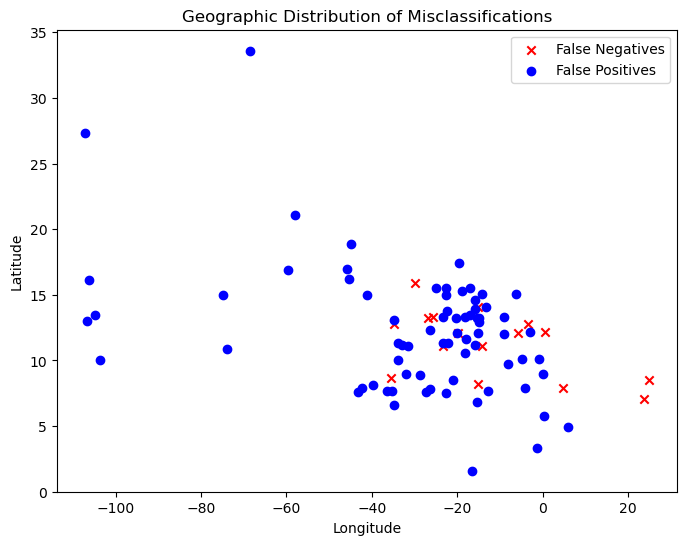

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


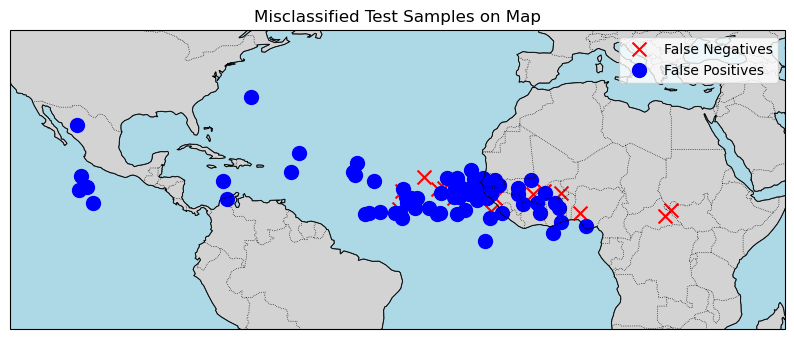

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

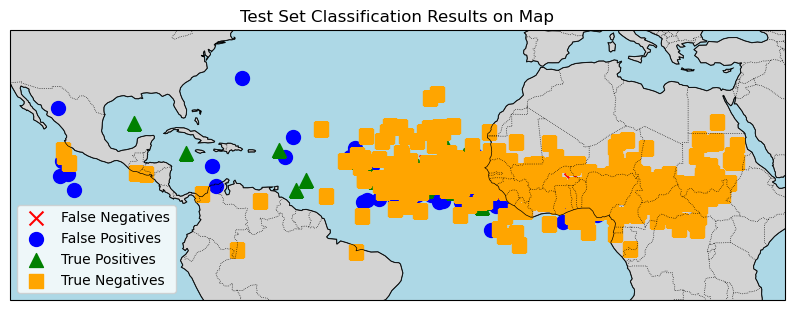

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

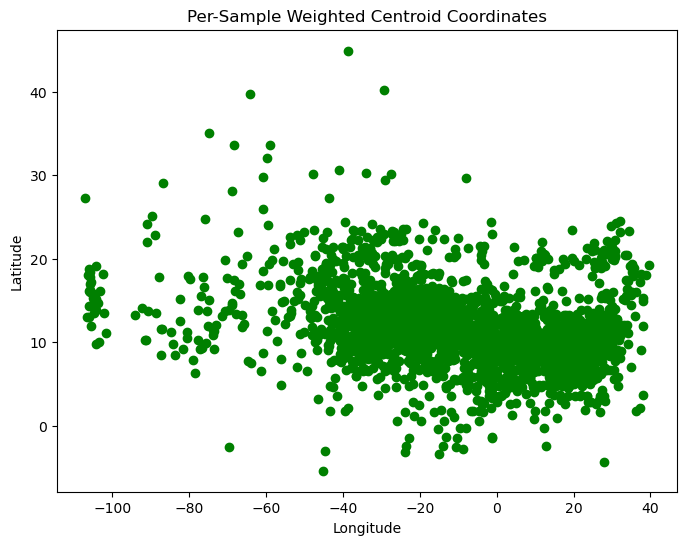

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.05951525643467903


Feature 0 - Increase in Loss: 0.01539979204535484


Feature 1 - Increase in Loss: -0.0016853332519531222


Feature 2 - Increase in Loss: 0.0012931980192661258


Feature 3 - Increase in Loss: 0.028092864900827408


Feature 4 - Increase in Loss: 0.02002145275473595


Feature 5 - Increase in Loss: -0.00013581588864326755


Feature 6 - Increase in Loss: 0.01089542731642723


Feature 7 - Increase in Loss: -0.001071327924728395


Feature 8 - Increase in Loss: -0.00015115737915039062


Feature 9 - Increase in Loss: 0.0030070938169956263


Feature 10 - Increase in Loss: -0.00106838494539261


Feature 11 - Increase in Loss: -0.0015894606709480272


Feature 12 - Increase in Loss: 0.0013896606862544986


Feature 13 - Increase in Loss: -0.0030466571450233487


Feature 14 - Increase in Loss: 0.00585309490561485


Feature 15 - Increase in Loss: 0.0018221668899059268


Feature 16 - Increase in Loss: 0.006806506961584094


Feature 17 - Increase in Loss: -5.930885672569136e-05
Permutation Importances (increase in loss) for all features: [ 1.53997920e-02 -1.68533325e-03  1.29319802e-03  2.80928649e-02
  2.00214528e-02 -1.35815889e-04  1.08954273e-02 -1.07132792e-03
 -1.51157379e-04  3.00709382e-03 -1.06838495e-03 -1.58946067e-03
  1.38966069e-03 -3.04665715e-03  5.85309491e-03  1.82216689e-03
  6.80650696e-03 -5.93088567e-05]


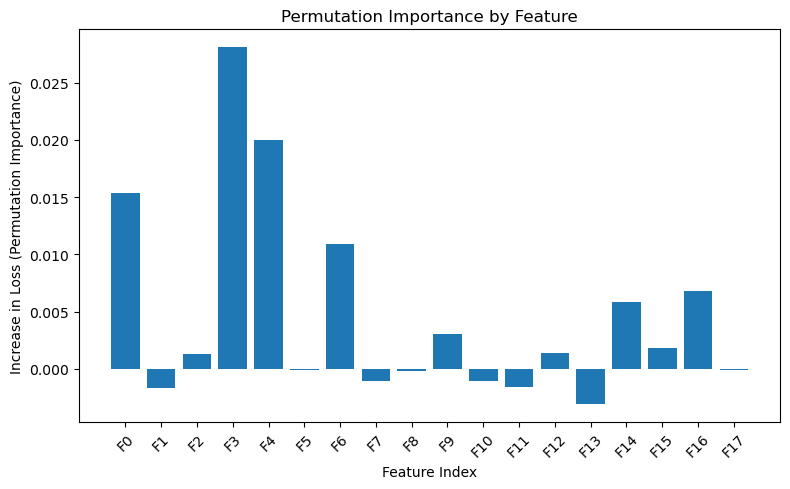

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


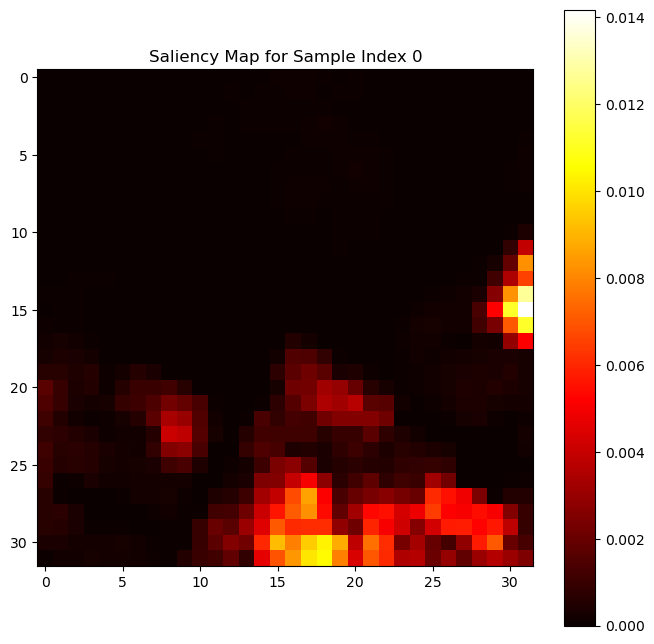

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



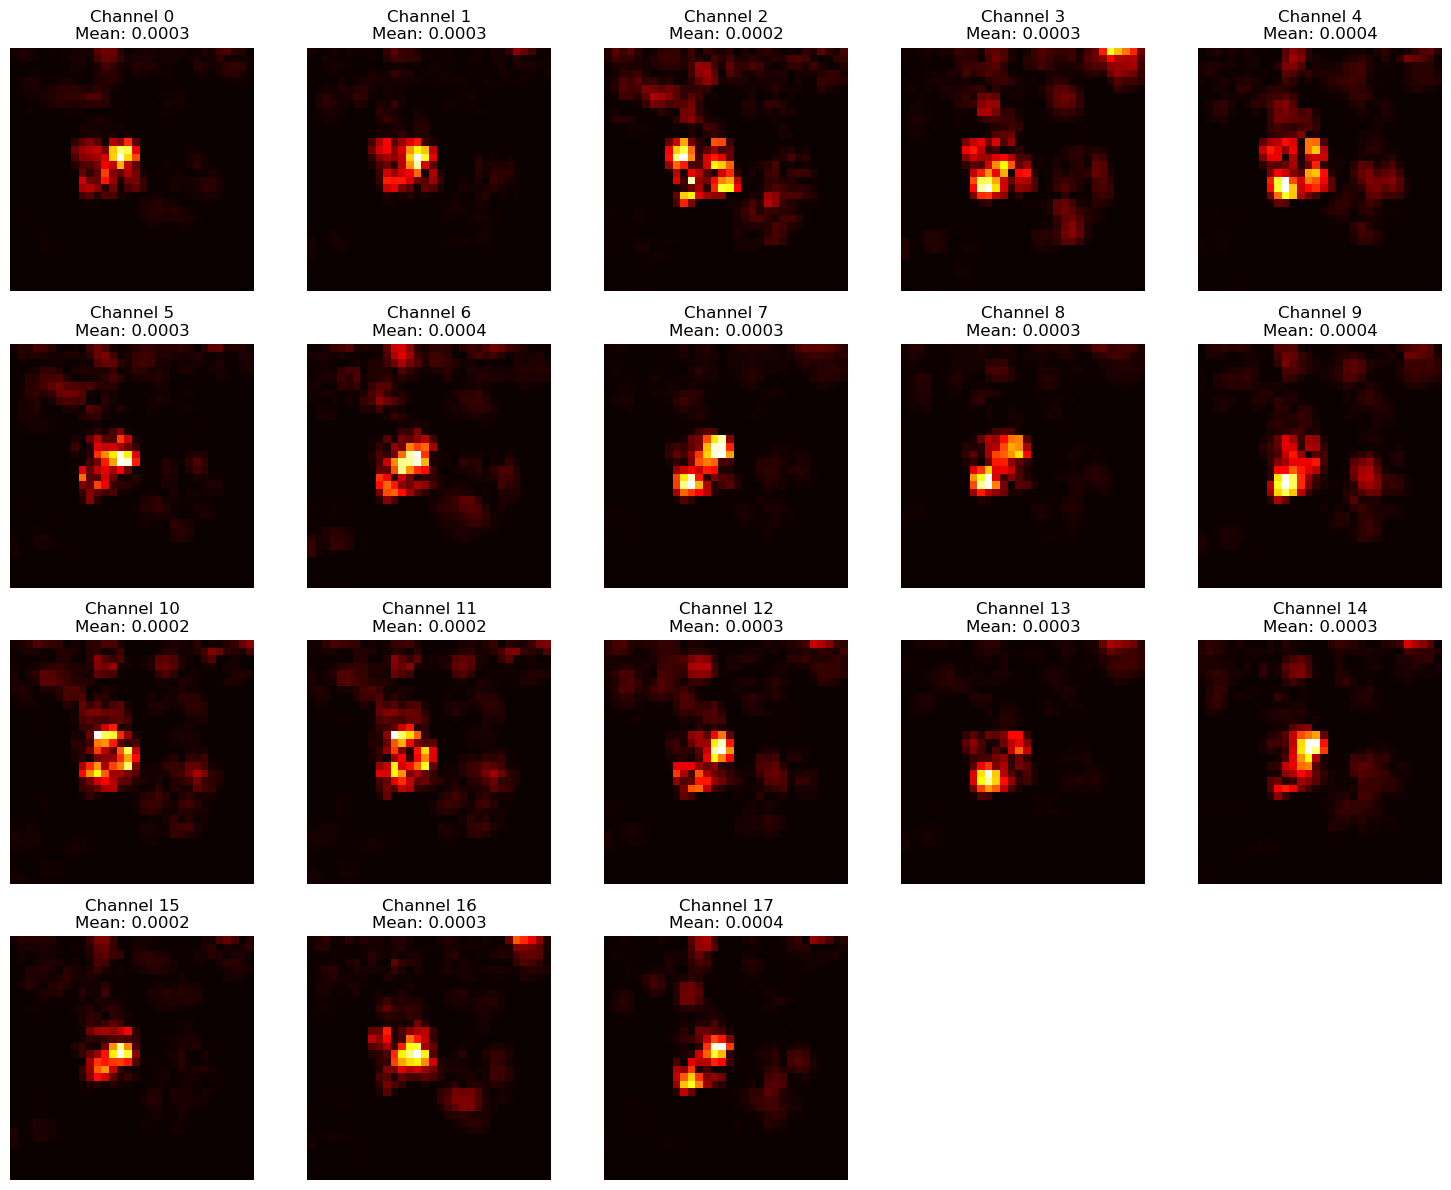

Channel importance (mean saliency per channel):
Channel 0: 0.0003
Channel 1: 0.0003
Channel 2: 0.0002
Channel 3: 0.0003
Channel 4: 0.0004
Channel 5: 0.0003
Channel 6: 0.0004
Channel 7: 0.0003
Channel 8: 0.0003
Channel 9: 0.0004
Channel 10: 0.0002
Channel 11: 0.0002
Channel 12: 0.0003
Channel 13: 0.0003
Channel 14: 0.0003
Channel 15: 0.0002
Channel 16: 0.0003
Channel 17: 0.0004


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


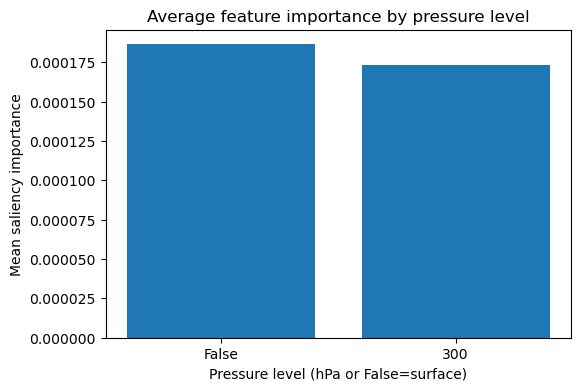

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.05951525643467903, 'compile_metrics': 0.3815577030181885}
    f1_score  val_f1_score
95  0.517544      0.642857
96  0.553097      0.600000
97  0.528138      0.600000
98  0.501044      0.448980
99  0.503145      0.511628


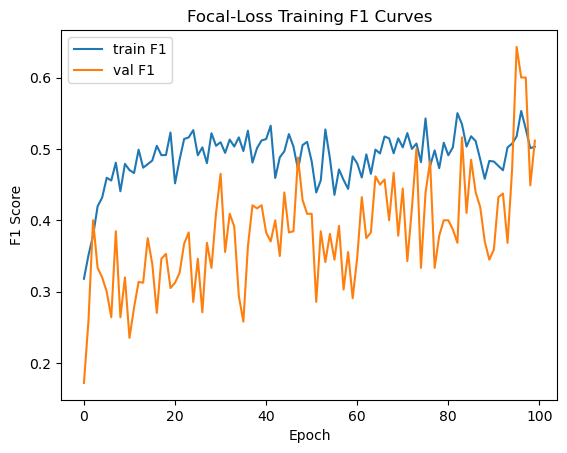

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.5154639175257731
